In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [3]:
#依赖的包
from lib.dataloader import normal_and_generate_dataset_time, get_mask, get_adjacent, get_grid_node_map_maxtrix
#攻击函数import
from lib.utils_new import mask_loss, compute_loss, predict_and_evaluate, attack, random_attack, fgsm_attack, min_attack
from lib.utils_new import saliency, saliency_loss, attack_js, attack_js,attack_saliency,rand_attack
from model.GSNet import GSNet
from lib.early_stop import EarlyStopping
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import json
import configparser
import pickle as pkl
from time import time
from datetime import datetime
import shutil
import argparse
import random
import math

import sys
import os


In [4]:
#完整运行时会生成txt日志记录#
train_log_filename = "test_log_ch.txt"
train_log_filepath = os.path.join("./", train_log_filename)
now = datetime.now()
date_time = now.strftime("|%Y-%m-%d, %H:%M:%S| ")

#以命令方式运行时会自动设置工作空间
#file会报错，应该家’‘
curPath = os.path.abspath(os.path.dirname('__file__'))
rootPath = os.path.split(curPath)[0]
sys.path.append(rootPath)

In [5]:
#配置文件载入，初始参数记录
#NYC
from mmcv import Config
cfgin = Config.fromfile('attack_all_setting.yaml')
#######


In [6]:
if cfgin.dataset =='NYC':
    config_filename = 'config/nyc/GSNet_NYC_Config.json'
else: 
    config_filename = "config/chicago/GSNet_Chicago_Config.json"
with open(config_filename, 'r') as f:
    config = json.loads(f.read())
# 写入测试超参数
with open(train_log_filepath, "a") as f:
    f.write('测试文件运行时间：'+date_time)
    f.write('\r\n')
    f.write('超参数设置：')
    f.write('\r\n')
    f.write(json.dumps(config, sort_keys=True, indent=4))
    f.write('\r\n')
f.close
#GPU设置
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

#文件读取
#命令行参数实质上就是赋初始值的作用，可以删除直接赋值就好
north_south_map = config['north_south_map']
west_east_map = config['west_east_map']

all_data_filename = config['all_data_filename']
mask_filename = config['mask_filename']

road_adj_filename = config['road_adj_filename']
risk_adj_filename = config['risk_adj_filename']
poi_adj_filename = config['poi_adj_filename']
grid_node_filename = config['grid_node_filename']
grid_node_map = get_grid_node_map_maxtrix(grid_node_filename)
num_of_vertices = grid_node_map.shape[1]


patience = config['patience']#用处：
delta = config['delta']

if config['seed'] is not None:
    seed = config['seed']
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    random.seed(seed)


train_rate = config['train_rate']
valid_rate = config['valid_rate']

recent_prior = config['recent_prior']
week_prior = config['week_prior']
one_day_period = config['one_day_period']
days_of_week = config['days_of_week']
pre_len = config['pre_len']
seq_len = recent_prior + week_prior

training_epoch = config['training_epoch']


True


# 原始数据处理
all_data.pkl       (8760, 48, 20, 20) 8760=365*24
grid_node_map.pkl  (400, 243)  映射矩阵
输出特征大小
训练集：4584*7*48*20*20
验证集：1080*7*48*20*20
测试集：1080*7*48*20*20
7的含义：t =673时刻是，输入7个时间片，[1, 169, 337, 505, 670, 671, 672]

In [7]:
batch_size = 32
learning_rate = config['learning_rate']

#模型结构
num_of_gru_layers = config['num_of_gru_layers']
gru_hidden_size = config['gru_hidden_size']
gcn_num_filter = config['gcn_num_filter']

loaders = []
scaler = ""
train_data_shape = ""
graph_feature_shape = ""
   ################## 获取测试数据#########################
for idx, (x, y, target_times, high_x, high_y, high_target_times, scaler) in enumerate(normal_and_generate_dataset_time(
        all_data_filename,
        train_rate=train_rate,
        valid_rate=valid_rate,
        recent_prior=recent_prior,
        week_prior=week_prior,
        one_day_period=one_day_period,
        days_of_week=days_of_week,
        pre_len=pre_len)):
    if False:#前100个，没写默认是false
        x = x[:100]
        y = y[:100]
        target_times = target_times[:100]
        high_x = high_x[:100]
        high_y = high_y[:100]
        high_target_times = high_target_times[:100]

    if 'nyc' in all_data_filename:
        graph_x = x[:, :, [0, 46, 47], :, :].reshape(
            (x.shape[0], x.shape[1], -1, north_south_map*west_east_map))#4584*7*3*400,注意reshape和交换维度的不同
        high_graph_x = high_x[:, :, [0, 46, 47], :, :].reshape(
            (high_x.shape[0], high_x.shape[1], -1, north_south_map*west_east_map))#1337*7*3*400
        graph_x = np.dot(graph_x, grid_node_map)#4584*7*3*243
        high_graph_x = np.dot(high_graph_x, grid_node_map)
    if 'chicago' in all_data_filename:
        graph_x = x[:, :, [0, 39, 40], :, :].reshape(
            (x.shape[0], x.shape[1], -1, north_south_map*west_east_map))
        high_graph_x = high_x[:, :, [0, 39, 40], :, :].reshape(
            (high_x.shape[0], high_x.shape[1], -1, north_south_map*west_east_map))
        graph_x = np.dot(graph_x, grid_node_map)
        high_graph_x = np.dot(high_graph_x, grid_node_map)

    print("feature:", str(x.shape), "label:", str(y.shape), "time:", str(target_times.shape),
            "high feature:", str(high_x.shape), "high label:", str(high_y.shape))
    print("graph_x:", str(graph_x.shape),
            "high_graph_x:", str(high_graph_x.shape))
    if x.shape[0] ==1080:
        b = np.ones_like(x)
        b = np.where(x>1,1,0)
        #print('x的最大值:{}'.format(np.sum(b)))
        #print('x的最小值:{}'.format(np.min(x)))
    if idx == 0:
        scaler = scaler
        train_data_shape = x.shape
        time_shape = target_times.shape
        graph_feature_shape = graph_x.shape
    loaders.append(Data.DataLoader(
        Data.TensorDataset(
            torch.from_numpy(x),
            torch.from_numpy(target_times),#4584*32
            torch.from_numpy(graph_x),
            torch.from_numpy(y)
        ),
        batch_size=batch_size,
        shuffle=(idx == 0)
    ))
    if idx == 2:
        high_test_loader = Data.DataLoader(
            Data.TensorDataset(
                torch.from_numpy(high_x),
                torch.from_numpy(high_target_times),
                torch.from_numpy(high_graph_x),
                torch.from_numpy(high_y)
            ),
            batch_size=batch_size,
            shuffle=(idx == 0)
        )
train_loader, val_loader, test_loader = loaders
################ 获取测试数据##################
nums_of_filter = []
for _ in range(2):
    nums_of_filter.append(gcn_num_filter)

GSNet_Model = GSNet(train_data_shape[2], num_of_gru_layers, seq_len, pre_len,
                    gru_hidden_size, time_shape[1], graph_feature_shape[2],
                    nums_of_filter, north_south_map, west_east_map)
print("模型参数---------------------------------------------")
print(train_data_shape[2], num_of_gru_layers, seq_len, pre_len,
        gru_hidden_size, time_shape[1], graph_feature_shape[2],
        nums_of_filter)

# multi gpu
if torch.cuda.device_count() > 10:
    print("Let's use", torch.cuda.device_count(), "GPUs!", flush=True)
    GSNet_Model = nn.DataParallel(GSNet_Model)
############### 载入模型######################
GSNet_Model.to(device)
# print(GSNet_Model)
if cfgin.dataset == 'NYC':
    GSNet_Model.load_state_dict(torch.load("data/model_parameter.pkl"))
else:
    #GSNet_Model.load_state_dict(torch.load("data/model_parameter007ch.pkl"))
    #GSNet_Model.load_state_dict(torch.load("data/model_retrain08/mode_59.pkl"))
    #GSNet_Model.load_state_dict(torch.load("data/model_retrain08/mode_36.pkl"))
    #GSNet_Model.load_state_dict(torch.load("/disk3/wyb/mycode/GSNet-master/data/model_train666/model_41.pkl"))
    # /disk3/wyb/mycode/GSNet-master/data/model_0515/model_35.pt
    GSNet_Model.load_state_dict(torch.load("/disk3/wyb/mycode/GSNet-master/data/model_0515/model_35.pt"))
print('数据集为：'+cfgin.dataset)
print("模型加载成功！")

num_of_parameters = 0
for name, parameters in GSNet_Model.named_parameters():
    num_of_parameters += np.prod(parameters.shape)
print("Number of Parameters: {}".format(num_of_parameters), flush=True)

trainer = optim.Adam(GSNet_Model.parameters(), lr=learning_rate)
early_stop = EarlyStopping(patience=patience, delta=delta)

risk_mask = get_mask(mask_filename)
road_adj = get_adjacent(road_adj_filename)
risk_adj = get_adjacent(risk_adj_filename)
if poi_adj_filename == "":
    poi_adj = None
else:
    poi_adj = get_adjacent(poi_adj_filename)


feature: (2827, 7, 41, 20, 20) label: (2827, 1, 20, 20) time: (2827, 32) high feature: (826, 7, 41, 20, 20) high label: (826, 1, 20, 20)
graph_x: (2827, 7, 3, 197) high_graph_x: (826, 7, 3, 197)
feature: (494, 7, 41, 20, 20) label: (494, 1, 20, 20) time: (494, 32) high feature: (143, 7, 41, 20, 20) high label: (143, 1, 20, 20)
graph_x: (494, 7, 3, 197) high_graph_x: (143, 7, 3, 197)
feature: (495, 7, 41, 20, 20) label: (495, 1, 20, 20) time: (495, 32) high feature: (144, 7, 41, 20, 20) high label: (144, 1, 20, 20)
graph_x: (495, 7, 3, 197) high_graph_x: (144, 7, 3, 197)
模型参数---------------------------------------------
41 6 7 1 128 32 3 [64, 64]
数据集为：Chicago
模型加载成功！
Number of Parameters: 3756715


In [8]:
#配置log日志输出
from myfunction import get_root_logger, logger_info
logger = get_root_logger('INFO', './logdata')
logger.info("Loading config file from ")


2023-05-16 18:57:18,606 - INFO - Loading config file from 


In [9]:
torch.cuda.empty_cache()

In [12]:
#攻击，并写入数据,20230315导入包修改为lib.utils_new_round
import yaml
from mmcv import Config
from myfunction import log_test_results
from lib.outzoom import log_test_csv,node_map,prenoise_pgd,rcr_pgd,fgsm,min,kl_pgd,JS_pgd_impr,rand_attack,nonenoise_pgd
from lib.outzoom import ZINBSC,fgsm_impr,min_impr,pgd_impr,random_impr,log_test_csv_time_K,ZINBSC_mse
from myfunction import get_root_logger, logger_info
#配置logo
logger = get_root_logger('INFO', './logdata')
logger.info("Loading config file from ")

#根据配置选择攻击方法
if cfgin.attacker == 'white_attacker':
    header = ['time', 'epoch', 'dataset', 'model', 'node_select', 'method', 'K', 'batch size',
              'clean_RMSE', 'clean_recall', 'clean_MAP', 'clean_RCR',
              'adv_RMSE', 'adv_recall', 'adv_MAP', 'adv_RCR',
              'local_adv_RMSE', 'local_adv_recall', 'local_adv_MAP', 'local_adv_RCR',
              '备注信息：特征分析，选择攻击节点50，e，alldata = rand,其他不变']
    #文件名
    file_name = 'boss0517-data-{}_num-nodes{}_eps{}-model-{}'.format(
        cfgin.dataset, cfgin.test_attack_nodes, cfgin.test_epsilon, cfgin.backbone)
    log_test_results(cfgin.result_dir, header, file_name)
    #可能的时间循环
    #攻击方法+节点选择组合
    for epoch in range(3):
        break
        for out_K in cfgin.K:
            for i in cfgin.select_node:
                for j in cfgin.attack_method:
                    logger.info(i+'_'+j+"_"+str(out_K))
                    parm_att = j  # 攻击方法的函数名称
                    parm_node = i  # 节点选择的方法
                    # 进行攻击,输出攻击日志
                    # 1. 节点选择，返回攻击的节点
                    ack_map = node_map(i,12,out_K, 5,cfgin, GSNet_Model, test_loader, risk_mask, road_adj, risk_adj, poi_adj,
                                       grid_node_map, device, data_type='nyc')
                    # 2. 攻击方法选择，返回未攻击后的预测值，标签值,攻击前的预测值，攻击过程打印每个信息
                    adv_val_predict, val_target, val_predict = eval("{0}".format(parm_att))(logger, cfgin, ack_map, GSNet_Model, test_loader,  road_adj, risk_adj, poi_adj,
                                                                                            grid_node_map, scaler, risk_mask, device, data_type='nyc')
                    # 计算结果并打印、存储,注意表头信息需要传递参数
                    log_test_csv_time_K(epoch, out_K, adv_val_predict, val_target,
                                        val_predict, cfgin, i, j, file_name, risk_mask)
                    torch.cuda.empty_cache()
    for epoch in range(3):
        #break
        for out_K in cfgin.K:
            for a in range(1,50,1):
                i = 'ten'
                j = 'ZINBSC'
                logger.info(i+'_'+j+"_"+str(out_K))
                parm_att = j  # 攻击方法的函数名称
                parm_node = i  # 节点选择的方法
                # 进行攻击,输出攻击日志
                # 1. 节点选择，返回攻击的节点
                ack_map = node_map(i, a, out_K, 5, cfgin, GSNet_Model, test_loader, risk_mask, road_adj, risk_adj, poi_adj,
                                    grid_node_map, device, data_type='nyc')
                # 2. 攻击方法选择，返回未攻击后的预测值，标签值,攻击前的预测值，攻击过程打印每个信息
                adv_val_predict, val_target, val_predict = eval("{0}".format(parm_att))(logger, cfgin, ack_map, GSNet_Model, test_loader,  road_adj, risk_adj, poi_adj,
                                                                                        grid_node_map, scaler, risk_mask, device, data_type='nyc')
                # 计算结果并打印、存储,注意表头信息需要传递参数
                log_test_csv_time_K(epoch, out_K, adv_val_predict, val_target,
                                    val_predict, cfgin, i, j, file_name, risk_mask)
                torch.cuda.empty_cache()


2023-05-16 23:47:37,751 - INFO - Loading config file from 
2023-05-16 23:47:37,754 - INFO - ten_ZINBSC_10


time,epoch,dataset,model,node_select,method,K,batch size,clean_RMSE,clean_recall,clean_MAP,clean_RCR,adv_RMSE,adv_recall,adv_MAP,adv_RCR,local_adv_RMSE,local_adv_recall,local_adv_MAP,local_adv_RCR,备注信息：特征分析，选择攻击节点50，e，alldata = rand,其他不变


2023-05-16 23:47:49,001 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5425 adv_Recall: 21.9048 adv_MAP: 0.0706 adv_RCR: 0.8191 time:3.711
2023-05-16 23:47:57,580 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5520 adv_Recall: 16.6667 adv_MAP: 0.1714 adv_RCR: 0.8587 time:3.693
2023-05-16 23:48:05,050 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5377 adv_Recall: 17.5258 adv_MAP: 0.0570 adv_RCR: 0.8843 time:3.652
2023-05-16 23:48:12,570 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5206 adv_Recall: 14.4330 adv_MAP: 0.0682 adv_RCR: 0.9108 time:3.648
2023-05-16 23:48:20,232 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-16 23:48:43,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.543449829226188,19.67799642218247,0.08312763100439324,0.8405908608054362,0.07437571038663097,98.37462587296308,0.9800839953485059,0.004176929399362444


2023-05-16 23:48:56,148 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5437 adv_Recall: 20.9524 adv_MAP: 0.0824 adv_RCR: 0.8197 time:3.722
2023-05-16 23:49:03,739 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5519 adv_Recall: 19.7917 adv_MAP: 0.1711 adv_RCR: 0.8217 time:3.685
2023-05-16 23:49:11,306 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5364 adv_Recall: 18.5567 adv_MAP: 0.0584 adv_RCR: 0.8866 time:3.678
2023-05-16 23:49:18,921 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5210 adv_Recall: 15.4639 adv_MAP: 0.0556 adv_RCR: 0.9044 time:3.718
2023-05-16 23:49:26,478 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-16 23:49:48,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5427864378283486,20.214669051878353,0.08674004641164337,0.8351244715193972,0.063978492430464,98.52427668772863,0.9819525716876822,0.004291373104414545


2023-05-16 23:50:02,602 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5434 adv_Recall: 22.8571 adv_MAP: 0.0761 adv_RCR: 0.8360 time:5.015
2023-05-16 23:50:10,155 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5511 adv_Recall: 16.6667 adv_MAP: 0.1534 adv_RCR: 0.8737 time:3.670
2023-05-16 23:50:17,726 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5395 adv_Recall: 17.5258 adv_MAP: 0.0634 adv_RCR: 0.8862 time:3.650
2023-05-16 23:50:25,356 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5228 adv_Recall: 15.4639 adv_MAP: 0.0570 adv_RCR: 0.9044 time:3.684
2023-05-16 23:50:32,933 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-16 23:50:54,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5439555591797162,19.7376267143709,0.08398391960396752,0.8419186103599545,0.06601603610296647,98.43282341203857,0.9807437430906735,0.004731300894648428


2023-05-16 23:51:08,369 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5462 adv_Recall: 21.9048 adv_MAP: 0.0767 adv_RCR: 0.8203 time:3.692
2023-05-16 23:51:15,894 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5532 adv_Recall: 16.6667 adv_MAP: 0.1591 adv_RCR: 0.8737 time:3.655
2023-05-16 23:51:23,448 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5411 adv_Recall: 18.5567 adv_MAP: 0.0620 adv_RCR: 0.8652 time:3.687
2023-05-16 23:51:30,979 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5240 adv_Recall: 15.4639 adv_MAP: 0.0669 adv_RCR: 0.9044 time:3.649
2023-05-16 23:51:38,559 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-16 23:52:00,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5454586906715087,19.379844961240313,0.08106977829660839,0.8434069214652323,0.06723133610460984,98.4536082474227,0.980970534356428,0.004510698966405066


2023-05-16 23:52:13,679 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5447 adv_Recall: 23.8095 adv_MAP: 0.0886 adv_RCR: 0.8087 time:3.786
2023-05-16 23:52:21,257 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5517 adv_Recall: 17.7083 adv_MAP: 0.1733 adv_RCR: 0.8525 time:3.669
2023-05-16 23:52:28,842 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5383 adv_Recall: 19.5876 adv_MAP: 0.0641 adv_RCR: 0.8757 time:3.690
2023-05-16 23:52:36,511 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5227 adv_Recall: 15.4639 adv_MAP: 0.0668 adv_RCR: 0.9045 time:3.726
2023-05-16 23:52:44,190 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-16 23:53:06,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5442864648745612,19.67799642218247,0.08530541965941421,0.8404261831214869,0.06686993331917741,98.71134020618557,0.9845687173825367,0.00374598735850988


2023-05-16 23:53:19,451 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5441 adv_Recall: 21.9048 adv_MAP: 0.0733 adv_RCR: 0.8277 time:3.700
2023-05-16 23:53:27,094 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5521 adv_Recall: 17.7083 adv_MAP: 0.1577 adv_RCR: 0.8527 time:3.708
2023-05-16 23:53:34,749 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5385 adv_Recall: 19.5876 adv_MAP: 0.0638 adv_RCR: 0.8768 time:3.714
2023-05-16 23:53:42,400 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5229 adv_Recall: 16.4948 adv_MAP: 0.0834 adv_RCR: 0.8827 time:3.737
2023-05-16 23:53:50,055 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-16 23:54:12,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5442546720925723,20.095408467501493,0.08452928191528945,0.8336641717025404,0.06654298803657209,98.61157299634186,0.982957394265156,0.004006119035192988


2023-05-16 23:54:25,887 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5434 adv_Recall: 25.7143 adv_MAP: 0.0859 adv_RCR: 0.8028 time:3.889
2023-05-16 23:54:33,708 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5522 adv_Recall: 17.7083 adv_MAP: 0.1614 adv_RCR: 0.8639 time:3.784
2023-05-16 23:54:41,385 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5379 adv_Recall: 19.5876 adv_MAP: 0.0627 adv_RCR: 0.8621 time:3.742
2023-05-16 23:54:49,049 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5247 adv_Recall: 15.4639 adv_MAP: 0.0581 adv_RCR: 0.9044 time:3.693
2023-05-16 23:54:56,633 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-16 23:55:19,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5446648409450039,19.97614788312463,0.08361680720451455,0.8382776794932849,0.0658967738870398,98.53674758895909,0.9824346082067348,0.004197854927137245


2023-05-16 23:55:32,241 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5464 adv_Recall: 20.9524 adv_MAP: 0.0741 adv_RCR: 0.8387 time:3.721
2023-05-16 23:55:39,887 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5531 adv_Recall: 19.7917 adv_MAP: 0.1703 adv_RCR: 0.8386 time:3.724
2023-05-16 23:55:47,480 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5390 adv_Recall: 20.6186 adv_MAP: 0.0722 adv_RCR: 0.8505 time:3.707
2023-05-16 23:55:55,057 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5258 adv_Recall: 15.4639 adv_MAP: 0.0675 adv_RCR: 0.9044 time:3.684
2023-05-16 23:56:02,666 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-16 23:56:24,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5461943490851526,20.51282051282051,0.08777008498950954,0.8298475354845496,0.06798858213646143,98.5991020951114,0.9830555107420346,0.004328452685976868


2023-05-16 23:56:38,118 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5450 adv_Recall: 22.8571 adv_MAP: 0.0942 adv_RCR: 0.8334 time:3.732
2023-05-16 23:56:45,715 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5531 adv_Recall: 18.7500 adv_MAP: 0.1705 adv_RCR: 0.8314 time:3.697
2023-05-16 23:56:53,376 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5374 adv_Recall: 18.5567 adv_MAP: 0.0684 adv_RCR: 0.8848 time:3.707
2023-05-16 23:57:01,240 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5236 adv_Recall: 15.4639 adv_MAP: 0.0656 adv_RCR: 0.9045 time:3.826
2023-05-16 23:57:09,098 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-16 23:57:31,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5446495565368478,20.214669051878353,0.08648204433942779,0.8347250957383036,0.0698898696199972,98.42035251080812,0.9800877362671514,0.004610297865868915


2023-05-16 23:57:44,419 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5445 adv_Recall: 21.9048 adv_MAP: 0.0692 adv_RCR: 0.8376 time:3.762
2023-05-16 23:57:52,089 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5536 adv_Recall: 17.7083 adv_MAP: 0.1558 adv_RCR: 0.8527 time:3.733
2023-05-16 23:57:59,755 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5390 adv_Recall: 20.6186 adv_MAP: 0.0627 adv_RCR: 0.8559 time:3.698
2023-05-16 23:58:07,352 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5238 adv_Recall: 16.4948 adv_MAP: 0.0987 adv_RCR: 0.8826 time:3.662
2023-05-16 23:58:14,896 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-16 23:58:37,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5448614681188059,19.856887298747765,0.08346156833793862,0.8390850333669806,0.06995793671605215,98.35384103757899,0.9797857271833551,0.004849041246979747


2023-05-16 23:58:50,274 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5438 adv_Recall: 20.0000 adv_MAP: 0.0658 adv_RCR: 0.8478 time:3.749
2023-05-16 23:58:58,039 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5545 adv_Recall: 17.7083 adv_MAP: 0.1571 adv_RCR: 0.8526 time:3.688
2023-05-16 23:59:05,682 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5396 adv_Recall: 19.5876 adv_MAP: 0.0659 adv_RCR: 0.8593 time:3.704
2023-05-16 23:59:13,270 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5238 adv_Recall: 15.4639 adv_MAP: 0.0693 adv_RCR: 0.9006 time:3.695
2023-05-16 23:59:21,887 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-16 23:59:44,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5445974907535877,19.618366129994037,0.08161471156962834,0.840386212309895,0.06543323993886606,98.54090455603591,0.9819948762132293,0.004186248833175342


2023-05-16 23:59:57,799 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5435 adv_Recall: 23.8095 adv_MAP: 0.0750 adv_RCR: 0.8212 time:3.697
2023-05-17 00:00:05,444 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5505 adv_Recall: 16.6667 adv_MAP: 0.1500 adv_RCR: 0.8737 time:3.709
2023-05-17 00:00:12,993 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5382 adv_Recall: 19.5876 adv_MAP: 0.0601 adv_RCR: 0.8647 time:3.652
2023-05-17 00:00:20,769 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5218 adv_Recall: 17.5258 adv_MAP: 0.0714 adv_RCR: 0.8743 time:3.695
2023-05-17 00:00:29,534 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:00:53,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5434959644684328,19.97614788312463,0.08279297933959358,0.8385571793527987,0.06777938461035256,98.26654472896574,0.9783034948088337,0.00503020482904346


2023-05-17 00:01:08,090 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5450 adv_Recall: 23.8095 adv_MAP: 0.0789 adv_RCR: 0.8305 time:5.119
2023-05-17 00:01:15,757 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5525 adv_Recall: 18.7500 adv_MAP: 0.1703 adv_RCR: 0.8248 time:3.717
2023-05-17 00:01:23,419 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5382 adv_Recall: 20.6186 adv_MAP: 0.0627 adv_RCR: 0.8615 time:3.712
2023-05-17 00:01:30,989 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5234 adv_Recall: 16.4948 adv_MAP: 0.0769 adv_RCR: 0.8942 time:3.678
2023-05-17 00:01:38,561 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:02:00,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5445730336741117,20.333929636255217,0.08683086225840694,0.8332366165516752,0.06319298779119838,98.56168939142002,0.9824385040452785,0.0039119647095894735


2023-05-17 00:02:14,212 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5443 adv_Recall: 21.9048 adv_MAP: 0.0815 adv_RCR: 0.8375 time:3.717
2023-05-17 00:02:21,805 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5521 adv_Recall: 17.7083 adv_MAP: 0.1734 adv_RCR: 0.8346 time:3.707
2023-05-17 00:02:29,547 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5392 adv_Recall: 20.6186 adv_MAP: 0.0598 adv_RCR: 0.8725 time:3.786
2023-05-17 00:02:37,141 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5242 adv_Recall: 15.4639 adv_MAP: 0.0581 adv_RCR: 0.9044 time:3.711
2023-05-17 00:02:44,960 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:03:07,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5445272927491945,20.095408467501493,0.0838664820383153,0.837215219102868,0.06461635686356314,98.52843365480545,0.9817933071976263,0.003967837159764264


2023-05-17 00:03:21,179 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5443 adv_Recall: 20.9524 adv_MAP: 0.0753 adv_RCR: 0.8355 time:4.561
2023-05-17 00:03:28,959 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5513 adv_Recall: 18.7500 adv_MAP: 0.1756 adv_RCR: 0.8248 time:3.753
2023-05-17 00:03:36,594 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5390 adv_Recall: 20.6186 adv_MAP: 0.0631 adv_RCR: 0.8596 time:3.721
2023-05-17 00:03:44,370 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5236 adv_Recall: 16.4948 adv_MAP: 0.1069 adv_RCR: 0.8826 time:3.739
2023-05-17 00:03:52,123 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:04:14,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5445689537630063,20.095408467501493,0.08837023939983867,0.8331671032621176,0.06925116250084558,98.49517791819089,0.9812937529071115,0.004004527661726595


2023-05-17 00:04:28,155 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5437 adv_Recall: 21.9048 adv_MAP: 0.0765 adv_RCR: 0.8395 time:3.681
2023-05-17 00:04:35,779 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5512 adv_Recall: 19.7917 adv_MAP: 0.1801 adv_RCR: 0.8216 time:3.699
2023-05-17 00:04:43,420 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5389 adv_Recall: 18.5567 adv_MAP: 0.0565 adv_RCR: 0.8690 time:3.718
2023-05-17 00:04:51,116 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5225 adv_Recall: 16.4948 adv_MAP: 0.1008 adv_RCR: 0.8826 time:3.799
2023-05-17 00:04:58,769 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:05:21,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5440923951535774,20.214669051878353,0.08739611380440131,0.8323643903884311,0.07148931710739245,98.47855004988361,0.981113506732081,0.004199058928665152


2023-05-17 00:05:34,640 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5437 adv_Recall: 23.8095 adv_MAP: 0.0775 adv_RCR: 0.8128 time:3.749
2023-05-17 00:05:43,678 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5513 adv_Recall: 15.6250 adv_MAP: 0.1413 adv_RCR: 0.8800 time:5.134
2023-05-17 00:05:51,279 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5394 adv_Recall: 16.4948 adv_MAP: 0.0528 adv_RCR: 0.8961 time:3.696
2023-05-17 00:05:58,938 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5227 adv_Recall: 18.5567 adv_MAP: 0.1046 adv_RCR: 0.8680 time:3.710
2023-05-17 00:06:06,558 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:06:30,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5444141746861346,19.79725700655933,0.08480766323956386,0.8401207851031799,0.07022101980327397,98.40372464250083,0.9800432259374644,0.004333530905734771


2023-05-17 00:06:43,854 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5444 adv_Recall: 20.9524 adv_MAP: 0.0756 adv_RCR: 0.8427 time:3.749
2023-05-17 00:06:51,471 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5504 adv_Recall: 17.7083 adv_MAP: 0.1683 adv_RCR: 0.8376 time:3.695
2023-05-17 00:06:59,120 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5383 adv_Recall: 18.5567 adv_MAP: 0.0596 adv_RCR: 0.8856 time:3.733
2023-05-17 00:07:06,792 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5224 adv_Recall: 17.5258 adv_MAP: 0.1065 adv_RCR: 0.8723 time:3.718
2023-05-17 00:07:14,429 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:07:36,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5434629973387527,19.79725700655933,0.08730175529003095,0.8387529448576437,0.07396203987553931,98.48686398403724,0.981735114298574,0.00426466394625608


2023-05-17 00:07:49,884 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5413 adv_Recall: 21.9048 adv_MAP: 0.0804 adv_RCR: 0.8379 time:3.731
2023-05-17 00:07:57,536 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5503 adv_Recall: 18.7500 adv_MAP: 0.1759 adv_RCR: 0.8278 time:3.709
2023-05-17 00:08:05,240 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5381 adv_Recall: 17.5258 adv_MAP: 0.0626 adv_RCR: 0.8917 time:3.738
2023-05-17 00:08:12,957 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5211 adv_Recall: 16.4948 adv_MAP: 0.1008 adv_RCR: 0.8787 time:3.752
2023-05-17 00:08:20,645 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:08:43,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5428810652987998,19.7376267143709,0.08703090973087312,0.8395954386365566,0.07483780992450038,98.42866644496175,0.9809102221197432,0.004367904950641877


2023-05-17 00:08:55,989 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5416 adv_Recall: 20.0000 adv_MAP: 0.0800 adv_RCR: 0.8412 time:3.676
2023-05-17 00:09:03,643 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5501 adv_Recall: 16.6667 adv_MAP: 0.1716 adv_RCR: 0.8587 time:3.716
2023-05-17 00:09:11,272 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5377 adv_Recall: 19.5876 adv_MAP: 0.0645 adv_RCR: 0.8701 time:3.696
2023-05-17 00:09:18,968 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5203 adv_Recall: 17.5258 adv_MAP: 0.1094 adv_RCR: 0.8724 time:3.733
2023-05-17 00:09:26,550 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:09:49,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5424012579183722,19.379844961240313,0.08720983457941797,0.8385648411680784,0.07810063063044045,98.42450947788494,0.9808819177072967,0.004353034139434552


2023-05-17 00:10:02,813 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5408 adv_Recall: 20.9524 adv_MAP: 0.0786 adv_RCR: 0.8358 time:3.748
2023-05-17 00:10:10,583 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5500 adv_Recall: 16.6667 adv_MAP: 0.1515 adv_RCR: 0.8589 time:3.785
2023-05-17 00:10:18,186 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5386 adv_Recall: 21.6495 adv_MAP: 0.0714 adv_RCR: 0.8628 time:3.688
2023-05-17 00:10:25,855 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5218 adv_Recall: 16.4948 adv_MAP: 0.0920 adv_RCR: 0.8826 time:3.800
2023-05-17 00:10:33,628 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:10:58,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5422949341984923,19.856887298747765,0.0858984116346758,0.8383505115697429,0.07879006165112382,98.4369803791154,0.9810614879328043,0.004677178785976535


2023-05-17 00:11:14,451 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5405 adv_Recall: 20.0000 adv_MAP: 0.0783 adv_RCR: 0.8446 time:5.139
2023-05-17 00:11:23,556 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5483 adv_Recall: 19.7917 adv_MAP: 0.1785 adv_RCR: 0.8215 time:3.799
2023-05-17 00:11:31,389 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5364 adv_Recall: 18.5567 adv_MAP: 0.0685 adv_RCR: 0.8831 time:3.815
2023-05-17 00:11:39,252 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5194 adv_Recall: 15.4639 adv_MAP: 0.0778 adv_RCR: 0.9046 time:3.818
2023-05-17 00:11:46,911 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:12:08,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5411958718381077,19.558735837805603,0.08497204310227736,0.8409734383659381,0.07082396472063175,98.237445959428,0.9781537377166816,0.005411960581246075


2023-05-17 00:12:22,064 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5428 adv_Recall: 20.0000 adv_MAP: 0.0722 adv_RCR: 0.8402 time:3.836
2023-05-17 00:12:29,665 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5506 adv_Recall: 17.7083 adv_MAP: 0.1553 adv_RCR: 0.8526 time:3.669
2023-05-17 00:12:37,371 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5363 adv_Recall: 19.5876 adv_MAP: 0.0636 adv_RCR: 0.8768 time:3.798
2023-05-17 00:12:45,072 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5202 adv_Recall: 17.5258 adv_MAP: 0.1048 adv_RCR: 0.8723 time:3.779
2023-05-17 00:12:52,824 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:13:15,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5425140474474087,20.095408467501493,0.08706551680864745,0.8372387297054646,0.06703541783865546,98.18340538742933,0.977044639210795,0.005336538180224347


2023-05-17 00:13:28,201 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5421 adv_Recall: 20.0000 adv_MAP: 0.0735 adv_RCR: 0.8477 time:3.690
2023-05-17 00:13:35,823 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5506 adv_Recall: 16.6667 adv_MAP: 0.1583 adv_RCR: 0.8557 time:3.709
2023-05-17 00:13:43,517 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5354 adv_Recall: 15.4639 adv_MAP: 0.0548 adv_RCR: 0.8837 time:3.735
2023-05-17 00:13:51,192 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5209 adv_Recall: 17.5258 adv_MAP: 0.0956 adv_RCR: 0.8763 time:3.771
2023-05-17 00:13:58,839 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:14:21,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5420305438642965,19.558735837805603,0.08539278813909867,0.8386707594114392,0.07216254845294366,98.07948121050882,0.9761525789572942,0.005832833817578668


2023-05-17 00:14:33,997 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5438 adv_Recall: 21.9048 adv_MAP: 0.0766 adv_RCR: 0.8384 time:3.713
2023-05-17 00:14:41,722 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5507 adv_Recall: 18.7500 adv_MAP: 0.1744 adv_RCR: 0.8315 time:3.768
2023-05-17 00:14:49,351 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5372 adv_Recall: 21.6495 adv_MAP: 0.0725 adv_RCR: 0.8518 time:3.699
2023-05-17 00:14:57,129 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5215 adv_Recall: 17.5258 adv_MAP: 0.1115 adv_RCR: 0.8783 time:3.783
2023-05-17 00:15:04,902 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:15:27,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5433328161972034,20.095408467501493,0.08811785853264076,0.8386271830729328,0.07155881421045188,98.14599268373794,0.9765479757060124,0.005738015985284218


2023-05-17 00:15:40,168 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5434 adv_Recall: 20.9524 adv_MAP: 0.0714 adv_RCR: 0.8276 time:3.782
2023-05-17 00:15:47,792 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5524 adv_Recall: 16.6667 adv_MAP: 0.1390 adv_RCR: 0.8557 time:3.663
2023-05-17 00:15:55,408 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5390 adv_Recall: 16.4948 adv_MAP: 0.0584 adv_RCR: 0.8905 time:3.651
2023-05-17 00:16:02,927 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5224 adv_Recall: 15.4639 adv_MAP: 0.0669 adv_RCR: 0.9044 time:3.663
2023-05-17 00:16:10,660 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:16:32,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5442079783069492,19.79725700655933,0.08345577929632768,0.8361805803285811,0.07791854232073993,98.13352178250749,0.9766272292441083,0.005701341938329746


2023-05-17 00:16:46,024 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5451 adv_Recall: 20.9524 adv_MAP: 0.0752 adv_RCR: 0.8445 time:3.771
2023-05-17 00:16:53,670 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5521 adv_Recall: 16.6667 adv_MAP: 0.1419 adv_RCR: 0.8557 time:3.697
2023-05-17 00:17:01,383 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5386 adv_Recall: 14.4330 adv_MAP: 0.0561 adv_RCR: 0.9065 time:3.700
2023-05-17 00:17:09,037 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5223 adv_Recall: 16.4948 adv_MAP: 0.0714 adv_RCR: 0.8943 time:3.774
2023-05-17 00:17:16,777 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:17:39,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5442773587981224,19.200954084675015,0.08261286685524023,0.8450004453356605,0.06926371670389392,98.28732956434985,0.9784438685592907,0.005136400212434851


2023-05-17 00:17:52,171 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5462 adv_Recall: 21.9048 adv_MAP: 0.0839 adv_RCR: 0.8161 time:3.787
2023-05-17 00:18:00,061 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5526 adv_Recall: 17.7083 adv_MAP: 0.1675 adv_RCR: 0.8526 time:3.853
2023-05-17 00:18:07,959 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5387 adv_Recall: 17.5258 adv_MAP: 0.0591 adv_RCR: 0.8910 time:3.839
2023-05-17 00:18:15,598 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5240 adv_Recall: 16.4948 adv_MAP: 0.0740 adv_RCR: 0.8981 time:3.722
2023-05-17 00:18:23,219 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:18:46,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.544799871737387,19.916517590936195,0.08220372503122625,0.8408799192108432,0.070072182072929,98.2582307948121,0.9780945136431943,0.005142965767324162


2023-05-17 00:18:59,252 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5434 adv_Recall: 21.9048 adv_MAP: 0.0802 adv_RCR: 0.8246 time:3.724
2023-05-17 00:19:06,851 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5511 adv_Recall: 17.7083 adv_MAP: 0.1568 adv_RCR: 0.8527 time:3.711
2023-05-17 00:19:14,508 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5391 adv_Recall: 18.5567 adv_MAP: 0.0643 adv_RCR: 0.8830 time:3.687
2023-05-17 00:19:22,382 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5220 adv_Recall: 16.4948 adv_MAP: 0.0643 adv_RCR: 0.8981 time:3.875
2023-05-17 00:19:30,113 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:19:52,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5440471127467721,20.274299344066783,0.08574878355643804,0.837413343648886,0.0758077120405555,98.08363817758563,0.9757534934509857,0.00599103663283381


2023-05-17 00:20:05,393 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5453 adv_Recall: 22.8571 adv_MAP: 0.0872 adv_RCR: 0.8148 time:3.752
2023-05-17 00:20:13,052 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5522 adv_Recall: 18.7500 adv_MAP: 0.1647 adv_RCR: 0.8428 time:3.727
2023-05-17 00:20:20,813 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5393 adv_Recall: 18.5567 adv_MAP: 0.0611 adv_RCR: 0.8812 time:3.839
2023-05-17 00:20:28,489 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5230 adv_Recall: 17.5258 adv_MAP: 0.0870 adv_RCR: 0.8763 time:3.769
2023-05-17 00:20:36,312 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:20:58,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5447016858294279,19.856887298747765,0.08499722313623691,0.8415755991790806,0.07598159992880865,98.14183571666112,0.9765388402743966,0.005916338309834801


2023-05-17 00:21:12,009 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5449 adv_Recall: 23.8095 adv_MAP: 0.0941 adv_RCR: 0.8234 time:3.762
2023-05-17 00:21:19,719 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5536 adv_Recall: 17.7083 adv_MAP: 0.1629 adv_RCR: 0.8528 time:3.770
2023-05-17 00:21:27,385 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5397 adv_Recall: 19.5876 adv_MAP: 0.0640 adv_RCR: 0.8751 time:3.698
2023-05-17 00:21:35,069 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5253 adv_Recall: 15.4639 adv_MAP: 0.0641 adv_RCR: 0.9045 time:3.697
2023-05-17 00:21:42,847 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:22:05,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5455457180971087,20.274299344066783,0.08656871855589804,0.8385012989812812,0.07022609909934498,98.24991686065846,0.9774806849698522,0.00523319473102085


2023-05-17 00:22:18,329 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5450 adv_Recall: 23.8095 adv_MAP: 0.0907 adv_RCR: 0.8132 time:3.849
2023-05-17 00:22:27,627 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5545 adv_Recall: 17.7083 adv_MAP: 0.1804 adv_RCR: 0.8377 time:4.398
2023-05-17 00:22:35,296 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5397 adv_Recall: 19.5876 adv_MAP: 0.0651 adv_RCR: 0.8702 time:3.723
2023-05-17 00:22:43,074 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5243 adv_Recall: 16.4948 adv_MAP: 0.0701 adv_RCR: 0.8827 time:3.747
2023-05-17 00:22:50,737 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:23:13,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5455022286477452,20.03577817531306,0.08811685328528675,0.8342700971346118,0.07071941531014012,98.27070169604258,0.9783143256682943,0.005248027210482078


2023-05-17 00:23:26,239 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5470 adv_Recall: 20.9524 adv_MAP: 0.0730 adv_RCR: 0.8294 time:3.757
2023-05-17 00:23:33,940 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5534 adv_Recall: 17.7083 adv_MAP: 0.1592 adv_RCR: 0.8527 time:3.726
2023-05-17 00:23:41,647 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5395 adv_Recall: 16.4948 adv_MAP: 0.0547 adv_RCR: 0.8869 time:3.771
2023-05-17 00:23:49,342 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5254 adv_Recall: 15.4639 adv_MAP: 0.0651 adv_RCR: 0.9045 time:3.769
2023-05-17 00:23:56,982 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:24:19,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5459181618819229,20.274299344066783,0.08381492375717471,0.8366837659065011,0.06661122510088308,98.39541070834719,0.9797680464887459,0.004845507685598223


2023-05-17 00:24:32,931 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5473 adv_Recall: 20.9524 adv_MAP: 0.0732 adv_RCR: 0.8384 time:3.751
2023-05-17 00:24:40,591 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5560 adv_Recall: 16.6667 adv_MAP: 0.1256 adv_RCR: 0.8739 time:3.728
2023-05-17 00:24:48,301 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5410 adv_Recall: 18.5567 adv_MAP: 0.0594 adv_RCR: 0.8700 time:3.726
2023-05-17 00:24:55,997 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5246 adv_Recall: 17.5258 adv_MAP: 0.0932 adv_RCR: 0.8782 time:3.755
2023-05-17 00:25:03,671 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:25:26,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5462559843259818,19.67799642218247,0.08301638885590246,0.838405187036638,0.06866696161931993,98.43282341203857,0.9802866418662812,0.00469191399576861


2023-05-17 00:25:39,425 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5466 adv_Recall: 20.9524 adv_MAP: 0.0703 adv_RCR: 0.8382 time:3.781
2023-05-17 00:25:47,188 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5547 adv_Recall: 16.6667 adv_MAP: 0.1241 adv_RCR: 0.8739 time:3.806
2023-05-17 00:25:54,983 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5410 adv_Recall: 18.5567 adv_MAP: 0.0619 adv_RCR: 0.8811 time:3.733
2023-05-17 00:26:02,667 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5265 adv_Recall: 16.4948 adv_MAP: 0.0677 adv_RCR: 0.8980 time:3.747
2023-05-17 00:26:10,337 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:26:32,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5470795561837136,19.7376267143709,0.08237581380302422,0.8460508676762047,0.06829260810565004,98.41203857665447,0.980221822321773,0.0046360186690017294


2023-05-17 00:26:46,188 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5467 adv_Recall: 24.7619 adv_MAP: 0.0983 adv_RCR: 0.8057 time:3.826
2023-05-17 00:26:53,912 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5539 adv_Recall: 18.7500 adv_MAP: 0.1649 adv_RCR: 0.8428 time:3.743
2023-05-17 00:27:01,612 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5401 adv_Recall: 16.4948 adv_MAP: 0.0599 adv_RCR: 0.8960 time:3.738
2023-05-17 00:27:09,305 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5261 adv_Recall: 15.4639 adv_MAP: 0.0567 adv_RCR: 0.9044 time:3.742
2023-05-17 00:27:17,074 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:27:39,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5464226715619165,20.095408467501493,0.08798805909348273,0.8399427627030366,0.06752377675095621,98.42035251080812,0.980535905276929,0.004669492592654526


2023-05-17 00:27:52,290 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5482 adv_Recall: 23.8095 adv_MAP: 0.0937 adv_RCR: 0.8138 time:3.739
2023-05-17 00:27:59,944 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5531 adv_Recall: 16.6667 adv_MAP: 0.1540 adv_RCR: 0.8558 time:3.698
2023-05-17 00:28:07,784 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5409 adv_Recall: 17.5258 adv_MAP: 0.0598 adv_RCR: 0.8928 time:3.755
2023-05-17 00:28:15,539 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5255 adv_Recall: 14.4330 adv_MAP: 0.0518 adv_RCR: 0.9107 time:3.735
2023-05-17 00:28:23,352 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:28:46,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5462947428812301,19.97614788312463,0.08604168450018308,0.8399983702611941,0.06766107700724196,98.40372464250083,0.9800280709656264,0.004760106908104446


2023-05-17 00:28:59,957 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5467 adv_Recall: 22.8571 adv_MAP: 0.0784 adv_RCR: 0.8342 time:3.896
2023-05-17 00:29:07,859 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5527 adv_Recall: 17.7083 adv_MAP: 0.1566 adv_RCR: 0.8527 time:3.845
2023-05-17 00:29:15,808 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5397 adv_Recall: 16.4948 adv_MAP: 0.0532 adv_RCR: 0.8812 time:3.801
2023-05-17 00:29:26,176 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5243 adv_Recall: 16.4948 adv_MAP: 0.0817 adv_RCR: 0.8826 time:5.065
2023-05-17 00:29:36,325 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:30:05,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.545348445364863,19.7376267143709,0.08144895997265855,0.8435100838022462,0.06764386628719007,98.58663119388095,0.9828534450380287,0.0041300328640514064


2023-05-17 00:30:20,134 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5470 adv_Recall: 22.8571 adv_MAP: 0.0843 adv_RCR: 0.8070 time:3.830
2023-05-17 00:30:29,855 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5543 adv_Recall: 16.6667 adv_MAP: 0.1294 adv_RCR: 0.8740 time:5.072
2023-05-17 00:30:40,154 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5392 adv_Recall: 17.5258 adv_MAP: 0.0589 adv_RCR: 0.8928 time:5.012
2023-05-17 00:30:48,767 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5262 adv_Recall: 15.4639 adv_MAP: 0.0635 adv_RCR: 0.9045 time:4.623
2023-05-17 00:30:58,974 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:31:23,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5462185044414501,19.67799642218247,0.0786636164648456,0.8421004711717908,0.0685665810801665,98.5575324243432,0.9824519184231142,0.0041627861909153945


2023-05-17 00:31:39,333 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5464 adv_Recall: 21.9048 adv_MAP: 0.0741 adv_RCR: 0.8432 time:5.069
2023-05-17 00:31:49,683 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5546 adv_Recall: 17.7083 adv_MAP: 0.1556 adv_RCR: 0.8527 time:5.032
2023-05-17 00:31:57,628 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5395 adv_Recall: 17.5258 adv_MAP: 0.0547 adv_RCR: 0.8899 time:3.797
2023-05-17 00:32:05,410 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5246 adv_Recall: 15.4639 adv_MAP: 0.0665 adv_RCR: 0.9044 time:3.797
2023-05-17 00:32:15,721 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:32:43,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5461441177964178,19.618366129994037,0.08453007534598164,0.8431599000685767,0.0662899471616078,98.61572996341869,0.9832469477436316,0.0039731746219579325


2023-05-17 00:32:57,889 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5448 adv_Recall: 21.9048 adv_MAP: 0.0817 adv_RCR: 0.8289 time:5.080
2023-05-17 00:33:08,126 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5549 adv_Recall: 18.7500 adv_MAP: 0.1693 adv_RCR: 0.8315 time:4.993
2023-05-17 00:33:17,265 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5391 adv_Recall: 19.5876 adv_MAP: 0.0619 adv_RCR: 0.8657 time:4.588
2023-05-17 00:33:25,040 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5240 adv_Recall: 15.4639 adv_MAP: 0.0643 adv_RCR: 0.9044 time:3.782
2023-05-17 00:33:33,682 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:34:03,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5457595161181598,20.03577817531306,0.08514002296878141,0.8367134894381932,0.06328052318648587,98.61988693049551,0.9832313302836602,0.0037163669291292016


2023-05-17 00:34:17,418 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5430 adv_Recall: 22.8571 adv_MAP: 0.0812 adv_RCR: 0.8173 time:4.270
2023-05-17 00:34:25,262 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5530 adv_Recall: 15.6250 adv_MAP: 0.1209 adv_RCR: 0.8949 time:3.800
2023-05-17 00:34:33,009 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5387 adv_Recall: 18.5567 adv_MAP: 0.0608 adv_RCR: 0.8801 time:3.782
2023-05-17 00:34:40,871 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5230 adv_Recall: 17.5258 adv_MAP: 0.1137 adv_RCR: 0.8608 time:3.802
2023-05-17 00:34:51,269 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:35:20,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5439451324321493,19.856887298747765,0.0842441438793551,0.8396904186663247,0.06478998705564665,98.48270701696042,0.9818253358608707,0.0044573436077298915


2023-05-17 00:35:36,594 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5430 adv_Recall: 22.8571 adv_MAP: 0.0784 adv_RCR: 0.8279 time:5.058
2023-05-17 00:35:46,913 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5526 adv_Recall: 17.7083 adv_MAP: 0.1590 adv_RCR: 0.8572 time:5.056
2023-05-17 00:35:55,744 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5373 adv_Recall: 18.5567 adv_MAP: 0.0618 adv_RCR: 0.8867 time:3.811
2023-05-17 00:36:03,555 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5239 adv_Recall: 16.4948 adv_MAP: 0.0751 adv_RCR: 0.8942 time:3.806
2023-05-17 00:36:11,377 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:36:37,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5447476339066091,20.03577817531306,0.0841540741176931,0.8383620863999414,0.0625110466864214,98.73212504156967,0.9845882466946566,0.0035307120212986717


2023-05-17 00:36:51,241 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5444 adv_Recall: 21.9048 adv_MAP: 0.0772 adv_RCR: 0.8272 time:3.833
2023-05-17 00:37:01,641 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5528 adv_Recall: 19.7917 adv_MAP: 0.1726 adv_RCR: 0.8215 time:5.028
2023-05-17 00:37:11,735 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5393 adv_Recall: 15.4639 adv_MAP: 0.0519 adv_RCR: 0.9003 time:4.807
2023-05-17 00:37:19,613 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5237 adv_Recall: 17.5258 adv_MAP: 0.1076 adv_RCR: 0.8724 time:3.843
2023-05-17 00:37:27,496 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:37:50,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5448598451163227,19.856887298747765,0.08590775413774895,0.8390884704482463,0.062302671040334906,98.62820086464914,0.98342922744712,0.003649958358884024


2023-05-17 00:38:03,620 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5438 adv_Recall: 22.8571 adv_MAP: 0.0770 adv_RCR: 0.8178 time:3.858
2023-05-17 00:38:11,540 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5524 adv_Recall: 19.7917 adv_MAP: 0.1768 adv_RCR: 0.8215 time:3.813
2023-05-17 00:38:19,327 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5387 adv_Recall: 18.5567 adv_MAP: 0.0590 adv_RCR: 0.8812 time:3.779
2023-05-17 00:38:27,154 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5235 adv_Recall: 16.4948 adv_MAP: 0.0773 adv_RCR: 0.8942 time:3.783
2023-05-17 00:38:34,979 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:39:01,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5445713350125728,20.095408467501493,0.0846749786349295,0.8383248631891472,0.06399958439910158,98.66145660126372,0.9839763831528814,0.003552512295887739


2023-05-17 00:39:15,684 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5432 adv_Recall: 20.9524 adv_MAP: 0.0725 adv_RCR: 0.8402 time:4.256
2023-05-17 00:39:24,803 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5532 adv_Recall: 17.7083 adv_MAP: 0.1609 adv_RCR: 0.8639 time:3.830
2023-05-17 00:39:33,281 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5397 adv_Recall: 17.5258 adv_MAP: 0.0589 adv_RCR: 0.8862 time:4.447
2023-05-17 00:39:43,503 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5245 adv_Recall: 16.4948 adv_MAP: 0.0682 adv_RCR: 0.8943 time:4.995
2023-05-17 00:39:51,325 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:40:14,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5448913798000916,19.618366129994037,0.08387775179099136,0.8441569395920706,0.0683192365786931,98.70302627203192,0.9841211146288216,0.0035945824898809364


2023-05-17 00:40:27,515 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5451 adv_Recall: 19.0476 adv_MAP: 0.0618 adv_RCR: 0.8508 time:3.770
2023-05-17 00:40:35,217 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5524 adv_Recall: 18.7500 adv_MAP: 0.1560 adv_RCR: 0.8596 time:3.735
2023-05-17 00:40:43,025 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5401 adv_Recall: 16.4948 adv_MAP: 0.0494 adv_RCR: 0.8924 time:3.727
2023-05-17 00:40:50,835 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5251 adv_Recall: 15.4639 adv_MAP: 0.0657 adv_RCR: 0.9044 time:3.846
2023-05-17 00:40:58,598 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:41:26,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5450125452221223,19.141323792486585,0.08164531667092996,0.8448960747367615,0.07584004047980314,98.53674758895909,0.9823241502591475,0.004244060590637845


2023-05-17 00:41:39,703 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5465 adv_Recall: 20.0000 adv_MAP: 0.0620 adv_RCR: 0.8413 time:3.846
2023-05-17 00:41:47,576 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5552 adv_Recall: 17.7083 adv_MAP: 0.1544 adv_RCR: 0.8526 time:3.841
2023-05-17 00:41:55,436 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5407 adv_Recall: 17.5258 adv_MAP: 0.0540 adv_RCR: 0.8844 time:3.820
2023-05-17 00:42:03,384 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5268 adv_Recall: 16.4948 adv_MAP: 0.0709 adv_RCR: 0.8942 time:3.870
2023-05-17 00:42:12,735 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:42:37,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.546937016509774,19.558735837805603,0.08259821789295098,0.8414250993675655,0.07583206276977396,98.5991020951114,0.983090033280636,0.0040180404091671685


2023-05-17 00:42:50,855 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5490 adv_Recall: 20.0000 adv_MAP: 0.0695 adv_RCR: 0.8480 time:3.877
2023-05-17 00:42:58,725 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5559 adv_Recall: 17.7083 adv_MAP: 0.1756 adv_RCR: 0.8525 time:3.858
2023-05-17 00:43:06,572 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5408 adv_Recall: 18.5567 adv_MAP: 0.0552 adv_RCR: 0.8746 time:3.813
2023-05-17 00:43:14,494 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5269 adv_Recall: 15.4639 adv_MAP: 0.0705 adv_RCR: 0.9006 time:3.838
2023-05-17 00:43:22,404 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:43:49,0,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5479143736604338,19.7376267143709,0.08535869196430988,0.8416376033800111,0.08078965492607189,98.56168939142002,0.9826127246008068,0.004244026550214148


2023-05-17 00:44:04,799 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5483 adv_Recall: 19.0476 adv_MAP: 0.0607 adv_RCR: 0.8467 time:4.850
2023-05-17 00:44:12,745 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5570 adv_Recall: 17.7083 adv_MAP: 0.1843 adv_RCR: 0.8488 time:3.850
2023-05-17 00:44:20,611 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5418 adv_Recall: 18.5567 adv_MAP: 0.0536 adv_RCR: 0.8800 time:3.801
2023-05-17 00:44:28,566 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5253 adv_Recall: 14.4330 adv_MAP: 0.0839 adv_RCR: 0.8991 time:3.881
2023-05-17 00:44:36,500 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:45:01,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5480854309191122,18.72391174716756,0.08370911646296451,0.8506234847264036,0.11097646305846257,97.78849351513136,0.9697249773472957,0.006438180938048691


2023-05-17 00:45:17,834 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5472 adv_Recall: 20.0000 adv_MAP: 0.0715 adv_RCR: 0.8308 time:4.718
2023-05-17 00:45:25,842 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5550 adv_Recall: 15.6250 adv_MAP: 0.1287 adv_RCR: 0.8950 time:3.865
2023-05-17 00:45:33,793 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5435 adv_Recall: 17.5258 adv_MAP: 0.0487 adv_RCR: 0.8857 time:3.811
2023-05-17 00:45:41,774 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5249 adv_Recall: 15.4639 adv_MAP: 0.0947 adv_RCR: 0.8735 time:3.927
2023-05-17 00:45:49,730 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:46:12,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5472412883553578,19.200954084675015,0.08693156436474356,0.8430703429517825,0.10857982793383084,97.87163285666777,0.9718306128231187,0.007720259152267733


2023-05-17 00:46:27,583 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5494 adv_Recall: 20.9524 adv_MAP: 0.0764 adv_RCR: 0.8388 time:5.166
2023-05-17 00:46:37,714 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5552 adv_Recall: 15.6250 adv_MAP: 0.1587 adv_RCR: 0.8769 time:5.109
2023-05-17 00:46:48,180 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5455 adv_Recall: 18.5567 adv_MAP: 0.0534 adv_RCR: 0.8745 time:5.110
2023-05-17 00:46:57,484 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5271 adv_Recall: 14.4330 adv_MAP: 0.0695 adv_RCR: 0.8955 time:5.123
2023-05-17 00:47:06,448 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:47:29,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5482844018847696,18.843172331544427,0.08404979972383538,0.8452380627983888,0.10523193905083919,97.72613900897905,0.9689207109362029,0.008079346998203238


2023-05-17 00:47:45,738 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5523 adv_Recall: 20.9524 adv_MAP: 0.0776 adv_RCR: 0.8268 time:5.234
2023-05-17 00:47:56,315 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5577 adv_Recall: 15.6250 adv_MAP: 0.1519 adv_RCR: 0.8737 time:5.121
2023-05-17 00:48:04,256 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5485 adv_Recall: 18.5567 adv_MAP: 0.0555 adv_RCR: 0.8838 time:3.891
2023-05-17 00:48:12,104 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5279 adv_Recall: 14.4330 adv_MAP: 0.0540 adv_RCR: 0.9108 time:3.818
2023-05-17 00:48:22,145 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:48:46,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5511188600034627,18.962432915921287,0.08276396707946475,0.8436285995302778,0.10558798313905014,97.92983039574327,0.9729784657195539,0.006937568618983046


2023-05-17 00:49:02,642 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5518 adv_Recall: 21.9048 adv_MAP: 0.0719 adv_RCR: 0.8172 time:4.886
2023-05-17 00:49:11,576 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5553 adv_Recall: 16.6667 adv_MAP: 0.1708 adv_RCR: 0.8587 time:3.843
2023-05-17 00:49:19,485 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5445 adv_Recall: 17.5258 adv_MAP: 0.0563 adv_RCR: 0.8862 time:3.825
2023-05-17 00:49:28,624 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5281 adv_Recall: 14.4330 adv_MAP: 0.0541 adv_RCR: 0.9109 time:4.454
2023-05-17 00:49:37,823 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:50:04,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5499927046688856,18.783542039355993,0.0820201389735967,0.848214774790943,0.10423345049365904,98.18756235450616,0.9768354213321236,0.006222562497088645


2023-05-17 00:50:18,853 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5498 adv_Recall: 23.8095 adv_MAP: 0.0901 adv_RCR: 0.8140 time:3.894
2023-05-17 00:50:26,804 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5555 adv_Recall: 16.6667 adv_MAP: 0.1640 adv_RCR: 0.8738 time:3.821
2023-05-17 00:50:35,720 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5445 adv_Recall: 17.5258 adv_MAP: 0.0499 adv_RCR: 0.8862 time:4.811
2023-05-17 00:50:44,225 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5263 adv_Recall: 15.4639 adv_MAP: 0.0629 adv_RCR: 0.9063 time:4.315
2023-05-17 00:50:52,232 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:51:15,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5494981687176997,19.141323792486585,0.08498368835151165,0.8462557873052662,0.10252588393848179,97.9381443298969,0.973563245517985,0.006967886156567998


2023-05-17 00:51:28,914 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5510 adv_Recall: 21.9048 adv_MAP: 0.0893 adv_RCR: 0.8349 time:3.918
2023-05-17 00:51:36,886 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5566 adv_Recall: 16.6667 adv_MAP: 0.1652 adv_RCR: 0.8738 time:3.846
2023-05-17 00:51:46,150 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5430 adv_Recall: 17.5258 adv_MAP: 0.0555 adv_RCR: 0.8862 time:3.846
2023-05-17 00:51:54,049 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5304 adv_Recall: 15.4639 adv_MAP: 0.0643 adv_RCR: 0.9044 time:3.849
2023-05-17 00:52:02,035 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:52:32,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.549114083093649,19.022063208109717,0.08330056804088794,0.8471640903490752,0.1009583328220826,97.93398736282009,0.9732574001624738,0.007058563637050333


2023-05-17 00:52:45,516 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5545 adv_Recall: 19.0476 adv_MAP: 0.0638 adv_RCR: 0.8510 time:3.938
2023-05-17 00:52:54,011 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5597 adv_Recall: 16.6667 adv_MAP: 0.1598 adv_RCR: 0.8738 time:4.404
2023-05-17 00:53:02,693 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5458 adv_Recall: 18.5567 adv_MAP: 0.0607 adv_RCR: 0.8755 time:3.865
2023-05-17 00:53:10,645 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5309 adv_Recall: 15.4639 adv_MAP: 0.0635 adv_RCR: 0.9043 time:3.838
2023-05-17 00:53:20,548 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:53:45,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5518739721439337,19.379844961240313,0.08429966851316802,0.8434755076860897,0.10614286772599868,97.99218490189557,0.9745187402523192,0.007288954317431324


2023-05-17 00:53:58,829 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5541 adv_Recall: 20.9524 adv_MAP: 0.0824 adv_RCR: 0.8364 time:3.792
2023-05-17 00:54:09,212 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5578 adv_Recall: 16.6667 adv_MAP: 0.1840 adv_RCR: 0.8586 time:5.128
2023-05-17 00:54:18,116 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5460 adv_Recall: 20.6186 adv_MAP: 0.0671 adv_RCR: 0.8558 time:4.164
2023-05-17 00:54:26,092 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5288 adv_Recall: 15.4639 adv_MAP: 0.0645 adv_RCR: 0.9044 time:3.946
2023-05-17 00:54:33,981 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:54:57,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5499824914843111,19.08169350029815,0.08449785033085576,0.8471752676627025,0.10737137459122024,97.82590621882275,0.9711079687258914,0.007575729538401512


2023-05-17 00:55:11,237 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5517 adv_Recall: 21.9048 adv_MAP: 0.0788 adv_RCR: 0.8413 time:3.894
2023-05-17 00:55:19,194 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5592 adv_Recall: 15.6250 adv_MAP: 0.1577 adv_RCR: 0.8770 time:3.891
2023-05-17 00:55:29,060 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5433 adv_Recall: 18.5567 adv_MAP: 0.0668 adv_RCR: 0.8813 time:4.482
2023-05-17 00:55:36,890 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5286 adv_Recall: 17.5258 adv_MAP: 0.1131 adv_RCR: 0.8607 time:3.826
2023-05-17 00:55:45,025 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:56:12,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5497958472182822,19.379844961240313,0.08720869343329334,0.8453750785110382,0.10518826805556776,97.78433654805454,0.9699345369355237,0.007371075637531926


2023-05-17 00:56:28,692 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5503 adv_Recall: 20.0000 adv_MAP: 0.0749 adv_RCR: 0.8412 time:5.248
2023-05-17 00:56:36,796 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5588 adv_Recall: 16.6667 adv_MAP: 0.1681 adv_RCR: 0.8587 time:3.936
2023-05-17 00:56:44,851 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5450 adv_Recall: 20.6186 adv_MAP: 0.0632 adv_RCR: 0.8466 time:3.886
2023-05-17 00:56:52,878 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5284 adv_Recall: 13.4021 adv_MAP: 0.0531 adv_RCR: 0.9171 time:3.928
2023-05-17 00:57:00,745 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:57:25,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5494600836913706,19.200954084675015,0.0833724607543844,0.8451721817970208,0.1032715779280636,97.84669105420684,0.9713316628083297,0.0071230575460267415


2023-05-17 00:57:39,456 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5480 adv_Recall: 23.8095 adv_MAP: 0.0739 adv_RCR: 0.8144 time:3.863
2023-05-17 00:57:47,406 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5551 adv_Recall: 15.6250 adv_MAP: 0.1234 adv_RCR: 0.8950 time:3.835
2023-05-17 00:57:56,521 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5438 adv_Recall: 19.5876 adv_MAP: 0.0627 adv_RCR: 0.8733 time:5.084
2023-05-17 00:58:06,920 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5260 adv_Recall: 13.4021 adv_MAP: 0.0587 adv_RCR: 0.9171 time:5.091
2023-05-17 00:58:17,299 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:58:46,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.54782678171783,18.962432915921287,0.07838213090517644,0.8518151255359592,0.10567517499462384,97.70119720651812,0.9678549860668979,0.0075166381025564095


2023-05-17 00:59:01,442 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5502 adv_Recall: 20.9524 adv_MAP: 0.0732 adv_RCR: 0.8408 time:3.851
2023-05-17 00:59:09,452 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5561 adv_Recall: 18.7500 adv_MAP: 0.1566 adv_RCR: 0.8483 time:3.915
2023-05-17 00:59:17,727 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5438 adv_Recall: 15.4639 adv_MAP: 0.0517 adv_RCR: 0.9004 time:3.826
2023-05-17 00:59:25,642 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5271 adv_Recall: 15.4639 adv_MAP: 0.0955 adv_RCR: 0.8890 time:3.887
2023-05-17 00:59:33,543 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 00:59:56,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5486280439746599,18.902802623732857,0.08637686048172155,0.8419601248099908,0.10258634476776654,97.93398736282009,0.9717753513787891,0.006888718977868048


2023-05-17 01:00:10,412 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5474 adv_Recall: 21.9048 adv_MAP: 0.0819 adv_RCR: 0.8580 time:3.905
2023-05-17 01:00:18,408 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5549 adv_Recall: 17.7083 adv_MAP: 0.1541 adv_RCR: 0.8527 time:3.821
2023-05-17 01:00:26,300 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5436 adv_Recall: 18.5567 adv_MAP: 0.0604 adv_RCR: 0.8849 time:3.823
2023-05-17 01:00:35,407 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5272 adv_Recall: 18.5567 adv_MAP: 0.1191 adv_RCR: 0.8543 time:5.030
2023-05-17 01:00:44,870 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:01:09,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5484815964804464,19.32021466905188,0.08511272418273749,0.8468199975920947,0.10544547155164793,97.86747588959095,0.9706049804051872,0.006993274488559645


2023-05-17 01:01:22,963 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5498 adv_Recall: 21.9048 adv_MAP: 0.0824 adv_RCR: 0.8252 time:3.860
2023-05-17 01:01:30,884 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5546 adv_Recall: 16.6667 adv_MAP: 0.1682 adv_RCR: 0.8586 time:3.849
2023-05-17 01:01:38,935 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5449 adv_Recall: 18.5567 adv_MAP: 0.0566 adv_RCR: 0.8747 time:3.857
2023-05-17 01:01:46,769 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5269 adv_Recall: 15.4639 adv_MAP: 0.0903 adv_RCR: 0.8890 time:3.817
2023-05-17 01:01:56,771 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:02:22,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.549003619186469,18.783542039355993,0.0867715339012018,0.8495859100702732,0.11028756060139637,97.88410375789823,0.9700837742002679,0.0067735141219037644


2023-05-17 01:02:37,230 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5483 adv_Recall: 22.8571 adv_MAP: 0.0849 adv_RCR: 0.8346 time:5.156
2023-05-17 01:02:45,167 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5556 adv_Recall: 15.6250 adv_MAP: 0.1354 adv_RCR: 0.8799 time:3.885
2023-05-17 01:02:53,133 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5434 adv_Recall: 16.4948 adv_MAP: 0.0635 adv_RCR: 0.8887 time:3.900
2023-05-17 01:03:01,102 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5260 adv_Recall: 15.4639 adv_MAP: 0.0734 adv_RCR: 0.8890 time:3.955
2023-05-17 01:03:09,198 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:03:38,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5476099753823511,18.66428145497913,0.08163482582290928,0.8496031334829154,0.11515939442783493,97.79265048220817,0.9695665397647173,0.007191866696377242


2023-05-17 01:03:54,145 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5501 adv_Recall: 21.9048 adv_MAP: 0.0708 adv_RCR: 0.8344 time:5.126
2023-05-17 01:04:04,545 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5560 adv_Recall: 15.6250 adv_MAP: 0.1415 adv_RCR: 0.8800 time:5.065
2023-05-17 01:04:14,927 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5437 adv_Recall: 18.5567 adv_MAP: 0.0655 adv_RCR: 0.8784 time:5.078
2023-05-17 01:04:22,798 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5258 adv_Recall: 15.4639 adv_MAP: 0.0537 adv_RCR: 0.9064 time:3.853
2023-05-17 01:04:30,739 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:04:55,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5484760044026622,18.545020870602265,0.07969267460780116,0.8535201015519321,0.11099916462249743,97.77186564682407,0.9695357837595833,0.007113030796662894


2023-05-17 01:05:09,447 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5478 adv_Recall: 20.0000 adv_MAP: 0.0822 adv_RCR: 0.8469 time:3.889
2023-05-17 01:05:17,516 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5557 adv_Recall: 16.6667 adv_MAP: 0.1744 adv_RCR: 0.8587 time:3.923
2023-05-17 01:05:25,539 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5431 adv_Recall: 17.5258 adv_MAP: 0.0574 adv_RCR: 0.8862 time:3.881
2023-05-17 01:05:33,524 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5239 adv_Recall: 14.4330 adv_MAP: 0.0624 adv_RCR: 0.9108 time:3.835
2023-05-17 01:05:41,399 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:06:08,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5471025423255303,18.902802623732857,0.0850221858529284,0.8455094950242621,0.11321943369961103,97.83422015297639,0.9704144692887767,0.006978097678441399


2023-05-17 01:06:24,289 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5470 adv_Recall: 20.9524 adv_MAP: 0.0917 adv_RCR: 0.8290 time:4.618
2023-05-17 01:06:34,683 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5532 adv_Recall: 15.6250 adv_MAP: 0.1593 adv_RCR: 0.8799 time:5.118
2023-05-17 01:06:45,097 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5427 adv_Recall: 17.5258 adv_MAP: 0.0606 adv_RCR: 0.8838 time:5.071
2023-05-17 01:06:54,882 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5227 adv_Recall: 15.4639 adv_MAP: 0.1031 adv_RCR: 0.8889 time:5.068
2023-05-17 01:07:04,635 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:07:34,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5462766891788574,19.08169350029815,0.0873736326620471,0.8441363752658737,0.11241230493900145,97.78017958097772,0.9702276113878947,0.007230866458365591


2023-05-17 01:07:47,505 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5459 adv_Recall: 19.0476 adv_MAP: 0.0690 adv_RCR: 0.8508 time:3.915
2023-05-17 01:07:55,471 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5539 adv_Recall: 16.6667 adv_MAP: 0.1441 adv_RCR: 0.8701 time:3.888
2023-05-17 01:08:03,537 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5443 adv_Recall: 18.5567 adv_MAP: 0.0659 adv_RCR: 0.8635 time:3.926
2023-05-17 01:08:11,449 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5218 adv_Recall: 15.4639 adv_MAP: 0.0996 adv_RCR: 0.8889 time:3.850
2023-05-17 01:08:19,401 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:08:46,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5460815129354918,18.902802623732857,0.08271168322464842,0.8458033925491583,0.11575137671552391,97.80096441636182,0.9699858084393731,0.007237862880334928


2023-05-17 01:09:00,988 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5456 adv_Recall: 20.0000 adv_MAP: 0.0859 adv_RCR: 0.8443 time:5.148
2023-05-17 01:09:11,542 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5521 adv_Recall: 14.5833 adv_MAP: 0.1281 adv_RCR: 0.9011 time:5.121
2023-05-17 01:09:19,743 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5442 adv_Recall: 14.4330 adv_MAP: 0.0595 adv_RCR: 0.9047 time:3.881
2023-05-17 01:09:27,653 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5236 adv_Recall: 14.4330 adv_MAP: 0.0567 adv_RCR: 0.9108 time:3.813
2023-05-17 01:09:35,561 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:09:59,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.54629377509812,18.843172331544427,0.08166670052087545,0.8493851667672466,0.1192342789841244,97.75523777851679,0.9696041085785566,0.007847136878084563


2023-05-17 01:10:12,848 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5456 adv_Recall: 18.0952 adv_MAP: 0.0815 adv_RCR: 0.8488 time:3.788
2023-05-17 01:10:20,846 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5525 adv_Recall: 14.5833 adv_MAP: 0.1267 adv_RCR: 0.9011 time:3.929
2023-05-17 01:10:28,678 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5436 adv_Recall: 16.4948 adv_MAP: 0.0669 adv_RCR: 0.8953 time:3.723
2023-05-17 01:10:36,414 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5235 adv_Recall: 14.4330 adv_MAP: 0.0567 adv_RCR: 0.9108 time:3.757
2023-05-17 01:10:44,169 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:11:06,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5458392798730521,17.829457364341085,0.07937663986719476,0.8602906445306197,0.11376500474485628,97.70951114067176,0.9694153391659229,0.008764520375069668


2023-05-17 01:11:20,058 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5478 adv_Recall: 20.9524 adv_MAP: 0.0664 adv_RCR: 0.8454 time:3.814
2023-05-17 01:11:27,762 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5543 adv_Recall: 16.6667 adv_MAP: 0.1085 adv_RCR: 0.8740 time:3.741
2023-05-17 01:11:35,532 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5446 adv_Recall: 18.5567 adv_MAP: 0.0626 adv_RCR: 0.8777 time:3.755
2023-05-17 01:11:43,299 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5256 adv_Recall: 14.4330 adv_MAP: 0.0657 adv_RCR: 0.9107 time:3.786
2023-05-17 01:11:51,063 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:12:13,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5471780584519144,19.32021466905188,0.08057449868929933,0.8477071700359687,0.10820434225175894,97.74276687728633,0.9690663347847599,0.007976255547289483


2023-05-17 01:12:26,836 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5467 adv_Recall: 22.8571 adv_MAP: 0.0755 adv_RCR: 0.8183 time:3.805
2023-05-17 01:12:34,570 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5537 adv_Recall: 14.5833 adv_MAP: 0.1236 adv_RCR: 0.9012 time:3.759
2023-05-17 01:12:42,249 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5440 adv_Recall: 18.5567 adv_MAP: 0.0565 adv_RCR: 0.8793 time:3.724
2023-05-17 01:12:49,953 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5250 adv_Recall: 17.5258 adv_MAP: 0.1092 adv_RCR: 0.8608 time:3.757
2023-05-17 01:12:57,687 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:13:20,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5466468462409556,19.260584376863445,0.08604757780502699,0.8447566753925352,0.11168322744663674,97.60558696375125,0.967703486102225,0.008668103841494933


2023-05-17 01:13:33,202 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5502 adv_Recall: 22.8571 adv_MAP: 0.0791 adv_RCR: 0.8344 time:3.805
2023-05-17 01:13:40,916 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5563 adv_Recall: 15.6250 adv_MAP: 0.1283 adv_RCR: 0.8949 time:3.741
2023-05-17 01:13:48,670 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5442 adv_Recall: 17.5258 adv_MAP: 0.0568 adv_RCR: 0.8855 time:3.758
2023-05-17 01:13:56,420 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5248 adv_Recall: 13.4021 adv_MAP: 0.0497 adv_RCR: 0.9171 time:3.806
2023-05-17 01:14:04,269 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:14:26,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5483109956483109,18.783542039355993,0.07956616109258961,0.8502993051319379,0.11376455791452507,97.64299966744264,0.9680205040053683,0.008396115579130812


2023-05-17 01:14:40,321 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5512 adv_Recall: 20.9524 adv_MAP: 0.0730 adv_RCR: 0.8270 time:3.873
2023-05-17 01:14:48,191 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5548 adv_Recall: 14.5833 adv_MAP: 0.0910 adv_RCR: 0.8984 time:3.824
2023-05-17 01:14:56,106 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5464 adv_Recall: 15.4639 adv_MAP: 0.0584 adv_RCR: 0.8948 time:3.848
2023-05-17 01:15:04,091 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5276 adv_Recall: 15.4639 adv_MAP: 0.0627 adv_RCR: 0.9045 time:3.899
2023-05-17 01:15:12,015 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:15:35,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5490694154360617,18.962432915921287,0.0748217729989985,0.8500775517594178,0.12197597234787325,97.60558696375125,0.967758663239277,0.008932256132808158


2023-05-17 01:15:50,783 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5504 adv_Recall: 20.9524 adv_MAP: 0.0706 adv_RCR: 0.8268 time:5.067
2023-05-17 01:16:00,413 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5536 adv_Recall: 17.7083 adv_MAP: 0.1625 adv_RCR: 0.8526 time:4.381
2023-05-17 01:16:08,390 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5451 adv_Recall: 14.4330 adv_MAP: 0.0550 adv_RCR: 0.9065 time:3.921
2023-05-17 01:16:17,605 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5281 adv_Recall: 16.4948 adv_MAP: 0.0627 adv_RCR: 0.8982 time:3.861
2023-05-17 01:16:25,458 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:16:49,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5481653265164909,18.783542039355993,0.08012057367035719,0.8496423026336062,0.11179649132472366,97.64299966744264,0.9685675753071231,0.008442027443833109


2023-05-17 01:17:04,926 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5494 adv_Recall: 21.9048 adv_MAP: 0.0821 adv_RCR: 0.8276 time:5.133
2023-05-17 01:17:15,270 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5554 adv_Recall: 14.5833 adv_MAP: 0.1202 adv_RCR: 0.9011 time:5.068
2023-05-17 01:17:24,055 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5461 adv_Recall: 18.5567 adv_MAP: 0.0653 adv_RCR: 0.8803 time:3.889
2023-05-17 01:17:31,969 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5285 adv_Recall: 16.4948 adv_MAP: 0.0626 adv_RCR: 0.8982 time:3.816
2023-05-17 01:17:40,834 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:18:05,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5493770630571175,19.439475253428743,0.08354896137602318,0.8445174595816425,0.11029381077957914,97.6762554040572,0.9686884619573631,0.008440752376908717


2023-05-17 01:18:20,320 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5522 adv_Recall: 20.9524 adv_MAP: 0.0701 adv_RCR: 0.8231 time:3.877
2023-05-17 01:18:29,359 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5547 adv_Recall: 16.6667 adv_MAP: 0.1607 adv_RCR: 0.8589 time:4.976
2023-05-17 01:18:37,253 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5470 adv_Recall: 14.4330 adv_MAP: 0.0529 adv_RCR: 0.9011 time:3.859
2023-05-17 01:18:45,126 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5260 adv_Recall: 15.4639 adv_MAP: 0.0765 adv_RCR: 0.8890 time:3.817
2023-05-17 01:18:53,045 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:19:18,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5494613492445379,18.783542039355993,0.07990573871470882,0.8471480239883938,0.11740600674687295,97.63884270036581,0.9679853563001726,0.00855724353657222


2023-05-17 01:19:31,636 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5522 adv_Recall: 19.0476 adv_MAP: 0.0641 adv_RCR: 0.8386 time:3.869
2023-05-17 01:19:39,535 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5554 adv_Recall: 18.7500 adv_MAP: 0.1943 adv_RCR: 0.8315 time:3.830
2023-05-17 01:19:47,426 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5457 adv_Recall: 15.4639 adv_MAP: 0.0526 adv_RCR: 0.8949 time:3.796
2023-05-17 01:19:55,347 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5288 adv_Recall: 15.4639 adv_MAP: 0.0583 adv_RCR: 0.8929 time:3.855
2023-05-17 01:20:03,287 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:20:26,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5498906362276391,19.08169350029815,0.08278890361715244,0.8418452524351945,0.11608858551652679,97.69288327236448,0.9689462783080746,0.00837387459025788


2023-05-17 01:20:39,932 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5519 adv_Recall: 23.8095 adv_MAP: 0.0884 adv_RCR: 0.8216 time:3.900
2023-05-17 01:20:49,105 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5571 adv_Recall: 13.5417 adv_MAP: 0.1194 adv_RCR: 0.9043 time:5.101
2023-05-17 01:20:57,000 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5459 adv_Recall: 15.4639 adv_MAP: 0.0599 adv_RCR: 0.9004 time:3.856
2023-05-17 01:21:04,908 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5292 adv_Recall: 15.4639 adv_MAP: 0.0791 adv_RCR: 0.8889 time:3.871
2023-05-17 01:21:12,824 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:21:37,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.550132191506175,18.485390578413835,0.08049121375425751,0.8536119740362251,0.10835755450182163,97.68456933821084,0.9682195771851465,0.008018556362319818


2023-05-17 01:21:51,142 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5544 adv_Recall: 21.9048 adv_MAP: 0.0848 adv_RCR: 0.8241 time:3.831
2023-05-17 01:21:59,344 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5572 adv_Recall: 16.6667 adv_MAP: 0.1601 adv_RCR: 0.8558 time:3.896
2023-05-17 01:22:07,268 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5462 adv_Recall: 17.5258 adv_MAP: 0.0643 adv_RCR: 0.8875 time:3.866
2023-05-17 01:22:15,213 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5290 adv_Recall: 15.4639 adv_MAP: 0.0553 adv_RCR: 0.8929 time:3.834
2023-05-17 01:22:22,949 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:22:48,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5507152997713327,19.141323792486585,0.0821658557667839,0.8475344851987034,0.10959114215329975,97.82590621882275,0.9713479493371985,0.007442910636900194


2023-05-17 01:23:03,930 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5512 adv_Recall: 20.9524 adv_MAP: 0.0787 adv_RCR: 0.8340 time:3.822
2023-05-17 01:23:11,935 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5583 adv_Recall: 17.7083 adv_MAP: 0.1633 adv_RCR: 0.8527 time:3.900
2023-05-17 01:23:20,810 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5451 adv_Recall: 20.6186 adv_MAP: 0.0653 adv_RCR: 0.8670 time:4.469
2023-05-17 01:23:28,705 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5301 adv_Recall: 14.4330 adv_MAP: 0.0567 adv_RCR: 0.9109 time:3.800
2023-05-17 01:23:36,626 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:24:00,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5506748362286749,18.545020870602265,0.07837988529941614,0.8529042659101793,0.10260149899168285,97.83422015297639,0.9711771922236551,0.007346752357000826


2023-05-17 01:24:14,549 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5531 adv_Recall: 21.9048 adv_MAP: 0.0709 adv_RCR: 0.8262 time:3.930
2023-05-17 01:24:23,667 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5584 adv_Recall: 17.7083 adv_MAP: 0.1608 adv_RCR: 0.8527 time:5.039
2023-05-17 01:24:34,116 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5475 adv_Recall: 16.4948 adv_MAP: 0.0618 adv_RCR: 0.8972 time:5.092
2023-05-17 01:24:44,461 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5282 adv_Recall: 14.4330 adv_MAP: 0.0676 adv_RCR: 0.9147 time:5.035
2023-05-17 01:24:53,488 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:25:16,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5514241975510444,19.260584376863445,0.08285553966749161,0.8458160632454285,0.10487943262274028,97.80096441636182,0.970289873566693,0.0076432963288602055


2023-05-17 01:25:30,209 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5532 adv_Recall: 20.9524 adv_MAP: 0.0742 adv_RCR: 0.8541 time:3.843
2023-05-17 01:25:38,166 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5598 adv_Recall: 16.6667 adv_MAP: 0.1502 adv_RCR: 0.8736 time:3.870
2023-05-17 01:25:46,083 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5461 adv_Recall: 15.4639 adv_MAP: 0.0559 adv_RCR: 0.8948 time:3.867
2023-05-17 01:25:54,006 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5294 adv_Recall: 16.4948 adv_MAP: 0.0605 adv_RCR: 0.8982 time:3.866
2023-05-17 01:26:01,939 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:26:24,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5517836586831575,19.08169350029815,0.08121434608627975,0.8468319484964759,0.10314148683229117,97.85916195543732,0.9713741567421076,0.007321483143588985


2023-05-17 01:26:38,241 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5546 adv_Recall: 21.9048 adv_MAP: 0.0745 adv_RCR: 0.8286 time:3.946
2023-05-17 01:26:46,067 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5584 adv_Recall: 14.5833 adv_MAP: 0.1576 adv_RCR: 0.8831 time:3.795
2023-05-17 01:26:53,821 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5444 adv_Recall: 16.4948 adv_MAP: 0.0618 adv_RCR: 0.8905 time:3.739
2023-05-17 01:27:01,670 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5313 adv_Recall: 14.4330 adv_MAP: 0.0570 adv_RCR: 0.9109 time:3.897
2023-05-17 01:27:09,458 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:27:32,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5517181660484515,19.022063208109717,0.08172976664346535,0.8447789484796334,0.1039603863847054,97.91320252743598,0.9722526469615833,0.006976074587882974


2023-05-17 01:27:45,348 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5537 adv_Recall: 20.9524 adv_MAP: 0.0788 adv_RCR: 0.8495 time:3.814
2023-05-17 01:27:53,087 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5582 adv_Recall: 13.5417 adv_MAP: 0.1205 adv_RCR: 0.9043 time:3.770
2023-05-17 01:28:00,872 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5471 adv_Recall: 15.4639 adv_MAP: 0.0552 adv_RCR: 0.8948 time:3.804
2023-05-17 01:28:08,709 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5297 adv_Recall: 15.4639 adv_MAP: 0.0594 adv_RCR: 0.9063 time:3.776
2023-05-17 01:28:16,639 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:28:39,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5516423132985123,18.962432915921287,0.08108864646863141,0.8476651985477117,0.10842683745987029,97.9381443298969,0.9726388284023864,0.006962981653650706


2023-05-17 01:28:54,015 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5528 adv_Recall: 20.9524 adv_MAP: 0.0790 adv_RCR: 0.8382 time:5.135
2023-05-17 01:29:02,011 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5575 adv_Recall: 14.5833 adv_MAP: 0.1524 adv_RCR: 0.8831 time:3.873
2023-05-17 01:29:10,077 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5458 adv_Recall: 16.4948 adv_MAP: 0.0542 adv_RCR: 0.8918 time:3.846
2023-05-17 01:29:17,944 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5293 adv_Recall: 16.4948 adv_MAP: 0.0638 adv_RCR: 0.8709 time:3.792
2023-05-17 01:29:25,828 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:29:48,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5507792365906086,18.962432915921287,0.07786215436512363,0.8425639907777867,0.10596482308994026,97.86331892251413,0.9717510859730861,0.00727977724979382


2023-05-17 01:30:01,699 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5513 adv_Recall: 20.0000 adv_MAP: 0.0726 adv_RCR: 0.8398 time:3.852
2023-05-17 01:30:09,474 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5578 adv_Recall: 15.6250 adv_MAP: 0.1582 adv_RCR: 0.8769 time:3.810
2023-05-17 01:30:17,208 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5441 adv_Recall: 13.4021 adv_MAP: 0.0446 adv_RCR: 0.9107 time:3.745
2023-05-17 01:30:25,081 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5303 adv_Recall: 12.3711 adv_MAP: 0.0444 adv_RCR: 0.9274 time:3.876
2023-05-17 01:30:32,812 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:30:55,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5509348948297451,18.545020870602265,0.07905055853261941,0.8500078355236396,0.10665333362702634,97.96308613235783,0.9732370458165153,0.006960560472353018


2023-05-17 01:31:08,509 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5515 adv_Recall: 22.8571 adv_MAP: 0.0818 adv_RCR: 0.8339 time:3.845
2023-05-17 01:31:16,267 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5589 adv_Recall: 16.6667 adv_MAP: 0.1394 adv_RCR: 0.8589 time:3.769
2023-05-17 01:31:24,145 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5457 adv_Recall: 16.4948 adv_MAP: 0.0533 adv_RCR: 0.8972 time:3.865
2023-05-17 01:31:32,076 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5306 adv_Recall: 14.4330 adv_MAP: 0.0631 adv_RCR: 0.9107 time:3.818
2023-05-17 01:31:39,941 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:32:02,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5510466389073017,19.32021466905188,0.08005924114869718,0.8470175161295221,0.10351389970461389,98.00881277020285,0.974229949950991,0.00684096885025564


2023-05-17 01:32:15,629 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5509 adv_Recall: 23.8095 adv_MAP: 0.0796 adv_RCR: 0.8148 time:3.801
2023-05-17 01:32:23,434 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5588 adv_Recall: 16.6667 adv_MAP: 0.1744 adv_RCR: 0.8587 time:3.796
2023-05-17 01:32:31,259 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5443 adv_Recall: 17.5258 adv_MAP: 0.0584 adv_RCR: 0.8678 time:3.807
2023-05-17 01:32:39,029 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5303 adv_Recall: 15.4639 adv_MAP: 0.0622 adv_RCR: 0.9045 time:3.787
2023-05-17 01:32:46,761 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:33:09,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5501700396918897,19.499105545617173,0.08239031949517892,0.8424369367033183,0.09908062194398273,97.92983039574327,0.9732860460506237,0.006957263216637983


2023-05-17 01:33:22,696 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5481 adv_Recall: 22.8571 adv_MAP: 0.0906 adv_RCR: 0.8178 time:3.817
2023-05-17 01:33:30,472 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5564 adv_Recall: 16.6667 adv_MAP: 0.1259 adv_RCR: 0.8739 time:3.781
2023-05-17 01:33:38,178 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5439 adv_Recall: 14.4330 adv_MAP: 0.0491 adv_RCR: 0.9065 time:3.728
2023-05-17 01:33:46,004 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5278 adv_Recall: 15.4639 adv_MAP: 0.0576 adv_RCR: 0.9044 time:3.831
2023-05-17 01:33:53,823 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:34:16,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.548514589376103,19.379844961240313,0.08241911542322376,0.8467894424905917,0.10079998060126885,97.80096441636182,0.971722760785145,0.007496105347717348


2023-05-17 01:34:29,483 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5494 adv_Recall: 22.8571 adv_MAP: 0.0808 adv_RCR: 0.8185 time:3.814
2023-05-17 01:34:37,298 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5571 adv_Recall: 18.7500 adv_MAP: 0.1638 adv_RCR: 0.8429 time:3.835
2023-05-17 01:34:45,129 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5453 adv_Recall: 14.4330 adv_MAP: 0.0518 adv_RCR: 0.9030 time:3.811
2023-05-17 01:34:52,888 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5281 adv_Recall: 16.4948 adv_MAP: 0.0626 adv_RCR: 0.8827 time:3.777
2023-05-17 01:35:00,631 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:35:23,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.549236642271217,19.022063208109717,0.08610223439852527,0.8429245374093213,0.0992198666964051,98.06285334220152,0.9749054423321929,0.006352279006712859


2023-05-17 01:35:36,946 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5492 adv_Recall: 22.8571 adv_MAP: 0.0885 adv_RCR: 0.8283 time:3.803
2023-05-17 01:35:44,750 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5577 adv_Recall: 16.6667 adv_MAP: 0.1295 adv_RCR: 0.8739 time:3.780
2023-05-17 01:35:52,590 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5442 adv_Recall: 15.4639 adv_MAP: 0.0558 adv_RCR: 0.8985 time:3.797
2023-05-17 01:36:00,367 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5274 adv_Recall: 17.5258 adv_MAP: 0.0879 adv_RCR: 0.8608 time:3.754
2023-05-17 01:36:08,144 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:36:30,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5495004853281386,19.618366129994037,0.08676095270349635,0.8472893682965311,0.0992233673079623,98.10442301296973,0.974752283522206,0.006082954967393373


2023-05-17 01:36:43,857 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5504 adv_Recall: 19.0476 adv_MAP: 0.0687 adv_RCR: 0.8686 time:3.832
2023-05-17 01:36:51,617 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5563 adv_Recall: 16.6667 adv_MAP: 0.1436 adv_RCR: 0.8737 time:3.777
2023-05-17 01:36:59,366 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5464 adv_Recall: 15.4639 adv_MAP: 0.0473 adv_RCR: 0.8915 time:3.786
2023-05-17 01:37:07,184 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5275 adv_Recall: 15.4639 adv_MAP: 0.0665 adv_RCR: 0.9044 time:3.840
2023-05-17 01:37:14,884 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:37:37,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5494654775749435,19.439475253428743,0.08364641794273402,0.8472487775402112,0.10294505868727105,98.00049883604922,0.9742102576358729,0.0065637508432483446


2023-05-17 01:37:51,214 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5501 adv_Recall: 19.0476 adv_MAP: 0.0798 adv_RCR: 0.8652 time:3.853
2023-05-17 01:37:59,071 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5561 adv_Recall: 15.6250 adv_MAP: 0.1330 adv_RCR: 0.8968 time:3.866
2023-05-17 01:38:06,933 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5472 adv_Recall: 16.4948 adv_MAP: 0.0456 adv_RCR: 0.8924 time:3.824
2023-05-17 01:38:14,681 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5310 adv_Recall: 15.4639 adv_MAP: 0.0815 adv_RCR: 0.8890 time:3.768
2023-05-17 01:38:22,345 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:38:44,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5499988063976197,18.783542039355993,0.08175120893962243,0.8478930340922008,0.10811155040363457,98.05869637512471,0.9746874060921441,0.006218056246586269


2023-05-17 01:38:57,997 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5529 adv_Recall: 19.0476 adv_MAP: 0.0729 adv_RCR: 0.8322 time:3.805
2023-05-17 01:39:05,832 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5580 adv_Recall: 17.7083 adv_MAP: 0.1541 adv_RCR: 0.8526 time:3.817
2023-05-17 01:39:13,610 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5476 adv_Recall: 17.5258 adv_MAP: 0.0520 adv_RCR: 0.8807 time:3.744
2023-05-17 01:39:21,332 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5305 adv_Recall: 15.4639 adv_MAP: 0.0579 adv_RCR: 0.8890 time:3.717
2023-05-17 01:39:29,129 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:39:51,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.551273151515254,18.306499701848537,0.08356916420740602,0.8512130012844418,0.11623998025941909,98.01296973727968,0.9739886967718866,0.006666687998284298


2023-05-17 01:40:05,383 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5554 adv_Recall: 19.0476 adv_MAP: 0.0699 adv_RCR: 0.8496 time:3.815
2023-05-17 01:40:13,241 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5600 adv_Recall: 18.7500 adv_MAP: 0.1287 adv_RCR: 0.8599 time:3.790
2023-05-17 01:40:21,094 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5492 adv_Recall: 16.4948 adv_MAP: 0.0451 adv_RCR: 0.8907 time:3.782
2023-05-17 01:40:28,784 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5324 adv_Recall: 16.4948 adv_MAP: 0.0830 adv_RCR: 0.8846 time:3.738
2023-05-17 01:40:36,549 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:40:59,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5535623526259321,18.6046511627907,0.08175810149313033,0.8491441719926586,0.1178939480278309,98.05038244097106,0.9747961025027513,0.006587038909745801


2023-05-17 01:41:12,691 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5581 adv_Recall: 20.9524 adv_MAP: 0.0779 adv_RCR: 0.8374 time:3.768
2023-05-17 01:41:20,387 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5602 adv_Recall: 14.5833 adv_MAP: 0.1290 adv_RCR: 0.9011 time:3.758
2023-05-17 01:41:28,135 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5495 adv_Recall: 16.4948 adv_MAP: 0.0482 adv_RCR: 0.8886 time:3.769
2023-05-17 01:41:35,895 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5343 adv_Recall: 14.4330 adv_MAP: 0.0612 adv_RCR: 0.9110 time:3.754
2023-05-17 01:41:43,685 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:42:06,0,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5548941425609896,18.6046511627907,0.08243820482344462,0.8482008417009518,0.12316280982731541,97.97971400066513,0.9738647781478518,0.006945407437322676


2023-05-17 01:42:19,884 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5559 adv_Recall: 19.0476 adv_MAP: 0.0664 adv_RCR: 0.8490 time:3.913
2023-05-17 01:42:27,743 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5614 adv_Recall: 15.6250 adv_MAP: 0.1306 adv_RCR: 0.8913 time:3.840
2023-05-17 01:42:35,649 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5492 adv_Recall: 16.4948 adv_MAP: 0.0538 adv_RCR: 0.8889 time:3.839
2023-05-17 01:42:43,450 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5318 adv_Recall: 14.4330 adv_MAP: 0.0653 adv_RCR: 0.8991 time:3.797
2023-05-17 01:42:51,443 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:43:14,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5546034085482064,17.531305903398927,0.07395602093288706,0.8635526063518342,0.14233331346151218,97.48919188560026,0.961792740373664,0.008267496778426316


2023-05-17 01:43:27,468 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5571 adv_Recall: 20.0000 adv_MAP: 0.0694 adv_RCR: 0.8472 time:3.853
2023-05-17 01:43:35,390 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5611 adv_Recall: 15.6250 adv_MAP: 0.1165 adv_RCR: 0.8913 time:3.847
2023-05-17 01:43:43,390 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5529 adv_Recall: 14.4330 adv_MAP: 0.0555 adv_RCR: 0.9010 time:3.920
2023-05-17 01:43:51,587 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5311 adv_Recall: 12.3711 adv_MAP: 0.0523 adv_RCR: 0.9205 time:3.984
2023-05-17 01:43:59,463 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:44:22,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5542366788071973,17.65056648777579,0.07695226066725784,0.8581450959009383,0.14518098861926954,97.50997672098437,0.9644583630545985,0.00976523547038741


2023-05-17 01:44:35,756 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5560 adv_Recall: 20.0000 adv_MAP: 0.0727 adv_RCR: 0.8521 time:3.927
2023-05-17 01:44:43,811 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5597 adv_Recall: 15.6250 adv_MAP: 0.1731 adv_RCR: 0.8619 time:3.893
2023-05-17 01:44:51,667 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5529 adv_Recall: 15.4639 adv_MAP: 0.0450 adv_RCR: 0.8931 time:3.806
2023-05-17 01:44:59,608 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5311 adv_Recall: 12.3711 adv_MAP: 0.0557 adv_RCR: 0.9273 time:3.890
2023-05-17 01:45:07,463 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:45:30,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5535361459445871,18.187239117471677,0.08187984501616834,0.8543699861652676,0.13470833377544622,97.50997672098437,0.9637413250057058,0.009411203283121916


2023-05-17 01:45:43,903 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5591 adv_Recall: 19.0476 adv_MAP: 0.0679 adv_RCR: 0.8391 time:3.820
2023-05-17 01:45:51,756 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5615 adv_Recall: 14.5833 adv_MAP: 0.1280 adv_RCR: 0.9011 time:3.829
2023-05-17 01:45:59,591 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5566 adv_Recall: 16.4948 adv_MAP: 0.0516 adv_RCR: 0.8889 time:3.822
2023-05-17 01:46:07,408 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5367 adv_Recall: 12.3711 adv_MAP: 0.0577 adv_RCR: 0.9089 time:3.822
2023-05-17 01:46:15,159 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:46:38,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5568328574442449,17.65056648777579,0.08056398220659339,0.8584647521731702,0.13804647325557706,97.60142999667443,0.9666007403284769,0.009285455593759684


2023-05-17 01:46:51,846 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5585 adv_Recall: 22.8571 adv_MAP: 0.0809 adv_RCR: 0.8200 time:3.874
2023-05-17 01:46:59,654 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5610 adv_Recall: 16.6667 adv_MAP: 0.1611 adv_RCR: 0.8703 time:3.798
2023-05-17 01:47:07,480 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5525 adv_Recall: 15.4639 adv_MAP: 0.0472 adv_RCR: 0.8931 time:3.813
2023-05-17 01:47:15,370 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5351 adv_Recall: 14.4330 adv_MAP: 0.0693 adv_RCR: 0.8991 time:3.842
2023-05-17 01:47:23,235 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:47:46,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5560637816861664,18.902802623732857,0.0813775099052889,0.8469778663591471,0.1370406344466706,97.74692384436315,0.969848266861559,0.008835745281673857


2023-05-17 01:48:00,132 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5597 adv_Recall: 20.9524 adv_MAP: 0.0691 adv_RCR: 0.8607 time:3.836
2023-05-17 01:48:08,072 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5625 adv_Recall: 14.5833 adv_MAP: 0.1279 adv_RCR: 0.9012 time:3.824
2023-05-17 01:48:16,077 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5523 adv_Recall: 17.5258 adv_MAP: 0.0502 adv_RCR: 0.8845 time:3.834
2023-05-17 01:48:23,954 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5353 adv_Recall: 13.4021 adv_MAP: 0.0523 adv_RCR: 0.9209 time:3.814
2023-05-17 01:48:31,807 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:48:54,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5558042759722637,18.187239117471677,0.08093840414425385,0.8563274532298901,0.1354244322566076,97.54738942467576,0.9664064186298461,0.009037065702483181


2023-05-17 01:49:08,619 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5574 adv_Recall: 19.0476 adv_MAP: 0.0679 adv_RCR: 0.8568 time:3.824
2023-05-17 01:49:16,483 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5622 adv_Recall: 14.5833 adv_MAP: 0.1265 adv_RCR: 0.9012 time:3.802
2023-05-17 01:49:24,373 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5502 adv_Recall: 16.4948 adv_MAP: 0.0571 adv_RCR: 0.8915 time:3.886
2023-05-17 01:49:32,270 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5341 adv_Recall: 15.4639 adv_MAP: 0.0670 adv_RCR: 0.8890 time:3.805
2023-05-17 01:49:40,158 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:50:02,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5546670017318927,18.067978533094813,0.07769680505821128,0.8562321860458522,0.1318954891844705,97.58895909544395,0.9667627426414438,0.009340493861145547


2023-05-17 01:50:16,326 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5614 adv_Recall: 18.0952 adv_MAP: 0.0695 adv_RCR: 0.8406 time:3.840
2023-05-17 01:50:24,102 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5628 adv_Recall: 16.6667 adv_MAP: 0.1904 adv_RCR: 0.8587 time:3.753
2023-05-17 01:50:31,977 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5545 adv_Recall: 16.4948 adv_MAP: 0.0576 adv_RCR: 0.8897 time:3.769
2023-05-17 01:50:39,732 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5371 adv_Recall: 14.4330 adv_MAP: 0.0562 adv_RCR: 0.9079 time:3.768
2023-05-17 01:50:47,630 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:51:10,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5578743031564842,18.545020870602265,0.08793687576119032,0.8509821238279124,0.13526177710741807,97.6139008979049,0.9687387647175187,0.009385548663499764


2023-05-17 01:51:24,770 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5566 adv_Recall: 19.0476 adv_MAP: 0.0709 adv_RCR: 0.8669 time:3.940
2023-05-17 01:51:35,215 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5622 adv_Recall: 15.6250 adv_MAP: 0.1230 adv_RCR: 0.8950 time:5.162
2023-05-17 01:51:45,777 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5511 adv_Recall: 15.4639 adv_MAP: 0.0543 adv_RCR: 0.8958 time:5.184
2023-05-17 01:51:56,231 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5345 adv_Recall: 15.4639 adv_MAP: 0.0549 adv_RCR: 0.8928 time:5.103
2023-05-17 01:52:05,476 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:52:33,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.555879427502119,18.485390578413835,0.0834130352565066,0.8500564621123533,0.13679645585355454,97.53907549052212,0.9652483791934093,0.009323563590179412


2023-05-17 01:52:47,314 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5576 adv_Recall: 20.9524 adv_MAP: 0.0788 adv_RCR: 0.8451 time:3.963
2023-05-17 01:52:55,244 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5632 adv_Recall: 16.6667 adv_MAP: 0.1305 adv_RCR: 0.8740 time:3.880
2023-05-17 01:53:03,236 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5536 adv_Recall: 16.4948 adv_MAP: 0.0560 adv_RCR: 0.8851 time:3.889
2023-05-17 01:53:12,527 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5320 adv_Recall: 15.4639 adv_MAP: 0.0817 adv_RCR: 0.8889 time:5.172
2023-05-17 01:53:20,871 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:53:44,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.555268204472959,19.141323792486585,0.08481244623438546,0.8468157658136227,0.13591283863472833,97.4559361489857,0.9631235648703642,0.009666729643807851


2023-05-17 01:53:58,798 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5576 adv_Recall: 18.0952 adv_MAP: 0.0702 adv_RCR: 0.8669 time:3.875
2023-05-17 01:54:06,666 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5639 adv_Recall: 14.5833 adv_MAP: 0.1285 adv_RCR: 0.9011 time:3.858
2023-05-17 01:54:14,710 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5536 adv_Recall: 15.4639 adv_MAP: 0.0482 adv_RCR: 0.8893 time:3.921
2023-05-17 01:54:23,083 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5348 adv_Recall: 14.4330 adv_MAP: 0.0693 adv_RCR: 0.8991 time:4.230
2023-05-17 01:54:33,485 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:54:57,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5562458034426866,17.94871794871795,0.07467409796382216,0.8598958613030052,0.13602550224699142,97.53076155636847,0.9647958278701586,0.008901002187801715


2023-05-17 01:55:11,281 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5541 adv_Recall: 20.9524 adv_MAP: 0.0698 adv_RCR: 0.8283 time:3.942
2023-05-17 01:55:19,217 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5595 adv_Recall: 16.6667 adv_MAP: 0.1734 adv_RCR: 0.8587 time:3.856
2023-05-17 01:55:27,238 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5530 adv_Recall: 15.4639 adv_MAP: 0.0511 adv_RCR: 0.8948 time:3.939
2023-05-17 01:55:35,261 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5319 adv_Recall: 14.4330 adv_MAP: 0.0557 adv_RCR: 0.9108 time:3.863
2023-05-17 01:55:45,196 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:56:12,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5541963115749049,18.067978533094813,0.08178748374259931,0.8543467873149482,0.13894362187311968,97.4767209843698,0.9621443431069172,0.009442122596494972


2023-05-17 01:56:25,880 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5550 adv_Recall: 20.9524 adv_MAP: 0.0831 adv_RCR: 0.8520 time:3.891
2023-05-17 01:56:34,975 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5603 adv_Recall: 14.5833 adv_MAP: 0.1280 adv_RCR: 0.9011 time:5.125
2023-05-17 01:56:43,133 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5526 adv_Recall: 16.4948 adv_MAP: 0.0590 adv_RCR: 0.8887 time:3.906
2023-05-17 01:56:52,353 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5321 adv_Recall: 15.4639 adv_MAP: 0.0813 adv_RCR: 0.8890 time:5.110
2023-05-17 01:57:02,428 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:57:28,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5540150689826806,18.6046511627907,0.08149299366644988,0.8529594160300775,0.13601355804164592,97.56401729298304,0.9644871181011688,0.008922670384261979


2023-05-17 01:57:42,255 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5575 adv_Recall: 22.8571 adv_MAP: 0.0729 adv_RCR: 0.8403 time:3.944
2023-05-17 01:57:50,345 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5594 adv_Recall: 15.6250 adv_MAP: 0.1578 adv_RCR: 0.8799 time:3.909
2023-05-17 01:57:58,880 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5520 adv_Recall: 18.5567 adv_MAP: 0.0630 adv_RCR: 0.8774 time:4.420
2023-05-17 01:58:09,387 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5313 adv_Recall: 16.4948 adv_MAP: 0.0874 adv_RCR: 0.8827 time:5.134
2023-05-17 01:58:18,031 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:58:41,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5537187747754436,19.022063208109717,0.08224262045217483,0.849787734618542,0.13797373501530277,97.50166278683072,0.9634590519391741,0.009378363805409847


2023-05-17 01:58:55,100 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5563 adv_Recall: 21.9048 adv_MAP: 0.0743 adv_RCR: 0.8396 time:3.935
2023-05-17 01:59:04,195 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5587 adv_Recall: 16.6667 adv_MAP: 0.1478 adv_RCR: 0.8587 time:3.837
2023-05-17 01:59:14,201 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5512 adv_Recall: 17.5258 adv_MAP: 0.0568 adv_RCR: 0.8856 time:5.155
2023-05-17 01:59:22,631 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5325 adv_Recall: 14.4330 adv_MAP: 0.0795 adv_RCR: 0.8954 time:3.893
2023-05-17 01:59:30,612 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 01:59:59,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5544258003148034,18.425760286225405,0.08157108370920026,0.8530750832816784,0.1436272566460755,97.50166278683072,0.9632354395200443,0.008994314876510093


2023-05-17 02:00:12,713 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5548 adv_Recall: 20.9524 adv_MAP: 0.0817 adv_RCR: 0.8628 time:3.897
2023-05-17 02:00:20,704 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5592 adv_Recall: 15.6250 adv_MAP: 0.1640 adv_RCR: 0.8800 time:3.888
2023-05-17 02:00:28,670 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5505 adv_Recall: 16.4948 adv_MAP: 0.0626 adv_RCR: 0.8906 time:3.850
2023-05-17 02:00:36,664 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5310 adv_Recall: 13.4021 adv_MAP: 0.0561 adv_RCR: 0.9209 time:3.902
2023-05-17 02:00:47,133 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:01:11,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5533192665082048,18.843172331544427,0.0819091401152964,0.8523731793091974,0.1483849193077689,97.47256401729298,0.9623085118767758,0.008912980942156742


2023-05-17 02:01:28,165 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5573 adv_Recall: 20.0000 adv_MAP: 0.0781 adv_RCR: 0.8564 time:5.167
2023-05-17 02:01:38,069 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5591 adv_Recall: 18.7500 adv_MAP: 0.1775 adv_RCR: 0.8278 time:4.578
2023-05-17 02:01:46,090 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5508 adv_Recall: 17.5258 adv_MAP: 0.0628 adv_RCR: 0.8892 time:3.888
2023-05-17 02:01:54,039 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5312 adv_Recall: 15.4639 adv_MAP: 0.0723 adv_RCR: 0.8890 time:3.861
2023-05-17 02:02:03,319 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:02:32,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5538009259457447,18.187239117471677,0.08197737251336892,0.8582059924534887,0.14403412320655615,97.49750581975391,0.963616697693264,0.009041163792354045


2023-05-17 02:02:45,738 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5534 adv_Recall: 18.0952 adv_MAP: 0.0647 adv_RCR: 0.8575 time:3.938
2023-05-17 02:02:53,653 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5591 adv_Recall: 14.5833 adv_MAP: 0.1047 adv_RCR: 0.9011 time:3.844
2023-05-17 02:03:02,287 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5503 adv_Recall: 13.4021 adv_MAP: 0.0530 adv_RCR: 0.9070 time:3.862
2023-05-17 02:03:10,277 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5282 adv_Recall: 14.4330 adv_MAP: 0.0658 adv_RCR: 0.9109 time:3.849
2023-05-17 02:03:18,306 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:03:41,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5522015137715374,17.23315444245677,0.0723464988947066,0.8646145636648217,0.14662912863944516,97.46425008313933,0.9632740002424051,0.00912039455520956


2023-05-17 02:03:55,054 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5536 adv_Recall: 19.0476 adv_MAP: 0.0763 adv_RCR: 0.8447 time:3.945
2023-05-17 02:04:04,289 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5582 adv_Recall: 15.6250 adv_MAP: 0.1066 adv_RCR: 0.8969 time:5.152
2023-05-17 02:04:12,824 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5495 adv_Recall: 14.4330 adv_MAP: 0.0485 adv_RCR: 0.8973 time:3.919
2023-05-17 02:04:20,855 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5267 adv_Recall: 14.4330 adv_MAP: 0.0610 adv_RCR: 0.9108 time:3.921
2023-05-17 02:04:30,152 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:04:54,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5517707261420958,17.94871794871795,0.07321101895286174,0.8592012271744944,0.1432607603923867,97.518290655138,0.96429520087163,0.009016500583277083


2023-05-17 02:05:09,535 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5521 adv_Recall: 19.0476 adv_MAP: 0.0679 adv_RCR: 0.8513 time:4.643
2023-05-17 02:05:20,039 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5572 adv_Recall: 14.5833 adv_MAP: 0.1070 adv_RCR: 0.9012 time:5.177
2023-05-17 02:05:29,444 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5516 adv_Recall: 15.4639 adv_MAP: 0.0574 adv_RCR: 0.8968 time:4.094
2023-05-17 02:05:37,553 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5290 adv_Recall: 15.4639 adv_MAP: 0.0900 adv_RCR: 0.8891 time:4.046
2023-05-17 02:05:48,081 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:06:16,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.551799459501043,17.531305903398927,0.07610265772668567,0.8599375200242796,0.14662321686940596,97.48919188560026,0.9635822128704155,0.009476634314427865


2023-05-17 02:06:33,162 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5555 adv_Recall: 19.0476 adv_MAP: 0.0820 adv_RCR: 0.8578 time:5.213
2023-05-17 02:06:43,271 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5575 adv_Recall: 14.5833 adv_MAP: 0.0984 adv_RCR: 0.9182 time:5.152
2023-05-17 02:06:51,357 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5525 adv_Recall: 15.4639 adv_MAP: 0.0567 adv_RCR: 0.8893 time:3.889
2023-05-17 02:06:59,293 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5292 adv_Recall: 14.4330 adv_MAP: 0.0531 adv_RCR: 0.8992 time:3.860
2023-05-17 02:07:07,274 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:07:32,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5531136171268444,17.88908765652952,0.0769432293811639,0.8538401601091394,0.15463296152590267,97.44346524775523,0.9626901023984052,0.01068063497074217


2023-05-17 02:07:45,714 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5562 adv_Recall: 17.1429 adv_MAP: 0.0652 adv_RCR: 0.8683 time:3.932
2023-05-17 02:07:53,767 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5578 adv_Recall: 17.7083 adv_MAP: 0.1441 adv_RCR: 0.8658 time:3.894
2023-05-17 02:08:01,830 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5535 adv_Recall: 18.5567 adv_MAP: 0.0524 adv_RCR: 0.8746 time:3.919
2023-05-17 02:08:09,841 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5297 adv_Recall: 14.4330 adv_MAP: 0.0473 adv_RCR: 0.9150 time:3.913
2023-05-17 02:08:17,796 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:08:41,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5527133449691172,17.94871794871795,0.07850548771301627,0.8599909832726335,0.14792513037222899,97.44762221483207,0.9638001909297655,0.010455316687367674


2023-05-17 02:08:56,850 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5550 adv_Recall: 20.9524 adv_MAP: 0.0780 adv_RCR: 0.8602 time:3.912
2023-05-17 02:09:07,368 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5585 adv_Recall: 14.5833 adv_MAP: 0.0973 adv_RCR: 0.9017 time:5.123
2023-05-17 02:09:15,361 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5516 adv_Recall: 15.4639 adv_MAP: 0.0514 adv_RCR: 0.9003 time:3.859
2023-05-17 02:09:23,364 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5292 adv_Recall: 16.4948 adv_MAP: 0.0862 adv_RCR: 0.8825 time:3.888
2023-05-17 02:09:31,302 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:09:58,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5528871928730237,18.187239117471677,0.07628656458907393,0.8580052079099011,0.14179518940964358,97.45177918190888,0.9632930540358611,0.01057735682332722


2023-05-17 02:10:12,944 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5552 adv_Recall: 15.2381 adv_MAP: 0.0565 adv_RCR: 0.8809 time:3.956
2023-05-17 02:10:20,940 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5584 adv_Recall: 14.5833 adv_MAP: 0.1283 adv_RCR: 0.8833 time:3.888
2023-05-17 02:10:28,899 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5509 adv_Recall: 13.4021 adv_MAP: 0.0480 adv_RCR: 0.9016 time:3.850
2023-05-17 02:10:36,896 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5309 adv_Recall: 15.4639 adv_MAP: 0.0782 adv_RCR: 0.8891 time:3.889
2023-05-17 02:10:47,427 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:11:13,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5531035810265644,18.246869409660107,0.07942792540542018,0.8554114840205804,0.14486568539748984,97.42683737944795,0.9634362492528614,0.010352996920083643


2023-05-17 02:11:30,228 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5573 adv_Recall: 20.0000 adv_MAP: 0.0787 adv_RCR: 0.8457 time:5.211
2023-05-17 02:11:39,783 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5626 adv_Recall: 13.5417 adv_MAP: 0.0834 adv_RCR: 0.9226 time:4.206
2023-05-17 02:11:47,843 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5523 adv_Recall: 15.4639 adv_MAP: 0.0564 adv_RCR: 0.8960 time:3.959
2023-05-17 02:11:55,808 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5321 adv_Recall: 13.4021 adv_MAP: 0.0544 adv_RCR: 0.9055 time:3.845
2023-05-17 02:12:03,799 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:12:26,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5546137958550208,17.412045319022063,0.07152694824861464,0.8623422703697848,0.14791446921616178,97.40189557698703,0.9631337417467836,0.0103918547014446


2023-05-17 02:12:42,961 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5597 adv_Recall: 17.1429 adv_MAP: 0.0589 adv_RCR: 0.8754 time:5.189
2023-05-17 02:12:53,170 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5603 adv_Recall: 13.5417 adv_MAP: 0.0899 adv_RCR: 0.9157 time:4.876
2023-05-17 02:13:02,546 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5537 adv_Recall: 15.4639 adv_MAP: 0.0572 adv_RCR: 0.8893 time:5.250
2023-05-17 02:13:11,799 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5340 adv_Recall: 14.4330 adv_MAP: 0.0558 adv_RCR: 0.8991 time:5.150
2023-05-17 02:13:19,773 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:13:43,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5561211068327429,17.94871794871795,0.0762288275222416,0.8572194175062524,0.15573668548139008,97.40605254406385,0.9631722704548776,0.010631803789521626


2023-05-17 02:14:00,021 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5577 adv_Recall: 20.9524 adv_MAP: 0.0798 adv_RCR: 0.8603 time:5.173
2023-05-17 02:14:10,583 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5602 adv_Recall: 16.6667 adv_MAP: 0.1607 adv_RCR: 0.8757 time:5.152
2023-05-17 02:14:21,154 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5530 adv_Recall: 14.4330 adv_MAP: 0.0544 adv_RCR: 0.9047 time:5.156
2023-05-17 02:14:29,264 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5328 adv_Recall: 13.4021 adv_MAP: 0.0475 adv_RCR: 0.9248 time:3.882
2023-05-17 02:14:37,143 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:15:00,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5547242203503346,18.127608825283247,0.08201469752595021,0.8584729442650506,0.1454885190976182,97.4143664782175,0.9631808197451276,0.010485724690534054


2023-05-17 02:15:17,436 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5567 adv_Recall: 19.0476 adv_MAP: 0.0648 adv_RCR: 0.8522 time:5.189
2023-05-17 02:15:26,615 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5601 adv_Recall: 14.5833 adv_MAP: 0.1277 adv_RCR: 0.9012 time:3.859
2023-05-17 02:15:34,553 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5546 adv_Recall: 13.4021 adv_MAP: 0.0548 adv_RCR: 0.9053 time:3.864
2023-05-17 02:15:42,529 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5326 adv_Recall: 15.4639 adv_MAP: 0.0745 adv_RCR: 0.8889 time:3.855
2023-05-17 02:15:50,516 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:16:15,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5555179797588014,17.71019677996422,0.0758677003184255,0.8563587214406078,0.14503273707383815,97.40605254406385,0.9631071620093412,0.010271507863247008


2023-05-17 02:16:28,560 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5601 adv_Recall: 17.1429 adv_MAP: 0.0597 adv_RCR: 0.8787 time:3.915
2023-05-17 02:16:36,540 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5601 adv_Recall: 14.5833 adv_MAP: 0.1200 adv_RCR: 0.9011 time:3.906
2023-05-17 02:16:44,502 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5539 adv_Recall: 15.4639 adv_MAP: 0.0551 adv_RCR: 0.8929 time:3.880
2023-05-17 02:16:52,521 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5322 adv_Recall: 11.3402 adv_MAP: 0.0475 adv_RCR: 0.9323 time:3.914
2023-05-17 02:17:00,490 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:17:28,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5558994185840788,18.067978533094813,0.0794010501745734,0.856651947096117,0.14963200831807827,97.4143664782175,0.9633732564324053,0.010569914777747907


2023-05-17 02:17:42,930 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5605 adv_Recall: 20.0000 adv_MAP: 0.0697 adv_RCR: 0.8532 time:3.849
2023-05-17 02:17:50,913 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5620 adv_Recall: 14.5833 adv_MAP: 0.1274 adv_RCR: 0.9012 time:3.860
2023-05-17 02:17:58,902 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5542 adv_Recall: 16.4948 adv_MAP: 0.0634 adv_RCR: 0.8887 time:3.899
2023-05-17 02:18:06,858 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5338 adv_Recall: 15.4639 adv_MAP: 0.1007 adv_RCR: 0.8657 time:3.860
2023-05-17 02:18:14,899 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:18:39,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5566786914535364,17.65056648777579,0.07553881841129317,0.8590040046026989,0.1499554046797176,97.4559361489857,0.9634316003626087,0.010100085794147947


2023-05-17 02:18:53,813 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5591 adv_Recall: 19.0476 adv_MAP: 0.0654 adv_RCR: 0.8650 time:4.217
2023-05-17 02:19:04,240 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5617 adv_Recall: 16.6667 adv_MAP: 0.1585 adv_RCR: 0.8702 time:5.104
2023-05-17 02:19:13,451 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5511 adv_Recall: 14.4330 adv_MAP: 0.0458 adv_RCR: 0.9048 time:5.097
2023-05-17 02:19:22,487 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5347 adv_Recall: 15.4639 adv_MAP: 0.0750 adv_RCR: 0.8927 time:3.892
2023-05-17 02:19:30,477 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:19:57,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5565690738341758,18.425760286225405,0.08278810694081915,0.8534634356063279,0.1428078687507176,97.50581975390756,0.9639864426888154,0.009592902276432886


2023-05-17 02:20:10,666 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5608 adv_Recall: 20.0000 adv_MAP: 0.0801 adv_RCR: 0.8459 time:3.869
2023-05-17 02:20:18,733 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5620 adv_Recall: 14.5833 adv_MAP: 0.1281 adv_RCR: 0.9011 time:3.934
2023-05-17 02:20:26,767 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5532 adv_Recall: 16.4948 adv_MAP: 0.0549 adv_RCR: 0.8906 time:3.893
2023-05-17 02:20:34,755 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5362 adv_Recall: 12.3711 adv_MAP: 0.0412 adv_RCR: 0.9158 time:3.855
2023-05-17 02:20:42,801 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:21:06,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5573834779074004,18.66428145497913,0.07587485274931882,0.8521545847275339,0.1427838506467411,97.50166278683072,0.9650513679027122,0.009466723876582539


2023-05-17 02:21:23,173 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5594 adv_Recall: 20.9524 adv_MAP: 0.0663 adv_RCR: 0.8634 time:5.153
2023-05-17 02:21:33,597 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5610 adv_Recall: 13.5417 adv_MAP: 0.1252 adv_RCR: 0.9043 time:5.156
2023-05-17 02:21:44,264 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5538 adv_Recall: 14.4330 adv_MAP: 0.0425 adv_RCR: 0.8975 time:5.178
2023-05-17 02:21:54,764 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5346 adv_Recall: 14.4330 adv_MAP: 0.0636 adv_RCR: 0.9110 time:5.099
2023-05-17 02:22:04,222 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:22:30,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5565026139702912,18.067978533094813,0.07184472466213328,0.8624112128230133,0.1352187960174732,97.52660458929165,0.9654201021873099,0.009227381573276587


2023-05-17 02:22:43,867 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5601 adv_Recall: 21.9048 adv_MAP: 0.0758 adv_RCR: 0.8436 time:3.917
2023-05-17 02:22:51,881 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5628 adv_Recall: 15.6250 adv_MAP: 0.1168 adv_RCR: 0.8950 time:3.915
2023-05-17 02:23:00,174 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5534 adv_Recall: 15.4639 adv_MAP: 0.0426 adv_RCR: 0.8950 time:4.187
2023-05-17 02:23:08,221 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5352 adv_Recall: 13.4021 adv_MAP: 0.0558 adv_RCR: 0.9210 time:3.922
2023-05-17 02:23:16,236 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:23:39,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5570690733866147,17.88908765652952,0.07207286330481066,0.8647041593254966,0.13622060240579345,97.52244762221484,0.964992588810301,0.009045996796030804


2023-05-17 02:23:53,502 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5618 adv_Recall: 21.9048 adv_MAP: 0.0724 adv_RCR: 0.8423 time:3.876
2023-05-17 02:24:01,592 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5638 adv_Recall: 16.6667 adv_MAP: 0.1305 adv_RCR: 0.8740 time:3.917
2023-05-17 02:24:10,138 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5546 adv_Recall: 16.4948 adv_MAP: 0.0474 adv_RCR: 0.8888 time:4.454
2023-05-17 02:24:20,683 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5364 adv_Recall: 14.4330 adv_MAP: 0.0493 adv_RCR: 0.9109 time:5.148
2023-05-17 02:24:28,655 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:24:57,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5582906642340429,18.425760286225405,0.07724415661921671,0.8534437148866632,0.13638017610841738,97.59311606252078,0.9665923679396494,0.009038430278502704


2023-05-17 02:25:13,709 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5604 adv_Recall: 19.0476 adv_MAP: 0.0712 adv_RCR: 0.8499 time:5.157
2023-05-17 02:25:24,169 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5623 adv_Recall: 13.5417 adv_MAP: 0.1487 adv_RCR: 0.8893 time:5.134
2023-05-17 02:25:34,378 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5527 adv_Recall: 14.4330 adv_MAP: 0.0442 adv_RCR: 0.9012 time:5.105
2023-05-17 02:25:44,443 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5358 adv_Recall: 12.3711 adv_MAP: 0.0361 adv_RCR: 0.9276 time:4.637
2023-05-17 02:25:52,419 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:26:19,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5574458666221089,17.94871794871795,0.07691016179615924,0.852215224944914,0.13553297003129677,97.58064516129032,0.9667451334633911,0.00939104220522525


2023-05-17 02:26:32,815 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5615 adv_Recall: 21.9048 adv_MAP: 0.0892 adv_RCR: 0.8416 time:3.958
2023-05-17 02:26:40,790 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5624 adv_Recall: 13.5417 adv_MAP: 0.1179 adv_RCR: 0.9044 time:3.861
2023-05-17 02:26:48,830 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5539 adv_Recall: 13.4021 adv_MAP: 0.0434 adv_RCR: 0.9054 time:3.907
2023-05-17 02:26:56,780 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5351 adv_Recall: 15.4639 adv_MAP: 0.0604 adv_RCR: 0.8773 time:3.866
2023-05-17 02:27:04,822 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:27:28,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5577746282509758,18.00834824090638,0.08323661376135927,0.8554456146432997,0.14025227494479264,97.60974393082806,0.9668813731511877,0.009039795294757789


2023-05-17 02:27:42,700 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5604 adv_Recall: 18.0952 adv_MAP: 0.0791 adv_RCR: 0.8677 time:3.949
2023-05-17 02:27:50,775 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5616 adv_Recall: 13.5417 adv_MAP: 0.0981 adv_RCR: 0.9046 time:3.935
2023-05-17 02:27:58,757 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5532 adv_Recall: 16.4948 adv_MAP: 0.0576 adv_RCR: 0.8831 time:3.887
2023-05-17 02:28:06,676 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5353 adv_Recall: 13.4021 adv_MAP: 0.0592 adv_RCR: 0.8938 time:3.820
2023-05-17 02:28:14,947 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:28:40,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5565113090361333,18.067978533094813,0.07431461289109577,0.8509907222849911,0.13959035796163688,97.53907549052212,0.9652342473969762,0.009128258558066683


2023-05-17 02:28:55,733 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5594 adv_Recall: 23.8095 adv_MAP: 0.0776 adv_RCR: 0.8191 time:5.144
2023-05-17 02:29:04,245 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5643 adv_Recall: 12.5000 adv_MAP: 0.0730 adv_RCR: 0.9294 time:3.854
2023-05-17 02:29:12,264 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5531 adv_Recall: 15.4639 adv_MAP: 0.0518 adv_RCR: 0.8931 time:3.921
2023-05-17 02:29:20,304 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5352 adv_Recall: 13.4021 adv_MAP: 0.0384 adv_RCR: 0.9056 time:3.882
2023-05-17 02:29:28,203 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:29:53,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5569912861609203,18.127608825283247,0.07421590705801782,0.8543969186139286,0.13932523348946932,97.518290655138,0.9654370939203111,0.009358730076019811


2023-05-17 02:30:07,412 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5582 adv_Recall: 18.0952 adv_MAP: 0.0710 adv_RCR: 0.8591 time:3.818
2023-05-17 02:30:15,293 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5639 adv_Recall: 17.7083 adv_MAP: 0.2042 adv_RCR: 0.8345 time:3.838
2023-05-17 02:30:23,296 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5540 adv_Recall: 13.4021 adv_MAP: 0.0514 adv_RCR: 0.9090 time:3.910
2023-05-17 02:30:31,454 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5355 adv_Recall: 14.4330 adv_MAP: 0.0531 adv_RCR: 0.9107 time:4.131
2023-05-17 02:30:39,253 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:31:02,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5568092384880763,18.127608825283247,0.0830833932847013,0.8565776949877,0.13573138162880405,97.6139008979049,0.9672256022115188,0.008959455533482222


2023-05-17 02:31:16,953 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5577 adv_Recall: 21.9048 adv_MAP: 0.0874 adv_RCR: 0.8530 time:3.855
2023-05-17 02:31:25,341 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5642 adv_Recall: 14.5833 adv_MAP: 0.1429 adv_RCR: 0.8899 time:4.384
2023-05-17 02:31:34,390 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5516 adv_Recall: 15.4639 adv_MAP: 0.0615 adv_RCR: 0.8931 time:4.868
2023-05-17 02:31:42,422 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5349 adv_Recall: 14.4330 adv_MAP: 0.0576 adv_RCR: 0.8876 time:3.927
2023-05-17 02:31:50,498 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:32:15,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5561541659051781,18.187239117471677,0.08281349649700749,0.854021710921882,0.13212645359927677,97.58480212836714,0.9674966098313689,0.008884801871361401


2023-05-17 02:32:29,511 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5541 adv_Recall: 21.9048 adv_MAP: 0.0775 adv_RCR: 0.8407 time:3.892
2023-05-17 02:32:37,522 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5599 adv_Recall: 15.6250 adv_MAP: 0.1231 adv_RCR: 0.8801 time:3.859
2023-05-17 02:32:45,598 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5490 adv_Recall: 13.4021 adv_MAP: 0.0463 adv_RCR: 0.9053 time:3.879
2023-05-17 02:32:53,535 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5327 adv_Recall: 17.5258 adv_MAP: 0.1030 adv_RCR: 0.8608 time:3.873
2023-05-17 02:33:01,553 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:33:24,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5534449834607899,19.260584376863445,0.08489676914244938,0.8424744354054984,0.1309008672345704,97.49750581975391,0.9653641123617701,0.009290669818979398


2023-05-17 02:33:38,566 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5573 adv_Recall: 22.8571 adv_MAP: 0.0880 adv_RCR: 0.8250 time:3.927
2023-05-17 02:33:47,671 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5615 adv_Recall: 14.5833 adv_MAP: 0.1227 adv_RCR: 0.9011 time:4.960
2023-05-17 02:33:55,722 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5485 adv_Recall: 14.4330 adv_MAP: 0.0493 adv_RCR: 0.9066 time:3.848
2023-05-17 02:34:03,670 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5343 adv_Recall: 14.4330 adv_MAP: 0.0700 adv_RCR: 0.8837 time:3.865
2023-05-17 02:34:11,589 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:34:34,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.554876990775975,18.783542039355993,0.0825786237530571,0.84817978235023,0.1317672803620196,97.63884270036581,0.9679746315324249,0.008453376270873121


2023-05-17 02:34:48,625 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5571 adv_Recall: 21.9048 adv_MAP: 0.0946 adv_RCR: 0.8397 time:3.860
2023-05-17 02:34:56,720 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5618 adv_Recall: 14.5833 adv_MAP: 0.1292 adv_RCR: 0.9012 time:3.911
2023-05-17 02:35:04,740 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5521 adv_Recall: 15.4639 adv_MAP: 0.0473 adv_RCR: 0.8894 time:3.882
2023-05-17 02:35:12,724 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5335 adv_Recall: 14.4330 adv_MAP: 0.0543 adv_RCR: 0.9048 time:3.893
2023-05-17 02:35:20,725 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:35:45,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5551779245898387,18.6046511627907,0.08127918481586109,0.8553801635651919,0.13078459664550762,97.71366810774859,0.9686427800897147,0.008144487823621267


2023-05-17 02:35:58,686 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5585 adv_Recall: 20.9524 adv_MAP: 0.0747 adv_RCR: 0.8628 time:3.916
2023-05-17 02:36:06,652 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5630 adv_Recall: 15.6250 adv_MAP: 0.1179 adv_RCR: 0.8913 time:3.850
2023-05-17 02:36:14,612 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5519 adv_Recall: 15.4639 adv_MAP: 0.0457 adv_RCR: 0.8969 time:3.843
2023-05-17 02:36:22,563 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5347 adv_Recall: 14.4330 adv_MAP: 0.0488 adv_RCR: 0.9108 time:3.920
2023-05-17 02:36:30,484 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:36:53,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5563498727074652,18.306499701848537,0.07706270481792309,0.8540083004803134,0.1372701926727008,97.6762554040572,0.9681037493606314,0.008457312204063521


2023-05-17 02:37:07,305 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5601 adv_Recall: 20.0000 adv_MAP: 0.0707 adv_RCR: 0.8638 time:3.906
2023-05-17 02:37:15,272 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5627 adv_Recall: 13.5417 adv_MAP: 0.1128 adv_RCR: 0.9111 time:3.875
2023-05-17 02:37:23,325 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5550 adv_Recall: 12.3711 adv_MAP: 0.0422 adv_RCR: 0.9152 time:3.892
2023-05-17 02:37:33,796 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5368 adv_Recall: 13.4021 adv_MAP: 0.0413 adv_RCR: 0.9209 time:5.110
2023-05-17 02:37:43,051 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:38:08,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5573522830519265,18.187239117471677,0.0767024718744022,0.8546557436202967,0.14190256714969407,97.64299966744264,0.9679642765334818,0.008769163892562949


2023-05-17 02:38:24,376 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5613 adv_Recall: 17.1429 adv_MAP: 0.0649 adv_RCR: 0.8791 time:5.139
2023-05-17 02:38:33,451 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5642 adv_Recall: 16.6667 adv_MAP: 0.1457 adv_RCR: 0.8702 time:3.830
2023-05-17 02:38:41,424 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5556 adv_Recall: 14.4330 adv_MAP: 0.0476 adv_RCR: 0.8994 time:3.874
2023-05-17 02:38:49,388 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5351 adv_Recall: 14.4330 adv_MAP: 0.0664 adv_RCR: 0.8992 time:3.896
2023-05-17 02:38:57,329 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:39:23,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5581076571310344,18.00834824090638,0.08323601880712829,0.8529218529294533,0.14791710088674884,97.6762554040572,0.9681415272485597,0.00868709258899377


2023-05-17 02:39:36,506 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5640 adv_Recall: 17.1429 adv_MAP: 0.0640 adv_RCR: 0.8682 time:3.917
2023-05-17 02:39:46,191 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5670 adv_Recall: 14.5833 adv_MAP: 0.1111 adv_RCR: 0.9013 time:5.099
2023-05-17 02:39:56,069 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5585 adv_Recall: 15.4639 adv_MAP: 0.0484 adv_RCR: 0.8984 time:5.110
2023-05-17 02:40:04,103 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5386 adv_Recall: 13.4021 adv_MAP: 0.0424 adv_RCR: 0.9092 time:3.896
2023-05-17 02:40:12,080 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:40:35,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5610710908554357,17.2927847346452,0.07710627778866867,0.8584931450176834,0.1517576066519841,97.69288327236448,0.9683500437972008,0.008681480710139806


2023-05-17 02:40:49,498 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5694 adv_Recall: 16.1905 adv_MAP: 0.0606 adv_RCR: 0.8888 time:3.993
2023-05-17 02:40:57,486 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5674 adv_Recall: 13.5417 adv_MAP: 0.1121 adv_RCR: 0.9111 time:3.866
2023-05-17 02:41:05,430 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5580 adv_Recall: 13.4021 adv_MAP: 0.0377 adv_RCR: 0.9072 time:3.874
2023-05-17 02:41:13,504 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5412 adv_Recall: 12.3711 adv_MAP: 0.0549 adv_RCR: 0.9158 time:3.853
2023-05-17 02:41:21,598 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:41:45,0,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.562959819984542,17.05426356589147,0.07585203858384086,0.8653303053740871,0.15688963556996152,97.75523777851679,0.9692226096604839,0.00856768752925633


2023-05-17 02:41:59,319 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5641 adv_Recall: 17.1429 adv_MAP: 0.0529 adv_RCR: 0.8637 time:3.973
2023-05-17 02:42:08,629 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5657 adv_Recall: 14.5833 adv_MAP: 0.1134 adv_RCR: 0.9012 time:3.910
2023-05-17 02:42:16,699 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5577 adv_Recall: 13.4021 adv_MAP: 0.0449 adv_RCR: 0.9034 time:3.939
2023-05-17 02:42:24,669 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5385 adv_Recall: 13.4021 adv_MAP: 0.0605 adv_RCR: 0.8886 time:3.846
2023-05-17 02:42:32,681 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:42:55,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.561080946529794,16.756112104949313,0.07388758451983483,0.8635471210071416,0.16754097131628348,97.38526770867975,0.9565202424206768,0.009470577134543776


2023-05-17 02:43:11,442 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5659 adv_Recall: 18.0952 adv_MAP: 0.0668 adv_RCR: 0.8720 time:3.958
2023-05-17 02:43:21,232 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5679 adv_Recall: 16.6667 adv_MAP: 0.1367 adv_RCR: 0.8701 time:4.422
2023-05-17 02:43:29,303 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5611 adv_Recall: 14.4330 adv_MAP: 0.0452 adv_RCR: 0.8974 time:3.955
2023-05-17 02:43:37,422 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5377 adv_Recall: 12.3711 adv_MAP: 0.0495 adv_RCR: 0.9157 time:3.967
2023-05-17 02:43:47,502 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:44:15,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5620497403176343,16.756112104949313,0.07208268722099463,0.8660425106222308,0.17446997907338788,97.36863984037247,0.960844682069256,0.011174369316248288


2023-05-17 02:44:29,406 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5647 adv_Recall: 18.0952 adv_MAP: 0.0633 adv_RCR: 0.8682 time:3.875
2023-05-17 02:44:37,386 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5649 adv_Recall: 14.5833 adv_MAP: 0.1199 adv_RCR: 0.8949 time:3.878
2023-05-17 02:44:45,762 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5599 adv_Recall: 15.4639 adv_MAP: 0.0474 adv_RCR: 0.8929 time:4.252
2023-05-17 02:44:53,765 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5384 adv_Recall: 13.4021 adv_MAP: 0.0469 adv_RCR: 0.9029 time:3.885
2023-05-17 02:45:02,978 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:45:27,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5598113357085192,18.306499701848537,0.08061956404658151,0.8488575752347128,0.16215954151930745,97.38526770867975,0.9606096052435255,0.0104123553396346


2023-05-17 02:45:41,547 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5666 adv_Recall: 19.0476 adv_MAP: 0.0655 adv_RCR: 0.8620 time:4.019
2023-05-17 02:45:49,776 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5673 adv_Recall: 14.5833 adv_MAP: 0.1565 adv_RCR: 0.8831 time:3.998
2023-05-17 02:45:57,850 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5646 adv_Recall: 15.4639 adv_MAP: 0.0477 adv_RCR: 0.8948 time:3.928
2023-05-17 02:46:06,352 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5412 adv_Recall: 14.4330 adv_MAP: 0.0575 adv_RCR: 0.8994 time:4.379
2023-05-17 02:46:14,371 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:46:37,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5632465971718615,17.76982707215265,0.08100738036311299,0.8575303250474079,0.16382291409995678,97.43099434652478,0.9626355993973967,0.010337210891081356


2023-05-17 02:46:51,074 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5665 adv_Recall: 16.1905 adv_MAP: 0.0641 adv_RCR: 0.8800 time:3.922
2023-05-17 02:46:59,021 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5686 adv_Recall: 15.6250 adv_MAP: 0.1156 adv_RCR: 0.8917 time:3.852
2023-05-17 02:47:07,032 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5603 adv_Recall: 14.4330 adv_MAP: 0.0513 adv_RCR: 0.8991 time:3.889
2023-05-17 02:47:14,966 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5421 adv_Recall: 12.3711 adv_MAP: 0.0416 adv_RCR: 0.9157 time:3.850
2023-05-17 02:47:22,878 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:47:47,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5626794075290056,17.94871794871795,0.07690959098191136,0.8549631178717341,0.16435829603436122,97.50997672098437,0.9649465047098259,0.010118687726031474


2023-05-17 02:48:01,046 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5667 adv_Recall: 18.0952 adv_MAP: 0.0733 adv_RCR: 0.8742 time:3.960
2023-05-17 02:48:09,950 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5663 adv_Recall: 16.6667 adv_MAP: 0.1296 adv_RCR: 0.8816 time:3.953
2023-05-17 02:48:17,957 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5612 adv_Recall: 14.4330 adv_MAP: 0.0593 adv_RCR: 0.8993 time:3.864
2023-05-17 02:48:25,997 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5413 adv_Recall: 13.4021 adv_MAP: 0.0657 adv_RCR: 0.9093 time:3.937
2023-05-17 02:48:33,885 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:48:57,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5620869854084689,17.352415026833633,0.07896522740674543,0.8642623438823772,0.16220216186945646,97.46009311606252,0.9630488330938889,0.009964612645859378


2023-05-17 02:49:10,950 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5653 adv_Recall: 21.9048 adv_MAP: 0.0822 adv_RCR: 0.8450 time:3.907
2023-05-17 02:49:18,961 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5664 adv_Recall: 14.5833 adv_MAP: 0.1405 adv_RCR: 0.8862 time:3.842
2023-05-17 02:49:29,279 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5589 adv_Recall: 15.4639 adv_MAP: 0.0495 adv_RCR: 0.8893 time:5.147
2023-05-17 02:49:39,868 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5394 adv_Recall: 11.3402 adv_MAP: 0.0536 adv_RCR: 0.9201 time:5.162
2023-05-17 02:49:50,201 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:50:13,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5607834713674023,17.352415026833633,0.07413850449003258,0.8627816822810104,0.15991405309882956,97.44346524775523,0.9631829706888474,0.010547958775030253


2023-05-17 02:50:27,149 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5692 adv_Recall: 17.1429 adv_MAP: 0.0700 adv_RCR: 0.8681 time:3.820
2023-05-17 02:50:35,125 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5695 adv_Recall: 16.6667 adv_MAP: 0.1594 adv_RCR: 0.8703 time:3.905
2023-05-17 02:50:42,944 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5608 adv_Recall: 15.4639 adv_MAP: 0.0546 adv_RCR: 0.8911 time:3.830
2023-05-17 02:50:50,853 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5431 adv_Recall: 14.4330 adv_MAP: 0.0665 adv_RCR: 0.8954 time:3.869
2023-05-17 02:50:58,707 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:51:21,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5637293192953539,17.94871794871795,0.08525742790219977,0.8536823932212616,0.1612687650322489,97.46425008313933,0.9647675052907053,0.010243052757765608


2023-05-17 02:51:35,512 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5671 adv_Recall: 19.0476 adv_MAP: 0.0657 adv_RCR: 0.8581 time:3.969
2023-05-17 02:51:43,565 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5674 adv_Recall: 16.6667 adv_MAP: 0.1284 adv_RCR: 0.8852 time:3.936
2023-05-17 02:51:51,594 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5615 adv_Recall: 14.4330 adv_MAP: 0.0500 adv_RCR: 0.8983 time:3.909
2023-05-17 02:51:59,636 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5428 adv_Recall: 13.4021 adv_MAP: 0.0516 adv_RCR: 0.9055 time:3.897
2023-05-17 02:52:07,598 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:52:31,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5632339477584482,17.88908765652952,0.07901698794102138,0.8570133743780496,0.16377415766276476,97.44762221483207,0.9626270376367433,0.010247127786473373


2023-05-17 02:52:45,085 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5659 adv_Recall: 19.0476 adv_MAP: 0.0748 adv_RCR: 0.8486 time:3.859
2023-05-17 02:52:52,978 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5673 adv_Recall: 17.7083 adv_MAP: 0.1239 adv_RCR: 0.8809 time:3.820
2023-05-17 02:53:00,767 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5584 adv_Recall: 15.4639 adv_MAP: 0.0490 adv_RCR: 0.8931 time:3.767
2023-05-17 02:53:08,516 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5400 adv_Recall: 12.3711 adv_MAP: 0.0427 adv_RCR: 0.9274 time:3.773
2023-05-17 02:53:16,523 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:53:39,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5620414801640469,18.187239117471677,0.07589748229948814,0.8555225238574207,0.1639742796682197,97.38111074160292,0.9605670521888897,0.01068643373437255


2023-05-17 02:53:53,365 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5660 adv_Recall: 21.9048 adv_MAP: 0.0618 adv_RCR: 0.8410 time:3.938
2023-05-17 02:54:01,195 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5696 adv_Recall: 16.6667 adv_MAP: 0.1905 adv_RCR: 0.8586 time:3.801
2023-05-17 02:54:08,936 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5591 adv_Recall: 15.4639 adv_MAP: 0.0552 adv_RCR: 0.8931 time:3.764
2023-05-17 02:54:16,772 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5397 adv_Recall: 13.4021 adv_MAP: 0.0428 adv_RCR: 0.9151 time:3.797
2023-05-17 02:54:24,703 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:54:47,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.562362593242977,17.88908765652952,0.07817712824659119,0.8547382853079729,0.16189742693933107,97.3977386099102,0.9605066731756048,0.010431087366474929


2023-05-17 02:55:01,784 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5630 adv_Recall: 19.0476 adv_MAP: 0.0744 adv_RCR: 0.8651 time:3.847
2023-05-17 02:55:09,672 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5665 adv_Recall: 16.6667 adv_MAP: 0.1281 adv_RCR: 0.8873 time:3.917
2023-05-17 02:55:17,652 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5608 adv_Recall: 14.4330 adv_MAP: 0.0511 adv_RCR: 0.8991 time:3.947
2023-05-17 02:55:25,483 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5369 adv_Recall: 14.4330 adv_MAP: 0.0684 adv_RCR: 0.8992 time:3.835
2023-05-17 02:55:33,340 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:55:56,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5606950771057228,17.65056648777579,0.0764711611307263,0.8650347678066985,0.16599683498268056,97.38526770867975,0.958573898398909,0.010674407756446798


2023-05-17 02:56:09,927 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5628 adv_Recall: 17.1429 adv_MAP: 0.0677 adv_RCR: 0.8529 time:3.835
2023-05-17 02:56:17,768 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5653 adv_Recall: 15.6250 adv_MAP: 0.1277 adv_RCR: 0.8970 time:3.812
2023-05-17 02:56:25,636 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5598 adv_Recall: 14.4330 adv_MAP: 0.0491 adv_RCR: 0.8992 time:3.828
2023-05-17 02:56:33,393 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5387 adv_Recall: 12.3711 adv_MAP: 0.0562 adv_RCR: 0.9067 time:3.779
2023-05-17 02:56:41,318 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:57:04,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5601226824287288,17.23315444245677,0.07730930801256435,0.8640383590546047,0.16470611448782654,97.41020951114066,0.9606699884309423,0.010304283807429211


2023-05-17 02:57:17,614 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5646 adv_Recall: 22.8571 adv_MAP: 0.0873 adv_RCR: 0.8334 time:3.806
2023-05-17 02:57:25,517 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5649 adv_Recall: 14.5833 adv_MAP: 0.0988 adv_RCR: 0.9130 time:3.855
2023-05-17 02:57:33,348 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5578 adv_Recall: 12.3711 adv_MAP: 0.0458 adv_RCR: 0.9113 time:3.815
2023-05-17 02:57:41,094 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5391 adv_Recall: 15.4639 adv_MAP: 0.0753 adv_RCR: 0.8927 time:3.749
2023-05-17 02:57:48,867 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:58:11,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5603657179384146,17.05426356589147,0.07001073003733223,0.8701388425948129,0.16876027590792042,97.33122713668108,0.9587107371503235,0.011355421984713529


2023-05-17 02:58:25,480 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5646 adv_Recall: 17.1429 adv_MAP: 0.0654 adv_RCR: 0.8707 time:3.810
2023-05-17 02:58:33,232 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5645 adv_Recall: 15.6250 adv_MAP: 0.1234 adv_RCR: 0.8918 time:3.758
2023-05-17 02:58:41,116 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5586 adv_Recall: 15.4639 adv_MAP: 0.0526 adv_RCR: 0.8966 time:3.822
2023-05-17 02:58:49,013 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5368 adv_Recall: 14.4330 adv_MAP: 0.0689 adv_RCR: 0.8992 time:3.871
2023-05-17 02:58:57,000 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 02:59:19,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5606161503151659,16.87537268932618,0.07463144512984152,0.8686881161217327,0.16969760980229442,97.38111074160292,0.9592328533655412,0.010303503063192406


2023-05-17 02:59:33,321 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5626 adv_Recall: 18.0952 adv_MAP: 0.0646 adv_RCR: 0.8740 time:3.805
2023-05-17 02:59:41,110 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5645 adv_Recall: 13.5417 adv_MAP: 0.0903 adv_RCR: 0.9224 time:3.768
2023-05-17 02:59:48,946 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5577 adv_Recall: 13.4021 adv_MAP: 0.0552 adv_RCR: 0.9055 time:3.810
2023-05-17 02:59:56,933 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5390 adv_Recall: 11.3402 adv_MAP: 0.0379 adv_RCR: 0.9204 time:3.883
2023-05-17 03:00:04,758 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:00:28,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5601463895039732,17.05426356589147,0.0707814293851775,0.8667474200698682,0.1768997924583051,97.35616893914201,0.9590068333761947,0.01122922005604656


2023-05-17 03:00:42,624 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5651 adv_Recall: 20.0000 adv_MAP: 0.0654 adv_RCR: 0.8633 time:3.890
2023-05-17 03:00:50,591 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5652 adv_Recall: 13.5417 adv_MAP: 0.0843 adv_RCR: 0.9228 time:3.866
2023-05-17 03:00:58,674 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5579 adv_Recall: 15.4639 adv_MAP: 0.0603 adv_RCR: 0.8950 time:3.985
2023-05-17 03:01:07,121 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5386 adv_Recall: 14.4330 adv_MAP: 0.0604 adv_RCR: 0.8837 time:3.953
2023-05-17 03:01:14,971 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:01:38,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5601818264379839,17.113893858079905,0.0748821806074276,0.8654332220228211,0.17334130660444183,97.38111074160292,0.9594467224947425,0.010863983427251062


2023-05-17 03:01:54,561 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5623 adv_Recall: 17.1429 adv_MAP: 0.0620 adv_RCR: 0.8698 time:5.128
2023-05-17 03:02:02,603 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5637 adv_Recall: 15.6250 adv_MAP: 0.1293 adv_RCR: 0.8969 time:3.877
2023-05-17 03:02:11,767 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5573 adv_Recall: 13.4021 adv_MAP: 0.0577 adv_RCR: 0.9016 time:5.075
2023-05-17 03:02:19,848 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5352 adv_Recall: 14.4330 adv_MAP: 0.0619 adv_RCR: 0.9109 time:3.890
2023-05-17 03:02:27,735 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:02:55,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.558189199723117,17.76982707215265,0.07640307939020714,0.8586369394117512,0.1722340391826121,97.37695377452611,0.9598673794134231,0.0105800583194264


2023-05-17 03:03:10,067 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5615 adv_Recall: 18.0952 adv_MAP: 0.0616 adv_RCR: 0.8544 time:3.963
2023-05-17 03:03:18,094 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5620 adv_Recall: 13.5417 adv_MAP: 0.0873 adv_RCR: 0.9224 time:3.937
2023-05-17 03:03:26,129 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5589 adv_Recall: 12.3711 adv_MAP: 0.0389 adv_RCR: 0.9095 time:3.874
2023-05-17 03:03:34,213 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5348 adv_Recall: 14.4330 adv_MAP: 0.0738 adv_RCR: 0.8992 time:3.932
2023-05-17 03:03:42,174 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:04:05,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.558509256309203,17.05426356589147,0.07069307513262296,0.8643154543136332,0.17186364710557095,97.35201197206518,0.9605160233179308,0.01094334529497819


2023-05-17 03:04:19,068 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5601 adv_Recall: 18.0952 adv_MAP: 0.0621 adv_RCR: 0.8576 time:3.928
2023-05-17 03:04:26,994 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5630 adv_Recall: 13.5417 adv_MAP: 0.0778 adv_RCR: 0.9225 time:3.894
2023-05-17 03:04:34,962 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5590 adv_Recall: 13.4021 adv_MAP: 0.0399 adv_RCR: 0.9017 time:3.885
2023-05-17 03:04:42,937 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5352 adv_Recall: 13.4021 adv_MAP: 0.0593 adv_RCR: 0.9209 time:3.891
2023-05-17 03:04:50,910 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:05:15,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.558230737432321,16.398330351818725,0.07111413482198255,0.8702853081595038,0.17333038765555078,97.36448287329564,0.9586772158174569,0.010711195283304342


2023-05-17 03:05:30,803 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5645 adv_Recall: 18.0952 adv_MAP: 0.0641 adv_RCR: 0.8482 time:3.983
2023-05-17 03:05:38,725 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5638 adv_Recall: 14.5833 adv_MAP: 0.0934 adv_RCR: 0.9128 time:3.850
2023-05-17 03:05:46,760 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5600 adv_Recall: 15.4639 adv_MAP: 0.0500 adv_RCR: 0.8947 time:3.934
2023-05-17 03:05:54,710 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5371 adv_Recall: 12.3711 adv_MAP: 0.0386 adv_RCR: 0.9157 time:3.853
2023-05-17 03:06:03,029 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:06:29,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.560641368078474,16.756112104949313,0.0645552462511198,0.8700232228382172,0.1812824784642595,97.35201197206518,0.9591956374421328,0.011338102144822244


2023-05-17 03:06:43,436 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5619 adv_Recall: 19.0476 adv_MAP: 0.0805 adv_RCR: 0.8436 time:3.878
2023-05-17 03:06:51,456 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5637 adv_Recall: 13.5417 adv_MAP: 0.0799 adv_RCR: 0.9226 time:3.925
2023-05-17 03:06:59,467 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5585 adv_Recall: 14.4330 adv_MAP: 0.0420 adv_RCR: 0.8916 time:3.924
2023-05-17 03:07:07,416 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5376 adv_Recall: 12.3711 adv_MAP: 0.0398 adv_RCR: 0.9156 time:3.908
2023-05-17 03:07:17,829 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:07:43,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5599569672631087,17.05426356589147,0.06975578298610739,0.8657213235917078,0.17564627721050274,97.34369803791154,0.9603648775813551,0.011745440004025113


2023-05-17 03:07:59,696 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5612 adv_Recall: 18.0952 adv_MAP: 0.0701 adv_RCR: 0.8721 time:4.976
2023-05-17 03:08:07,698 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5632 adv_Recall: 13.5417 adv_MAP: 0.0969 adv_RCR: 0.9224 time:3.863
2023-05-17 03:08:15,547 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5606 adv_Recall: 13.4021 adv_MAP: 0.0460 adv_RCR: 0.9120 time:3.831
2023-05-17 03:08:23,390 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5372 adv_Recall: 12.3711 adv_MAP: 0.0452 adv_RCR: 0.9070 time:3.871
2023-05-17 03:08:31,373 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:08:54,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5596809624652315,17.531305903398927,0.07317346641823264,0.8619457995486416,0.16981455200465564,97.32707016960426,0.9596799839239708,0.011337077468472817


2023-05-17 03:09:08,961 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5640 adv_Recall: 20.0000 adv_MAP: 0.0711 adv_RCR: 0.8601 time:3.931
2023-05-17 03:09:16,841 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5640 adv_Recall: 14.5833 adv_MAP: 0.0893 adv_RCR: 0.9125 time:3.889
2023-05-17 03:09:25,820 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5593 adv_Recall: 14.4330 adv_MAP: 0.0489 adv_RCR: 0.9030 time:3.897
2023-05-17 03:09:33,689 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5365 adv_Recall: 13.4021 adv_MAP: 0.0636 adv_RCR: 0.9056 time:3.843
2023-05-17 03:09:41,593 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:10:04,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5595250318376528,17.113893858079905,0.07524858222559051,0.8674569622650301,0.17173368618120605,97.33954107083473,0.9591581334304016,0.011232816445589362


2023-05-17 03:10:18,453 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5650 adv_Recall: 20.0000 adv_MAP: 0.0606 adv_RCR: 0.8637 time:3.932
2023-05-17 03:10:26,426 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5656 adv_Recall: 14.5833 adv_MAP: 0.0896 adv_RCR: 0.9017 time:3.899
2023-05-17 03:10:34,385 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5611 adv_Recall: 15.4639 adv_MAP: 0.0474 adv_RCR: 0.8931 time:3.926
2023-05-17 03:10:43,268 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5394 adv_Recall: 12.3711 adv_MAP: 0.0520 adv_RCR: 0.9158 time:4.317
2023-05-17 03:10:51,203 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:11:15,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5613266150597347,17.23315444245677,0.07046004822170703,0.864831550559369,0.17496957421855605,97.35616893914201,0.9606304197113494,0.011635276649762761


2023-05-17 03:11:29,014 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5663 adv_Recall: 20.0000 adv_MAP: 0.0617 adv_RCR: 0.8704 time:3.967
2023-05-17 03:11:36,994 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5659 adv_Recall: 14.5833 adv_MAP: 0.1487 adv_RCR: 0.8831 time:3.892
2023-05-17 03:11:44,901 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5618 adv_Recall: 15.4639 adv_MAP: 0.0543 adv_RCR: 0.8856 time:3.895
2023-05-17 03:11:52,901 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5414 adv_Recall: 13.4021 adv_MAP: 0.0583 adv_RCR: 0.9094 time:3.981
2023-05-17 03:12:00,978 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:12:25,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5627702958064087,17.531305903398927,0.07586608343968032,0.8580205493709754,0.18115352775764074,97.36032590621882,0.9615630425110354,0.011464522779588008


2023-05-17 03:12:40,738 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5662 adv_Recall: 18.0952 adv_MAP: 0.0611 adv_RCR: 0.8674 time:5.159
2023-05-17 03:12:48,691 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5653 adv_Recall: 16.6667 adv_MAP: 0.1916 adv_RCR: 0.8408 time:3.895
2023-05-17 03:12:56,640 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5606 adv_Recall: 17.5258 adv_MAP: 0.0578 adv_RCR: 0.8769 time:3.901
2023-05-17 03:13:05,810 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5406 adv_Recall: 13.4021 adv_MAP: 0.0574 adv_RCR: 0.9093 time:5.136
2023-05-17 03:13:13,703 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:13:37,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.561852631245431,17.88908765652952,0.08210358648116728,0.8558374911171235,0.17435970726188427,97.34369803791154,0.9598197467946223,0.010844661362562529


2023-05-17 03:13:54,190 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5650 adv_Recall: 18.0952 adv_MAP: 0.0658 adv_RCR: 0.8634 time:5.123
2023-05-17 03:14:04,606 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5657 adv_Recall: 13.5417 adv_MAP: 0.0953 adv_RCR: 0.9224 time:5.192
2023-05-17 03:14:15,073 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5593 adv_Recall: 14.4330 adv_MAP: 0.0472 adv_RCR: 0.8992 time:5.193
2023-05-17 03:14:25,412 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5404 adv_Recall: 14.4330 adv_MAP: 0.0632 adv_RCR: 0.8838 time:5.095
2023-05-17 03:14:33,336 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:14:58,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5620328662031877,18.187239117471677,0.0753792197482964,0.8564275391428179,0.17324628122879107,97.31044230129697,0.9595106629776402,0.011391580184950354


2023-05-17 03:15:13,216 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5684 adv_Recall: 19.0476 adv_MAP: 0.0652 adv_RCR: 0.8733 time:4.478
2023-05-17 03:15:21,114 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5661 adv_Recall: 15.6250 adv_MAP: 0.1467 adv_RCR: 0.8799 time:3.898
2023-05-17 03:15:31,566 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5617 adv_Recall: 14.4330 adv_MAP: 0.0450 adv_RCR: 0.9010 time:5.126
2023-05-17 03:15:41,840 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5398 adv_Recall: 12.3711 adv_MAP: 0.0706 adv_RCR: 0.8949 time:5.038
2023-05-17 03:15:49,696 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:16:12,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5627438936768008,17.471675611210493,0.07611872286751618,0.8596909777136595,0.17705876024248185,97.35616893914201,0.9606679672667225,0.011326633494923044


2023-05-17 03:16:27,311 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5675 adv_Recall: 19.0476 adv_MAP: 0.0676 adv_RCR: 0.8703 time:3.943
2023-05-17 03:16:36,644 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5670 adv_Recall: 11.4583 adv_MAP: 0.0717 adv_RCR: 0.9385 time:5.175
2023-05-17 03:16:45,784 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5608 adv_Recall: 14.4330 adv_MAP: 0.0421 adv_RCR: 0.8992 time:3.856
2023-05-17 03:16:53,758 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5422 adv_Recall: 13.4021 adv_MAP: 0.0633 adv_RCR: 0.8938 time:3.900
2023-05-17 03:17:01,823 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:17:24,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5636400647338368,17.531305903398927,0.07236277751018566,0.8642901216245882,0.17701945041507222,97.34369803791154,0.9602245321440921,0.011324792247268253


2023-05-17 03:17:38,896 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5671 adv_Recall: 20.0000 adv_MAP: 0.0674 adv_RCR: 0.8641 time:3.972
2023-05-17 03:17:46,956 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5663 adv_Recall: 12.5000 adv_MAP: 0.0449 adv_RCR: 0.9436 time:3.898
2023-05-17 03:17:56,231 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5611 adv_Recall: 16.4948 adv_MAP: 0.0458 adv_RCR: 0.8916 time:5.117
2023-05-17 03:18:05,463 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5406 adv_Recall: 14.4330 adv_MAP: 0.0556 adv_RCR: 0.9029 time:3.861
2023-05-17 03:18:13,441 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:18:37,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5631747905676063,17.59093619558736,0.06641780056953776,0.8655707464124829,0.17041520384750394,97.36448287329564,0.9610090674332182,0.010963581967554403


2023-05-17 03:18:53,074 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5677 adv_Recall: 21.9048 adv_MAP: 0.0745 adv_RCR: 0.8584 time:5.184
2023-05-17 03:19:01,067 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5678 adv_Recall: 14.5833 adv_MAP: 0.0884 adv_RCR: 0.9126 time:3.895
2023-05-17 03:19:09,001 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5621 adv_Recall: 14.4330 adv_MAP: 0.0507 adv_RCR: 0.8992 time:3.857
2023-05-17 03:19:16,954 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5427 adv_Recall: 12.3711 adv_MAP: 0.0527 adv_RCR: 0.9158 time:3.839
2023-05-17 03:19:24,936 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:19:48,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.563930725379715,17.471675611210493,0.07005405970581541,0.865233047322806,0.17134715819831517,97.36032590621882,0.9608252342072359,0.010933654093318892


2023-05-17 03:20:01,931 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5669 adv_Recall: 18.0952 adv_MAP: 0.0638 adv_RCR: 0.8770 time:3.982
2023-05-17 03:20:10,014 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5684 adv_Recall: 15.6250 adv_MAP: 0.1179 adv_RCR: 0.8969 time:3.950
2023-05-17 03:20:18,021 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5619 adv_Recall: 16.4948 adv_MAP: 0.0556 adv_RCR: 0.8934 time:3.867
2023-05-17 03:20:26,028 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5394 adv_Recall: 14.4330 adv_MAP: 0.0842 adv_RCR: 0.8837 time:3.905
2023-05-17 03:20:34,626 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:21:01,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5632934035053028,17.76982707215265,0.07402992142539462,0.8616328185172936,0.164874148529631,97.36032590621882,0.9612820135574929,0.010499731962079178


2023-05-17 03:21:15,103 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5676 adv_Recall: 20.0000 adv_MAP: 0.0664 adv_RCR: 0.8629 time:3.870
2023-05-17 03:21:23,110 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5685 adv_Recall: 13.5417 adv_MAP: 0.1263 adv_RCR: 0.9044 time:3.876
2023-05-17 03:21:31,132 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5589 adv_Recall: 13.4021 adv_MAP: 0.0460 adv_RCR: 0.9016 time:3.886
2023-05-17 03:21:39,171 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5425 adv_Recall: 12.3711 adv_MAP: 0.0513 adv_RCR: 0.9157 time:3.902
2023-05-17 03:21:48,581 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:22:16,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5636304770886973,17.71019677996422,0.07441003137906237,0.8626703717438966,0.1646552872468037,97.37279680744928,0.9607083506001459,0.01068557834267085


2023-05-17 03:22:29,695 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5693 adv_Recall: 21.9048 adv_MAP: 0.0782 adv_RCR: 0.8448 time:3.907
2023-05-17 03:22:37,759 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5681 adv_Recall: 11.4583 adv_MAP: 0.0431 adv_RCR: 0.9536 time:3.956
2023-05-17 03:22:48,327 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5610 adv_Recall: 14.4330 adv_MAP: 0.0491 adv_RCR: 0.8992 time:5.186
2023-05-17 03:22:58,870 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5410 adv_Recall: 12.3711 adv_MAP: 0.0303 adv_RCR: 0.9311 time:5.167
2023-05-17 03:23:06,970 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:23:30,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5640742158653129,17.531305903398927,0.0690740900552676,0.8651303500568639,0.16191126437096132,97.40189557698703,0.96240204442554,0.010733689858834782


2023-05-17 03:23:44,354 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5684 adv_Recall: 20.9524 adv_MAP: 0.0712 adv_RCR: 0.8578 time:3.878
2023-05-17 03:23:52,153 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5686 adv_Recall: 13.5417 adv_MAP: 0.1483 adv_RCR: 0.8893 time:3.803
2023-05-17 03:23:59,992 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5628 adv_Recall: 12.3711 adv_MAP: 0.0404 adv_RCR: 0.9096 time:3.834
2023-05-17 03:24:07,889 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5428 adv_Recall: 14.4330 adv_MAP: 0.0584 adv_RCR: 0.8993 time:3.844
2023-05-17 03:24:15,731 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:24:42,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5644124034259094,17.59093619558736,0.07652093955981737,0.8607202280779586,0.16270101489755845,97.40605254406385,0.9627185030375481,0.010701832643608885


2023-05-17 03:24:57,424 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5679 adv_Recall: 19.0476 adv_MAP: 0.0729 adv_RCR: 0.8644 time:4.046
2023-05-17 03:25:06,815 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5682 adv_Recall: 12.5000 adv_MAP: 0.1044 adv_RCR: 0.9143 time:3.844
2023-05-17 03:25:15,554 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5614 adv_Recall: 14.4330 adv_MAP: 0.0490 adv_RCR: 0.8991 time:4.640
2023-05-17 03:25:23,456 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5410 adv_Recall: 13.4021 adv_MAP: 0.0775 adv_RCR: 0.8882 time:3.862
2023-05-17 03:25:33,241 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:25:56,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5641677033645609,17.76982707215265,0.07366130622179204,0.8546339498383028,0.16651224936923248,97.44762221483207,0.9634166971824973,0.01066221558729974


2023-05-17 03:26:10,878 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5683 adv_Recall: 19.0476 adv_MAP: 0.0769 adv_RCR: 0.8685 time:3.910
2023-05-17 03:26:20,782 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5673 adv_Recall: 13.5417 adv_MAP: 0.1179 adv_RCR: 0.9044 time:5.097
2023-05-17 03:26:28,886 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5605 adv_Recall: 14.4330 adv_MAP: 0.0420 adv_RCR: 0.8992 time:3.863
2023-05-17 03:26:36,880 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5416 adv_Recall: 13.4021 adv_MAP: 0.0490 adv_RCR: 0.9056 time:3.881
2023-05-17 03:26:44,949 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:27:09,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5628815589427568,17.531305903398927,0.07421722825029536,0.8611634636928422,0.16605608754191914,97.38111074160292,0.961453296957954,0.010607130975346012


2023-05-17 03:27:23,273 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5668 adv_Recall: 20.0000 adv_MAP: 0.0767 adv_RCR: 0.8670 time:3.907
2023-05-17 03:27:31,174 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5692 adv_Recall: 11.4583 adv_MAP: 0.0758 adv_RCR: 0.9355 time:3.824
2023-05-17 03:27:39,095 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5595 adv_Recall: 15.4639 adv_MAP: 0.0501 adv_RCR: 0.8930 time:3.868
2023-05-17 03:27:48,580 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5427 adv_Recall: 13.4021 adv_MAP: 0.0533 adv_RCR: 0.9056 time:5.169
2023-05-17 03:27:59,089 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:28:25,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5634924890330991,17.76982707215265,0.07410490753472439,0.8580513537908044,0.16734183028640445,97.37695377452611,0.9617805936249139,0.010866060710249675


2023-05-17 03:28:39,299 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5656 adv_Recall: 19.0476 adv_MAP: 0.0749 adv_RCR: 0.8663 time:3.992
2023-05-17 03:28:47,914 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5685 adv_Recall: 13.5417 adv_MAP: 0.1238 adv_RCR: 0.9008 time:3.865
2023-05-17 03:28:55,882 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5603 adv_Recall: 14.4330 adv_MAP: 0.0494 adv_RCR: 0.9046 time:3.888
2023-05-17 03:29:03,826 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5435 adv_Recall: 13.4021 adv_MAP: 0.0442 adv_RCR: 0.9094 time:3.856
2023-05-17 03:29:11,816 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:29:36,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5626559479123457,17.412045319022063,0.0695403810793968,0.8598332626944565,0.16160563483555812,97.38526770867975,0.9624230563900665,0.010890167597384719


2023-05-17 03:29:49,971 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5650 adv_Recall: 21.9048 adv_MAP: 0.0722 adv_RCR: 0.8572 time:3.897
2023-05-17 03:29:57,916 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5688 adv_Recall: 14.5833 adv_MAP: 0.0993 adv_RCR: 0.9014 time:3.841
2023-05-17 03:30:05,844 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5591 adv_Recall: 14.4330 adv_MAP: 0.0483 adv_RCR: 0.9010 time:3.865
2023-05-17 03:30:13,779 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5412 adv_Recall: 13.4021 adv_MAP: 0.0517 adv_RCR: 0.9055 time:3.843
2023-05-17 03:30:21,658 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:30:46,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5623305034785111,18.127608825283247,0.0746288132478554,0.8545511280129323,0.16066517678127898,97.41020951114066,0.9622430561753751,0.010319196994250735


2023-05-17 03:31:00,842 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5619 adv_Recall: 18.0952 adv_MAP: 0.0751 adv_RCR: 0.8715 time:3.880
2023-05-17 03:31:10,118 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5650 adv_Recall: 14.5833 adv_MAP: 0.1669 adv_RCR: 0.8718 time:5.134
2023-05-17 03:31:18,668 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5566 adv_Recall: 15.4639 adv_MAP: 0.0460 adv_RCR: 0.8949 time:4.503
2023-05-17 03:31:26,536 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5382 adv_Recall: 14.4330 adv_MAP: 0.0592 adv_RCR: 0.8818 time:3.820
2023-05-17 03:31:34,540 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:31:57,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.559285364637389,17.88908765652952,0.08154704128205759,0.8558180736133042,0.15899276099525556,97.38942467575656,0.9611961716404718,0.010247632656373946


2023-05-17 03:32:11,546 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5636 adv_Recall: 20.0000 adv_MAP: 0.0827 adv_RCR: 0.8637 time:3.919
2023-05-17 03:32:20,782 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5661 adv_Recall: 15.6250 adv_MAP: 0.1125 adv_RCR: 0.8968 time:3.899
2023-05-17 03:32:28,813 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5576 adv_Recall: 15.4639 adv_MAP: 0.0531 adv_RCR: 0.8932 time:3.851
2023-05-17 03:32:39,285 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5391 adv_Recall: 13.4021 adv_MAP: 0.0527 adv_RCR: 0.9056 time:5.116
2023-05-17 03:32:49,165 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:33:12,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5611687917682311,17.88908765652952,0.0792198839669925,0.8565767583993037,0.15903325442956065,97.44762221483207,0.963161282582251,0.010187787228946909


2023-05-17 03:33:25,935 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5651 adv_Recall: 19.0476 adv_MAP: 0.0747 adv_RCR: 0.8666 time:3.876
2023-05-17 03:33:33,884 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5674 adv_Recall: 13.5417 adv_MAP: 0.1102 adv_RCR: 0.9111 time:3.858
2023-05-17 03:33:43,996 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5594 adv_Recall: 13.4021 adv_MAP: 0.0430 adv_RCR: 0.9016 time:4.735
2023-05-17 03:33:51,941 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5400 adv_Recall: 14.4330 adv_MAP: 0.0634 adv_RCR: 0.9030 time:3.891
2023-05-17 03:33:59,939 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:34:23,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5619802534431725,17.65056648777579,0.07493468918200538,0.8628742150495046,0.15946451248549512,97.46425008313933,0.9635591384483887,0.009831744921282057


2023-05-17 03:34:37,723 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5678 adv_Recall: 20.0000 adv_MAP: 0.0760 adv_RCR: 0.8720 time:3.888
2023-05-17 03:34:45,647 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5679 adv_Recall: 11.4583 adv_MAP: 0.0432 adv_RCR: 0.9536 time:3.863
2023-05-17 03:34:53,632 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5596 adv_Recall: 12.3711 adv_MAP: 0.0400 adv_RCR: 0.9115 time:3.899
2023-05-17 03:35:03,567 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5424 adv_Recall: 14.4330 adv_MAP: 0.0672 adv_RCR: 0.8837 time:4.842
2023-05-17 03:35:11,513 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:35:34,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5632766596298684,16.99463327370304,0.06693552206934784,0.8685067827156027,0.1660181325608425,97.47256401729298,0.9625795682709948,0.010361964318219662


2023-05-17 03:35:51,225 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5680 adv_Recall: 19.0476 adv_MAP: 0.0817 adv_RCR: 0.8730 time:5.120
2023-05-17 03:35:59,650 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5703 adv_Recall: 13.5417 adv_MAP: 0.1075 adv_RCR: 0.9111 time:4.256
2023-05-17 03:36:08,395 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5632 adv_Recall: 14.4330 adv_MAP: 0.0457 adv_RCR: 0.8972 time:3.887
2023-05-17 03:36:16,369 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5434 adv_Recall: 13.4021 adv_MAP: 0.0493 adv_RCR: 0.9056 time:3.880
2023-05-17 03:36:24,347 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:36:47,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5646968731909618,17.2927847346452,0.07193458296564113,0.8648437746229966,0.17033524509679104,97.48503491852345,0.9637807865623663,0.01003446665106598


2023-05-17 03:37:01,512 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5707 adv_Recall: 16.1905 adv_MAP: 0.0626 adv_RCR: 0.8888 time:3.871
2023-05-17 03:37:09,490 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5698 adv_Recall: 15.6250 adv_MAP: 0.1380 adv_RCR: 0.8800 time:3.823
2023-05-17 03:37:17,407 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5636 adv_Recall: 12.3711 adv_MAP: 0.0386 adv_RCR: 0.9114 time:3.824
2023-05-17 03:37:25,215 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5445 adv_Recall: 12.3711 adv_MAP: 0.0389 adv_RCR: 0.9157 time:3.802
2023-05-17 03:37:33,135 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:37:56,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5657048934947991,16.517590936195585,0.07775943311610424,0.865405827952899,0.17391895129705884,97.53907549052212,0.9643160591703605,0.010142989766775445


2023-05-17 03:38:10,022 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5734 adv_Recall: 18.0952 adv_MAP: 0.0621 adv_RCR: 0.8671 time:3.931
2023-05-17 03:38:18,106 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5719 adv_Recall: 15.6250 adv_MAP: 0.1039 adv_RCR: 0.8933 time:3.873
2023-05-17 03:38:27,120 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5642 adv_Recall: 14.4330 adv_MAP: 0.0440 adv_RCR: 0.8991 time:4.915
2023-05-17 03:38:36,423 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5466 adv_Recall: 12.3711 adv_MAP: 0.0498 adv_RCR: 0.9041 time:3.965
2023-05-17 03:38:44,453 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:39:07,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5686560058776151,16.57722122838402,0.07248599908989517,0.8668428638647208,0.18062415285750075,97.4767209843698,0.9639872704143139,0.010841633864236623


2023-05-17 03:39:20,987 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5755 adv_Recall: 16.1905 adv_MAP: 0.0615 adv_RCR: 0.8885 time:3.851
2023-05-17 03:39:28,838 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5741 adv_Recall: 15.6250 adv_MAP: 0.1039 adv_RCR: 0.8913 time:3.812
2023-05-17 03:39:36,688 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5674 adv_Recall: 14.4330 adv_MAP: 0.0458 adv_RCR: 0.8954 time:3.824
2023-05-17 03:39:44,556 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5483 adv_Recall: 13.4021 adv_MAP: 0.0415 adv_RCR: 0.8912 time:3.802
2023-05-17 03:39:52,503 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:40:15,0,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5697545911197098,17.23315444245677,0.07236333317495589,0.864892403775398,0.18254948520998884,97.57648819421351,0.965199987248188,0.010217693524803912


2023-05-17 03:40:29,063 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5428 adv_Recall: 19.0476 adv_MAP: 0.0574 adv_RCR: 0.8455 time:3.881
2023-05-17 03:40:36,681 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5526 adv_Recall: 18.7500 adv_MAP: 0.1673 adv_RCR: 0.8445 time:3.714
2023-05-17 03:40:44,593 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5362 adv_Recall: 18.5567 adv_MAP: 0.0577 adv_RCR: 0.8801 time:3.815
2023-05-17 03:40:52,242 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5215 adv_Recall: 16.4948 adv_MAP: 0.1034 adv_RCR: 0.8787 time:3.740
2023-05-17 03:41:01,206 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:41:23,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5433866682570442,19.7376267143709,0.0845021934244787,0.8414036330071875,0.07435185809029149,98.40372464250083,0.9803519515262027,0.004082654695602722


2023-05-17 03:41:36,470 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5434 adv_Recall: 20.9524 adv_MAP: 0.0774 adv_RCR: 0.8388 time:3.762
2023-05-17 03:41:44,895 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5517 adv_Recall: 19.7917 adv_MAP: 0.1794 adv_RCR: 0.8217 time:4.376
2023-05-17 03:41:52,644 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5374 adv_Recall: 17.5258 adv_MAP: 0.0546 adv_RCR: 0.8781 time:3.702
2023-05-17 03:42:00,304 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5219 adv_Recall: 16.4948 adv_MAP: 0.0700 adv_RCR: 0.8942 time:3.749
2023-05-17 03:42:08,072 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:42:30,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5427513013890032,19.856887298747765,0.08560710270463484,0.836536048139164,0.06436995108412309,98.52427668772863,0.9821095667965284,0.004462467612369857


2023-05-17 03:42:44,193 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5441 adv_Recall: 21.9048 adv_MAP: 0.0706 adv_RCR: 0.8241 time:3.833
2023-05-17 03:42:51,878 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5518 adv_Recall: 16.6667 adv_MAP: 0.1587 adv_RCR: 0.8738 time:3.739
2023-05-17 03:42:59,612 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5394 adv_Recall: 17.5258 adv_MAP: 0.0609 adv_RCR: 0.8873 time:3.761
2023-05-17 03:43:07,327 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5231 adv_Recall: 14.4330 adv_MAP: 0.0547 adv_RCR: 0.9108 time:3.738
2023-05-17 03:43:14,934 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:43:38,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5438748522261255,19.79725700655933,0.08306990507621825,0.8366397574322465,0.0653056288942318,98.4577652144995,0.9810362250797444,0.004746108171805039


2023-05-17 03:43:51,454 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5458 adv_Recall: 21.9048 adv_MAP: 0.0703 adv_RCR: 0.8194 time:3.852
2023-05-17 03:43:59,270 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5535 adv_Recall: 16.6667 adv_MAP: 0.1597 adv_RCR: 0.8738 time:3.812
2023-05-17 03:44:07,045 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5401 adv_Recall: 17.5258 adv_MAP: 0.0592 adv_RCR: 0.8808 time:3.698
2023-05-17 03:44:14,769 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5231 adv_Recall: 17.5258 adv_MAP: 0.0974 adv_RCR: 0.8782 time:3.798
2023-05-17 03:44:22,443 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:44:44,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5455833797423858,19.379844961240313,0.08219731511586882,0.8433322341608221,0.06712605223522608,98.53259062188228,0.9815155128327504,0.0041513500591557045


2023-05-17 03:44:58,200 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5455 adv_Recall: 24.7619 adv_MAP: 0.0831 adv_RCR: 0.8080 time:3.922
2023-05-17 03:45:05,996 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5510 adv_Recall: 16.6667 adv_MAP: 0.1532 adv_RCR: 0.8737 time:3.815
2023-05-17 03:45:13,819 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5388 adv_Recall: 19.5876 adv_MAP: 0.0644 adv_RCR: 0.8722 time:3.797
2023-05-17 03:45:21,509 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5230 adv_Recall: 15.4639 adv_MAP: 0.0656 adv_RCR: 0.9045 time:3.765
2023-05-17 03:45:29,239 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:45:51,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5443658062658165,20.03577817531306,0.08212291515120634,0.8402303112356835,0.06658203869082506,98.7362820086465,0.984885969898385,0.0038700878842360775


2023-05-17 03:46:05,201 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5446 adv_Recall: 20.0000 adv_MAP: 0.0650 adv_RCR: 0.8448 time:3.823
2023-05-17 03:46:13,051 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5534 adv_Recall: 15.6250 adv_MAP: 0.1508 adv_RCR: 0.8799 time:3.838
2023-05-17 03:46:20,717 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5380 adv_Recall: 19.5876 adv_MAP: 0.0630 adv_RCR: 0.8757 time:3.695
2023-05-17 03:46:28,884 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5232 adv_Recall: 15.4639 adv_MAP: 0.0548 adv_RCR: 0.9044 time:3.814
2023-05-17 03:46:36,755 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:46:59,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5441985250019378,19.67799642218247,0.08205419174647169,0.8399783397590307,0.06633915912452255,98.5783172597273,0.9827314709037763,0.004130549059730433


2023-05-17 03:47:12,677 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5459 adv_Recall: 20.9524 adv_MAP: 0.0722 adv_RCR: 0.8276 time:3.769
2023-05-17 03:47:20,373 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5529 adv_Recall: 18.7500 adv_MAP: 0.1683 adv_RCR: 0.8314 time:3.752
2023-05-17 03:47:28,071 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5369 adv_Recall: 19.5876 adv_MAP: 0.0636 adv_RCR: 0.8739 time:3.718
2023-05-17 03:47:35,661 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5236 adv_Recall: 15.4639 adv_MAP: 0.0677 adv_RCR: 0.9045 time:3.693
2023-05-17 03:47:43,309 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:48:05,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5444610556883193,19.97614788312463,0.0845996619776174,0.8361959600496892,0.06518077004163521,98.54921849018956,0.9825267133140687,0.004095169009789548


2023-05-17 03:48:18,535 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5464 adv_Recall: 20.9524 adv_MAP: 0.0760 adv_RCR: 0.8367 time:3.768
2023-05-17 03:48:26,311 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5533 adv_Recall: 18.7500 adv_MAP: 0.1640 adv_RCR: 0.8484 time:3.818
2023-05-17 03:48:34,037 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5397 adv_Recall: 21.6495 adv_MAP: 0.0674 adv_RCR: 0.8496 time:3.758
2023-05-17 03:48:41,813 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5263 adv_Recall: 15.4639 adv_MAP: 0.0644 adv_RCR: 0.9044 time:3.776
2023-05-17 03:48:49,638 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:49:12,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5461459795543584,20.155038759689923,0.0864384899237097,0.8335117843001214,0.06745527077875484,98.66561356834053,0.9837783194845298,0.00416793810288254


2023-05-17 03:49:25,850 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5432 adv_Recall: 21.9048 adv_MAP: 0.0845 adv_RCR: 0.8164 time:3.745
2023-05-17 03:49:33,489 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5535 adv_Recall: 18.7500 adv_MAP: 0.1585 adv_RCR: 0.8429 time:3.691
2023-05-17 03:49:41,233 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5384 adv_Recall: 19.5876 adv_MAP: 0.0627 adv_RCR: 0.8626 time:3.842
2023-05-17 03:49:49,023 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5228 adv_Recall: 16.4948 adv_MAP: 0.0729 adv_RCR: 0.8980 time:3.800
2023-05-17 03:49:56,772 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:50:19,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5444881062352441,20.572450805008945,0.08675575415962347,0.8288994483254326,0.06746596461395499,98.41619554373129,0.9802705241073718,0.004607219082596102


2023-05-17 03:50:32,214 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5452 adv_Recall: 21.9048 adv_MAP: 0.0707 adv_RCR: 0.8378 time:3.780
2023-05-17 03:50:39,859 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5548 adv_Recall: 16.6667 adv_MAP: 0.1528 adv_RCR: 0.8558 time:3.671
2023-05-17 03:50:47,486 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5393 adv_Recall: 19.5876 adv_MAP: 0.0635 adv_RCR: 0.8457 time:3.685
2023-05-17 03:50:55,092 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5239 adv_Recall: 15.4639 adv_MAP: 0.0674 adv_RCR: 0.9044 time:3.710
2023-05-17 03:51:02,724 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:51:25,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5451971730688594,19.618366129994037,0.08377034626586004,0.8379841897979474,0.07126993456651871,98.31227136681078,0.9793025400801699,0.005002558291870297


2023-05-17 03:51:38,655 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5437 adv_Recall: 22.8571 adv_MAP: 0.0809 adv_RCR: 0.8149 time:3.781
2023-05-17 03:51:46,367 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5529 adv_Recall: 17.7083 adv_MAP: 0.1569 adv_RCR: 0.8526 time:3.755
2023-05-17 03:51:54,141 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5376 adv_Recall: 15.4639 adv_MAP: 0.0533 adv_RCR: 0.9003 time:3.760
2023-05-17 03:52:01,805 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5241 adv_Recall: 15.4639 adv_MAP: 0.0696 adv_RCR: 0.9044 time:3.744
2023-05-17 03:52:09,525 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:52:31,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5445617525118575,19.7376267143709,0.08369863643586813,0.839980519882289,0.06640230503000559,98.40372464250083,0.9803746284521576,0.004566768944966429


2023-05-17 03:52:44,827 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5435 adv_Recall: 21.9048 adv_MAP: 0.0847 adv_RCR: 0.8152 time:3.786
2023-05-17 03:52:52,505 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5513 adv_Recall: 16.6667 adv_MAP: 0.1524 adv_RCR: 0.8558 time:3.748
2023-05-17 03:53:00,224 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5385 adv_Recall: 18.5567 adv_MAP: 0.0579 adv_RCR: 0.8689 time:3.777
2023-05-17 03:53:07,903 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5227 adv_Recall: 16.4948 adv_MAP: 0.0707 adv_RCR: 0.8981 time:3.753
2023-05-17 03:53:15,526 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:53:37,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5434652880292945,19.7376267143709,0.08260700121721049,0.8414020101393757,0.0662378892623644,98.30395743265713,0.9786005362732246,0.004862766049479492


2023-05-17 03:53:51,333 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5445 adv_Recall: 21.9048 adv_MAP: 0.0778 adv_RCR: 0.8388 time:3.752
2023-05-17 03:53:59,117 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5524 adv_Recall: 18.7500 adv_MAP: 0.1705 adv_RCR: 0.8315 time:3.729
2023-05-17 03:54:06,823 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5394 adv_Recall: 17.5258 adv_MAP: 0.0565 adv_RCR: 0.8881 time:3.745
2023-05-17 03:54:14,639 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5233 adv_Recall: 16.4948 adv_MAP: 0.0747 adv_RCR: 0.8942 time:3.771
2023-05-17 03:54:22,279 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:54:44,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5446719006770995,19.97614788312463,0.08372347486551471,0.8353115860351126,0.0637502376623453,98.49517791819089,0.9816072309151608,0.004242016317461242


2023-05-17 03:54:57,480 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5445 adv_Recall: 22.8571 adv_MAP: 0.0878 adv_RCR: 0.8169 time:3.804
2023-05-17 03:55:05,157 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5525 adv_Recall: 16.6667 adv_MAP: 0.1516 adv_RCR: 0.8558 time:3.748
2023-05-17 03:55:12,845 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5373 adv_Recall: 19.5876 adv_MAP: 0.0624 adv_RCR: 0.8646 time:3.725
2023-05-17 03:55:20,569 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5246 adv_Recall: 16.4948 adv_MAP: 0.0986 adv_RCR: 0.8788 time:3.778
2023-05-17 03:55:28,482 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:55:51,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5446742867594663,20.39355992844365,0.08992393310673899,0.828046241230725,0.06466369824802481,98.54090455603591,0.981817742285183,0.003928383851112856


2023-05-17 03:56:04,410 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5447 adv_Recall: 21.9048 adv_MAP: 0.0891 adv_RCR: 0.8156 time:3.740
2023-05-17 03:56:12,215 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5523 adv_Recall: 18.7500 adv_MAP: 0.1695 adv_RCR: 0.8314 time:3.804
2023-05-17 03:56:19,977 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5393 adv_Recall: 20.6186 adv_MAP: 0.0646 adv_RCR: 0.8531 time:3.751
2023-05-17 03:56:27,530 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5228 adv_Recall: 16.4948 adv_MAP: 0.0928 adv_RCR: 0.8826 time:3.690
2023-05-17 03:56:35,161 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:56:57,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5445132330853958,20.03577817531306,0.08790415066699012,0.8333589569695676,0.06832021455960699,98.55337545726638,0.9817243726478654,0.00378838430865915


2023-05-17 03:57:10,317 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5441 adv_Recall: 20.9524 adv_MAP: 0.0788 adv_RCR: 0.8410 time:3.714
2023-05-17 03:57:18,224 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5506 adv_Recall: 17.7083 adv_MAP: 0.1571 adv_RCR: 0.8525 time:3.687
2023-05-17 03:57:25,915 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5385 adv_Recall: 18.5567 adv_MAP: 0.0606 adv_RCR: 0.8837 time:3.761
2023-05-17 03:57:33,566 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5220 adv_Recall: 17.5258 adv_MAP: 0.1033 adv_RCR: 0.8725 time:3.688
2023-05-17 03:57:41,230 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:58:03,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.543761673548682,19.916517590936195,0.08581047052060767,0.837909820615062,0.07156351986917567,98.42450947788494,0.9802918393123173,0.004351605978947057


2023-05-17 03:58:16,570 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5444 adv_Recall: 21.9048 adv_MAP: 0.0841 adv_RCR: 0.8346 time:3.796
2023-05-17 03:58:24,292 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5513 adv_Recall: 16.6667 adv_MAP: 0.1728 adv_RCR: 0.8520 time:3.738
2023-05-17 03:58:32,132 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5382 adv_Recall: 17.5258 adv_MAP: 0.0548 adv_RCR: 0.8898 time:3.731
2023-05-17 03:58:39,790 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5230 adv_Recall: 15.4639 adv_MAP: 0.1005 adv_RCR: 0.8890 time:3.728
2023-05-17 03:58:47,491 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 03:59:09,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5444304654420316,19.67799642218247,0.08705391669602462,0.8375912140935681,0.07052857557992957,98.46192218157633,0.9810382293494525,0.004120431947140573


2023-05-17 03:59:23,281 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5424 adv_Recall: 20.0000 adv_MAP: 0.0816 adv_RCR: 0.8448 time:3.750
2023-05-17 03:59:31,050 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5519 adv_Recall: 16.6667 adv_MAP: 0.1402 adv_RCR: 0.8588 time:3.791
2023-05-17 03:59:38,762 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5392 adv_Recall: 17.5258 adv_MAP: 0.0537 adv_RCR: 0.8899 time:3.696
2023-05-17 03:59:46,443 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5215 adv_Recall: 16.4948 adv_MAP: 0.1090 adv_RCR: 0.8826 time:3.738
2023-05-17 03:59:54,137 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:00:16,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.543660801721416,19.499105545617173,0.08536295410092916,0.8391751140722613,0.07317165007190121,98.49102095111407,0.9818209015931249,0.004159341504496448


2023-05-17 04:00:30,303 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5435 adv_Recall: 20.0000 adv_MAP: 0.0819 adv_RCR: 0.8425 time:3.793
2023-05-17 04:00:37,945 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5505 adv_Recall: 18.7500 adv_MAP: 0.1760 adv_RCR: 0.8278 time:3.685
2023-05-17 04:00:45,660 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5379 adv_Recall: 18.5567 adv_MAP: 0.0555 adv_RCR: 0.8819 time:3.763
2023-05-17 04:00:53,338 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5210 adv_Recall: 16.4948 adv_MAP: 0.0737 adv_RCR: 0.8943 time:3.712
2023-05-17 04:01:01,097 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:01:23,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5432968044924869,19.200954084675015,0.0832179109031218,0.8470049847679474,0.07583687088333681,98.4577652144995,0.9812628140625957,0.004326161995339199


2023-05-17 04:01:36,594 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5397 adv_Recall: 20.9524 adv_MAP: 0.0832 adv_RCR: 0.8399 time:3.738
2023-05-17 04:01:44,256 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5498 adv_Recall: 18.7500 adv_MAP: 0.1759 adv_RCR: 0.8278 time:3.720
2023-05-17 04:01:51,907 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5385 adv_Recall: 17.5258 adv_MAP: 0.0594 adv_RCR: 0.8881 time:3.714
2023-05-17 04:01:59,575 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5203 adv_Recall: 17.5258 adv_MAP: 0.1051 adv_RCR: 0.8762 time:3.726
2023-05-17 04:02:07,308 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:02:29,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5423950852910255,19.79725700655933,0.08759682551217325,0.836537448459478,0.07768619962072329,98.49933488526771,0.9817897533910823,0.004177412991764269


2023-05-17 04:02:42,578 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5400 adv_Recall: 21.9048 adv_MAP: 0.0796 adv_RCR: 0.8198 time:3.727
2023-05-17 04:02:50,243 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5500 adv_Recall: 16.6667 adv_MAP: 0.1482 adv_RCR: 0.8589 time:3.713
2023-05-17 04:02:58,056 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5385 adv_Recall: 18.5567 adv_MAP: 0.0637 adv_RCR: 0.8832 time:3.843
2023-05-17 04:03:05,742 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5205 adv_Recall: 15.4639 adv_MAP: 0.0696 adv_RCR: 0.9045 time:3.758
2023-05-17 04:03:13,455 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:03:35,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5423681351418771,19.558735837805603,0.08293506598650581,0.8380157963140584,0.07866099667676178,98.40372464250083,0.9805757184826664,0.0047474968048619405


2023-05-17 04:03:48,977 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5403 adv_Recall: 20.0000 adv_MAP: 0.0693 adv_RCR: 0.8473 time:3.703
2023-05-17 04:03:56,639 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5482 adv_Recall: 17.7083 adv_MAP: 0.1594 adv_RCR: 0.8526 time:3.761
2023-05-17 04:04:04,301 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5374 adv_Recall: 17.5258 adv_MAP: 0.0610 adv_RCR: 0.8862 time:3.708
2023-05-17 04:04:12,111 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5196 adv_Recall: 17.5258 adv_MAP: 0.0984 adv_RCR: 0.8724 time:3.805
2023-05-17 04:04:19,839 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:04:43,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5414600103411666,19.79725700655933,0.08511121466518513,0.839875672134869,0.07058886827066506,98.28317259727302,0.9787111198127522,0.005289587388632225


2023-05-17 04:04:56,844 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5428 adv_Recall: 19.0476 adv_MAP: 0.0715 adv_RCR: 0.8491 time:3.815
2023-05-17 04:05:04,613 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5506 adv_Recall: 16.6667 adv_MAP: 0.1560 adv_RCR: 0.8737 time:3.773
2023-05-17 04:05:12,332 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5370 adv_Recall: 16.4948 adv_MAP: 0.0624 adv_RCR: 0.8961 time:3.730
2023-05-17 04:05:20,173 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5205 adv_Recall: 15.4639 adv_MAP: 0.0684 adv_RCR: 0.9044 time:3.805
2023-05-17 04:05:27,868 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:05:50,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5427193167004141,19.916517590936195,0.08448743153789835,0.8404003256529703,0.06801666512129709,98.17093448619887,0.9769417327270555,0.00542233202454581


2023-05-17 04:06:03,467 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5420 adv_Recall: 22.8571 adv_MAP: 0.0839 adv_RCR: 0.8182 time:3.747
2023-05-17 04:06:11,267 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5499 adv_Recall: 18.7500 adv_MAP: 0.1736 adv_RCR: 0.8314 time:3.749
2023-05-17 04:06:18,921 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5370 adv_Recall: 16.4948 adv_MAP: 0.0593 adv_RCR: 0.8916 time:3.732
2023-05-17 04:06:26,662 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5205 adv_Recall: 17.5258 adv_MAP: 0.0850 adv_RCR: 0.8880 time:3.767
2023-05-17 04:06:34,404 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:06:56,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5422856662437856,20.03577817531306,0.08719090208750806,0.8388936443908355,0.07161279023786794,98.17093448619887,0.9771331885904522,0.005528370989579615


2023-05-17 04:07:10,036 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5427 adv_Recall: 23.8095 adv_MAP: 0.0925 adv_RCR: 0.8124 time:3.704
2023-05-17 04:07:17,649 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5513 adv_Recall: 16.6667 adv_MAP: 0.1583 adv_RCR: 0.8557 time:3.691
2023-05-17 04:07:25,351 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5381 adv_Recall: 17.5258 adv_MAP: 0.0606 adv_RCR: 0.8873 time:3.735
2023-05-17 04:07:32,987 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5217 adv_Recall: 17.5258 adv_MAP: 0.0697 adv_RCR: 0.8929 time:3.717
2023-05-17 04:07:40,695 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:08:03,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5433287047201614,20.095408467501493,0.08639290904143981,0.8360976574932579,0.07111557239743989,98.20419022281344,0.9773221574131173,0.005531256327062593


2023-05-17 04:08:16,058 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5452 adv_Recall: 23.8095 adv_MAP: 0.0839 adv_RCR: 0.8140 time:3.786
2023-05-17 04:08:23,733 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5517 adv_Recall: 16.6667 adv_MAP: 0.1259 adv_RCR: 0.8740 time:3.744
2023-05-17 04:08:31,427 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5387 adv_Recall: 17.5258 adv_MAP: 0.0602 adv_RCR: 0.8845 time:3.751
2023-05-17 04:08:39,153 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5224 adv_Recall: 18.5567 adv_MAP: 0.0860 adv_RCR: 0.8834 time:3.743
2023-05-17 04:08:47,002 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:09:09,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5443052667527928,20.333929636255217,0.08465196075215227,0.834083528230836,0.07854997920502214,98.17093448619887,0.9772774749232104,0.005601105048353216


2023-05-17 04:09:22,568 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5434 adv_Recall: 22.8571 adv_MAP: 0.0720 adv_RCR: 0.8236 time:3.758
2023-05-17 04:09:30,311 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5513 adv_Recall: 16.6667 adv_MAP: 0.1547 adv_RCR: 0.8558 time:3.752
2023-05-17 04:09:37,961 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5381 adv_Recall: 18.5567 adv_MAP: 0.0659 adv_RCR: 0.8849 time:3.727
2023-05-17 04:09:45,704 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5221 adv_Recall: 17.5258 adv_MAP: 0.0956 adv_RCR: 0.8761 time:3.734
2023-05-17 04:09:53,424 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:10:15,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5438838920282144,19.79725700655933,0.08584015414336614,0.8370577445341266,0.07045694961488266,98.21250415696707,0.977745055806924,0.005295885275762344


2023-05-17 04:10:28,762 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5450 adv_Recall: 21.9048 adv_MAP: 0.0824 adv_RCR: 0.8383 time:3.765
2023-05-17 04:10:36,585 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5525 adv_Recall: 17.7083 adv_MAP: 0.1627 adv_RCR: 0.8459 time:3.871
2023-05-17 04:10:44,331 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5385 adv_Recall: 16.4948 adv_MAP: 0.0620 adv_RCR: 0.8972 time:3.711
2023-05-17 04:10:52,078 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5231 adv_Recall: 15.4639 adv_MAP: 0.0668 adv_RCR: 0.9045 time:3.842
2023-05-17 04:11:00,043 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:11:23,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5445104962446117,20.155038759689923,0.08660301952049096,0.8355389832300235,0.06884373144494921,98.29980046558032,0.9784139216325654,0.005126493466863694


2023-05-17 04:11:38,293 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5429 adv_Recall: 21.9048 adv_MAP: 0.0823 adv_RCR: 0.8161 time:4.710
2023-05-17 04:11:45,962 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5520 adv_Recall: 16.6667 adv_MAP: 0.1661 adv_RCR: 0.8559 time:3.693
2023-05-17 04:11:53,684 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5382 adv_Recall: 16.4948 adv_MAP: 0.0630 adv_RCR: 0.8972 time:3.709
2023-05-17 04:12:01,312 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5220 adv_Recall: 15.4639 adv_MAP: 0.0649 adv_RCR: 0.9044 time:3.700
2023-05-17 04:12:08,947 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:12:31,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5441777737420838,19.7376267143709,0.08534841051308296,0.8408603590526413,0.07566469163550836,98.12936481543066,0.9762756916540535,0.005801929497684007


2023-05-17 04:12:44,303 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5445 adv_Recall: 21.9048 adv_MAP: 0.0829 adv_RCR: 0.8273 time:3.721
2023-05-17 04:12:52,095 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5521 adv_Recall: 16.6667 adv_MAP: 0.1545 adv_RCR: 0.8737 time:3.752
2023-05-17 04:13:00,092 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5394 adv_Recall: 19.5876 adv_MAP: 0.0666 adv_RCR: 0.8787 time:3.724
2023-05-17 04:13:07,983 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5225 adv_Recall: 15.4639 adv_MAP: 0.0600 adv_RCR: 0.9044 time:3.841
2023-05-17 04:13:15,846 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:13:38,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5447870413702077,20.39355992844365,0.08745513800017164,0.8337151690017529,0.07449343944492545,98.15014965081477,0.9767637857459042,0.005863010137559114


2023-05-17 04:13:51,118 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5464 adv_Recall: 23.8095 adv_MAP: 0.0915 adv_RCR: 0.8133 time:3.736
2023-05-17 04:13:58,712 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5536 adv_Recall: 16.6667 adv_MAP: 0.1546 adv_RCR: 0.8737 time:3.689
2023-05-17 04:14:06,418 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5386 adv_Recall: 15.4639 adv_MAP: 0.0590 adv_RCR: 0.8967 time:3.781
2023-05-17 04:14:14,071 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5246 adv_Recall: 17.5258 adv_MAP: 0.1059 adv_RCR: 0.8725 time:3.708
2023-05-17 04:14:21,700 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:14:44,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5453403638169926,19.916517590936195,0.08765003955500376,0.8400400065523643,0.06963278473037511,98.31227136681078,0.9782004507295841,0.005027318713386865


2023-05-17 04:14:58,084 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5462 adv_Recall: 22.8571 adv_MAP: 0.0780 adv_RCR: 0.8252 time:3.806
2023-05-17 04:15:05,813 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5527 adv_Recall: 18.7500 adv_MAP: 0.1740 adv_RCR: 0.8313 time:3.797
2023-05-17 04:15:13,597 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5392 adv_Recall: 19.5876 adv_MAP: 0.0660 adv_RCR: 0.8769 time:3.828
2023-05-17 04:15:21,271 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5239 adv_Recall: 15.4639 adv_MAP: 0.0676 adv_RCR: 0.9045 time:3.739
2023-05-17 04:15:29,004 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:15:51,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5453958740433072,20.155038759689923,0.08475453914080444,0.8414707658215645,0.06979113703565971,98.2582307948121,0.9784285320652385,0.0053189469250525786


2023-05-17 04:16:04,394 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5464 adv_Recall: 20.9524 adv_MAP: 0.0779 adv_RCR: 0.8254 time:3.751
2023-05-17 04:16:12,156 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5552 adv_Recall: 18.7500 adv_MAP: 0.1583 adv_RCR: 0.8429 time:3.778
2023-05-17 04:16:19,854 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5400 adv_Recall: 16.4948 adv_MAP: 0.0583 adv_RCR: 0.8905 time:3.698
2023-05-17 04:16:27,546 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5250 adv_Recall: 15.4639 adv_MAP: 0.0674 adv_RCR: 0.9046 time:3.797
2023-05-17 04:16:35,341 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:16:57,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5461245358400377,20.214669051878353,0.08507399681896276,0.8394250376358944,0.0665738487774433,98.44945128034585,0.9810811173855599,0.004603549014543398


2023-05-17 04:17:10,820 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5459 adv_Recall: 20.9524 adv_MAP: 0.0878 adv_RCR: 0.8200 time:3.784
2023-05-17 04:17:18,526 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5538 adv_Recall: 19.7917 adv_MAP: 0.1605 adv_RCR: 0.8222 time:3.784
2023-05-17 04:17:26,241 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5399 adv_Recall: 18.5567 adv_MAP: 0.0632 adv_RCR: 0.8719 time:3.787
2023-05-17 04:17:33,956 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5252 adv_Recall: 15.4639 adv_MAP: 0.0646 adv_RCR: 0.9044 time:3.775
2023-05-17 04:17:41,687 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:18:03,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5461400025000025,20.155038759689923,0.08959690652060788,0.8330607453356201,0.06829151132490692,98.42450947788494,0.9802267406808202,0.004800904502133374


2023-05-17 04:18:17,700 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5474 adv_Recall: 23.8095 adv_MAP: 0.0868 adv_RCR: 0.8140 time:3.839
2023-05-17 04:18:25,305 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5549 adv_Recall: 18.7500 adv_MAP: 0.1648 adv_RCR: 0.8428 time:3.656
2023-05-17 04:18:33,048 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5399 adv_Recall: 19.5876 adv_MAP: 0.0638 adv_RCR: 0.8702 time:3.711
2023-05-17 04:18:40,815 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5256 adv_Recall: 15.4639 adv_MAP: 0.0632 adv_RCR: 0.9044 time:3.797
2023-05-17 04:18:49,634 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:19:12,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5466815299109202,20.274299344066783,0.08547227222097142,0.8338584269167105,0.06821238642036734,98.36215497173264,0.9798631081895345,0.004796677346831881


2023-05-17 04:19:26,185 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5485 adv_Recall: 22.8571 adv_MAP: 0.0854 adv_RCR: 0.8146 time:3.713
2023-05-17 04:19:33,803 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5543 adv_Recall: 16.6667 adv_MAP: 0.1551 adv_RCR: 0.8670 time:3.724
2023-05-17 04:19:41,721 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5396 adv_Recall: 16.4948 adv_MAP: 0.0541 adv_RCR: 0.8916 time:3.835
2023-05-17 04:19:49,612 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5253 adv_Recall: 15.4639 adv_MAP: 0.0574 adv_RCR: 0.9045 time:3.759
2023-05-17 04:19:57,308 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:20:20,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5463448605008487,19.67799642218247,0.08291754573789209,0.8412202614571416,0.06719869801720356,98.47855004988361,0.9813520969701601,0.004576790699290712


2023-05-17 04:20:33,208 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5475 adv_Recall: 23.8095 adv_MAP: 0.0933 adv_RCR: 0.8138 time:3.764
2023-05-17 04:20:40,860 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5533 adv_Recall: 16.6667 adv_MAP: 0.1594 adv_RCR: 0.8559 time:3.705
2023-05-17 04:20:48,551 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5401 adv_Recall: 17.5258 adv_MAP: 0.0628 adv_RCR: 0.8844 time:3.700
2023-05-17 04:20:56,143 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5255 adv_Recall: 15.4639 adv_MAP: 0.0579 adv_RCR: 0.9044 time:3.695
2023-05-17 04:21:03,737 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:21:25,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.546251261817397,19.856887298747765,0.08697936452971364,0.8405085510072762,0.0686449809353946,98.34552710342534,0.9792214866271088,0.004808708973078718


2023-05-17 04:21:39,063 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5463 adv_Recall: 20.9524 adv_MAP: 0.0797 adv_RCR: 0.8400 time:3.739
2023-05-17 04:21:46,709 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5538 adv_Recall: 17.7083 adv_MAP: 0.1739 adv_RCR: 0.8346 time:3.737
2023-05-17 04:21:54,383 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5391 adv_Recall: 18.5567 adv_MAP: 0.0596 adv_RCR: 0.8811 time:3.693
2023-05-17 04:22:02,084 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5251 adv_Recall: 16.4948 adv_MAP: 0.0852 adv_RCR: 0.8826 time:3.787
2023-05-17 04:22:09,770 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:22:32,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5454314810851599,20.03577817531306,0.08675560854626951,0.8366037941827256,0.06857976589906238,98.44945128034585,0.981088189235184,0.004470723386661338


2023-05-17 04:22:45,282 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5453 adv_Recall: 21.9048 adv_MAP: 0.0719 adv_RCR: 0.8395 time:3.747
2023-05-17 04:22:53,041 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5538 adv_Recall: 16.6667 adv_MAP: 0.1510 adv_RCR: 0.8737 time:3.759
2023-05-17 04:23:00,676 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5387 adv_Recall: 20.6186 adv_MAP: 0.0652 adv_RCR: 0.8744 time:3.700
2023-05-17 04:23:08,263 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5256 adv_Recall: 16.4948 adv_MAP: 0.0626 adv_RCR: 0.8980 time:3.681
2023-05-17 04:23:15,962 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:23:38,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5458342357620208,19.7376267143709,0.08049962213778959,0.8433299916886008,0.06952537080823439,98.56584635849684,0.9824073753270492,0.004278891761069599


2023-05-17 04:23:51,435 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5457 adv_Recall: 20.9524 adv_MAP: 0.0638 adv_RCR: 0.8386 time:3.765
2023-05-17 04:23:59,128 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5537 adv_Recall: 17.7083 adv_MAP: 0.1567 adv_RCR: 0.8527 time:3.789
2023-05-17 04:24:06,909 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5368 adv_Recall: 18.5567 adv_MAP: 0.0608 adv_RCR: 0.8708 time:3.868
2023-05-17 04:24:14,525 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5252 adv_Recall: 15.4639 adv_MAP: 0.0642 adv_RCR: 0.9045 time:3.692
2023-05-17 04:24:22,304 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:24:44,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.545965242400558,20.03577817531306,0.0820569669169807,0.8354070666183738,0.06577812089880566,98.65314266711007,0.9835240384395745,0.003875967636272434


2023-05-17 04:24:57,691 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5453 adv_Recall: 20.0000 adv_MAP: 0.0681 adv_RCR: 0.8398 time:3.755
2023-05-17 04:25:05,408 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5537 adv_Recall: 17.7083 adv_MAP: 0.1551 adv_RCR: 0.8526 time:3.709
2023-05-17 04:25:13,076 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5393 adv_Recall: 16.4948 adv_MAP: 0.0563 adv_RCR: 0.8906 time:3.728
2023-05-17 04:25:20,686 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5256 adv_Recall: 15.4639 adv_MAP: 0.0639 adv_RCR: 0.9044 time:3.665
2023-05-17 04:25:28,367 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:25:50,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5456468100856067,19.618366129994037,0.08374562238994444,0.8409715741235658,0.0629531346679557,98.5783172597273,0.9829876080727455,0.0038999957303285657


2023-05-17 04:26:04,080 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5427 adv_Recall: 22.8571 adv_MAP: 0.0847 adv_RCR: 0.8181 time:3.725
2023-05-17 04:26:11,841 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5525 adv_Recall: 15.6250 adv_MAP: 0.1363 adv_RCR: 0.8769 time:3.769
2023-05-17 04:26:19,493 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5386 adv_Recall: 19.5876 adv_MAP: 0.0604 adv_RCR: 0.8789 time:3.764
2023-05-17 04:26:27,225 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5236 adv_Recall: 16.4948 adv_MAP: 0.0828 adv_RCR: 0.8825 time:3.772
2023-05-17 04:26:34,888 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:26:57,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5441444710103868,20.214669051878353,0.08434095177131185,0.8353776224033295,0.06447174763400301,98.5201197206518,0.9821060683515398,0.0041676177258526265


2023-05-17 04:27:10,633 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5437 adv_Recall: 23.8095 adv_MAP: 0.0842 adv_RCR: 0.8162 time:3.796
2023-05-17 04:27:18,371 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5527 adv_Recall: 20.8333 adv_MAP: 0.1735 adv_RCR: 0.8116 time:3.720
2023-05-17 04:27:26,196 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5380 adv_Recall: 16.4948 adv_MAP: 0.0533 adv_RCR: 0.8990 time:3.778
2023-05-17 04:27:33,985 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5238 adv_Recall: 15.4639 adv_MAP: 0.0695 adv_RCR: 0.9045 time:3.833
2023-05-17 04:27:41,776 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:28:03,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5448003921470241,19.79725700655933,0.08508597465467119,0.8384182772221569,0.06289855729005205,98.61572996341869,0.9832746206467872,0.0037314897844850773


2023-05-17 04:28:17,049 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5445 adv_Recall: 20.0000 adv_MAP: 0.0736 adv_RCR: 0.8404 time:3.765
2023-05-17 04:28:24,774 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5536 adv_Recall: 18.7500 adv_MAP: 0.1625 adv_RCR: 0.8429 time:3.739
2023-05-17 04:28:32,516 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5394 adv_Recall: 17.5258 adv_MAP: 0.0492 adv_RCR: 0.8940 time:3.717
2023-05-17 04:28:40,164 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5242 adv_Recall: 17.5258 adv_MAP: 0.1075 adv_RCR: 0.8724 time:3.736
2023-05-17 04:28:47,876 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:29:10,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5450279776987753,19.79725700655933,0.08570469823898473,0.8404951978232458,0.06307865837958102,98.61988693049551,0.9831008709990469,0.0038646549689092704


2023-05-17 04:29:23,572 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5430 adv_Recall: 21.9048 adv_MAP: 0.0703 adv_RCR: 0.8342 time:3.864
2023-05-17 04:29:31,339 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5526 adv_Recall: 19.7917 adv_MAP: 0.1709 adv_RCR: 0.8217 time:3.733
2023-05-17 04:29:39,074 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5385 adv_Recall: 16.4948 adv_MAP: 0.0552 adv_RCR: 0.8961 time:3.815
2023-05-17 04:29:46,918 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5232 adv_Recall: 17.5258 adv_MAP: 0.1033 adv_RCR: 0.8723 time:3.801
2023-05-17 04:29:54,692 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:30:17,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5444908999046374,20.333929636255217,0.08629088205177654,0.836910946355963,0.06460463789036487,98.64482873295644,0.983878568296456,0.0038018065346143537


2023-05-17 04:30:30,474 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5443 adv_Recall: 22.8571 adv_MAP: 0.0754 adv_RCR: 0.8163 time:3.797
2023-05-17 04:30:38,191 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5533 adv_Recall: 17.7083 adv_MAP: 0.1577 adv_RCR: 0.8545 time:3.725
2023-05-17 04:30:45,882 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5402 adv_Recall: 17.5258 adv_MAP: 0.0611 adv_RCR: 0.8862 time:3.727
2023-05-17 04:30:53,489 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5242 adv_Recall: 16.4948 adv_MAP: 0.0982 adv_RCR: 0.8788 time:3.688
2023-05-17 04:31:01,081 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:31:23,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.545183107288208,19.558735837805603,0.08736382133651908,0.8443714336996225,0.06873621435507778,98.70718323910874,0.9842477339810108,0.0037745132261477344


2023-05-17 04:31:38,454 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5443 adv_Recall: 20.0000 adv_MAP: 0.0576 adv_RCR: 0.8417 time:4.288
2023-05-17 04:31:46,159 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5526 adv_Recall: 17.7083 adv_MAP: 0.1596 adv_RCR: 0.8527 time:3.729
2023-05-17 04:31:53,795 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5388 adv_Recall: 17.5258 adv_MAP: 0.0603 adv_RCR: 0.8862 time:3.702
2023-05-17 04:32:01,449 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5246 adv_Recall: 16.4948 adv_MAP: 0.0716 adv_RCR: 0.8943 time:3.714
2023-05-17 04:32:09,091 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:32:31,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5448326001576077,19.200954084675015,0.08296409532827288,0.8455439164441432,0.07515881211901933,98.56168939142002,0.9827270787782598,0.004210719230021166


2023-05-17 04:32:44,790 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5465 adv_Recall: 23.8095 adv_MAP: 0.0726 adv_RCR: 0.8127 time:3.827
2023-05-17 04:32:52,546 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5548 adv_Recall: 19.7917 adv_MAP: 0.1888 adv_RCR: 0.8271 time:3.763
2023-05-17 04:33:00,233 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5401 adv_Recall: 18.5567 adv_MAP: 0.0599 adv_RCR: 0.8801 time:3.756
2023-05-17 04:33:07,846 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5259 adv_Recall: 16.4948 adv_MAP: 0.0704 adv_RCR: 0.8943 time:3.706
2023-05-17 04:33:15,491 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:33:38,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5466273726640849,20.274299344066783,0.08573649576959572,0.8363742703072357,0.07401224668489285,98.61157299634186,0.9829683501043089,0.003975647833795598


2023-05-17 04:33:52,195 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5482 adv_Recall: 21.9048 adv_MAP: 0.0723 adv_RCR: 0.8349 time:3.753
2023-05-17 04:33:59,914 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5559 adv_Recall: 17.7083 adv_MAP: 0.1527 adv_RCR: 0.8694 time:3.795
2023-05-17 04:34:07,672 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5409 adv_Recall: 19.5876 adv_MAP: 0.0620 adv_RCR: 0.8769 time:3.718
2023-05-17 04:34:15,399 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5273 adv_Recall: 16.4948 adv_MAP: 0.0720 adv_RCR: 0.8942 time:3.828
2023-05-17 04:34:23,272 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:34:45,1,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5480294837681265,19.32021466905188,0.08363007864863549,0.8449850013816324,0.08130266907022053,98.56168939142002,0.9822537644391756,0.004351502551611776


2023-05-17 04:34:58,902 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5485 adv_Recall: 20.0000 adv_MAP: 0.0640 adv_RCR: 0.8448 time:3.924
2023-05-17 04:35:06,934 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5572 adv_Recall: 15.6250 adv_MAP: 0.1481 adv_RCR: 0.8799 time:3.783
2023-05-17 04:35:14,682 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5421 adv_Recall: 18.5567 adv_MAP: 0.0574 adv_RCR: 0.8782 time:3.766
2023-05-17 04:35:22,422 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5255 adv_Recall: 13.4021 adv_MAP: 0.0638 adv_RCR: 0.9172 time:3.768
2023-05-17 04:35:30,497 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:35:52,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5482829842545537,18.66428145497913,0.08050517266090036,0.8522511214913359,0.11077072331699167,97.79680744928501,0.9699250171636399,0.006467159683724375


2023-05-17 04:36:06,139 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5485 adv_Recall: 20.0000 adv_MAP: 0.0781 adv_RCR: 0.8305 time:3.806
2023-05-17 04:36:13,986 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5552 adv_Recall: 17.7083 adv_MAP: 0.1320 adv_RCR: 0.8642 time:3.841
2023-05-17 04:36:21,775 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5442 adv_Recall: 18.5567 adv_MAP: 0.0502 adv_RCR: 0.8815 time:3.756
2023-05-17 04:36:29,665 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5257 adv_Recall: 16.4948 adv_MAP: 0.1040 adv_RCR: 0.8826 time:3.894
2023-05-17 04:36:37,608 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:37:00,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5473174898437545,19.499105545617173,0.08783959602339837,0.8372831314024833,0.10844044862400704,97.82174925174593,0.971701549828663,0.007918520765268404


2023-05-17 04:37:16,083 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5484 adv_Recall: 23.8095 adv_MAP: 0.0748 adv_RCR: 0.8190 time:5.154
2023-05-17 04:37:24,109 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5543 adv_Recall: 16.6667 adv_MAP: 0.1607 adv_RCR: 0.8589 time:3.874
2023-05-17 04:37:31,906 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5455 adv_Recall: 17.5258 adv_MAP: 0.0567 adv_RCR: 0.8827 time:3.739
2023-05-17 04:37:39,646 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5266 adv_Recall: 13.4021 adv_MAP: 0.0593 adv_RCR: 0.9210 time:3.804
2023-05-17 04:37:47,368 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:38:11,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.548331205748577,19.618366129994037,0.08519591947061071,0.8400871155861006,0.10476894165862481,97.77186564682407,0.9694137457227026,0.00800032005445563


2023-05-17 04:38:24,584 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5533 adv_Recall: 21.9048 adv_MAP: 0.0865 adv_RCR: 0.8138 time:3.882
2023-05-17 04:38:32,641 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5575 adv_Recall: 18.7500 adv_MAP: 0.1678 adv_RCR: 0.8392 time:3.906
2023-05-17 04:38:41,166 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5494 adv_Recall: 18.5567 adv_MAP: 0.0561 adv_RCR: 0.8800 time:3.925
2023-05-17 04:38:49,412 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5276 adv_Recall: 15.4639 adv_MAP: 0.0662 adv_RCR: 0.9045 time:4.281
2023-05-17 04:38:59,860 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:39:23,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5510656333195658,18.72391174716756,0.08347843238211203,0.8489767237253598,0.105783121591307,97.85500498836049,0.9713033309208349,0.007335565758568947


2023-05-17 04:39:38,939 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5534 adv_Recall: 20.9524 adv_MAP: 0.0766 adv_RCR: 0.8256 time:4.355
2023-05-17 04:39:49,369 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5560 adv_Recall: 15.6250 adv_MAP: 0.1464 adv_RCR: 0.8798 time:5.111
2023-05-17 04:39:57,938 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5453 adv_Recall: 17.5258 adv_MAP: 0.0597 adv_RCR: 0.8844 time:3.868
2023-05-17 04:40:05,812 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5285 adv_Recall: 14.4330 adv_MAP: 0.0653 adv_RCR: 0.9108 time:3.823
2023-05-17 04:40:13,732 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:40:36,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5499202604163533,18.962432915921287,0.08229316889179032,0.8465194103590676,0.10466054254394434,98.18340538742933,0.9766607278658148,0.006438032165864077


2023-05-17 04:40:50,422 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5516 adv_Recall: 20.0000 adv_MAP: 0.0777 adv_RCR: 0.8457 time:3.829
2023-05-17 04:41:00,831 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5571 adv_Recall: 15.6250 adv_MAP: 0.1588 adv_RCR: 0.8800 time:5.048
2023-05-17 04:41:10,029 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5438 adv_Recall: 17.5258 adv_MAP: 0.0557 adv_RCR: 0.8806 time:3.870
2023-05-17 04:41:19,533 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5279 adv_Recall: 14.4330 adv_MAP: 0.0626 adv_RCR: 0.9109 time:4.171
2023-05-17 04:41:27,470 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:41:50,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.549368912389555,18.72391174716756,0.08333133145035258,0.8487494009206537,0.10229373470169935,97.95061523112737,0.9741042682912172,0.0067908394317344285


2023-05-17 04:42:05,298 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5512 adv_Recall: 22.8571 adv_MAP: 0.0868 adv_RCR: 0.8214 time:5.155
2023-05-17 04:42:13,254 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5554 adv_Recall: 17.7083 adv_MAP: 0.1574 adv_RCR: 0.8638 time:3.860
2023-05-17 04:42:21,165 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5438 adv_Recall: 16.4948 adv_MAP: 0.0523 adv_RCR: 0.8904 time:3.866
2023-05-17 04:42:29,073 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5290 adv_Recall: 15.4639 adv_MAP: 0.0953 adv_RCR: 0.8927 time:3.844
2023-05-17 04:42:36,977 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:43:01,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5491730311755925,19.141323792486585,0.08315556014987899,0.8428906878090476,0.10056756420006438,97.97971400066513,0.973363933450968,0.0070204068485904035


2023-05-17 04:43:14,903 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5560 adv_Recall: 19.0476 adv_MAP: 0.0689 adv_RCR: 0.8501 time:4.016
2023-05-17 04:43:22,763 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5591 adv_Recall: 17.7083 adv_MAP: 0.1617 adv_RCR: 0.8640 time:3.821
2023-05-17 04:43:30,743 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5481 adv_Recall: 18.5567 adv_MAP: 0.0670 adv_RCR: 0.8757 time:3.900
2023-05-17 04:43:38,649 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5322 adv_Recall: 15.4639 adv_MAP: 0.0700 adv_RCR: 0.8859 time:3.865
2023-05-17 04:43:46,651 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:44:10,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.552092693705379,19.499105545617173,0.08666125084139985,0.8409338571158743,0.10538234615075234,98.02544063851015,0.974630040899817,0.0073393924139134635


2023-05-17 04:44:24,154 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5492 adv_Recall: 20.9524 adv_MAP: 0.0778 adv_RCR: 0.8274 time:3.913
2023-05-17 04:44:32,086 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5582 adv_Recall: 16.6667 adv_MAP: 0.1597 adv_RCR: 0.8589 time:3.867
2023-05-17 04:44:40,016 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5461 adv_Recall: 17.5258 adv_MAP: 0.0568 adv_RCR: 0.8856 time:3.865
2023-05-17 04:44:47,968 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5284 adv_Recall: 17.5258 adv_MAP: 0.0883 adv_RCR: 0.8762 time:3.861
2023-05-17 04:44:55,842 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:45:19,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5498479038152237,19.618366129994037,0.08516860418774164,0.8361560809889276,0.10832058866914115,97.79680744928501,0.9702406104767458,0.007600713480253646


2023-05-17 04:45:33,422 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5507 adv_Recall: 20.0000 adv_MAP: 0.0689 adv_RCR: 0.8388 time:3.873
2023-05-17 04:45:41,410 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5580 adv_Recall: 17.7083 adv_MAP: 0.1543 adv_RCR: 0.8527 time:3.909
2023-05-17 04:45:49,420 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5461 adv_Recall: 19.5876 adv_MAP: 0.0589 adv_RCR: 0.8554 time:3.939
2023-05-17 04:45:57,373 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5288 adv_Recall: 15.4639 adv_MAP: 0.0622 adv_RCR: 0.9043 time:3.862
2023-05-17 04:46:05,100 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:46:27,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5498387556322302,19.200954084675015,0.08395955647161439,0.8417079159163657,0.10550000666944735,97.79680744928501,0.9698810605348543,0.0073244811263422135


2023-05-17 04:46:41,257 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5495 adv_Recall: 19.0476 adv_MAP: 0.0655 adv_RCR: 0.8545 time:3.822
2023-05-17 04:46:49,126 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5580 adv_Recall: 17.7083 adv_MAP: 0.1415 adv_RCR: 0.8527 time:3.804
2023-05-17 04:46:56,884 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5433 adv_Recall: 18.5567 adv_MAP: 0.0525 adv_RCR: 0.8795 time:3.731
2023-05-17 04:47:04,877 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5284 adv_Recall: 15.4639 adv_MAP: 0.0649 adv_RCR: 0.8890 time:4.009
2023-05-17 04:47:12,670 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:47:35,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5493477113370502,19.022063208109717,0.08135811016863762,0.8449042241782245,0.10406214259633385,97.83837712005321,0.9717341103389769,0.007202959974729843


2023-05-17 04:47:48,519 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5484 adv_Recall: 20.9524 adv_MAP: 0.0722 adv_RCR: 0.8450 time:3.733
2023-05-17 04:47:56,264 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5553 adv_Recall: 18.7500 adv_MAP: 0.1582 adv_RCR: 0.8427 time:3.761
2023-05-17 04:48:04,291 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5431 adv_Recall: 18.5567 adv_MAP: 0.0515 adv_RCR: 0.8747 time:3.814
2023-05-17 04:48:12,132 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5264 adv_Recall: 15.4639 adv_MAP: 0.0741 adv_RCR: 0.8889 time:3.806
2023-05-17 04:48:19,874 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:48:42,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5481700950971423,19.439475253428743,0.08310534251384476,0.8414808239894372,0.10583008202075603,97.74692384436315,0.9687313147877971,0.007350299719107363


2023-05-17 04:48:56,079 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5477 adv_Recall: 19.0476 adv_MAP: 0.0639 adv_RCR: 0.8488 time:3.852
2023-05-17 04:49:04,020 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5543 adv_Recall: 14.5833 adv_MAP: 0.1186 adv_RCR: 0.9011 time:3.872
2023-05-17 04:49:11,823 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5446 adv_Recall: 15.4639 adv_MAP: 0.0521 adv_RCR: 0.8958 time:3.783
2023-05-17 04:49:19,650 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5272 adv_Recall: 17.5258 adv_MAP: 0.1004 adv_RCR: 0.8608 time:3.768
2023-05-17 04:49:27,448 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:49:50,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.54835002696785,18.783542039355993,0.08126988039824196,0.8503360830246545,0.1029740558548657,97.87163285666777,0.9716955800079589,0.006943955663558327


2023-05-17 04:50:03,381 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5483 adv_Recall: 22.8571 adv_MAP: 0.0804 adv_RCR: 0.8341 time:3.809
2023-05-17 04:50:11,219 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5549 adv_Recall: 16.6667 adv_MAP: 0.1613 adv_RCR: 0.8557 time:3.881
2023-05-17 04:50:19,154 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5443 adv_Recall: 16.4948 adv_MAP: 0.0515 adv_RCR: 0.8813 time:3.928
2023-05-17 04:50:26,978 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5254 adv_Recall: 15.4639 adv_MAP: 0.0739 adv_RCR: 0.9044 time:3.821
2023-05-17 04:50:34,800 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:50:57,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5483225481474712,18.72391174716756,0.08078475382912739,0.8503453599211805,0.10557326133779237,97.90488859328235,0.9714124947942226,0.006573850940641009


2023-05-17 04:51:10,669 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5505 adv_Recall: 20.9524 adv_MAP: 0.0769 adv_RCR: 0.8414 time:3.869
2023-05-17 04:51:18,502 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5547 adv_Recall: 14.5833 adv_MAP: 0.1209 adv_RCR: 0.9011 time:3.820
2023-05-17 04:51:26,275 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5442 adv_Recall: 18.5567 adv_MAP: 0.0622 adv_RCR: 0.8837 time:3.797
2023-05-17 04:51:34,081 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5276 adv_Recall: 15.4639 adv_MAP: 0.1034 adv_RCR: 0.8773 time:3.800
2023-05-17 04:51:41,793 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:52:04,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.548915916057469,19.200954084675015,0.08084953237429929,0.8455257995896691,0.10963329218455087,97.8757898237446,0.9704094704683027,0.006564538805610165


2023-05-17 04:52:17,695 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5482 adv_Recall: 20.0000 adv_MAP: 0.0768 adv_RCR: 0.8473 time:3.816
2023-05-17 04:52:25,541 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5543 adv_Recall: 16.6667 adv_MAP: 0.1657 adv_RCR: 0.8576 time:3.853
2023-05-17 04:52:33,371 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5433 adv_Recall: 18.5567 adv_MAP: 0.0585 adv_RCR: 0.8800 time:3.782
2023-05-17 04:52:41,160 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5253 adv_Recall: 15.4639 adv_MAP: 0.0609 adv_RCR: 0.9045 time:3.806
2023-05-17 04:52:49,025 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:53:11,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5480112693953694,18.6046511627907,0.08151316406282864,0.8534293792533977,0.11469502788190246,97.80096441636182,0.96932710140667,0.007320094208134945


2023-05-17 04:53:24,846 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5485 adv_Recall: 21.9048 adv_MAP: 0.0894 adv_RCR: 0.8331 time:3.742
2023-05-17 04:53:32,552 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5547 adv_Recall: 18.7500 adv_MAP: 0.1731 adv_RCR: 0.8277 time:3.729
2023-05-17 04:53:40,321 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5434 adv_Recall: 19.5876 adv_MAP: 0.0668 adv_RCR: 0.8794 time:3.759
2023-05-17 04:53:48,051 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5254 adv_Recall: 14.4330 adv_MAP: 0.0866 adv_RCR: 0.8954 time:3.745
2023-05-17 04:53:55,739 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:54:18,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5484476261913556,18.783542039355993,0.08575303411348763,0.8486814412674211,0.1106836716809188,97.85916195543732,0.9708149134952919,0.006840597155596898


2023-05-17 04:54:31,482 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5476 adv_Recall: 20.9524 adv_MAP: 0.0744 adv_RCR: 0.8443 time:3.819
2023-05-17 04:54:39,537 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5551 adv_Recall: 17.7083 adv_MAP: 0.1705 adv_RCR: 0.8488 time:3.910
2023-05-17 04:54:47,424 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5437 adv_Recall: 16.4948 adv_MAP: 0.0535 adv_RCR: 0.8924 time:3.757
2023-05-17 04:54:55,233 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5234 adv_Recall: 16.4948 adv_MAP: 0.0682 adv_RCR: 0.8962 time:3.836
2023-05-17 04:55:03,110 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:55:25,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5470381546930352,19.260584376863445,0.08216539261923426,0.8450263463187148,0.11164155507085631,97.86331892251413,0.9713995746792682,0.007182148347436707


2023-05-17 04:55:39,194 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5464 adv_Recall: 20.9524 adv_MAP: 0.0871 adv_RCR: 0.8367 time:3.920
2023-05-17 04:55:46,998 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5528 adv_Recall: 16.6667 adv_MAP: 0.1655 adv_RCR: 0.8586 time:3.784
2023-05-17 04:55:54,881 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5444 adv_Recall: 13.4021 adv_MAP: 0.0515 adv_RCR: 0.9120 time:3.805
2023-05-17 04:56:02,794 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5227 adv_Recall: 15.4639 adv_MAP: 0.1032 adv_RCR: 0.8890 time:3.758
2023-05-17 04:56:10,684 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:56:33,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5463410326420985,18.72391174716756,0.08624373462847872,0.8467866460470279,0.11264774014022454,97.78433654805454,0.9708489152562154,0.007180244235344642


2023-05-17 04:56:47,246 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5437 adv_Recall: 20.0000 adv_MAP: 0.0914 adv_RCR: 0.8388 time:3.806
2023-05-17 04:56:55,220 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5539 adv_Recall: 13.5417 adv_MAP: 0.0885 adv_RCR: 0.9223 time:3.926
2023-05-17 04:57:03,133 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5435 adv_Recall: 18.5567 adv_MAP: 0.0638 adv_RCR: 0.8801 time:3.832
2023-05-17 04:57:10,854 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5222 adv_Recall: 16.4948 adv_MAP: 0.1059 adv_RCR: 0.8826 time:3.728
2023-05-17 04:57:18,669 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:57:41,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.546233780901802,18.72391174716756,0.07993800062262288,0.8485569505707404,0.11562821099832622,97.76770867974726,0.9699871136009101,0.007460351355737223


2023-05-17 04:57:54,447 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5458 adv_Recall: 20.9524 adv_MAP: 0.0853 adv_RCR: 0.8239 time:3.783
2023-05-17 04:58:02,199 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5525 adv_Recall: 14.5833 adv_MAP: 0.1018 adv_RCR: 0.9126 time:3.752
2023-05-17 04:58:09,932 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5446 adv_Recall: 15.4639 adv_MAP: 0.0467 adv_RCR: 0.8950 time:3.759
2023-05-17 04:58:17,732 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5236 adv_Recall: 15.4639 adv_MAP: 0.0866 adv_RCR: 0.8889 time:3.797
2023-05-17 04:58:25,567 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:58:47,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5463062040838147,18.36612999403697,0.08170768348934207,0.8526455238620323,0.11965890594646152,97.74692384436315,0.9696125383384632,0.008177905258854305


2023-05-17 04:59:01,286 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5452 adv_Recall: 19.0476 adv_MAP: 0.0791 adv_RCR: 0.8486 time:3.800
2023-05-17 04:59:09,432 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5523 adv_Recall: 15.6250 adv_MAP: 0.0986 adv_RCR: 0.8918 time:4.080
2023-05-17 04:59:18,002 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5435 adv_Recall: 17.5258 adv_MAP: 0.0588 adv_RCR: 0.8818 time:3.767
2023-05-17 04:59:25,861 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5236 adv_Recall: 15.4639 adv_MAP: 0.0844 adv_RCR: 0.8890 time:3.871
2023-05-17 04:59:33,783 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 04:59:56,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.545443931893207,18.485390578413835,0.07881395094003317,0.8530470259734819,0.11298008952869719,97.7178250748254,0.9693885918112948,0.008353919370625046


2023-05-17 05:00:10,013 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5465 adv_Recall: 20.9524 adv_MAP: 0.0750 adv_RCR: 0.8283 time:3.887
2023-05-17 05:00:17,984 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5537 adv_Recall: 17.7083 adv_MAP: 0.1607 adv_RCR: 0.8380 time:3.817
2023-05-17 05:00:25,763 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5423 adv_Recall: 15.4639 adv_MAP: 0.0574 adv_RCR: 0.9014 time:3.774
2023-05-17 05:00:33,637 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5246 adv_Recall: 16.4948 adv_MAP: 0.0734 adv_RCR: 0.8981 time:3.843
2023-05-17 05:00:41,515 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:01:04,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5470051619885445,19.141323792486585,0.08177848966587548,0.8463299173905909,0.10723412467664731,97.70119720651812,0.9689745748298791,0.008225739220579727


2023-05-17 05:01:17,538 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5472 adv_Recall: 21.9048 adv_MAP: 0.0649 adv_RCR: 0.8363 time:3.766
2023-05-17 05:01:25,405 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5527 adv_Recall: 14.5833 adv_MAP: 0.0984 adv_RCR: 0.9014 time:3.789
2023-05-17 05:01:33,285 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5435 adv_Recall: 15.4639 adv_MAP: 0.0583 adv_RCR: 0.8948 time:3.824
2023-05-17 05:01:41,069 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5252 adv_Recall: 15.4639 adv_MAP: 0.0679 adv_RCR: 0.9044 time:3.800
2023-05-17 05:01:48,858 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:02:11,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5464303069706503,18.902802623732857,0.07829396889800502,0.848795835784021,0.11175087558311526,97.58064516129032,0.9668187436436118,0.008929835000169521


2023-05-17 05:02:24,727 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5484 adv_Recall: 21.9048 adv_MAP: 0.0811 adv_RCR: 0.8362 time:3.783
2023-05-17 05:02:32,476 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5550 adv_Recall: 15.6250 adv_MAP: 0.1513 adv_RCR: 0.8799 time:3.785
2023-05-17 05:02:40,365 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5437 adv_Recall: 15.4639 adv_MAP: 0.0550 adv_RCR: 0.8985 time:3.843
2023-05-17 05:02:48,018 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5265 adv_Recall: 14.4330 adv_MAP: 0.0580 adv_RCR: 0.9109 time:3.729
2023-05-17 05:02:55,752 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:03:18,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5481820418278935,18.66428145497913,0.08569010707773336,0.8530279017757655,0.11255328945229913,97.66794146990357,0.9686403192275562,0.008627801042721716


2023-05-17 05:03:32,219 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5518 adv_Recall: 20.9524 adv_MAP: 0.0740 adv_RCR: 0.8266 time:3.761
2023-05-17 05:03:40,140 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5550 adv_Recall: 14.5833 adv_MAP: 0.0933 adv_RCR: 0.8984 time:3.776
2023-05-17 05:03:47,976 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5463 adv_Recall: 15.4639 adv_MAP: 0.0564 adv_RCR: 0.8948 time:3.758
2023-05-17 05:03:55,767 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5270 adv_Recall: 14.4330 adv_MAP: 0.0485 adv_RCR: 0.9146 time:3.834
2023-05-17 05:04:03,530 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:04:26,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5493660765152041,18.545020870602265,0.07686766030372001,0.8535127072852347,0.12151241811709097,97.62221483205853,0.9678739805213559,0.008978937018131404


2023-05-17 05:04:39,358 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5488 adv_Recall: 21.9048 adv_MAP: 0.0778 adv_RCR: 0.8261 time:3.850
2023-05-17 05:04:47,040 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5542 adv_Recall: 17.7083 adv_MAP: 0.1427 adv_RCR: 0.8527 time:3.735
2023-05-17 05:04:54,857 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5466 adv_Recall: 14.4330 adv_MAP: 0.0544 adv_RCR: 0.9046 time:3.767
2023-05-17 05:05:02,560 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5277 adv_Recall: 15.4639 adv_MAP: 0.0604 adv_RCR: 0.9044 time:3.774
2023-05-17 05:05:10,344 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:05:33,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5482472192273704,19.32021466905188,0.08350710493919265,0.8458421529791077,0.1118599806194886,97.6762554040572,0.9682513384794392,0.00811391839664684


2023-05-17 05:05:46,464 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5504 adv_Recall: 22.8571 adv_MAP: 0.0869 adv_RCR: 0.8173 time:3.760
2023-05-17 05:05:54,225 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5568 adv_Recall: 14.5833 adv_MAP: 0.1272 adv_RCR: 0.8833 time:3.784
2023-05-17 05:06:01,978 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5461 adv_Recall: 16.4948 adv_MAP: 0.0522 adv_RCR: 0.8871 time:3.809
2023-05-17 05:06:09,759 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5264 adv_Recall: 14.4330 adv_MAP: 0.0516 adv_RCR: 0.9147 time:3.812
2023-05-17 05:06:17,485 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:06:40,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5495103587191852,18.545020870602265,0.07444803109061075,0.8506513246053921,0.11087744966874245,97.68041237113401,0.968560750598191,0.00824511137560538


2023-05-17 05:06:53,556 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5508 adv_Recall: 20.0000 adv_MAP: 0.0665 adv_RCR: 0.8646 time:3.808
2023-05-17 05:07:01,434 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5558 adv_Recall: 15.6250 adv_MAP: 0.1588 adv_RCR: 0.8800 time:3.761
2023-05-17 05:07:09,324 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5460 adv_Recall: 19.5876 adv_MAP: 0.0653 adv_RCR: 0.8564 time:3.793
2023-05-17 05:07:16,951 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5268 adv_Recall: 15.4639 adv_MAP: 0.0793 adv_RCR: 0.8889 time:3.725
2023-05-17 05:07:24,692 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:07:47,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5493210308547412,18.843172331544427,0.08168905443528676,0.8473416563492523,0.11662663403536275,97.64715663451945,0.9680403200509565,0.008569593612066963


2023-05-17 05:08:01,090 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5539 adv_Recall: 21.9048 adv_MAP: 0.0758 adv_RCR: 0.8207 time:3.960
2023-05-17 05:08:08,821 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5564 adv_Recall: 15.6250 adv_MAP: 0.1235 adv_RCR: 0.8950 time:3.775
2023-05-17 05:08:16,697 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5457 adv_Recall: 14.4330 adv_MAP: 0.0555 adv_RCR: 0.9058 time:3.843
2023-05-17 05:08:24,540 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5282 adv_Recall: 16.4948 adv_MAP: 0.0589 adv_RCR: 0.8865 time:3.811
2023-05-17 05:08:32,267 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:08:54,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5498422941676232,19.260584376863445,0.0816318458301602,0.8448504012346869,0.11637192299449847,97.64299966744264,0.9677265776536725,0.008543746804207716


2023-05-17 05:09:09,148 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5526 adv_Recall: 25.7143 adv_MAP: 0.0842 adv_RCR: 0.8249 time:4.790
2023-05-17 05:09:16,997 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5560 adv_Recall: 16.6667 adv_MAP: 0.1598 adv_RCR: 0.8738 time:3.805
2023-05-17 05:09:24,809 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5454 adv_Recall: 15.4639 adv_MAP: 0.0592 adv_RCR: 0.9015 time:3.792
2023-05-17 05:09:32,549 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5292 adv_Recall: 15.4639 adv_MAP: 0.0791 adv_RCR: 0.8891 time:3.770
2023-05-17 05:09:40,346 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:10:03,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5506086006263881,19.499105545617173,0.08621021076486449,0.8421243665878753,0.1098429689954282,97.68456933821084,0.968613815320429,0.008352127681232445


2023-05-17 05:10:17,003 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5534 adv_Recall: 20.9524 adv_MAP: 0.0711 adv_RCR: 0.8590 time:3.815
2023-05-17 05:10:24,845 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5572 adv_Recall: 15.6250 adv_MAP: 0.1298 adv_RCR: 0.8801 time:3.761
2023-05-17 05:10:32,621 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5471 adv_Recall: 18.5567 adv_MAP: 0.0600 adv_RCR: 0.8776 time:3.774
2023-05-17 05:10:40,329 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5294 adv_Recall: 13.4021 adv_MAP: 0.0616 adv_RCR: 0.9172 time:3.751
2023-05-17 05:10:48,073 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:11:10,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5511523032476421,18.6046511627907,0.07698832025269016,0.8551010793166299,0.11034653815863645,97.77186564682407,0.9703879266982471,0.007933532615241578


2023-05-17 05:11:24,076 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5505 adv_Recall: 20.0000 adv_MAP: 0.0731 adv_RCR: 0.8628 time:3.828
2023-05-17 05:11:31,952 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5573 adv_Recall: 15.6250 adv_MAP: 0.1587 adv_RCR: 0.8769 time:3.846
2023-05-17 05:11:39,716 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5451 adv_Recall: 18.5567 adv_MAP: 0.0620 adv_RCR: 0.8746 time:3.781
2023-05-17 05:11:47,602 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5295 adv_Recall: 15.4639 adv_MAP: 0.0587 adv_RCR: 0.9044 time:3.914
2023-05-17 05:11:55,643 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:12:18,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5505120334729278,19.32021466905188,0.08328035694972041,0.8426784013455754,0.10322444092132929,97.86331892251413,0.9715508707585148,0.007031520255379176


2023-05-17 05:12:31,717 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5515 adv_Recall: 20.9524 adv_MAP: 0.0740 adv_RCR: 0.8434 time:3.811
2023-05-17 05:12:39,610 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5569 adv_Recall: 16.6667 adv_MAP: 0.1587 adv_RCR: 0.8738 time:3.851
2023-05-17 05:12:47,416 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5460 adv_Recall: 16.4948 adv_MAP: 0.0581 adv_RCR: 0.8961 time:3.841
2023-05-17 05:12:55,202 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5293 adv_Recall: 17.5258 adv_MAP: 0.0954 adv_RCR: 0.8763 time:3.793
2023-05-17 05:13:03,037 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:13:25,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5512928891131263,19.260584376863445,0.0865981258179649,0.8457767692996281,0.10436743413792829,97.80927835051546,0.9706217783131602,0.007514779123809601


2023-05-17 05:13:38,981 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5550 adv_Recall: 20.9524 adv_MAP: 0.0798 adv_RCR: 0.8405 time:3.782
2023-05-17 05:13:46,921 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5600 adv_Recall: 14.5833 adv_MAP: 0.1278 adv_RCR: 0.9012 time:3.774
2023-05-17 05:13:54,761 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5458 adv_Recall: 17.5258 adv_MAP: 0.0591 adv_RCR: 0.8873 time:3.822
2023-05-17 05:14:02,527 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5313 adv_Recall: 15.4639 adv_MAP: 0.0671 adv_RCR: 0.9044 time:3.770
2023-05-17 05:14:10,427 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:14:33,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5521745662785832,19.141323792486585,0.08296145714627615,0.8466717534026403,0.10433458078879726,97.93398736282009,0.9719978141467734,0.0069391735428391485


2023-05-17 05:14:46,858 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5543 adv_Recall: 22.8571 adv_MAP: 0.0899 adv_RCR: 0.8165 time:3.856
2023-05-17 05:14:54,698 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5579 adv_Recall: 14.5833 adv_MAP: 0.1266 adv_RCR: 0.8945 time:3.800
2023-05-17 05:15:02,532 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5456 adv_Recall: 18.5567 adv_MAP: 0.0664 adv_RCR: 0.8812 time:3.776
2023-05-17 05:15:10,390 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5305 adv_Recall: 15.4639 adv_MAP: 0.0623 adv_RCR: 0.9045 time:3.829
2023-05-17 05:15:18,327 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:15:41,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5516284955400295,18.902802623732857,0.0800921762697903,0.8488361169164699,0.10363349114859212,97.9381443298969,0.9730408034861637,0.006977093382706628


2023-05-17 05:15:54,807 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5533 adv_Recall: 21.9048 adv_MAP: 0.0782 adv_RCR: 0.8275 time:3.796
2023-05-17 05:16:02,582 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5567 adv_Recall: 15.6250 adv_MAP: 0.1234 adv_RCR: 0.8950 time:3.795
2023-05-17 05:16:10,408 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5464 adv_Recall: 16.4948 adv_MAP: 0.0589 adv_RCR: 0.8907 time:3.787
2023-05-17 05:16:18,176 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5300 adv_Recall: 14.4330 adv_MAP: 0.0828 adv_RCR: 0.8952 time:3.809
2023-05-17 05:16:26,046 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:16:48,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5516060601109042,19.141323792486585,0.08095772121124802,0.8441412272762272,0.10757073768031908,97.83837712005321,0.9715088591671183,0.007385870757587687


2023-05-17 05:17:02,003 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5518 adv_Recall: 20.0000 adv_MAP: 0.0732 adv_RCR: 0.8483 time:3.811
2023-05-17 05:17:09,845 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5569 adv_Recall: 14.5833 adv_MAP: 0.1587 adv_RCR: 0.8831 time:3.811
2023-05-17 05:17:17,596 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5455 adv_Recall: 17.5258 adv_MAP: 0.0557 adv_RCR: 0.8862 time:3.766
2023-05-17 05:17:25,326 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5295 adv_Recall: 15.4639 adv_MAP: 0.0667 adv_RCR: 0.9044 time:3.774
2023-05-17 05:17:33,033 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:17:55,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5503019236699704,18.962432915921287,0.0791020431942843,0.8444820681388706,0.10613563956036023,97.87994679082142,0.9723284789861238,0.007238928050365491


2023-05-17 05:18:09,084 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5529 adv_Recall: 21.9048 adv_MAP: 0.0779 adv_RCR: 0.8431 time:3.759
2023-05-17 05:18:18,352 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5586 adv_Recall: 15.6250 adv_MAP: 0.1190 adv_RCR: 0.8800 time:3.890
2023-05-17 05:18:26,218 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5461 adv_Recall: 15.4639 adv_MAP: 0.0529 adv_RCR: 0.9014 time:3.767
2023-05-17 05:18:33,969 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5307 adv_Recall: 13.4021 adv_MAP: 0.0571 adv_RCR: 0.9172 time:3.748
2023-05-17 05:18:41,760 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:19:04,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5513314331405929,18.843172331544427,0.07816636994121923,0.8488759092373171,0.10574478997504617,97.97555703358829,0.9734490360367949,0.006870383416111271


2023-05-17 05:19:17,858 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5526 adv_Recall: 20.0000 adv_MAP: 0.0689 adv_RCR: 0.8472 time:3.802
2023-05-17 05:19:25,817 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5590 adv_Recall: 15.6250 adv_MAP: 0.1539 adv_RCR: 0.8769 time:3.849
2023-05-17 05:19:33,885 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5452 adv_Recall: 14.4330 adv_MAP: 0.0513 adv_RCR: 0.9047 time:3.898
2023-05-17 05:19:41,684 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5284 adv_Recall: 16.4948 adv_MAP: 0.0813 adv_RCR: 0.8827 time:3.806
2023-05-17 05:19:49,415 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:20:12,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5510935808401943,19.022063208109717,0.07894802969063434,0.8492979575123696,0.10332225167801727,97.99218490189557,0.9738496610972799,0.006915972005946462


2023-05-17 05:20:25,740 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5510 adv_Recall: 21.9048 adv_MAP: 0.0820 adv_RCR: 0.8297 time:3.856
2023-05-17 05:20:33,687 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5575 adv_Recall: 15.6250 adv_MAP: 0.1609 adv_RCR: 0.8621 time:3.846
2023-05-17 05:20:41,559 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5439 adv_Recall: 17.5258 adv_MAP: 0.0534 adv_RCR: 0.8929 time:3.790
2023-05-17 05:20:49,503 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5288 adv_Recall: 15.4639 adv_MAP: 0.0561 adv_RCR: 0.9044 time:3.797
2023-05-17 05:20:57,484 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:21:20,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5506166181115703,19.260584376863445,0.08244164202735853,0.8442158115647436,0.10067591032211494,97.92151646158962,0.9729657357798355,0.006772065079647096


2023-05-17 05:21:33,945 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5471 adv_Recall: 23.8095 adv_MAP: 0.0867 adv_RCR: 0.8111 time:3.832
2023-05-17 05:21:41,785 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5566 adv_Recall: 14.5833 adv_MAP: 0.0924 adv_RCR: 0.9162 time:3.816
2023-05-17 05:21:49,755 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5434 adv_Recall: 15.4639 adv_MAP: 0.0488 adv_RCR: 0.9004 time:3.826
2023-05-17 05:21:57,471 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5264 adv_Recall: 15.4639 adv_MAP: 0.0515 adv_RCR: 0.9044 time:3.758
2023-05-17 05:22:05,372 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:22:28,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5479465855774922,19.141323792486585,0.07953258311753984,0.8508084684127641,0.09964760135731858,97.86331892251413,0.9724013707204047,0.007185112780528129


2023-05-17 05:22:41,593 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5502 adv_Recall: 22.8571 adv_MAP: 0.0851 adv_RCR: 0.8323 time:3.854
2023-05-17 05:22:49,450 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5560 adv_Recall: 14.5833 adv_MAP: 0.0907 adv_RCR: 0.9162 time:3.741
2023-05-17 05:22:57,219 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5438 adv_Recall: 17.5258 adv_MAP: 0.0548 adv_RCR: 0.8862 time:3.805
2023-05-17 05:23:05,114 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5301 adv_Recall: 16.4948 adv_MAP: 0.0579 adv_RCR: 0.8943 time:3.846
2023-05-17 05:23:12,930 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:23:35,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5493999052187304,19.08169350029815,0.08000590129079693,0.849829978955757,0.09906587876850706,97.98802793481876,0.9737755779617017,0.006383164856661779


2023-05-17 05:23:49,292 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5495 adv_Recall: 19.0476 adv_MAP: 0.0693 adv_RCR: 0.8601 time:3.916
2023-05-17 05:23:58,403 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5574 adv_Recall: 17.7083 adv_MAP: 0.1551 adv_RCR: 0.8490 time:5.087
2023-05-17 05:24:06,482 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5448 adv_Recall: 17.5258 adv_MAP: 0.0656 adv_RCR: 0.8844 time:3.878
2023-05-17 05:24:14,452 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5290 adv_Recall: 15.4639 adv_MAP: 0.0547 adv_RCR: 0.9045 time:3.860
2023-05-17 05:24:22,396 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:24:45,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5496919302889329,19.141323792486585,0.08369175088149551,0.8441038279600782,0.10058785822820109,98.02544063851015,0.9742662740043242,0.006224090474007739


2023-05-17 05:24:58,553 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5491 adv_Recall: 20.0000 adv_MAP: 0.0745 adv_RCR: 0.8487 time:3.818
2023-05-17 05:25:06,311 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5563 adv_Recall: 16.6667 adv_MAP: 0.1290 adv_RCR: 0.8852 time:3.815
2023-05-17 05:25:14,148 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5470 adv_Recall: 15.4639 adv_MAP: 0.0458 adv_RCR: 0.8967 time:3.802
2023-05-17 05:25:22,067 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5271 adv_Recall: 13.4021 adv_MAP: 0.0531 adv_RCR: 0.9172 time:3.789
2023-05-17 05:25:30,596 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:25:53,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5490114738181789,18.902802623732857,0.08417481448264934,0.8472488185085129,0.10374681730787369,98.00465580312604,0.9740906827325887,0.0063224214429129415


2023-05-17 05:26:06,428 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5498 adv_Recall: 20.9524 adv_MAP: 0.0852 adv_RCR: 0.8287 time:3.786
2023-05-17 05:26:14,210 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5577 adv_Recall: 16.6667 adv_MAP: 0.1453 adv_RCR: 0.8737 time:3.800
2023-05-17 05:26:21,998 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5455 adv_Recall: 18.5567 adv_MAP: 0.0543 adv_RCR: 0.8860 time:3.784
2023-05-17 05:26:29,771 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5302 adv_Recall: 14.4330 adv_MAP: 0.0576 adv_RCR: 0.9108 time:3.799
2023-05-17 05:26:37,548 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:27:00,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5505389351272385,19.260584376863445,0.0847498609650776,0.8439948176192231,0.10838265152221914,98.07948121050882,0.9754310037293644,0.006460408156730282


2023-05-17 05:27:13,686 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5518 adv_Recall: 20.0000 adv_MAP: 0.0676 adv_RCR: 0.8320 time:3.845
2023-05-17 05:27:21,704 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5568 adv_Recall: 15.6250 adv_MAP: 0.1222 adv_RCR: 0.8969 time:3.954
2023-05-17 05:27:29,596 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5474 adv_Recall: 17.5258 adv_MAP: 0.0488 adv_RCR: 0.8862 time:3.840
2023-05-17 05:27:38,140 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5311 adv_Recall: 14.4330 adv_MAP: 0.0579 adv_RCR: 0.8874 time:3.870
2023-05-17 05:27:46,053 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:28:08,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.551308848767156,18.485390578413835,0.07552969522799695,0.8509533068357044,0.11629258333667888,98.05038244097106,0.974543203186634,0.006743368928710617


2023-05-17 05:28:21,949 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5559 adv_Recall: 19.0476 adv_MAP: 0.0700 adv_RCR: 0.8739 time:3.834
2023-05-17 05:28:29,804 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5600 adv_Recall: 17.7083 adv_MAP: 0.1245 adv_RCR: 0.8660 time:3.799
2023-05-17 05:28:37,601 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5491 adv_Recall: 15.4639 adv_MAP: 0.0477 adv_RCR: 0.8968 time:3.773
2023-05-17 05:28:45,372 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5327 adv_Recall: 13.4021 adv_MAP: 0.0453 adv_RCR: 0.9210 time:3.770
2023-05-17 05:28:53,189 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:29:15,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5538900234214188,18.485390578413835,0.07642448320897104,0.854345643421844,0.11835824827947072,98.06701030927834,0.9751033308906231,0.0064708272977017445


2023-05-17 05:29:29,295 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5583 adv_Recall: 21.9048 adv_MAP: 0.0755 adv_RCR: 0.8409 time:3.824
2023-05-17 05:29:37,041 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5614 adv_Recall: 15.6250 adv_MAP: 0.1215 adv_RCR: 0.8968 time:3.747
2023-05-17 05:29:44,908 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5508 adv_Recall: 15.4639 adv_MAP: 0.0472 adv_RCR: 0.8949 time:3.819
2023-05-17 05:29:52,736 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5339 adv_Recall: 18.5567 adv_MAP: 0.0875 adv_RCR: 0.8722 time:3.839
2023-05-17 05:30:00,588 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:30:23,1,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5552318141345082,18.6046511627907,0.08500845973855838,0.8501366463605063,0.12338331345056544,98.00465580312604,0.9740920439866436,0.006942751934825933


2023-05-17 05:30:36,692 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5571 adv_Recall: 19.0476 adv_MAP: 0.0702 adv_RCR: 0.8459 time:3.822
2023-05-17 05:30:44,530 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5620 adv_Recall: 14.5833 adv_MAP: 0.1267 adv_RCR: 0.9011 time:3.831
2023-05-17 05:30:52,385 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5504 adv_Recall: 14.4330 adv_MAP: 0.0541 adv_RCR: 0.9066 time:3.826
2023-05-17 05:31:00,207 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5321 adv_Recall: 13.4021 adv_MAP: 0.0653 adv_RCR: 0.9210 time:3.787
2023-05-17 05:31:08,003 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:31:30,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5548052115713399,17.59093619558736,0.07799917292203627,0.860964922591102,0.14274866050812574,97.48087795144662,0.9622841059483678,0.00839891370913865


2023-05-17 05:31:44,099 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5561 adv_Recall: 19.0476 adv_MAP: 0.0715 adv_RCR: 0.8338 time:3.847
2023-05-17 05:31:51,986 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5602 adv_Recall: 13.5417 adv_MAP: 0.1114 adv_RCR: 0.9111 time:3.871
2023-05-17 05:31:59,822 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5520 adv_Recall: 16.4948 adv_MAP: 0.0581 adv_RCR: 0.8917 time:3.791
2023-05-17 05:32:07,696 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5311 adv_Recall: 16.4948 adv_MAP: 0.0871 adv_RCR: 0.8672 time:3.774
2023-05-17 05:32:15,494 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:32:38,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5539555823551353,18.00834824090638,0.07911982013772523,0.854392219180941,0.14436888260948916,97.4767209843698,0.9642899883623592,0.009847724704279057


2023-05-17 05:32:51,804 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5560 adv_Recall: 22.8571 adv_MAP: 0.0861 adv_RCR: 0.8246 time:3.893
2023-05-17 05:32:59,658 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5594 adv_Recall: 15.6250 adv_MAP: 0.1534 adv_RCR: 0.8733 time:3.803
2023-05-17 05:33:07,522 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5538 adv_Recall: 17.5258 adv_MAP: 0.0571 adv_RCR: 0.8845 time:3.853
2023-05-17 05:33:16,065 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5318 adv_Recall: 18.5567 adv_MAP: 0.0942 adv_RCR: 0.8563 time:3.801
2023-05-17 05:33:23,836 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:33:46,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.553633139729305,18.843172331544427,0.0859720924171474,0.8457387920189203,0.13585500522770994,97.53076155636847,0.9644872963759903,0.009349147377990162


2023-05-17 05:34:00,639 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5591 adv_Recall: 20.9524 adv_MAP: 0.0724 adv_RCR: 0.8270 time:3.923
2023-05-17 05:34:08,437 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5620 adv_Recall: 15.6250 adv_MAP: 0.1498 adv_RCR: 0.8799 time:3.783
2023-05-17 05:34:16,269 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5552 adv_Recall: 15.4639 adv_MAP: 0.0505 adv_RCR: 0.8949 time:3.822
2023-05-17 05:34:24,194 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5358 adv_Recall: 15.4639 adv_MAP: 0.0701 adv_RCR: 0.8889 time:3.902
2023-05-17 05:34:32,110 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:34:54,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5566060376812528,18.485390578413835,0.0794320672716953,0.8524057108108816,0.13646904918588584,97.58064516129032,0.9663181639475088,0.009067542941720567


2023-05-17 05:35:08,259 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5597 adv_Recall: 20.9524 adv_MAP: 0.0743 adv_RCR: 0.8289 time:3.848
2023-05-17 05:35:16,079 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5615 adv_Recall: 16.6667 adv_MAP: 0.1403 adv_RCR: 0.8702 time:3.810
2023-05-17 05:35:23,845 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5536 adv_Recall: 17.5258 adv_MAP: 0.0582 adv_RCR: 0.8788 time:3.778
2023-05-17 05:35:31,718 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5347 adv_Recall: 13.4021 adv_MAP: 0.0488 adv_RCR: 0.9209 time:3.830
2023-05-17 05:35:39,471 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:36:02,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.556540995063032,18.306499701848537,0.07892722530451382,0.8532136981866433,0.13736697773016607,97.72613900897905,0.9698221182692357,0.00895341254944554


2023-05-17 05:36:16,369 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5592 adv_Recall: 20.9524 adv_MAP: 0.0841 adv_RCR: 0.8257 time:3.925
2023-05-17 05:36:24,467 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5617 adv_Recall: 15.6250 adv_MAP: 0.1494 adv_RCR: 0.8799 time:3.914
2023-05-17 05:36:32,436 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5524 adv_Recall: 18.5567 adv_MAP: 0.0633 adv_RCR: 0.8756 time:3.867
2023-05-17 05:36:42,456 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5341 adv_Recall: 17.5258 adv_MAP: 0.1153 adv_RCR: 0.8453 time:4.592
2023-05-17 05:36:50,428 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:37:15,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5558568338174514,18.36612999403697,0.08493610872348632,0.8477142087811574,0.13552929528301477,97.58064516129032,0.9660861463003712,0.009077279584638541


2023-05-17 05:37:29,554 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5560 adv_Recall: 20.0000 adv_MAP: 0.0774 adv_RCR: 0.8479 time:3.764
2023-05-17 05:37:37,648 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5611 adv_Recall: 15.6250 adv_MAP: 0.1149 adv_RCR: 0.8950 time:3.927
2023-05-17 05:37:45,556 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5481 adv_Recall: 17.5258 adv_MAP: 0.0571 adv_RCR: 0.8892 time:3.893
2023-05-17 05:37:53,468 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5339 adv_Recall: 13.4021 adv_MAP: 0.0515 adv_RCR: 0.9209 time:3.805
2023-05-17 05:38:01,398 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:38:24,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5546297165173407,17.471675611210493,0.07100172295326213,0.8608028848021958,0.13291373068373669,97.60558696375125,0.9670393001342756,0.009222415452134113


2023-05-17 05:38:38,478 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5624 adv_Recall: 16.1905 adv_MAP: 0.0631 adv_RCR: 0.8792 time:4.060
2023-05-17 05:38:48,068 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5649 adv_Recall: 16.6667 adv_MAP: 0.1613 adv_RCR: 0.8701 time:5.136
2023-05-17 05:38:56,198 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5540 adv_Recall: 18.5567 adv_MAP: 0.0591 adv_RCR: 0.8720 time:3.785
2023-05-17 05:39:04,029 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5360 adv_Recall: 14.4330 adv_MAP: 0.0698 adv_RCR: 0.8992 time:3.835
2023-05-17 05:39:11,887 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:39:34,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5579134035474461,18.72391174716756,0.08219442713878747,0.8479879494280327,0.1358550822173052,97.58064516129032,0.967763517892966,0.009478321666838147


2023-05-17 05:39:48,590 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5606 adv_Recall: 19.0476 adv_MAP: 0.0728 adv_RCR: 0.8485 time:3.886
2023-05-17 05:39:56,455 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5621 adv_Recall: 16.6667 adv_MAP: 0.1621 adv_RCR: 0.8703 time:3.832
2023-05-17 05:40:04,300 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5541 adv_Recall: 16.4948 adv_MAP: 0.0578 adv_RCR: 0.8886 time:3.780
2023-05-17 05:40:12,184 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5364 adv_Recall: 15.4639 adv_MAP: 0.0719 adv_RCR: 0.8890 time:3.846
2023-05-17 05:40:19,999 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:40:42,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5569691625846679,18.843172331544427,0.08339729090660489,0.8465645019750858,0.13892007993746064,97.55570335882939,0.9650545917012247,0.009490454071740095


2023-05-17 05:40:56,622 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5572 adv_Recall: 18.0952 adv_MAP: 0.0787 adv_RCR: 0.8730 time:3.829
2023-05-17 05:41:05,731 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5626 adv_Recall: 17.7083 adv_MAP: 0.1643 adv_RCR: 0.8527 time:5.121
2023-05-17 05:41:13,666 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5519 adv_Recall: 18.5567 adv_MAP: 0.0653 adv_RCR: 0.8782 time:3.810
2023-05-17 05:41:21,626 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5342 adv_Recall: 15.4639 adv_MAP: 0.0791 adv_RCR: 0.8889 time:3.862
2023-05-17 05:41:29,505 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:41:52,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5556769957501108,18.72391174716756,0.08295076418992321,0.8492717877912606,0.13707298737522275,97.49750581975391,0.9644599524400685,0.009297137849460001


2023-05-17 05:42:06,023 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5576 adv_Recall: 19.0476 adv_MAP: 0.0623 adv_RCR: 0.8471 time:3.853
2023-05-17 05:42:13,791 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5630 adv_Recall: 16.6667 adv_MAP: 0.1611 adv_RCR: 0.8738 time:3.787
2023-05-17 05:42:21,700 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5517 adv_Recall: 16.4948 adv_MAP: 0.0505 adv_RCR: 0.8899 time:3.864
2023-05-17 05:42:29,597 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5333 adv_Recall: 13.4021 adv_MAP: 0.0613 adv_RCR: 0.9141 time:3.859
2023-05-17 05:42:37,552 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:43:00,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5555298243285565,18.067978533094813,0.07532390218807973,0.8573183550936793,0.13507782923959366,97.54738942467576,0.9650258311275731,0.009231627494530182


2023-05-17 05:43:13,552 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5556 adv_Recall: 20.0000 adv_MAP: 0.0708 adv_RCR: 0.8610 time:3.832
2023-05-17 05:43:21,403 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5600 adv_Recall: 16.6667 adv_MAP: 0.1539 adv_RCR: 0.8587 time:3.810
2023-05-17 05:43:29,210 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5523 adv_Recall: 15.4639 adv_MAP: 0.0450 adv_RCR: 0.8912 time:3.804
2023-05-17 05:43:37,023 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5300 adv_Recall: 13.4021 adv_MAP: 0.0635 adv_RCR: 0.9172 time:3.804
2023-05-17 05:43:44,917 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:44:07,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5537934264716967,18.72391174716756,0.08132623427319854,0.8499410617738218,0.1373289462028842,97.4767209843698,0.9625680871823447,0.009455587776357542


2023-05-17 05:44:21,507 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5547 adv_Recall: 21.9048 adv_MAP: 0.0711 adv_RCR: 0.8445 time:3.813
2023-05-17 05:44:29,288 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5584 adv_Recall: 15.6250 adv_MAP: 0.1226 adv_RCR: 0.8969 time:3.767
2023-05-17 05:44:37,149 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5507 adv_Recall: 15.4639 adv_MAP: 0.0537 adv_RCR: 0.8947 time:3.757
2023-05-17 05:44:44,900 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5306 adv_Recall: 13.4021 adv_MAP: 0.0546 adv_RCR: 0.9209 time:3.801
2023-05-17 05:44:53,015 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:45:15,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5539051849176668,18.485390578413835,0.08088757254417223,0.8569157670383925,0.1357136214466766,97.57233122713667,0.9644491816058345,0.009055482998600045


2023-05-17 05:45:29,469 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5551 adv_Recall: 21.9048 adv_MAP: 0.0807 adv_RCR: 0.8434 time:3.972
2023-05-17 05:45:37,372 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5587 adv_Recall: 15.6250 adv_MAP: 0.1535 adv_RCR: 0.8769 time:3.885
2023-05-17 05:45:46,332 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5506 adv_Recall: 15.4639 adv_MAP: 0.0486 adv_RCR: 0.8948 time:3.789
2023-05-17 05:45:54,197 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5313 adv_Recall: 14.4330 adv_MAP: 0.0653 adv_RCR: 0.9108 time:3.849
2023-05-17 05:46:02,078 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:46:24,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5536127649686505,18.246869409660107,0.08035471129759379,0.8574114982726774,0.13905300064949103,97.52244762221484,0.9640407805707473,0.009289255924642378


2023-05-17 05:46:38,536 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5573 adv_Recall: 20.9524 adv_MAP: 0.0810 adv_RCR: 0.8559 time:3.851
2023-05-17 05:46:46,310 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5605 adv_Recall: 16.6667 adv_MAP: 0.1270 adv_RCR: 0.8702 time:3.755
2023-05-17 05:46:54,176 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5508 adv_Recall: 16.4948 adv_MAP: 0.0519 adv_RCR: 0.8952 time:3.836
2023-05-17 05:47:02,076 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5322 adv_Recall: 14.4330 adv_MAP: 0.0634 adv_RCR: 0.9110 time:3.884
2023-05-17 05:47:09,981 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:47:32,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5542492757897823,18.00834824090638,0.07705280455465,0.8595408295276924,0.14182871000366362,97.52244762221484,0.9633280430373921,0.008610225117494312


2023-05-17 05:47:46,574 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5550 adv_Recall: 20.9524 adv_MAP: 0.0651 adv_RCR: 0.8462 time:3.847
2023-05-17 05:47:54,424 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5589 adv_Recall: 15.6250 adv_MAP: 0.1419 adv_RCR: 0.8733 time:3.802
2023-05-17 05:48:02,246 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5510 adv_Recall: 16.4948 adv_MAP: 0.0571 adv_RCR: 0.8888 time:3.801
2023-05-17 05:48:10,120 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5321 adv_Recall: 14.4330 adv_MAP: 0.0583 adv_RCR: 0.9109 time:3.834
2023-05-17 05:48:17,999 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:48:40,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5533825914964717,17.59093619558736,0.07537188498485994,0.860325343130447,0.14852392140401688,97.49334885267709,0.962945198334045,0.009344349660586193


2023-05-17 05:48:54,616 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5564 adv_Recall: 21.9048 adv_MAP: 0.0834 adv_RCR: 0.8228 time:4.210
2023-05-17 05:49:02,457 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5600 adv_Recall: 14.5833 adv_MAP: 0.0937 adv_RCR: 0.9125 time:3.808
2023-05-17 05:49:10,415 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5517 adv_Recall: 16.4948 adv_MAP: 0.0567 adv_RCR: 0.8942 time:3.971
2023-05-17 05:49:18,396 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5308 adv_Recall: 14.4330 adv_MAP: 0.0673 adv_RCR: 0.9109 time:3.949
2023-05-17 05:49:26,302 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:49:49,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5536402364516385,17.59093619558736,0.07242681501162417,0.8625650157058087,0.1437104058245681,97.518290655138,0.9636507323680453,0.008977158685523854


2023-05-17 05:50:04,684 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5539 adv_Recall: 20.9524 adv_MAP: 0.0841 adv_RCR: 0.8379 time:4.942
2023-05-17 05:50:12,606 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5580 adv_Recall: 14.5833 adv_MAP: 0.1227 adv_RCR: 0.9011 time:3.848
2023-05-17 05:50:20,398 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5485 adv_Recall: 16.4948 adv_MAP: 0.0605 adv_RCR: 0.8905 time:3.794
2023-05-17 05:50:28,231 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5294 adv_Recall: 14.4330 adv_MAP: 0.0636 adv_RCR: 0.9108 time:3.819
2023-05-17 05:50:36,039 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:50:58,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5519670180912495,18.00834824090638,0.08054567421824743,0.8581711805961585,0.14502324816764844,97.50581975390756,0.963491855861713,0.009114363991161925


2023-05-17 05:51:12,610 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5533 adv_Recall: 20.0000 adv_MAP: 0.0746 adv_RCR: 0.8635 time:3.978
2023-05-17 05:51:20,577 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5581 adv_Recall: 14.5833 adv_MAP: 0.1138 adv_RCR: 0.9012 time:3.902
2023-05-17 05:51:28,471 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5499 adv_Recall: 15.4639 adv_MAP: 0.0546 adv_RCR: 0.8949 time:3.811
2023-05-17 05:51:36,256 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5282 adv_Recall: 16.4948 adv_MAP: 0.0943 adv_RCR: 0.8818 time:3.782
2023-05-17 05:51:44,270 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:52:07,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5518301218451243,18.246869409660107,0.07884937868071779,0.8575596608132049,0.14531301117578546,97.53076155636847,0.964643040991116,0.009059784016443827


2023-05-17 05:52:20,605 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5522 adv_Recall: 19.0476 adv_MAP: 0.0720 adv_RCR: 0.8505 time:3.864
2023-05-17 05:52:28,435 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5584 adv_Recall: 13.5417 adv_MAP: 0.0834 adv_RCR: 0.9224 time:3.822
2023-05-17 05:52:36,321 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5516 adv_Recall: 14.4330 adv_MAP: 0.0508 adv_RCR: 0.9009 time:3.814
2023-05-17 05:52:44,219 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5274 adv_Recall: 13.4021 adv_MAP: 0.0571 adv_RCR: 0.9118 time:3.903
2023-05-17 05:52:52,041 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:53:14,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5517934529115269,17.531305903398927,0.07401810495579693,0.8594708370237263,0.14809582132700227,97.49750581975391,0.9633552102891555,0.009358820750435941


2023-05-17 05:53:28,543 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5556 adv_Recall: 15.2381 adv_MAP: 0.0577 adv_RCR: 0.8810 time:3.805
2023-05-17 05:53:36,554 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5580 adv_Recall: 13.5417 adv_MAP: 0.0907 adv_RCR: 0.9224 time:3.903
2023-05-17 05:53:45,268 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5523 adv_Recall: 15.4639 adv_MAP: 0.0536 adv_RCR: 0.8948 time:4.504
2023-05-17 05:53:53,180 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5310 adv_Recall: 14.4330 adv_MAP: 0.0603 adv_RCR: 0.8838 time:3.877
2023-05-17 05:54:01,081 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:54:23,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5529400610202249,17.412045319022063,0.07353846707495754,0.8609327034673022,0.15398127985646898,97.4351513136016,0.9626259695253235,0.010693891864683194


2023-05-17 05:54:37,517 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5549 adv_Recall: 17.1429 adv_MAP: 0.0705 adv_RCR: 0.8525 time:3.823
2023-05-17 05:54:45,353 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5572 adv_Recall: 14.5833 adv_MAP: 0.1214 adv_RCR: 0.9012 time:3.827
2023-05-17 05:54:53,204 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5520 adv_Recall: 15.4639 adv_MAP: 0.0625 adv_RCR: 0.8949 time:3.809
2023-05-17 05:55:01,025 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5310 adv_Recall: 13.4021 adv_MAP: 0.0771 adv_RCR: 0.9055 time:3.809
2023-05-17 05:55:08,854 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:55:31,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5529180281772683,18.127608825283247,0.08065008017550845,0.8558631792159803,0.14836080990163408,97.44346524775523,0.9642576171446005,0.010564504671229675


2023-05-17 05:55:45,228 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5551 adv_Recall: 19.0476 adv_MAP: 0.0679 adv_RCR: 0.8532 time:3.899
2023-05-17 05:55:53,176 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5582 adv_Recall: 15.6250 adv_MAP: 0.1209 adv_RCR: 0.8801 time:3.920
2023-05-17 05:56:01,085 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5507 adv_Recall: 14.4330 adv_MAP: 0.0489 adv_RCR: 0.9012 time:3.804
2023-05-17 05:56:08,915 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5296 adv_Recall: 14.4330 adv_MAP: 0.0654 adv_RCR: 0.9108 time:3.822
2023-05-17 05:56:16,854 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:56:39,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5526536918813204,18.127608825283247,0.07707825261156105,0.8576226869422,0.14160640026078686,97.47256401729298,0.9633121654503575,0.009843144614226617


2023-05-17 05:56:53,409 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5537 adv_Recall: 20.9524 adv_MAP: 0.0737 adv_RCR: 0.8332 time:3.866
2023-05-17 05:57:01,339 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5599 adv_Recall: 14.5833 adv_MAP: 0.1290 adv_RCR: 0.9011 time:3.853
2023-05-17 05:57:09,217 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5514 adv_Recall: 16.4948 adv_MAP: 0.0567 adv_RCR: 0.8888 time:3.832
2023-05-17 05:57:17,103 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5316 adv_Recall: 12.3711 adv_MAP: 0.0523 adv_RCR: 0.9312 time:3.848
2023-05-17 05:57:24,946 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:57:47,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.553141654664668,18.00834824090638,0.07401567440274483,0.8565509658496844,0.14553687195374396,97.41852344529431,0.9627251689069585,0.01044779816357118


2023-05-17 05:58:01,330 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5559 adv_Recall: 20.9524 adv_MAP: 0.0776 adv_RCR: 0.8618 time:3.872
2023-05-17 05:58:09,267 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5598 adv_Recall: 15.6250 adv_MAP: 0.1289 adv_RCR: 0.8801 time:3.857
2023-05-17 05:58:17,181 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5542 adv_Recall: 16.4948 adv_MAP: 0.0585 adv_RCR: 0.8906 time:3.783
2023-05-17 05:58:25,214 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5326 adv_Recall: 12.3711 adv_MAP: 0.0588 adv_RCR: 0.9157 time:3.953
2023-05-17 05:58:33,143 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 05:58:55,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5541784652730093,18.00834824090638,0.07951361223028366,0.8553445460101076,0.14789260576361982,97.42268041237114,0.9623019724097606,0.010204003412883291


2023-05-17 05:59:09,442 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5584 adv_Recall: 20.9524 adv_MAP: 0.0625 adv_RCR: 0.8459 time:3.936
2023-05-17 05:59:17,291 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5589 adv_Recall: 13.5417 adv_MAP: 0.0879 adv_RCR: 0.9158 time:3.799
2023-05-17 05:59:25,149 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5536 adv_Recall: 16.4948 adv_MAP: 0.0545 adv_RCR: 0.8887 time:3.812
2023-05-17 05:59:33,008 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5324 adv_Recall: 13.4021 adv_MAP: 0.0486 adv_RCR: 0.9036 time:3.843
2023-05-17 05:59:40,808 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:00:03,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.555478387892502,18.306499701848537,0.0800086399496295,0.8512992457584398,0.15567650061341964,97.40605254406385,0.9633519197845595,0.011034174866711769


2023-05-17 06:00:17,160 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5571 adv_Recall: 18.0952 adv_MAP: 0.0666 adv_RCR: 0.8520 time:3.845
2023-05-17 06:00:25,045 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5607 adv_Recall: 14.5833 adv_MAP: 0.1040 adv_RCR: 0.9126 time:3.850
2023-05-17 06:00:32,950 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5527 adv_Recall: 18.5567 adv_MAP: 0.0637 adv_RCR: 0.8738 time:3.833
2023-05-17 06:00:40,724 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5335 adv_Recall: 15.4639 adv_MAP: 0.0744 adv_RCR: 0.8927 time:3.754
2023-05-17 06:00:48,555 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:01:11,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5547223216965483,18.66428145497913,0.08097649703602458,0.8514124972723833,0.1456510187621152,97.4351513136016,0.9636970561148562,0.010217290553009514


2023-05-17 06:01:25,593 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5576 adv_Recall: 19.0476 adv_MAP: 0.0736 adv_RCR: 0.8662 time:3.860
2023-05-17 06:01:33,446 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5600 adv_Recall: 13.5417 adv_MAP: 0.0842 adv_RCR: 0.9045 time:3.849
2023-05-17 06:01:41,342 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5539 adv_Recall: 15.4639 adv_MAP: 0.0544 adv_RCR: 0.8947 time:3.837
2023-05-17 06:01:49,204 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5331 adv_Recall: 16.4948 adv_MAP: 0.0772 adv_RCR: 0.8670 time:3.840
2023-05-17 06:01:56,991 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:02:19,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5554534129662374,18.425760286225405,0.07552469581837563,0.8559557876350369,0.1450151104984762,97.41020951114066,0.9624399109453429,0.01037331212475834


2023-05-17 06:02:33,543 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5605 adv_Recall: 18.0952 adv_MAP: 0.0701 adv_RCR: 0.8672 time:3.855
2023-05-17 06:02:41,459 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5602 adv_Recall: 16.6667 adv_MAP: 0.1453 adv_RCR: 0.8675 time:3.846
2023-05-17 06:02:49,395 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5535 adv_Recall: 14.4330 adv_MAP: 0.0478 adv_RCR: 0.9010 time:3.793
2023-05-17 06:02:57,302 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5342 adv_Recall: 14.4330 adv_MAP: 0.0622 adv_RCR: 0.9030 time:3.829
2023-05-17 06:03:05,179 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:03:28,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5557917734187097,18.36612999403697,0.08058854071069635,0.8542896570113391,0.14957445696296018,97.41852344529431,0.9635088744662009,0.010279804776367706


2023-05-17 06:03:41,719 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5606 adv_Recall: 16.1905 adv_MAP: 0.0592 adv_RCR: 0.8804 time:3.860
2023-05-17 06:03:49,649 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5612 adv_Recall: 14.5833 adv_MAP: 0.1186 adv_RCR: 0.9012 time:3.866
2023-05-17 06:03:57,502 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5513 adv_Recall: 15.4639 adv_MAP: 0.0543 adv_RCR: 0.8985 time:3.801
2023-05-17 06:04:05,389 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5350 adv_Recall: 13.4021 adv_MAP: 0.0545 adv_RCR: 0.9093 time:3.829
2023-05-17 06:04:13,199 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:04:38,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5561575231940005,17.71019677996422,0.07516460535709724,0.8604923190901953,0.1485438537572708,97.43099434652478,0.9635076388729372,0.01035853418297619


2023-05-17 06:04:52,632 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5602 adv_Recall: 20.9524 adv_MAP: 0.0769 adv_RCR: 0.8613 time:3.953
2023-05-17 06:05:00,745 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5604 adv_Recall: 14.5833 adv_MAP: 0.1227 adv_RCR: 0.9011 time:3.971
2023-05-17 06:05:08,753 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5525 adv_Recall: 15.4639 adv_MAP: 0.0496 adv_RCR: 0.8951 time:3.888
2023-05-17 06:05:16,804 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5347 adv_Recall: 13.4021 adv_MAP: 0.0506 adv_RCR: 0.9093 time:3.925
2023-05-17 06:05:24,838 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:05:48,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5563513107270582,18.306499701848537,0.07766598741341636,0.8576281247555122,0.14323403910075466,97.40189557698703,0.9629295284304147,0.009930284202021588


2023-05-17 06:06:02,010 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5596 adv_Recall: 20.0000 adv_MAP: 0.0727 adv_RCR: 0.8490 time:3.928
2023-05-17 06:06:10,094 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5637 adv_Recall: 15.6250 adv_MAP: 0.1573 adv_RCR: 0.8770 time:3.922
2023-05-17 06:06:18,273 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5545 adv_Recall: 16.4948 adv_MAP: 0.0606 adv_RCR: 0.8850 time:4.005
2023-05-17 06:06:26,251 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5351 adv_Recall: 14.4330 adv_MAP: 0.0627 adv_RCR: 0.8993 time:3.895
2023-05-17 06:06:34,884 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:07:03,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5574719225669146,18.246869409660107,0.08222270675781057,0.8575027898743457,0.14372410912400183,97.52244762221484,0.9646036992076251,0.009515119742069566


2023-05-17 06:07:17,528 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5621 adv_Recall: 19.0476 adv_MAP: 0.0705 adv_RCR: 0.8620 time:3.911
2023-05-17 06:07:25,456 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5620 adv_Recall: 14.5833 adv_MAP: 0.1238 adv_RCR: 0.9012 time:3.842
2023-05-17 06:07:33,438 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5525 adv_Recall: 17.5258 adv_MAP: 0.0588 adv_RCR: 0.8912 time:3.883
2023-05-17 06:07:41,323 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5336 adv_Recall: 12.3711 adv_MAP: 0.0431 adv_RCR: 0.9254 time:3.830
2023-05-17 06:07:49,308 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:08:15,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5564739760390406,18.246869409660107,0.0750667884914699,0.8544503307158366,0.1360321919775077,97.53491852344528,0.9656107055479112,0.008972404102471663


2023-05-17 06:08:30,215 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5599 adv_Recall: 17.1429 adv_MAP: 0.0603 adv_RCR: 0.8708 time:4.347
2023-05-17 06:08:40,737 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5622 adv_Recall: 14.5833 adv_MAP: 0.1264 adv_RCR: 0.9012 time:5.119
2023-05-17 06:08:50,623 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5543 adv_Recall: 17.5258 adv_MAP: 0.0592 adv_RCR: 0.8874 time:5.279
2023-05-17 06:09:01,281 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5359 adv_Recall: 14.4330 adv_MAP: 0.0662 adv_RCR: 0.8991 time:5.197
2023-05-17 06:09:10,572 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:09:38,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5570489129616083,17.829457364341085,0.07335571385084369,0.859747882972685,0.13525900128308782,97.55154639175258,0.9653388873238266,0.009188425221452724


2023-05-17 06:09:52,418 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5601 adv_Recall: 20.9524 adv_MAP: 0.0745 adv_RCR: 0.8415 time:3.917
2023-05-17 06:10:00,739 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5627 adv_Recall: 15.6250 adv_MAP: 0.1526 adv_RCR: 0.8769 time:4.176
2023-05-17 06:10:08,807 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5538 adv_Recall: 15.4639 adv_MAP: 0.0437 adv_RCR: 0.8979 time:3.915
2023-05-17 06:10:18,150 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5362 adv_Recall: 13.4021 adv_MAP: 0.0513 adv_RCR: 0.9056 time:5.189
2023-05-17 06:10:28,701 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:10:53,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5579556230402779,18.187239117471677,0.07761567202193705,0.8539769951202791,0.13565405061919836,97.58895909544395,0.9665416514941688,0.009005347416195622


2023-05-17 06:11:10,318 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5624 adv_Recall: 19.0476 adv_MAP: 0.0679 adv_RCR: 0.8655 time:5.269
2023-05-17 06:11:20,845 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5630 adv_Recall: 14.5833 adv_MAP: 0.1270 adv_RCR: 0.9012 time:5.178
2023-05-17 06:11:31,383 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5545 adv_Recall: 15.4639 adv_MAP: 0.0578 adv_RCR: 0.8949 time:5.129
2023-05-17 06:11:39,442 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5354 adv_Recall: 13.4021 adv_MAP: 0.0554 adv_RCR: 0.9094 time:3.903
2023-05-17 06:11:47,459 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:12:10,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5576080788693424,17.94871794871795,0.07619899946787409,0.8575307959229298,0.1357523749517272,97.57648819421351,0.966434124212749,0.008995248277086948


2023-05-17 06:12:24,528 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5619 adv_Recall: 20.0000 adv_MAP: 0.0763 adv_RCR: 0.8460 time:3.947
2023-05-17 06:12:32,557 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5628 adv_Recall: 14.5833 adv_MAP: 0.1270 adv_RCR: 0.9012 time:3.928
2023-05-17 06:12:40,603 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5544 adv_Recall: 15.4639 adv_MAP: 0.0562 adv_RCR: 0.8988 time:3.847
2023-05-17 06:12:48,688 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5343 adv_Recall: 15.4639 adv_MAP: 0.0627 adv_RCR: 0.8889 time:3.863
2023-05-17 06:12:57,509 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:13:24,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5580327328217646,18.067978533094813,0.0770411299030483,0.8584970808771296,0.1402756078949702,97.55154639175258,0.9658918428772006,0.009269554271596984


2023-05-17 06:13:37,887 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5598 adv_Recall: 19.0476 adv_MAP: 0.0758 adv_RCR: 0.8661 time:3.930
2023-05-17 06:13:45,879 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5624 adv_Recall: 14.5833 adv_MAP: 0.1576 adv_RCR: 0.8831 time:3.921
2023-05-17 06:13:53,946 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5515 adv_Recall: 17.5258 adv_MAP: 0.0557 adv_RCR: 0.8854 time:3.900
2023-05-17 06:14:01,968 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5338 adv_Recall: 13.4021 adv_MAP: 0.0488 adv_RCR: 0.9056 time:3.940
2023-05-17 06:14:09,941 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:14:33,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5565395215134987,18.187239117471677,0.08030878975190478,0.8500356657453046,0.13759039529159367,97.55570335882939,0.9654343314234656,0.009208166116302045


2023-05-17 06:14:50,076 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5609 adv_Recall: 19.0476 adv_MAP: 0.0720 adv_RCR: 0.8656 time:5.131
2023-05-17 06:15:00,568 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5629 adv_Recall: 14.5833 adv_MAP: 0.1264 adv_RCR: 0.9012 time:5.146
2023-05-17 06:15:10,540 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5528 adv_Recall: 16.4948 adv_MAP: 0.0535 adv_RCR: 0.8916 time:5.210
2023-05-17 06:15:19,176 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5358 adv_Recall: 15.4639 adv_MAP: 0.0775 adv_RCR: 0.8717 time:3.869
2023-05-17 06:15:27,237 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:15:50,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5571571619382695,18.067978533094813,0.0774625081828981,0.8568550005303116,0.1381243901616896,97.58064516129032,0.9662141806875397,0.009133914761464686


2023-05-17 06:16:05,035 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5603 adv_Recall: 22.8571 adv_MAP: 0.0813 adv_RCR: 0.8284 time:4.671
2023-05-17 06:16:13,052 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5630 adv_Recall: 12.5000 adv_MAP: 0.0888 adv_RCR: 0.9256 time:3.901
2023-05-17 06:16:21,055 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5514 adv_Recall: 15.4639 adv_MAP: 0.0516 adv_RCR: 0.8985 time:3.940
2023-05-17 06:16:29,085 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5342 adv_Recall: 12.3711 adv_MAP: 0.0439 adv_RCR: 0.9274 time:3.863
2023-05-17 06:16:38,353 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:17:01,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5569216309648944,18.00834824090638,0.07282774162016595,0.8601303226908614,0.13502445791390363,97.6139008979049,0.9675340278307539,0.008839946079446579


2023-05-17 06:17:17,060 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5601 adv_Recall: 20.9524 adv_MAP: 0.0830 adv_RCR: 0.8617 time:3.889
2023-05-17 06:17:25,046 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5631 adv_Recall: 14.5833 adv_MAP: 0.1240 adv_RCR: 0.9011 time:3.884
2023-05-17 06:17:33,095 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5521 adv_Recall: 16.4948 adv_MAP: 0.0493 adv_RCR: 0.8904 time:3.870
2023-05-17 06:17:42,073 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5356 adv_Recall: 15.4639 adv_MAP: 0.0583 adv_RCR: 0.8793 time:4.858
2023-05-17 06:17:50,185 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:18:19,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5568758826701788,18.00834824090638,0.07877844523437821,0.8565668500727878,0.13334592433957843,97.5972730295976,0.967344199191071,0.008968047623570188


2023-05-17 06:18:34,235 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5539 adv_Recall: 20.0000 adv_MAP: 0.0796 adv_RCR: 0.8456 time:5.057
2023-05-17 06:18:42,255 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5606 adv_Recall: 17.7083 adv_MAP: 0.1757 adv_RCR: 0.8377 time:3.894
2023-05-17 06:18:51,274 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5497 adv_Recall: 15.4639 adv_MAP: 0.0466 adv_RCR: 0.8913 time:3.886
2023-05-17 06:18:59,593 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5345 adv_Recall: 17.5258 adv_MAP: 0.0874 adv_RCR: 0.8607 time:4.133
2023-05-17 06:19:07,613 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:19:30,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5536389211127118,18.485390578413835,0.0849328898460289,0.8481904858645732,0.1327262092784477,97.48503491852345,0.9651285170286089,0.009483591726273532


2023-05-17 06:19:44,505 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5555 adv_Recall: 19.0476 adv_MAP: 0.0725 adv_RCR: 0.8543 time:3.933
2023-05-17 06:19:52,511 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5626 adv_Recall: 13.5417 adv_MAP: 0.1141 adv_RCR: 0.9111 time:3.844
2023-05-17 06:20:00,602 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5498 adv_Recall: 15.4639 adv_MAP: 0.0447 adv_RCR: 0.8949 time:3.918
2023-05-17 06:20:08,573 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5350 adv_Recall: 13.4021 adv_MAP: 0.0457 adv_RCR: 0.9210 time:3.863
2023-05-17 06:20:16,543 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:20:41,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5551622607310706,17.829457364341085,0.07793550821476009,0.8575144488607449,0.13104414468907744,97.6554705686731,0.9685361347553231,0.008572278810088636


2023-05-17 06:20:54,758 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5573 adv_Recall: 22.8571 adv_MAP: 0.0807 adv_RCR: 0.8242 time:3.987
2023-05-17 06:21:02,770 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5633 adv_Recall: 14.5833 adv_MAP: 0.1155 adv_RCR: 0.9013 time:3.857
2023-05-17 06:21:10,808 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5516 adv_Recall: 16.4948 adv_MAP: 0.0592 adv_RCR: 0.8886 time:3.907
2023-05-17 06:21:20,145 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5349 adv_Recall: 12.3711 adv_MAP: 0.0396 adv_RCR: 0.9311 time:5.187
2023-05-17 06:21:30,676 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:21:55,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5552925471134862,18.425760286225405,0.07901195317125724,0.854985708522512,0.131609963300729,97.6554705686731,0.9677270806236908,0.00837776720647643


2023-05-17 06:22:09,286 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5594 adv_Recall: 18.0952 adv_MAP: 0.0697 adv_RCR: 0.8718 time:3.879
2023-05-17 06:22:17,274 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5607 adv_Recall: 15.6250 adv_MAP: 0.1294 adv_RCR: 0.8912 time:3.874
2023-05-17 06:22:25,245 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5534 adv_Recall: 14.4330 adv_MAP: 0.0439 adv_RCR: 0.9013 time:3.841
2023-05-17 06:22:33,198 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5339 adv_Recall: 15.4639 adv_MAP: 0.0728 adv_RCR: 0.8773 time:3.829
2023-05-17 06:22:41,194 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:23:04,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5559052108517549,17.65056648777579,0.0774613987612807,0.8580817089893182,0.13697124049851114,97.64715663451945,0.9672871613279618,0.008473998805449271


2023-05-17 06:23:18,066 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5604 adv_Recall: 20.9524 adv_MAP: 0.0770 adv_RCR: 0.8696 time:3.857
2023-05-17 06:23:26,024 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5643 adv_Recall: 14.5833 adv_MAP: 0.1438 adv_RCR: 0.8898 time:3.839
2023-05-17 06:23:34,103 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5519 adv_Recall: 15.4639 adv_MAP: 0.0500 adv_RCR: 0.8968 time:3.924
2023-05-17 06:23:44,527 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5374 adv_Recall: 13.4021 adv_MAP: 0.0449 adv_RCR: 0.9209 time:5.052
2023-05-17 06:23:55,033 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:24:20,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5577316804478446,18.067978533094813,0.08005112338178016,0.8576376771056514,0.14227413658501545,97.70951114067176,0.9686896845276507,0.008765117218556606


2023-05-17 06:24:34,397 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5608 adv_Recall: 20.0000 adv_MAP: 0.0756 adv_RCR: 0.8652 time:3.971
2023-05-17 06:24:42,446 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5633 adv_Recall: 15.6250 adv_MAP: 0.1459 adv_RCR: 0.8799 time:3.919
2023-05-17 06:24:50,395 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5558 adv_Recall: 15.4639 adv_MAP: 0.0541 adv_RCR: 0.8950 time:3.852
2023-05-17 06:24:58,386 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5363 adv_Recall: 15.4639 adv_MAP: 0.0792 adv_RCR: 0.8735 time:3.892
2023-05-17 06:25:06,424 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:25:29,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5585370819716866,17.829457364341085,0.07949652645245478,0.8599822251877254,0.1481340652707565,97.70951114067176,0.9681757554752953,0.008620956804671747


2023-05-17 06:25:45,703 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5622 adv_Recall: 18.0952 adv_MAP: 0.0686 adv_RCR: 0.8598 time:5.163
2023-05-17 06:25:53,682 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5661 adv_Recall: 14.5833 adv_MAP: 0.0790 adv_RCR: 0.9013 time:3.857
2023-05-17 06:26:01,717 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5577 adv_Recall: 13.4021 adv_MAP: 0.0432 adv_RCR: 0.9072 time:3.925
2023-05-17 06:26:09,808 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5397 adv_Recall: 14.4330 adv_MAP: 0.0663 adv_RCR: 0.8875 time:3.897
2023-05-17 06:26:17,700 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:26:41,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5609392967717236,17.23315444245677,0.07112595909654489,0.8588717609982154,0.15221388184382384,97.62221483205853,0.9675933653382937,0.00964241244188289


2023-05-17 06:26:58,238 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5680 adv_Recall: 19.0476 adv_MAP: 0.0685 adv_RCR: 0.8734 time:5.139
2023-05-17 06:27:06,259 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5683 adv_Recall: 13.5417 adv_MAP: 0.1074 adv_RCR: 0.9111 time:3.882
2023-05-17 06:27:15,653 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5593 adv_Recall: 13.4021 adv_MAP: 0.0406 adv_RCR: 0.9034 time:5.176
2023-05-17 06:27:24,504 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5411 adv_Recall: 14.4330 adv_MAP: 0.0483 adv_RCR: 0.8878 time:3.872
2023-05-17 06:27:32,566 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:27:55,1,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5625523579480897,17.173524150268335,0.07565985298946488,0.8640091961047025,0.15739437493953082,97.72613900897905,0.9690291286955254,0.009056755918689378


2023-05-17 06:28:09,608 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5626 adv_Recall: 18.0952 adv_MAP: 0.0573 adv_RCR: 0.8703 time:3.909
2023-05-17 06:28:17,599 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5660 adv_Recall: 14.5833 adv_MAP: 0.0786 adv_RCR: 0.9181 time:3.929
2023-05-17 06:28:25,724 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5590 adv_Recall: 13.4021 adv_MAP: 0.0444 adv_RCR: 0.9071 time:3.930
2023-05-17 06:28:35,066 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5372 adv_Recall: 13.4021 adv_MAP: 0.0713 adv_RCR: 0.9024 time:5.063
2023-05-17 06:28:44,163 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:29:09,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5612661058189227,16.517590936195585,0.06440756085223484,0.8720141296271969,0.16876608684545777,97.3977386099102,0.9573301060617185,0.009165808226887272


2023-05-17 06:29:23,694 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5661 adv_Recall: 19.0476 adv_MAP: 0.0707 adv_RCR: 0.8342 time:3.914
2023-05-17 06:29:32,099 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5666 adv_Recall: 16.6667 adv_MAP: 0.1336 adv_RCR: 0.8704 time:3.921
2023-05-17 06:29:40,135 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5610 adv_Recall: 14.4330 adv_MAP: 0.0422 adv_RCR: 0.9012 time:3.872
2023-05-17 06:29:49,465 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5379 adv_Recall: 12.3711 adv_MAP: 0.0470 adv_RCR: 0.9157 time:5.208
2023-05-17 06:29:57,370 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:30:20,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.561722458569741,17.113893858079905,0.07362386469407228,0.865398391296711,0.1735153627994277,97.34369803791154,0.9597706027881185,0.011060331158837946


2023-05-17 06:30:34,276 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5661 adv_Recall: 20.9524 adv_MAP: 0.0724 adv_RCR: 0.8262 time:3.910
2023-05-17 06:30:42,393 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5646 adv_Recall: 14.5833 adv_MAP: 0.0935 adv_RCR: 0.8978 time:3.961
2023-05-17 06:30:50,463 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5596 adv_Recall: 16.4948 adv_MAP: 0.0571 adv_RCR: 0.8852 time:3.961
2023-05-17 06:30:58,473 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5370 adv_Recall: 14.4330 adv_MAP: 0.0593 adv_RCR: 0.8954 time:3.887
2023-05-17 06:31:06,473 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:31:31,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5597894887685201,18.246869409660107,0.07712162544101356,0.8554241132791666,0.16243091103951166,97.40189557698703,0.9609238208619238,0.010523599941091505


2023-05-17 06:31:45,558 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5685 adv_Recall: 19.0476 adv_MAP: 0.0612 adv_RCR: 0.8688 time:3.881
2023-05-17 06:31:53,507 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5680 adv_Recall: 15.6250 adv_MAP: 0.1296 adv_RCR: 0.8914 time:3.865
2023-05-17 06:32:03,964 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5627 adv_Recall: 16.4948 adv_MAP: 0.0586 adv_RCR: 0.8943 time:5.121
2023-05-17 06:32:12,188 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5402 adv_Recall: 13.4021 adv_MAP: 0.0592 adv_RCR: 0.9056 time:3.947
2023-05-17 06:32:20,185 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:32:43,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5627677752112547,17.88908765652952,0.07669673904267466,0.8566639613124756,0.16397179793434627,97.3977386099102,0.9621081073292489,0.010614219140204544


2023-05-17 06:32:57,932 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5679 adv_Recall: 19.0476 adv_MAP: 0.0697 adv_RCR: 0.8492 time:3.952
2023-05-17 06:33:08,088 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5668 adv_Recall: 16.6667 adv_MAP: 0.1463 adv_RCR: 0.8704 time:5.262
2023-05-17 06:33:18,437 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5583 adv_Recall: 15.4639 adv_MAP: 0.0494 adv_RCR: 0.8949 time:5.170
2023-05-17 06:33:27,006 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5403 adv_Recall: 12.3711 adv_MAP: 0.0447 adv_RCR: 0.9158 time:4.243
2023-05-17 06:33:37,550 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:34:07,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5625267689242696,17.531305903398927,0.07798630074944625,0.8558984741749881,0.16392260280358978,97.48503491852345,0.9643302946195039,0.010477254807122808


2023-05-17 06:34:21,762 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5681 adv_Recall: 19.0476 adv_MAP: 0.0611 adv_RCR: 0.8745 time:4.026
2023-05-17 06:34:29,959 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5671 adv_Recall: 14.5833 adv_MAP: 0.0998 adv_RCR: 0.9130 time:4.039
2023-05-17 06:34:38,195 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5605 adv_Recall: 14.4330 adv_MAP: 0.0550 adv_RCR: 0.8992 time:4.105
2023-05-17 06:34:46,284 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5401 adv_Recall: 12.3711 adv_MAP: 0.0517 adv_RCR: 0.9126 time:3.914
2023-05-17 06:34:54,231 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:35:17,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.562410172111784,17.412045319022063,0.0731100524987703,0.8609738948750274,0.16230521890201835,97.4351513136016,0.9626475826124988,0.010404488734639599


2023-05-17 06:35:31,710 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5670 adv_Recall: 18.0952 adv_MAP: 0.0608 adv_RCR: 0.8608 time:3.897
2023-05-17 06:35:39,795 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5661 adv_Recall: 15.6250 adv_MAP: 0.1292 adv_RCR: 0.8914 time:3.898
2023-05-17 06:35:47,782 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5567 adv_Recall: 16.4948 adv_MAP: 0.0669 adv_RCR: 0.8860 time:3.871
2023-05-17 06:35:55,803 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5384 adv_Recall: 13.4021 adv_MAP: 0.0686 adv_RCR: 0.9056 time:3.907
2023-05-17 06:36:03,803 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:36:27,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5607653501554891,17.23315444245677,0.07490628548040114,0.8612984655363364,0.16040479992286008,97.43930828067842,0.9632534716173491,0.01046105700257551


2023-05-17 06:36:41,103 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5696 adv_Recall: 19.0476 adv_MAP: 0.0651 adv_RCR: 0.8393 time:3.879
2023-05-17 06:36:49,089 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5689 adv_Recall: 16.6667 adv_MAP: 0.1587 adv_RCR: 0.8705 time:3.884
2023-05-17 06:36:57,113 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5613 adv_Recall: 16.4948 adv_MAP: 0.0627 adv_RCR: 0.8861 time:3.883
2023-05-17 06:37:05,187 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5430 adv_Recall: 12.3711 adv_MAP: 0.0580 adv_RCR: 0.9127 time:3.908
2023-05-17 06:37:14,802 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:37:38,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5637900364795481,17.76982707215265,0.08047668322063037,0.8553969364121208,0.1613388368520003,97.48087795144662,0.965143088294042,0.010711367824189473


2023-05-17 06:37:53,742 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5678 adv_Recall: 21.9048 adv_MAP: 0.0723 adv_RCR: 0.8450 time:5.173
2023-05-17 06:38:01,858 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5683 adv_Recall: 16.6667 adv_MAP: 0.1237 adv_RCR: 0.8871 time:3.863
2023-05-17 06:38:09,941 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5613 adv_Recall: 15.4639 adv_MAP: 0.0532 adv_RCR: 0.8959 time:3.903
2023-05-17 06:38:17,901 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5416 adv_Recall: 14.4330 adv_MAP: 0.0653 adv_RCR: 0.8991 time:3.894
2023-05-17 06:38:27,182 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:38:53,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5632949163759957,18.246869409660107,0.0762406090524159,0.8568820814500285,0.16431004756325324,97.41020951114066,0.9617469179547301,0.010699184709392162


2023-05-17 06:39:07,934 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5647 adv_Recall: 19.0476 adv_MAP: 0.0646 adv_RCR: 0.8548 time:3.813
2023-05-17 06:39:16,576 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5678 adv_Recall: 14.5833 adv_MAP: 0.1568 adv_RCR: 0.8861 time:3.950
2023-05-17 06:39:27,290 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5607 adv_Recall: 17.5258 adv_MAP: 0.0542 adv_RCR: 0.8854 time:5.238
2023-05-17 06:39:37,871 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5389 adv_Recall: 14.4330 adv_MAP: 0.0667 adv_RCR: 0.8837 time:5.169
2023-05-17 06:39:46,884 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:40:10,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.562062347740791,17.829457364341085,0.07850981311694585,0.8555934357465274,0.16415147486213083,97.36448287329564,0.9603949740887235,0.010977539224717236


2023-05-17 06:40:24,414 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5658 adv_Recall: 19.0476 adv_MAP: 0.0716 adv_RCR: 0.8705 time:3.877
2023-05-17 06:40:32,424 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5682 adv_Recall: 15.6250 adv_MAP: 0.1199 adv_RCR: 0.8969 time:3.885
2023-05-17 06:40:40,477 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5578 adv_Recall: 14.4330 adv_MAP: 0.0499 adv_RCR: 0.9009 time:3.934
2023-05-17 06:40:48,546 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5420 adv_Recall: 15.4639 adv_MAP: 0.0826 adv_RCR: 0.8928 time:3.887
2023-05-17 06:40:56,591 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:41:20,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5625037363084762,17.471675611210493,0.07494073780526597,0.8605388629120434,0.1639873685270308,97.3977386099102,0.9609587957066429,0.010709775966864989


2023-05-17 06:41:36,580 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5627 adv_Recall: 20.0000 adv_MAP: 0.0748 adv_RCR: 0.8370 time:5.232
2023-05-17 06:41:46,211 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5655 adv_Recall: 15.6250 adv_MAP: 0.1103 adv_RCR: 0.8916 time:4.222
2023-05-17 06:41:54,306 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5586 adv_Recall: 14.4330 adv_MAP: 0.0532 adv_RCR: 0.8990 time:3.927
2023-05-17 06:42:02,367 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5364 adv_Recall: 14.4330 adv_MAP: 0.0543 adv_RCR: 0.9108 time:3.890
2023-05-17 06:42:10,367 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:42:39,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5604169773403584,17.94871794871795,0.07811833079894648,0.8561587250599197,0.16581092343919335,97.3977386099102,0.9591085629715854,0.010554658294162772


2023-05-17 06:42:55,895 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5652 adv_Recall: 19.0476 adv_MAP: 0.0690 adv_RCR: 0.8682 time:5.136
2023-05-17 06:43:06,140 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5627 adv_Recall: 16.6667 adv_MAP: 0.1600 adv_RCR: 0.8755 time:4.890
2023-05-17 06:43:16,293 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5578 adv_Recall: 13.4021 adv_MAP: 0.0527 adv_RCR: 0.9052 time:4.783
2023-05-17 06:43:24,379 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5386 adv_Recall: 14.4330 adv_MAP: 0.0492 adv_RCR: 0.9147 time:3.970
2023-05-17 06:43:32,404 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:43:58,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5600572550871908,17.471675611210493,0.07711713009443563,0.8643223811876029,0.16465996471253921,97.3935816428334,0.9595850882500989,0.010248352035286241


2023-05-17 06:44:12,067 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5642 adv_Recall: 19.0476 adv_MAP: 0.0624 adv_RCR: 0.8655 time:3.893
2023-05-17 06:44:20,118 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5660 adv_Recall: 14.5833 adv_MAP: 0.0777 adv_RCR: 0.9127 time:3.915
2023-05-17 06:44:28,194 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5571 adv_Recall: 15.4639 adv_MAP: 0.0572 adv_RCR: 0.8947 time:3.906
2023-05-17 06:44:36,303 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5374 adv_Recall: 14.4330 adv_MAP: 0.0580 adv_RCR: 0.9055 time:3.929
2023-05-17 06:44:44,236 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:45:07,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5603464832299985,17.113893858079905,0.07088982599193812,0.8671433198492362,0.16901851227371414,97.35201197206518,0.9587125127998195,0.011179311815357458


2023-05-17 06:45:21,923 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5644 adv_Recall: 19.0476 adv_MAP: 0.0680 adv_RCR: 0.8647 time:3.933
2023-05-17 06:45:29,952 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5639 adv_Recall: 15.6250 adv_MAP: 0.1315 adv_RCR: 0.8970 time:3.934
2023-05-17 06:45:38,052 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5585 adv_Recall: 14.4330 adv_MAP: 0.0580 adv_RCR: 0.8994 time:3.930
2023-05-17 06:45:46,089 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5382 adv_Recall: 11.3402 adv_MAP: 0.0402 adv_RCR: 0.9356 time:3.871
2023-05-17 06:45:54,116 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:46:17,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.560282315870392,17.471675611210493,0.07504138292630357,0.8632520001945465,0.16986364853430239,97.36448287329564,0.9584331419481216,0.010501148607989116


2023-05-17 06:46:31,204 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5634 adv_Recall: 19.0476 adv_MAP: 0.0716 adv_RCR: 0.8666 time:3.922
2023-05-17 06:46:39,311 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5644 adv_Recall: 16.6667 adv_MAP: 0.0958 adv_RCR: 0.8933 time:3.910
2023-05-17 06:46:47,266 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5591 adv_Recall: 14.4330 adv_MAP: 0.0544 adv_RCR: 0.8992 time:3.861
2023-05-17 06:46:55,302 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5377 adv_Recall: 13.4021 adv_MAP: 0.0681 adv_RCR: 0.8886 time:3.919
2023-05-17 06:47:03,322 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:47:27,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5601666670839092,17.412045319022063,0.07696838917549143,0.8589740046727231,0.17571722964427952,97.35201197206518,0.95851625578435,0.010925288573942106


2023-05-17 06:47:42,430 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5647 adv_Recall: 18.0952 adv_MAP: 0.0593 adv_RCR: 0.8758 time:3.951
2023-05-17 06:47:50,531 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5637 adv_Recall: 14.5833 adv_MAP: 0.0992 adv_RCR: 0.9012 time:3.920
2023-05-17 06:47:59,776 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5578 adv_Recall: 14.4330 adv_MAP: 0.0534 adv_RCR: 0.8954 time:5.081
2023-05-17 06:48:07,785 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5374 adv_Recall: 13.4021 adv_MAP: 0.0669 adv_RCR: 0.9055 time:3.907
2023-05-17 06:48:15,769 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:48:42,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5597199805729275,17.71019677996422,0.07528009857316663,0.8581746550222793,0.17253934046774141,97.38111074160292,0.9591997061872378,0.010552111591104921


2023-05-17 06:48:56,740 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5616 adv_Recall: 17.1429 adv_MAP: 0.0634 adv_RCR: 0.8637 time:3.935
2023-05-17 06:49:04,805 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5628 adv_Recall: 14.5833 adv_MAP: 0.0978 adv_RCR: 0.9126 time:3.888
2023-05-17 06:49:12,768 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5572 adv_Recall: 14.4330 adv_MAP: 0.0501 adv_RCR: 0.9009 time:3.864
2023-05-17 06:49:20,795 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5353 adv_Recall: 15.4639 adv_MAP: 0.0709 adv_RCR: 0.9045 time:3.900
2023-05-17 06:49:30,083 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:49:53,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.558007819882849,16.815742397137747,0.07331406312638508,0.8660580114583482,0.17217829425731143,97.36448287329564,0.9599345827024724,0.010673786973645552


2023-05-17 06:50:09,213 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5627 adv_Recall: 17.1429 adv_MAP: 0.0592 adv_RCR: 0.8678 time:5.195
2023-05-17 06:50:17,491 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5621 adv_Recall: 14.5833 adv_MAP: 0.0986 adv_RCR: 0.9126 time:3.863
2023-05-17 06:50:25,561 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5574 adv_Recall: 16.4948 adv_MAP: 0.0490 adv_RCR: 0.8907 time:3.863
2023-05-17 06:50:36,155 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5362 adv_Recall: 16.4948 adv_MAP: 0.0602 adv_RCR: 0.8714 time:5.133
2023-05-17 06:50:46,660 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:51:15,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5584642228010553,17.65056648777579,0.07226868525672038,0.8622229311707039,0.17135516143674515,97.36032590621882,0.9600874950530918,0.010731877666336348


2023-05-17 06:51:29,840 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5614 adv_Recall: 16.1905 adv_MAP: 0.0601 adv_RCR: 0.8769 time:3.868
2023-05-17 06:51:39,719 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5633 adv_Recall: 13.5417 adv_MAP: 0.1125 adv_RCR: 0.9111 time:5.184
2023-05-17 06:51:47,565 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5583 adv_Recall: 14.4330 adv_MAP: 0.0484 adv_RCR: 0.8973 time:3.792
2023-05-17 06:51:55,383 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5362 adv_Recall: 12.3711 adv_MAP: 0.0416 adv_RCR: 0.9156 time:3.800
2023-05-17 06:52:03,224 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:52:26,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5584767388332674,17.23315444245677,0.07413758158923557,0.861415353614091,0.17328244582516295,97.37695377452611,0.9596397057676256,0.010846981503451284


2023-05-17 06:52:40,386 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5647 adv_Recall: 19.0476 adv_MAP: 0.0713 adv_RCR: 0.8550 time:4.025
2023-05-17 06:52:48,395 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5638 adv_Recall: 17.7083 adv_MAP: 0.1349 adv_RCR: 0.8492 time:3.809
2023-05-17 06:52:56,381 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5601 adv_Recall: 14.4330 adv_MAP: 0.0493 adv_RCR: 0.9009 time:3.864
2023-05-17 06:53:04,308 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5358 adv_Recall: 12.3711 adv_MAP: 0.0369 adv_RCR: 0.9158 time:3.872
2023-05-17 06:53:12,235 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:53:35,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5598902451955856,16.99463327370304,0.07148760077227441,0.8666159361484774,0.18096023505310552,97.33538410375789,0.9583228582679517,0.011557997716145102


2023-05-17 06:53:48,932 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5632 adv_Recall: 18.0952 adv_MAP: 0.0700 adv_RCR: 0.8515 time:3.847
2023-05-17 06:53:58,970 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5625 adv_Recall: 14.5833 adv_MAP: 0.0905 adv_RCR: 0.9125 time:5.189
2023-05-17 06:54:07,590 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5589 adv_Recall: 15.4639 adv_MAP: 0.0516 adv_RCR: 0.8929 time:4.319
2023-05-17 06:54:16,840 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5379 adv_Recall: 11.3402 adv_MAP: 0.0457 adv_RCR: 0.9189 time:3.827
2023-05-17 06:54:24,680 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:54:48,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.559811263346965,17.173524150268335,0.07005422707579641,0.8629045418655773,0.17485367388103418,97.33538410375789,0.9598135774471257,0.0113256381848569


2023-05-17 06:55:02,420 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5633 adv_Recall: 17.1429 adv_MAP: 0.0624 adv_RCR: 0.8796 time:3.821
2023-05-17 06:55:10,339 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5650 adv_Recall: 13.5417 adv_MAP: 0.0616 adv_RCR: 0.9226 time:3.828
2023-05-17 06:55:18,165 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5611 adv_Recall: 14.4330 adv_MAP: 0.0430 adv_RCR: 0.8987 time:3.834
2023-05-17 06:55:25,991 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5382 adv_Recall: 13.4021 adv_MAP: 0.0535 adv_RCR: 0.9094 time:3.817
2023-05-17 06:55:33,878 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:55:56,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5604686477062032,17.76982707215265,0.07241487355044295,0.8641690063785916,0.17101049249898156,97.33954107083473,0.9599625209105465,0.011473488690121839


2023-05-17 06:56:10,334 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5634 adv_Recall: 16.1905 adv_MAP: 0.0622 adv_RCR: 0.8802 time:3.824
2023-05-17 06:56:18,306 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5640 adv_Recall: 14.5833 adv_MAP: 0.1265 adv_RCR: 0.9001 time:3.914
2023-05-17 06:56:26,080 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5595 adv_Recall: 16.4948 adv_MAP: 0.0610 adv_RCR: 0.8832 time:3.778
2023-05-17 06:56:33,973 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5379 adv_Recall: 14.4330 adv_MAP: 0.0706 adv_RCR: 0.8991 time:3.850
2023-05-17 06:56:41,857 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:57:04,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5601392722574565,17.05426356589147,0.0733836331282156,0.8610933215597052,0.17217799345297924,97.33538410375789,0.9596096776739739,0.01134706315906299


2023-05-17 06:57:18,375 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5660 adv_Recall: 18.0952 adv_MAP: 0.0609 adv_RCR: 0.8724 time:3.837
2023-05-17 06:57:26,181 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5651 adv_Recall: 14.5833 adv_MAP: 0.1140 adv_RCR: 0.9069 time:3.810
2023-05-17 06:57:34,049 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5595 adv_Recall: 16.4948 adv_MAP: 0.0497 adv_RCR: 0.8851 time:3.779
2023-05-17 06:57:41,862 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5385 adv_Recall: 10.3093 adv_MAP: 0.0372 adv_RCR: 0.9388 time:3.847
2023-05-17 06:57:49,644 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:58:12,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5616769828938015,17.23315444245677,0.07050673700589231,0.8683353094987288,0.17482381497015634,97.33538410375789,0.9597921210244702,0.01157825462763215


2023-05-17 06:58:25,755 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5667 adv_Recall: 18.0952 adv_MAP: 0.0593 adv_RCR: 0.8810 time:3.812
2023-05-17 06:58:33,771 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5668 adv_Recall: 12.5000 adv_MAP: 0.0506 adv_RCR: 0.9440 time:3.849
2023-05-17 06:58:41,690 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5610 adv_Recall: 16.4948 adv_MAP: 0.0516 adv_RCR: 0.8833 time:3.831
2023-05-17 06:58:49,448 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5411 adv_Recall: 14.4330 adv_MAP: 0.0518 adv_RCR: 0.8993 time:3.775
2023-05-17 06:58:57,437 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 06:59:20,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.562748183010919,17.471675611210493,0.07009053979335085,0.8635528249878405,0.18184618419694384,97.35201197206518,0.9610054818065852,0.011841824894093862


2023-05-17 06:59:34,070 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5671 adv_Recall: 18.0952 adv_MAP: 0.0635 adv_RCR: 0.8594 time:3.797
2023-05-17 06:59:41,875 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5649 adv_Recall: 16.6667 adv_MAP: 0.1616 adv_RCR: 0.8700 time:3.792
2023-05-17 06:59:49,747 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5601 adv_Recall: 14.4330 adv_MAP: 0.0503 adv_RCR: 0.8992 time:3.844
2023-05-17 06:59:57,677 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5386 adv_Recall: 14.4330 adv_MAP: 0.0625 adv_RCR: 0.8991 time:3.936
2023-05-17 07:00:05,559 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:00:28,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5613778540371073,17.65056648777579,0.07847183184073064,0.8612521594505671,0.1734242822690729,97.34369803791154,0.9598146811729463,0.011144328471053757


2023-05-17 07:00:41,872 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5676 adv_Recall: 17.1429 adv_MAP: 0.0573 adv_RCR: 0.8734 time:3.829
2023-05-17 07:00:49,700 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5655 adv_Recall: 14.5833 adv_MAP: 0.1343 adv_RCR: 0.8898 time:3.821
2023-05-17 07:00:57,606 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5619 adv_Recall: 15.4639 adv_MAP: 0.0491 adv_RCR: 0.8930 time:3.799
2023-05-17 07:01:05,440 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5404 adv_Recall: 15.4639 adv_MAP: 0.0621 adv_RCR: 0.8890 time:3.792
2023-05-17 07:01:13,300 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:01:36,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5625057771038311,17.173524150268335,0.07222247679358626,0.8659200708400411,0.17338408215813014,97.34369803791154,0.9598555756966213,0.011163362295427085


2023-05-17 07:01:50,107 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5680 adv_Recall: 17.1429 adv_MAP: 0.0591 adv_RCR: 0.8789 time:3.823
2023-05-17 07:01:57,986 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5666 adv_Recall: 13.5417 adv_MAP: 0.1226 adv_RCR: 0.9043 time:3.868
2023-05-17 07:02:05,791 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5610 adv_Recall: 15.4639 adv_MAP: 0.0501 adv_RCR: 0.8930 time:3.783
2023-05-17 07:02:13,682 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5400 adv_Recall: 12.3711 adv_MAP: 0.0496 adv_RCR: 0.9156 time:3.831
2023-05-17 07:02:21,711 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:02:44,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5628511699898292,17.23315444245677,0.07715270707973838,0.8652767917811857,0.1760132080164039,97.34369803791154,0.9602639876448293,0.011106029069737915


2023-05-17 07:02:58,342 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5685 adv_Recall: 19.0476 adv_MAP: 0.0673 adv_RCR: 0.8556 time:3.884
2023-05-17 07:03:06,202 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5661 adv_Recall: 13.5417 adv_MAP: 0.0927 adv_RCR: 0.9224 time:3.823
2023-05-17 07:03:14,038 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5613 adv_Recall: 14.4330 adv_MAP: 0.0514 adv_RCR: 0.8993 time:3.835
2023-05-17 07:03:21,795 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5415 adv_Recall: 12.3711 adv_MAP: 0.0470 adv_RCR: 0.9157 time:3.770
2023-05-17 07:03:29,839 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:03:53,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5635826534543795,16.57722122838402,0.06972638031331108,0.8699921289053674,0.17714318837561824,97.38111074160292,0.9602543663266564,0.011089149908037357


2023-05-17 07:04:07,257 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5672 adv_Recall: 18.0952 adv_MAP: 0.0595 adv_RCR: 0.8788 time:3.894
2023-05-17 07:04:15,148 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5663 adv_Recall: 14.5833 adv_MAP: 0.0907 adv_RCR: 0.9114 time:3.847
2023-05-17 07:04:23,039 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5599 adv_Recall: 14.4330 adv_MAP: 0.0484 adv_RCR: 0.9010 time:3.798
2023-05-17 07:04:30,819 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5407 adv_Recall: 14.4330 adv_MAP: 0.0586 adv_RCR: 0.8994 time:3.785
2023-05-17 07:04:38,624 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:05:02,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.563011090921323,16.756112104949313,0.06920627581230786,0.869676292118237,0.17059888727821526,97.36863984037247,0.9603569599282391,0.010851987498546854


2023-05-17 07:05:15,952 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5697 adv_Recall: 18.0952 adv_MAP: 0.0605 adv_RCR: 0.8747 time:3.973
2023-05-17 07:05:23,811 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5682 adv_Recall: 15.6250 adv_MAP: 0.1519 adv_RCR: 0.8799 time:3.785
2023-05-17 07:05:31,738 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5619 adv_Recall: 16.4948 adv_MAP: 0.0523 adv_RCR: 0.8888 time:3.788
2023-05-17 07:05:39,774 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5409 adv_Recall: 13.4021 adv_MAP: 0.0486 adv_RCR: 0.9094 time:4.018
2023-05-17 07:05:47,725 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:06:12,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5638993071119252,17.173524150268335,0.0720580287857279,0.8661245802250149,0.17121274565496578,97.40189557698703,0.9614905685487382,0.010339575253392167


2023-05-17 07:06:26,166 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5662 adv_Recall: 21.9048 adv_MAP: 0.0721 adv_RCR: 0.8607 time:3.870
2023-05-17 07:06:34,021 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5681 adv_Recall: 12.5000 adv_MAP: 0.0933 adv_RCR: 0.9220 time:3.799
2023-05-17 07:06:41,913 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5619 adv_Recall: 14.4330 adv_MAP: 0.0532 adv_RCR: 0.8983 time:3.799
2023-05-17 07:06:49,858 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5396 adv_Recall: 15.4639 adv_MAP: 0.0766 adv_RCR: 0.8736 time:3.909
2023-05-17 07:06:57,914 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:07:21,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5627570288895195,17.65056648777579,0.0754619163930547,0.8618434240647522,0.1638762571491833,97.36863984037247,0.9608280009412984,0.010325732086004385


2023-05-17 07:07:35,011 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5681 adv_Recall: 16.1905 adv_MAP: 0.0563 adv_RCR: 0.8962 time:3.938
2023-05-17 07:07:43,066 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5696 adv_Recall: 12.5000 adv_MAP: 0.0652 adv_RCR: 0.9437 time:3.917
2023-05-17 07:07:51,132 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5619 adv_Recall: 16.4948 adv_MAP: 0.0534 adv_RCR: 0.8889 time:3.879
2023-05-17 07:07:59,163 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5409 adv_Recall: 13.4021 adv_MAP: 0.0647 adv_RCR: 0.8938 time:3.912
2023-05-17 07:08:07,145 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:08:30,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5637236650537544,16.93500298151461,0.06965711264178076,0.8684145827216961,0.16232525413277288,97.38526770867975,0.9610383999882268,0.010573622794500094


2023-05-17 07:08:44,582 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5705 adv_Recall: 19.0476 adv_MAP: 0.0694 adv_RCR: 0.8630 time:4.148
2023-05-17 07:08:54,987 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5686 adv_Recall: 14.5833 adv_MAP: 0.0931 adv_RCR: 0.9127 time:5.008
2023-05-17 07:09:03,454 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5610 adv_Recall: 17.5258 adv_MAP: 0.0589 adv_RCR: 0.8808 time:4.331
2023-05-17 07:09:11,566 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5408 adv_Recall: 12.3711 adv_MAP: 0.0441 adv_RCR: 0.9100 time:3.896
2023-05-17 07:09:19,578 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:09:44,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5641237887645354,17.59093619558736,0.07037794953176918,0.8626084794647054,0.1618281350740411,97.43099434652478,0.9625989587253599,0.010274403274082003


2023-05-17 07:09:58,143 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5696 adv_Recall: 20.0000 adv_MAP: 0.0776 adv_RCR: 0.8572 time:3.898
2023-05-17 07:10:06,224 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5671 adv_Recall: 12.5000 adv_MAP: 0.1238 adv_RCR: 0.9106 time:3.873
2023-05-17 07:10:14,333 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5620 adv_Recall: 15.4639 adv_MAP: 0.0501 adv_RCR: 0.8929 time:3.902
2023-05-17 07:10:22,362 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5405 adv_Recall: 13.4021 adv_MAP: 0.0480 adv_RCR: 0.8939 time:3.929
2023-05-17 07:10:30,471 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:10:53,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5641281153123092,17.59093619558736,0.07291241160556695,0.8589536311282612,0.1629792381891757,97.42683737944795,0.9632250551978102,0.010172580659847176


2023-05-17 07:11:07,335 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5674 adv_Recall: 19.0476 adv_MAP: 0.0736 adv_RCR: 0.8660 time:3.863
2023-05-17 07:11:15,172 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5686 adv_Recall: 14.5833 adv_MAP: 0.1349 adv_RCR: 0.8898 time:3.784
2023-05-17 07:11:22,978 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5634 adv_Recall: 12.3711 adv_MAP: 0.0487 adv_RCR: 0.9077 time:3.805
2023-05-17 07:11:30,786 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5409 adv_Recall: 12.3711 adv_MAP: 0.0475 adv_RCR: 0.9100 time:3.802
2023-05-17 07:11:38,609 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:12:01,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5640497108025876,17.23315444245677,0.07136783983469247,0.863083552852657,0.16648326097153857,97.3977386099102,0.9623124001673011,0.010643456066774923


2023-05-17 07:12:14,892 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5654 adv_Recall: 19.0476 adv_MAP: 0.0710 adv_RCR: 0.8648 time:3.855
2023-05-17 07:12:22,779 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5676 adv_Recall: 15.6250 adv_MAP: 0.1175 adv_RCR: 0.8903 time:3.811
2023-05-17 07:12:30,548 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5605 adv_Recall: 14.4330 adv_MAP: 0.0456 adv_RCR: 0.8993 time:3.753
2023-05-17 07:12:38,337 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5394 adv_Recall: 12.3711 adv_MAP: 0.0381 adv_RCR: 0.9100 time:3.783
2023-05-17 07:12:46,135 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:13:08,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5627742221965685,17.05426356589147,0.06879321167626846,0.864923052264583,0.16532245077019359,97.3935816428334,0.961729822288158,0.01060130254496516


2023-05-17 07:13:22,124 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5672 adv_Recall: 19.0476 adv_MAP: 0.0689 adv_RCR: 0.8751 time:3.784
2023-05-17 07:13:29,879 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5685 adv_Recall: 12.5000 adv_MAP: 0.0500 adv_RCR: 0.9438 time:3.794
2023-05-17 07:13:37,745 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5603 adv_Recall: 14.4330 adv_MAP: 0.0559 adv_RCR: 0.8992 time:3.829
2023-05-17 07:13:45,947 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5416 adv_Recall: 12.3711 adv_MAP: 0.0464 adv_RCR: 0.9101 time:4.219
2023-05-17 07:13:53,723 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:14:16,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5633468869777062,17.23315444245677,0.06719640211977546,0.8631051971495096,0.16712350281038926,97.3935816428334,0.9619475339424183,0.010790910195753496


2023-05-17 07:14:30,333 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5661 adv_Recall: 19.0476 adv_MAP: 0.0757 adv_RCR: 0.8657 time:4.061
2023-05-17 07:14:38,167 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5676 adv_Recall: 12.5000 adv_MAP: 0.1037 adv_RCR: 0.9143 time:3.789
2023-05-17 07:14:46,010 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5604 adv_Recall: 14.4330 adv_MAP: 0.0454 adv_RCR: 0.8991 time:3.816
2023-05-17 07:14:53,938 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5424 adv_Recall: 13.4021 adv_MAP: 0.0534 adv_RCR: 0.9056 time:3.916
2023-05-17 07:15:01,762 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:15:24,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5626023600384009,17.65056648777579,0.07446300091993292,0.8589610114865611,0.16118867112934387,97.42683737944795,0.9631506320100679,0.010756923889291423


2023-05-17 07:15:37,972 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5646 adv_Recall: 21.9048 adv_MAP: 0.0784 adv_RCR: 0.8410 time:3.878
2023-05-17 07:15:45,805 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5673 adv_Recall: 13.5417 adv_MAP: 0.1181 adv_RCR: 0.9043 time:3.817
2023-05-17 07:15:53,613 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5600 adv_Recall: 15.4639 adv_MAP: 0.0553 adv_RCR: 0.8930 time:3.776
2023-05-17 07:16:01,381 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5400 adv_Recall: 13.4021 adv_MAP: 0.0538 adv_RCR: 0.9056 time:3.780
2023-05-17 07:16:09,172 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:16:31,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5617912691318588,17.88908765652952,0.07466939570189222,0.8569034842517071,0.159330949081319,97.42683737944795,0.9627226147833703,0.009963979193399636


2023-05-17 07:16:46,031 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5634 adv_Recall: 20.9524 adv_MAP: 0.0716 adv_RCR: 0.8612 time:3.951
2023-05-17 07:16:54,154 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5663 adv_Recall: 14.5833 adv_MAP: 0.1147 adv_RCR: 0.9011 time:3.954
2023-05-17 07:17:03,051 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5582 adv_Recall: 15.4639 adv_MAP: 0.0526 adv_RCR: 0.8781 time:4.586
2023-05-17 07:17:13,407 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5380 adv_Recall: 14.4330 adv_MAP: 0.0592 adv_RCR: 0.8837 time:4.910
2023-05-17 07:17:21,181 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:17:43,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5594909133588581,17.94871794871795,0.07769699668377847,0.8576709029945552,0.1605971870292205,97.37279680744928,0.9607423101417548,0.010321108900799267


2023-05-17 07:17:57,767 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5648 adv_Recall: 20.0000 adv_MAP: 0.0810 adv_RCR: 0.8563 time:3.991
2023-05-17 07:18:05,888 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5673 adv_Recall: 15.6250 adv_MAP: 0.1224 adv_RCR: 0.8916 time:3.954
2023-05-17 07:18:14,343 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5581 adv_Recall: 14.4330 adv_MAP: 0.0511 adv_RCR: 0.9048 time:3.882
2023-05-17 07:18:22,411 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5407 adv_Recall: 12.3711 adv_MAP: 0.0378 adv_RCR: 0.9157 time:3.899
2023-05-17 07:18:30,366 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:18:53,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5612369807607026,17.23315444245677,0.07433978625502509,0.8657793364114845,0.15890997524314587,97.43930828067842,0.9631702598547647,0.009728172356522033


2023-05-17 07:19:07,610 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5646 adv_Recall: 20.0000 adv_MAP: 0.0830 adv_RCR: 0.8718 time:3.853
2023-05-17 07:19:15,433 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5678 adv_Recall: 12.5000 adv_MAP: 0.0820 adv_RCR: 0.9324 time:3.783
2023-05-17 07:19:23,492 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5596 adv_Recall: 15.4639 adv_MAP: 0.0489 adv_RCR: 0.8948 time:3.936
2023-05-17 07:19:31,464 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5401 adv_Recall: 13.4021 adv_MAP: 0.0351 adv_RCR: 0.9211 time:3.911
2023-05-17 07:19:39,396 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:20:02,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5620785618956802,17.05426356589147,0.0719096284266253,0.8706509667099256,0.159434840956048,97.50997672098437,0.9640032827803239,0.009733659161372239


2023-05-17 07:20:16,354 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5677 adv_Recall: 21.9048 adv_MAP: 0.0793 adv_RCR: 0.8433 time:3.904
2023-05-17 07:20:24,318 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5693 adv_Recall: 13.5417 adv_MAP: 0.0822 adv_RCR: 0.9223 time:3.858
2023-05-17 07:20:32,348 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5597 adv_Recall: 13.4021 adv_MAP: 0.0397 adv_RCR: 0.9054 time:3.893
2023-05-17 07:20:40,316 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5417 adv_Recall: 14.4330 adv_MAP: 0.0727 adv_RCR: 0.8875 time:3.859
2023-05-17 07:20:48,369 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:21:12,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5635375954659998,17.471675611210493,0.07344286294903736,0.8617121087164494,0.16590353261984173,97.4351513136016,0.963283281681053,0.010351687924293388


2023-05-17 07:21:26,541 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5693 adv_Recall: 17.1429 adv_MAP: 0.0628 adv_RCR: 0.8846 time:3.946
2023-05-17 07:21:34,450 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5698 adv_Recall: 14.5833 adv_MAP: 0.1093 adv_RCR: 0.9012 time:3.806
2023-05-17 07:21:42,350 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5619 adv_Recall: 16.4948 adv_MAP: 0.0591 adv_RCR: 0.8851 time:3.842
2023-05-17 07:21:50,292 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5445 adv_Recall: 12.3711 adv_MAP: 0.0497 adv_RCR: 0.9157 time:3.820
2023-05-17 07:21:58,127 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:22:20,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5650790417515275,17.113893858079905,0.07199517961524009,0.864471698953267,0.17225697273832674,97.53907549052212,0.9647703643867932,0.010133179416148393


2023-05-17 07:22:34,253 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5712 adv_Recall: 19.0476 adv_MAP: 0.0748 adv_RCR: 0.8603 time:3.860
2023-05-17 07:22:42,301 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5702 adv_Recall: 16.6667 adv_MAP: 0.1125 adv_RCR: 0.8820 time:3.960
2023-05-17 07:22:50,308 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5636 adv_Recall: 13.4021 adv_MAP: 0.0489 adv_RCR: 0.9053 time:3.876
2023-05-17 07:22:58,429 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5448 adv_Recall: 13.4021 adv_MAP: 0.0634 adv_RCR: 0.8937 time:3.973
2023-05-17 07:23:06,316 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:23:29,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5659730685892784,17.113893858079905,0.07761346933828618,0.8604749596488804,0.17462783119961875,97.53076155636847,0.9644786102177466,0.010216894511150364


2023-05-17 07:23:42,757 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5731 adv_Recall: 17.1429 adv_MAP: 0.0599 adv_RCR: 0.8875 time:3.812
2023-05-17 07:23:50,629 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5728 adv_Recall: 13.5417 adv_MAP: 0.1049 adv_RCR: 0.9111 time:3.798
2023-05-17 07:23:58,443 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5645 adv_Recall: 14.4330 adv_MAP: 0.0516 adv_RCR: 0.8955 time:3.788
2023-05-17 07:24:06,228 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5476 adv_Recall: 12.3711 adv_MAP: 0.0396 adv_RCR: 0.9316 time:3.788
2023-05-17 07:24:14,136 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:24:36,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5686425378192381,16.100178890876567,0.07122196394375438,0.8731402436077752,0.18007387578500852,97.50166278683072,0.9644839081829173,0.010414385328045433


2023-05-17 07:24:50,242 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5768 adv_Recall: 16.1905 adv_MAP: 0.0559 adv_RCR: 0.8882 time:3.876
2023-05-17 07:24:58,150 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5722 adv_Recall: 15.6250 adv_MAP: 0.1054 adv_RCR: 0.8915 time:3.856
2023-05-17 07:25:06,205 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5662 adv_Recall: 12.3711 adv_MAP: 0.0402 adv_RCR: 0.9076 time:3.904
2023-05-17 07:25:14,233 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5489 adv_Recall: 10.3093 adv_MAP: 0.0423 adv_RCR: 0.9184 time:3.911
2023-05-17 07:25:22,350 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:25:45,1,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5700344981373223,16.457960644007155,0.07093520411799524,0.8665806557399369,0.18295311639330702,97.55986032590623,0.964834733599419,0.010026690744960959


2023-05-17 07:25:58,557 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5425 adv_Recall: 20.9524 adv_MAP: 0.0668 adv_RCR: 0.8365 time:3.755
2023-05-17 07:26:06,212 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5523 adv_Recall: 16.6667 adv_MAP: 0.1716 adv_RCR: 0.8587 time:3.737
2023-05-17 07:26:13,869 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5364 adv_Recall: 17.5258 adv_MAP: 0.0574 adv_RCR: 0.8862 time:3.723
2023-05-17 07:26:21,514 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5206 adv_Recall: 16.4948 adv_MAP: 0.1025 adv_RCR: 0.8787 time:3.716
2023-05-17 07:26:29,184 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:26:51,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5432474201026677,19.499105545617173,0.08463687342765676,0.8403336231057028,0.07325243557736885,98.38293980711673,0.9801225160189385,0.004157064397759068


2023-05-17 07:27:05,128 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5440 adv_Recall: 19.0476 adv_MAP: 0.0694 adv_RCR: 0.8498 time:3.724
2023-05-17 07:27:12,888 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5511 adv_Recall: 18.7500 adv_MAP: 0.1722 adv_RCR: 0.8315 time:3.758
2023-05-17 07:27:20,603 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5363 adv_Recall: 16.4948 adv_MAP: 0.0534 adv_RCR: 0.8823 time:3.730
2023-05-17 07:27:28,299 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5210 adv_Recall: 15.4639 adv_MAP: 0.0687 adv_RCR: 0.9045 time:3.788
2023-05-17 07:27:36,059 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:27:58,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5426439271388187,19.856887298747765,0.0841791470757101,0.8383089011433517,0.0638137554504538,98.5201197206518,0.9820327294896024,0.004349893093245566


2023-05-17 07:28:11,521 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5441 adv_Recall: 22.8571 adv_MAP: 0.0772 adv_RCR: 0.8344 time:3.770
2023-05-17 07:28:19,197 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5513 adv_Recall: 15.6250 adv_MAP: 0.1545 adv_RCR: 0.8769 time:3.760
2023-05-17 07:28:26,956 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5394 adv_Recall: 17.5258 adv_MAP: 0.0566 adv_RCR: 0.8899 time:3.764
2023-05-17 07:28:34,702 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5229 adv_Recall: 15.4639 adv_MAP: 0.0583 adv_RCR: 0.9045 time:3.825
2023-05-17 07:28:42,497 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:29:04,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5439581032072123,19.7376267143709,0.08390370945044429,0.8411194901570977,0.0656584259248306,98.41619554373129,0.9805896341228785,0.00471778588823289


2023-05-17 07:29:18,065 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5450 adv_Recall: 22.8571 adv_MAP: 0.0773 adv_RCR: 0.8146 time:3.744
2023-05-17 07:29:25,869 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5532 adv_Recall: 16.6667 adv_MAP: 0.1575 adv_RCR: 0.8737 time:3.782
2023-05-17 07:29:33,602 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5419 adv_Recall: 18.5567 adv_MAP: 0.0587 adv_RCR: 0.8855 time:3.738
2023-05-17 07:29:41,420 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5233 adv_Recall: 14.4330 adv_MAP: 0.0580 adv_RCR: 0.9108 time:3.801
2023-05-17 07:29:49,204 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:30:11,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.545372947244613,19.499105545617173,0.08371842946482205,0.8416553419804711,0.06709291411048636,98.54090455603591,0.9818453400969945,0.004204773761192293


2023-05-17 07:30:25,171 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5451 adv_Recall: 24.7619 adv_MAP: 0.0851 adv_RCR: 0.8045 time:3.791
2023-05-17 07:30:32,890 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5518 adv_Recall: 17.7083 adv_MAP: 0.1522 adv_RCR: 0.8695 time:3.738
2023-05-17 07:30:40,618 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5386 adv_Recall: 16.4948 adv_MAP: 0.0580 adv_RCR: 0.8960 time:3.803
2023-05-17 07:30:48,355 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5231 adv_Recall: 15.4639 adv_MAP: 0.0651 adv_RCR: 0.9045 time:3.731
2023-05-17 07:30:56,302 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:31:18,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5446635531317817,19.499105545617173,0.08430212423195961,0.8408567644065517,0.06687149253712615,98.69886930495511,0.984475803073865,0.0039040856272191827


2023-05-17 07:31:31,952 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5446 adv_Recall: 22.8571 adv_MAP: 0.0847 adv_RCR: 0.8088 time:3.770
2023-05-17 07:31:39,710 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5517 adv_Recall: 17.7083 adv_MAP: 0.1753 adv_RCR: 0.8526 time:3.767
2023-05-17 07:31:47,413 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5375 adv_Recall: 15.4639 adv_MAP: 0.0517 adv_RCR: 0.8966 time:3.684
2023-05-17 07:31:55,140 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5228 adv_Recall: 16.4948 adv_MAP: 0.0713 adv_RCR: 0.8981 time:3.705
2023-05-17 07:32:03,007 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:32:25,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5440411544977105,19.08169350029815,0.08361155707932547,0.8440750151873461,0.0667839449859409,98.56168939142002,0.9824396305475172,0.0042137426268971725


2023-05-17 07:32:38,509 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5456 adv_Recall: 21.9048 adv_MAP: 0.0768 adv_RCR: 0.8346 time:3.785
2023-05-17 07:32:46,250 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5534 adv_Recall: 16.6667 adv_MAP: 0.1529 adv_RCR: 0.8558 time:3.782
2023-05-17 07:32:54,028 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5383 adv_Recall: 18.5567 adv_MAP: 0.0627 adv_RCR: 0.8856 time:3.783
2023-05-17 07:33:01,736 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5238 adv_Recall: 15.4639 adv_MAP: 0.0679 adv_RCR: 0.9007 time:3.746
2023-05-17 07:33:09,531 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:33:32,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5445455939382506,19.558735837805603,0.08363729726885094,0.8389134404582931,0.0658005195046361,98.54090455603591,0.982223565152763,0.004226370159828732


2023-05-17 07:33:45,156 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5461 adv_Recall: 21.9048 adv_MAP: 0.0771 adv_RCR: 0.8186 time:3.784
2023-05-17 07:33:52,850 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5539 adv_Recall: 17.7083 adv_MAP: 0.1630 adv_RCR: 0.8527 time:3.749
2023-05-17 07:34:00,519 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5390 adv_Recall: 20.6186 adv_MAP: 0.0646 adv_RCR: 0.8724 time:3.727
2023-05-17 07:34:08,279 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5258 adv_Recall: 15.4639 adv_MAP: 0.0669 adv_RCR: 0.9044 time:3.742
2023-05-17 07:34:16,089 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:34:38,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5458470914882013,20.333929636255217,0.08798337491176976,0.8322114866278142,0.06771668909575904,98.57416029265048,0.9826572300787433,0.004515118163559947


2023-05-17 07:34:51,552 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5436 adv_Recall: 20.9524 adv_MAP: 0.0754 adv_RCR: 0.8361 time:3.782
2023-05-17 07:34:59,346 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5533 adv_Recall: 17.7083 adv_MAP: 0.1632 adv_RCR: 0.8527 time:3.804
2023-05-17 07:35:07,053 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5396 adv_Recall: 16.4948 adv_MAP: 0.0605 adv_RCR: 0.8804 time:3.741
2023-05-17 07:35:14,912 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5234 adv_Recall: 16.4948 adv_MAP: 0.0710 adv_RCR: 0.8980 time:3.838
2023-05-17 07:35:22,781 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:35:47,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5445500921808446,19.97614788312463,0.08407843576612817,0.8338612727836946,0.07055295293922856,98.38709677419355,0.9801057812563125,0.0048339881524303244


2023-05-17 07:36:01,249 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5444 adv_Recall: 22.8571 adv_MAP: 0.0808 adv_RCR: 0.8336 time:3.824
2023-05-17 07:36:08,957 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5534 adv_Recall: 19.7917 adv_MAP: 0.1724 adv_RCR: 0.8216 time:3.744
2023-05-17 07:36:16,867 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5394 adv_Recall: 20.6186 adv_MAP: 0.0627 adv_RCR: 0.8558 time:3.896
2023-05-17 07:36:24,665 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5244 adv_Recall: 15.4639 adv_MAP: 0.0630 adv_RCR: 0.9044 time:3.723
2023-05-17 07:36:33,787 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:36:59,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5448673181317298,20.45319022063208,0.08652033557189515,0.8291124756719389,0.07111915535824452,98.30395743265713,0.979160114730752,0.0049493279448328455


2023-05-17 07:37:13,077 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5452 adv_Recall: 20.0000 adv_MAP: 0.0737 adv_RCR: 0.8481 time:3.884
2023-05-17 07:37:21,426 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5530 adv_Recall: 17.7083 adv_MAP: 0.1571 adv_RCR: 0.8638 time:4.228
2023-05-17 07:37:29,311 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5387 adv_Recall: 16.4948 adv_MAP: 0.0566 adv_RCR: 0.8794 time:3.813
2023-05-17 07:37:38,456 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5232 adv_Recall: 15.4639 adv_MAP: 0.0651 adv_RCR: 0.9044 time:5.101
2023-05-17 07:37:46,419 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:38:09,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5448140270274837,19.97614788312463,0.0831987702421335,0.8380522270655156,0.06709784485887134,98.4369803791154,0.9807054422991967,0.004536176288055858


2023-05-17 07:38:25,409 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5435 adv_Recall: 21.9048 adv_MAP: 0.0757 adv_RCR: 0.8343 time:5.152
2023-05-17 07:38:35,742 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5518 adv_Recall: 17.7083 adv_MAP: 0.1548 adv_RCR: 0.8527 time:5.050
2023-05-17 07:38:45,912 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5380 adv_Recall: 19.5876 adv_MAP: 0.0623 adv_RCR: 0.8602 time:5.004
2023-05-17 07:38:53,794 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5226 adv_Recall: 15.4639 adv_MAP: 0.0691 adv_RCR: 0.9044 time:3.813
2023-05-17 07:39:04,149 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:39:28,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5437076780492823,19.7376267143709,0.08278161526502459,0.8405430488624771,0.06619888432078444,98.32058530096441,0.9792287296726946,0.004852292971506201


2023-05-17 07:39:42,218 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5445 adv_Recall: 21.9048 adv_MAP: 0.0791 adv_RCR: 0.8165 time:3.831
2023-05-17 07:39:50,216 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5532 adv_Recall: 16.6667 adv_MAP: 0.1570 adv_RCR: 0.8737 time:3.914
2023-05-17 07:40:00,555 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5392 adv_Recall: 16.4948 adv_MAP: 0.0587 adv_RCR: 0.8971 time:5.056
2023-05-17 07:40:10,863 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5238 adv_Recall: 15.4639 adv_MAP: 0.0688 adv_RCR: 0.9044 time:5.027
2023-05-17 07:40:20,668 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:40:43,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5448044866351298,19.618366129994037,0.08302892168368743,0.8451263214979474,0.06445483738971004,98.52843365480545,0.9819556159439836,0.004084123094403612


2023-05-17 07:40:57,096 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5446 adv_Recall: 23.8095 adv_MAP: 0.0843 adv_RCR: 0.8138 time:3.867
2023-05-17 07:41:06,203 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5520 adv_Recall: 17.7083 adv_MAP: 0.1537 adv_RCR: 0.8527 time:5.089
2023-05-17 07:41:14,780 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5382 adv_Recall: 19.5876 adv_MAP: 0.0647 adv_RCR: 0.8806 time:3.790
2023-05-17 07:41:22,625 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5239 adv_Recall: 16.4948 adv_MAP: 0.0985 adv_RCR: 0.8826 time:3.823
2023-05-17 07:41:30,525 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:41:53,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5445807314155126,20.333929636255217,0.08565174025557759,0.8357883995618992,0.06540173008296873,98.56584635849684,0.9820575488968045,0.003949451072817566


2023-05-17 07:42:08,841 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5453 adv_Recall: 20.0000 adv_MAP: 0.0697 adv_RCR: 0.8496 time:5.031
2023-05-17 07:42:16,638 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5534 adv_Recall: 18.7500 adv_MAP: 0.1588 adv_RCR: 0.8428 time:3.814
2023-05-17 07:42:24,544 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5389 adv_Recall: 18.5567 adv_MAP: 0.0597 adv_RCR: 0.8690 time:3.829
2023-05-17 07:42:32,371 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5235 adv_Recall: 16.4948 adv_MAP: 0.0976 adv_RCR: 0.8826 time:3.769
2023-05-17 07:42:40,344 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:43:06,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5444256545547563,20.095408467501493,0.08550863540166244,0.8339923161897811,0.06914852958670278,98.47439308280678,0.9803984121284667,0.004033437393715773


2023-05-17 07:43:19,927 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5428 adv_Recall: 21.9048 adv_MAP: 0.0781 adv_RCR: 0.8345 time:3.827
2023-05-17 07:43:27,810 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5521 adv_Recall: 18.7500 adv_MAP: 0.1743 adv_RCR: 0.8277 time:3.837
2023-05-17 07:43:35,838 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5381 adv_Recall: 18.5567 adv_MAP: 0.0546 adv_RCR: 0.8801 time:3.872
2023-05-17 07:43:43,721 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5225 adv_Recall: 17.5258 adv_MAP: 0.1025 adv_RCR: 0.8725 time:3.812
2023-05-17 07:43:51,654 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:44:16,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5438098399260973,19.856887298747765,0.08656209873562896,0.8374045829275404,0.07176257337645377,98.515962753575,0.9818165589359186,0.003964208013489247


2023-05-17 07:44:29,435 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5434 adv_Recall: 23.8095 adv_MAP: 0.0950 adv_RCR: 0.8051 time:3.833
2023-05-17 07:44:37,350 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5540 adv_Recall: 15.6250 adv_MAP: 0.1653 adv_RCR: 0.8618 time:3.839
2023-05-17 07:44:45,224 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5389 adv_Recall: 18.5567 adv_MAP: 0.0589 adv_RCR: 0.8801 time:3.829
2023-05-17 07:44:53,079 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5224 adv_Recall: 16.4948 adv_MAP: 0.0991 adv_RCR: 0.8827 time:3.803
2023-05-17 07:45:01,009 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:45:25,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5445758628978932,19.7376267143709,0.08884792032942497,0.8372502210838096,0.07093693859206207,98.44945128034585,0.980854509497411,0.004184134762568289


2023-05-17 07:45:38,452 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5436 adv_Recall: 20.9524 adv_MAP: 0.0811 adv_RCR: 0.8402 time:3.835
2023-05-17 07:45:46,347 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5512 adv_Recall: 17.7083 adv_MAP: 0.1713 adv_RCR: 0.8375 time:3.838
2023-05-17 07:45:54,275 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5384 adv_Recall: 18.5567 adv_MAP: 0.0596 adv_RCR: 0.8837 time:3.804
2023-05-17 07:46:02,212 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5226 adv_Recall: 16.4948 adv_MAP: 0.0703 adv_RCR: 0.8943 time:3.858
2023-05-17 07:46:10,173 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:46:35,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.543468560895383,19.67799642218247,0.08158566285406116,0.84110442856605,0.07316205185400688,98.5201197206518,0.9822318790981074,0.004162189390145494


2023-05-17 07:46:48,585 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5408 adv_Recall: 21.9048 adv_MAP: 0.0840 adv_RCR: 0.8415 time:3.886
2023-05-17 07:46:56,537 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5511 adv_Recall: 17.7083 adv_MAP: 0.1735 adv_RCR: 0.8376 time:3.850
2023-05-17 07:47:04,356 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5385 adv_Recall: 20.6186 adv_MAP: 0.0632 adv_RCR: 0.8642 time:3.826
2023-05-17 07:47:12,315 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5198 adv_Recall: 17.5258 adv_MAP: 0.1038 adv_RCR: 0.8724 time:3.854
2023-05-17 07:47:20,334 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:47:43,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5429338719840047,19.67799642218247,0.08655379556588452,0.8378275027263516,0.07530036153484243,98.40788160957766,0.9803827457377658,0.0044920143189743494


2023-05-17 07:47:56,836 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5417 adv_Recall: 19.0476 adv_MAP: 0.0771 adv_RCR: 0.8471 time:3.822
2023-05-17 07:48:04,731 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5501 adv_Recall: 17.7083 adv_MAP: 0.1754 adv_RCR: 0.8376 time:3.845
2023-05-17 07:48:12,545 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5380 adv_Recall: 15.4639 adv_MAP: 0.0621 adv_RCR: 0.9022 time:3.797
2023-05-17 07:48:20,405 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5199 adv_Recall: 16.4948 adv_MAP: 0.0998 adv_RCR: 0.8826 time:3.835
2023-05-17 07:48:28,422 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:48:53,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5423744792220869,19.618366129994037,0.08794364438922579,0.8384789891488611,0.07803070156907338,98.4577652144995,0.9812509927716531,0.00426610772518122


2023-05-17 07:49:08,731 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5400 adv_Recall: 22.8571 adv_MAP: 0.1000 adv_RCR: 0.8064 time:5.044
2023-05-17 07:49:19,039 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5506 adv_Recall: 17.7083 adv_MAP: 0.1409 adv_RCR: 0.8490 time:5.066
2023-05-17 07:49:27,126 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5384 adv_Recall: 17.5258 adv_MAP: 0.0644 adv_RCR: 0.8929 time:3.909
2023-05-17 07:49:37,518 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5198 adv_Recall: 16.4948 adv_MAP: 0.1086 adv_RCR: 0.8826 time:5.096
2023-05-17 07:49:47,806 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:50:15,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5423431929906567,20.03577817531306,0.08778542605584673,0.8355584910062529,0.07909067375878184,98.38293980711673,0.9802915260625995,0.004846335861161267


2023-05-17 07:50:28,266 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5404 adv_Recall: 21.9048 adv_MAP: 0.0786 adv_RCR: 0.8173 time:3.854
2023-05-17 07:50:36,125 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5487 adv_Recall: 17.7083 adv_MAP: 0.1443 adv_RCR: 0.8528 time:3.822
2023-05-17 07:50:44,008 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5370 adv_Recall: 17.5258 adv_MAP: 0.0694 adv_RCR: 0.8873 time:3.808
2023-05-17 07:50:51,928 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5198 adv_Recall: 16.4948 adv_MAP: 0.0995 adv_RCR: 0.8826 time:3.827
2023-05-17 07:50:59,798 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:51:23,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5413484641546663,19.916517590936195,0.08728853053979321,0.8391246301874746,0.06987620714686618,98.28317259727302,0.9785668119127714,0.005302099488430098


2023-05-17 07:51:36,650 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5423 adv_Recall: 20.9524 adv_MAP: 0.0695 adv_RCR: 0.8389 time:4.193
2023-05-17 07:51:47,080 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5506 adv_Recall: 17.7083 adv_MAP: 0.1732 adv_RCR: 0.8346 time:5.013
2023-05-17 07:51:55,632 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5368 adv_Recall: 17.5258 adv_MAP: 0.0599 adv_RCR: 0.8862 time:3.831
2023-05-17 07:52:05,848 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5206 adv_Recall: 17.5258 adv_MAP: 0.1056 adv_RCR: 0.8762 time:4.981
2023-05-17 07:52:16,096 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:52:44,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5425310553955416,20.274299344066783,0.08891434638225815,0.8350566898113998,0.0668125259488421,98.22497505819754,0.9779861524699781,0.0051695152127843496


2023-05-17 07:53:00,465 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5425 adv_Recall: 20.9524 adv_MAP: 0.0700 adv_RCR: 0.8403 time:4.941
2023-05-17 07:53:08,301 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5497 adv_Recall: 17.7083 adv_MAP: 0.1588 adv_RCR: 0.8527 time:3.844
2023-05-17 07:53:16,206 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5368 adv_Recall: 15.4639 adv_MAP: 0.0606 adv_RCR: 0.8948 time:3.843
2023-05-17 07:53:24,103 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5214 adv_Recall: 16.4948 adv_MAP: 0.0730 adv_RCR: 0.8944 time:3.880
2023-05-17 07:53:31,946 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:53:54,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5421396930681585,19.856887298747765,0.0831279897491649,0.8387032163951393,0.07226656405784489,98.1376787495843,0.9769143445801758,0.005750541569015225


2023-05-17 07:54:08,415 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5439 adv_Recall: 20.0000 adv_MAP: 0.0625 adv_RCR: 0.8488 time:3.841
2023-05-17 07:54:16,293 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5515 adv_Recall: 17.7083 adv_MAP: 0.1303 adv_RCR: 0.8641 time:3.817
2023-05-17 07:54:24,127 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5381 adv_Recall: 19.5876 adv_MAP: 0.0630 adv_RCR: 0.8751 time:3.810
2023-05-17 07:54:31,940 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5221 adv_Recall: 13.4021 adv_MAP: 0.0693 adv_RCR: 0.9210 time:3.790
2023-05-17 07:54:39,815 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:55:02,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5436049059448116,19.7376267143709,0.08144881234693278,0.8421621998062259,0.07148163558063977,98.19587628865979,0.9774009884030475,0.005437083367441121


2023-05-17 07:55:16,251 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5447 adv_Recall: 21.9048 adv_MAP: 0.0735 adv_RCR: 0.8185 time:3.844
2023-05-17 07:55:24,096 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5526 adv_Recall: 17.7083 adv_MAP: 0.1547 adv_RCR: 0.8525 time:3.802
2023-05-17 07:55:32,036 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5386 adv_Recall: 15.4639 adv_MAP: 0.0536 adv_RCR: 0.8977 time:3.846
2023-05-17 07:55:39,917 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5234 adv_Recall: 15.4639 adv_MAP: 0.0621 adv_RCR: 0.9045 time:3.811
2023-05-17 07:55:47,729 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:56:11,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5443243961695636,19.916517590936195,0.08387752248405952,0.8381016689175494,0.07756150354150734,98.18340538742933,0.9772042809679995,0.00566132342171584


2023-05-17 07:56:25,195 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5448 adv_Recall: 21.9048 adv_MAP: 0.0789 adv_RCR: 0.8296 time:3.822
2023-05-17 07:56:33,029 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5518 adv_Recall: 16.6667 adv_MAP: 0.1265 adv_RCR: 0.8740 time:3.803
2023-05-17 07:56:40,831 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5372 adv_Recall: 17.5258 adv_MAP: 0.0634 adv_RCR: 0.8762 time:3.796
2023-05-17 07:56:48,675 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5230 adv_Recall: 15.4639 adv_MAP: 0.0730 adv_RCR: 0.9044 time:3.790
2023-05-17 07:56:56,591 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:57:21,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5441241735040816,19.558735837805603,0.08404634783453571,0.8399992665526671,0.06958896621188156,98.19587628865979,0.9773487573396883,0.00537298431624113


2023-05-17 07:57:37,650 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5452 adv_Recall: 23.8095 adv_MAP: 0.0884 adv_RCR: 0.8062 time:5.009
2023-05-17 07:57:47,882 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5529 adv_Recall: 17.7083 adv_MAP: 0.1643 adv_RCR: 0.8525 time:5.006
2023-05-17 07:57:58,125 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5404 adv_Recall: 18.5567 adv_MAP: 0.0619 adv_RCR: 0.8776 time:5.002
2023-05-17 07:58:06,749 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5237 adv_Recall: 16.4948 adv_MAP: 0.0692 adv_RCR: 0.8980 time:4.583
2023-05-17 07:58:16,369 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:58:39,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5446724998642656,20.69171138938581,0.08972387609608852,0.8293622448641546,0.06844631260957099,98.22497505819754,0.9774194541130122,0.005240192866690485


2023-05-17 07:58:52,322 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5444 adv_Recall: 21.9048 adv_MAP: 0.0757 adv_RCR: 0.8191 time:3.891
2023-05-17 07:59:02,591 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5517 adv_Recall: 17.7083 adv_MAP: 0.1553 adv_RCR: 0.8527 time:5.024
2023-05-17 07:59:12,171 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5398 adv_Recall: 17.5258 adv_MAP: 0.0623 adv_RCR: 0.8929 time:4.360
2023-05-17 07:59:20,013 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5214 adv_Recall: 16.4948 adv_MAP: 0.0856 adv_RCR: 0.8827 time:3.795
2023-05-17 07:59:27,855 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 07:59:50,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5440076041660746,20.155038759689923,0.08673524886130461,0.8356522854433598,0.07417267253455256,98.15014965081477,0.976451407921574,0.005970290136145249


2023-05-17 08:00:04,345 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5441 adv_Recall: 20.9524 adv_MAP: 0.0797 adv_RCR: 0.8276 time:4.390
2023-05-17 08:00:12,216 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5532 adv_Recall: 16.6667 adv_MAP: 0.1657 adv_RCR: 0.8560 time:3.812
2023-05-17 08:00:20,180 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5388 adv_Recall: 17.5258 adv_MAP: 0.0619 adv_RCR: 0.8898 time:3.841
2023-05-17 08:00:28,334 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5238 adv_Recall: 16.4948 adv_MAP: 0.0758 adv_RCR: 0.8826 time:3.987
2023-05-17 08:00:36,220 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:00:59,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5445470261956057,19.916517590936195,0.08854361053193366,0.833925769447004,0.07526850710276173,98.10026604589291,0.9760750838621208,0.0060433420908816956


2023-05-17 08:01:12,545 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5459 adv_Recall: 21.9048 adv_MAP: 0.0773 adv_RCR: 0.8179 time:3.836
2023-05-17 08:01:20,461 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5530 adv_Recall: 18.7500 adv_MAP: 0.1687 adv_RCR: 0.8428 time:3.895
2023-05-17 08:01:28,328 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5385 adv_Recall: 17.5258 adv_MAP: 0.0590 adv_RCR: 0.8763 time:3.827
2023-05-17 08:01:36,205 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5249 adv_Recall: 17.5258 adv_MAP: 0.1071 adv_RCR: 0.8763 time:3.858
2023-05-17 08:01:45,134 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:02:11,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5454184756124102,20.333929636255217,0.08869086036293367,0.8318985249432483,0.07036234645719922,98.20834718989026,0.9771618321793778,0.005403231886053033


2023-05-17 08:02:25,322 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5459 adv_Recall: 22.8571 adv_MAP: 0.0796 adv_RCR: 0.8221 time:3.904
2023-05-17 08:02:33,228 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5529 adv_Recall: 17.7083 adv_MAP: 0.1525 adv_RCR: 0.8527 time:3.859
2023-05-17 08:02:41,148 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5397 adv_Recall: 17.5258 adv_MAP: 0.0573 adv_RCR: 0.8873 time:3.817
2023-05-17 08:02:48,989 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5247 adv_Recall: 15.4639 adv_MAP: 0.0630 adv_RCR: 0.9044 time:3.791
2023-05-17 08:02:58,944 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:03:24,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5454344999257681,19.7376267143709,0.08444054679778804,0.842526207187144,0.07015633000479686,98.30395743265713,0.9787033240591081,0.005297800333067185


2023-05-17 08:03:40,335 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5456 adv_Recall: 22.8571 adv_MAP: 0.0817 adv_RCR: 0.8063 time:5.060
2023-05-17 08:03:50,579 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5535 adv_Recall: 17.7083 adv_MAP: 0.1564 adv_RCR: 0.8527 time:5.008
2023-05-17 08:03:59,787 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5397 adv_Recall: 18.5567 adv_MAP: 0.0630 adv_RCR: 0.8812 time:3.874
2023-05-17 08:04:07,632 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5248 adv_Recall: 15.4639 adv_MAP: 0.0648 adv_RCR: 0.9043 time:3.787
2023-05-17 08:04:15,510 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:04:40,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5459534032981347,19.916517590936195,0.0859957276347368,0.8389644109284697,0.06637187242578783,98.34968407050216,0.9794002481027736,0.0049250841843723435


2023-05-17 08:04:56,028 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5459 adv_Recall: 20.9524 adv_MAP: 0.0677 adv_RCR: 0.8444 time:5.068
2023-05-17 08:05:06,316 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5540 adv_Recall: 16.6667 adv_MAP: 0.1558 adv_RCR: 0.8737 time:4.999
2023-05-17 08:05:15,242 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5393 adv_Recall: 16.4948 adv_MAP: 0.0579 adv_RCR: 0.8794 time:3.804
2023-05-17 08:05:23,001 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5243 adv_Recall: 17.5258 adv_MAP: 0.0803 adv_RCR: 0.8725 time:3.759
2023-05-17 08:05:30,858 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:05:54,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5460831058700011,19.67799642218247,0.08410675408919217,0.8396023212721667,0.06777437349797352,98.36215497173264,0.979418099378597,0.004752379872249818


2023-05-17 08:06:10,024 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5477 adv_Recall: 20.9524 adv_MAP: 0.0734 adv_RCR: 0.8203 time:5.090
2023-05-17 08:06:17,891 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5551 adv_Recall: 16.6667 adv_MAP: 0.1311 adv_RCR: 0.8564 time:3.839
2023-05-17 08:06:25,820 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5398 adv_Recall: 17.5258 adv_MAP: 0.0586 adv_RCR: 0.8862 time:3.832
2023-05-17 08:06:33,633 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5272 adv_Recall: 15.4639 adv_MAP: 0.0662 adv_RCR: 0.9045 time:3.814
2023-05-17 08:06:41,598 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:07:04,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5468881133812169,19.856887298747765,0.08355523263279405,0.8353141258274239,0.06790241771568296,98.34137013634852,0.9794102123149379,0.004967569061994521


2023-05-17 08:07:18,965 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5483 adv_Recall: 21.9048 adv_MAP: 0.0821 adv_RCR: 0.8241 time:5.060
2023-05-17 08:07:28,089 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5545 adv_Recall: 16.6667 adv_MAP: 0.1523 adv_RCR: 0.8737 time:5.049
2023-05-17 08:07:37,702 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5398 adv_Recall: 16.4948 adv_MAP: 0.0538 adv_RCR: 0.8924 time:4.362
2023-05-17 08:07:46,787 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5260 adv_Recall: 14.4330 adv_MAP: 0.0505 adv_RCR: 0.9108 time:5.037
2023-05-17 08:07:57,108 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:08:23,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.546521316514804,19.67799642218247,0.08125862411043902,0.8408757741766095,0.06659963989561175,98.44945128034585,0.9809788471233654,0.004490857019683438


2023-05-17 08:08:36,784 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5478 adv_Recall: 23.8095 adv_MAP: 0.0865 adv_RCR: 0.8140 time:3.866
2023-05-17 08:08:44,626 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5538 adv_Recall: 17.7083 adv_MAP: 0.1581 adv_RCR: 0.8460 time:3.818
2023-05-17 08:08:52,993 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5391 adv_Recall: 16.4948 adv_MAP: 0.0596 adv_RCR: 0.8971 time:4.365
2023-05-17 08:09:02,161 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5260 adv_Recall: 15.4639 adv_MAP: 0.0548 adv_RCR: 0.9043 time:3.873
2023-05-17 08:09:10,020 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:09:34,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5462510130228796,19.916517590936195,0.08522947581806194,0.8401965679132498,0.0680568556021685,98.38709677419355,0.9798736301860979,0.004693982349639697


2023-05-17 08:09:47,680 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5452 adv_Recall: 20.9524 adv_MAP: 0.0768 adv_RCR: 0.8410 time:3.840
2023-05-17 08:09:55,547 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5540 adv_Recall: 17.7083 adv_MAP: 0.1558 adv_RCR: 0.8526 time:3.840
2023-05-17 08:10:03,398 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5383 adv_Recall: 18.5567 adv_MAP: 0.0577 adv_RCR: 0.8708 time:3.816
2023-05-17 08:10:11,256 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5249 adv_Recall: 15.4639 adv_MAP: 0.0631 adv_RCR: 0.9045 time:3.844
2023-05-17 08:10:19,047 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:10:41,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5457303637508154,19.856887298747765,0.08141313559812235,0.8397751957379982,0.06834616972691958,98.53259062188228,0.9820192614560739,0.004256034396952107


2023-05-17 08:10:57,867 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5475 adv_Recall: 22.8571 adv_MAP: 0.0871 adv_RCR: 0.8149 time:5.039
2023-05-17 08:11:08,150 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5539 adv_Recall: 16.6667 adv_MAP: 0.1538 adv_RCR: 0.8558 time:5.023
2023-05-17 08:11:16,083 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5392 adv_Recall: 17.5258 adv_MAP: 0.0598 adv_RCR: 0.8917 time:3.832
2023-05-17 08:11:24,023 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5260 adv_Recall: 15.4639 adv_MAP: 0.0544 adv_RCR: 0.9044 time:3.840
2023-05-17 08:11:31,806 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:11:54,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5461402344492517,19.79725700655933,0.08208613839752615,0.8404230198008519,0.06766160686122215,98.54090455603591,0.9820256114487881,0.004240720685573452


2023-05-17 08:12:07,744 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5461 adv_Recall: 21.9048 adv_MAP: 0.0688 adv_RCR: 0.8347 time:3.836
2023-05-17 08:12:15,666 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5536 adv_Recall: 15.6250 adv_MAP: 0.1506 adv_RCR: 0.8769 time:3.821
2023-05-17 08:12:24,530 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5394 adv_Recall: 18.5567 adv_MAP: 0.0597 adv_RCR: 0.8689 time:4.807
2023-05-17 08:12:34,829 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5250 adv_Recall: 15.4639 adv_MAP: 0.0650 adv_RCR: 0.9044 time:5.089
2023-05-17 08:12:43,995 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:13:11,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5462423140696321,19.499105545617173,0.0813428190435203,0.8433567219208135,0.06586432060616768,98.65314266711007,0.9835258090667448,0.0037329573279665713


2023-05-17 08:13:24,860 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5443 adv_Recall: 22.8571 adv_MAP: 0.0768 adv_RCR: 0.8335 time:3.885
2023-05-17 08:13:32,829 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5544 adv_Recall: 17.7083 adv_MAP: 0.1522 adv_RCR: 0.8526 time:3.829
2023-05-17 08:13:40,714 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5398 adv_Recall: 17.5258 adv_MAP: 0.0576 adv_RCR: 0.8843 time:3.839
2023-05-17 08:13:48,501 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5240 adv_Recall: 15.4639 adv_MAP: 0.0716 adv_RCR: 0.9044 time:3.789
2023-05-17 08:13:56,465 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:14:19,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.545234977346045,20.155038759689923,0.08617897333619494,0.8374086721875609,0.0623047255839962,98.71134020618557,0.9844242860544402,0.0036074016609393246


2023-05-17 08:14:32,698 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5427 adv_Recall: 21.9048 adv_MAP: 0.0811 adv_RCR: 0.8375 time:3.846
2023-05-17 08:14:40,577 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5537 adv_Recall: 16.6667 adv_MAP: 0.1683 adv_RCR: 0.8556 time:3.829
2023-05-17 08:14:50,951 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5375 adv_Recall: 19.5876 adv_MAP: 0.0657 adv_RCR: 0.8604 time:5.056
2023-05-17 08:15:00,033 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5235 adv_Recall: 16.4948 adv_MAP: 0.0809 adv_RCR: 0.8827 time:3.831
2023-05-17 08:15:07,872 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:15:33,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5440110721255944,20.45319022063208,0.08861942196775931,0.8286485352907034,0.06428910505243747,98.54090455603591,0.9823311917759865,0.004274810059839535


2023-05-17 08:15:48,342 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5448 adv_Recall: 20.9524 adv_MAP: 0.0750 adv_RCR: 0.8281 time:5.067
2023-05-17 08:15:58,614 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5533 adv_Recall: 17.7083 adv_MAP: 0.1440 adv_RCR: 0.8527 time:5.036
2023-05-17 08:16:08,877 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5376 adv_Recall: 18.5567 adv_MAP: 0.0613 adv_RCR: 0.8831 time:4.984
2023-05-17 08:16:19,131 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5243 adv_Recall: 17.5258 adv_MAP: 0.0817 adv_RCR: 0.8724 time:5.008
2023-05-17 08:16:29,368 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:16:56,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5450983359009357,19.7376267143709,0.08442960465994377,0.8414897584955,0.06256122817914504,98.63235783172597,0.9833089021963641,0.0037688538492343677


2023-05-17 08:17:10,043 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5449 adv_Recall: 20.9524 adv_MAP: 0.0771 adv_RCR: 0.8382 time:3.819
2023-05-17 08:17:17,834 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5534 adv_Recall: 17.7083 adv_MAP: 0.1567 adv_RCR: 0.8526 time:3.767
2023-05-17 08:17:25,633 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5397 adv_Recall: 16.4948 adv_MAP: 0.0539 adv_RCR: 0.8905 time:3.777
2023-05-17 08:17:33,491 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5249 adv_Recall: 17.5258 adv_MAP: 0.0738 adv_RCR: 0.8898 time:3.793
2023-05-17 08:17:41,417 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:18:04,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5450665326501208,20.03577817531306,0.08450948545875722,0.8386841549760295,0.06377719849388253,98.67392750249418,0.9836515797185469,0.0035609161820241387


2023-05-17 08:18:17,443 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5439 adv_Recall: 21.9048 adv_MAP: 0.0791 adv_RCR: 0.8126 time:3.862
2023-05-17 08:18:27,749 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5530 adv_Recall: 19.7917 adv_MAP: 0.1832 adv_RCR: 0.8273 time:5.022
2023-05-17 08:18:36,521 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5384 adv_Recall: 16.4948 adv_MAP: 0.0578 adv_RCR: 0.8942 time:3.810
2023-05-17 08:18:44,284 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5229 adv_Recall: 15.4639 adv_MAP: 0.0695 adv_RCR: 0.9045 time:3.796
2023-05-17 08:18:52,218 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:19:15,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5442040109989,20.155038759689923,0.08530511907233677,0.8380012485507309,0.062227112488326686,98.68639840372464,0.984398494838052,0.0034858065063914346


2023-05-17 08:19:29,680 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5436 adv_Recall: 21.9048 adv_MAP: 0.0741 adv_RCR: 0.8377 time:3.832
2023-05-17 08:19:37,510 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5529 adv_Recall: 15.6250 adv_MAP: 0.1567 adv_RCR: 0.8770 time:3.770
2023-05-17 08:19:45,368 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5394 adv_Recall: 16.4948 adv_MAP: 0.0533 adv_RCR: 0.8962 time:3.796
2023-05-17 08:19:54,497 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5238 adv_Recall: 16.4948 adv_MAP: 0.1044 adv_RCR: 0.8826 time:5.098
2023-05-17 08:20:02,938 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:20:27,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5448250406404693,19.32021466905188,0.08515774823518478,0.8457738883931928,0.06711313976340261,98.68639840372464,0.9840415344092683,0.003644026748911771


2023-05-17 08:20:40,741 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5432 adv_Recall: 20.0000 adv_MAP: 0.0677 adv_RCR: 0.8415 time:3.728
2023-05-17 08:20:48,537 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5527 adv_Recall: 16.6667 adv_MAP: 0.1519 adv_RCR: 0.8737 time:3.785
2023-05-17 08:20:56,211 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5400 adv_Recall: 15.4639 adv_MAP: 0.0571 adv_RCR: 0.9004 time:3.718
2023-05-17 08:21:04,020 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5247 adv_Recall: 16.4948 adv_MAP: 0.1047 adv_RCR: 0.8788 time:3.873
2023-05-17 08:21:11,718 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:21:34,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5448369612958158,18.962432915921287,0.084959629993393,0.8458472948197515,0.07634286170907818,98.61572996341869,0.9830850759804151,0.003968034536904324


2023-05-17 08:21:47,597 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5471 adv_Recall: 22.8571 adv_MAP: 0.0676 adv_RCR: 0.8164 time:3.877
2023-05-17 08:21:55,465 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5560 adv_Recall: 18.7500 adv_MAP: 0.1669 adv_RCR: 0.8482 time:3.817
2023-05-17 08:22:03,445 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5418 adv_Recall: 18.5567 adv_MAP: 0.0541 adv_RCR: 0.8801 time:3.902
2023-05-17 08:22:11,404 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5271 adv_Recall: 16.4948 adv_MAP: 0.0757 adv_RCR: 0.8943 time:3.826
2023-05-17 08:22:20,649 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:22:47,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5468895952521216,19.97614788312463,0.08705318449278197,0.8378936942346753,0.07503380028895362,98.64067176587962,0.9834389762448847,0.004038002138345952


2023-05-17 08:23:00,464 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5480 adv_Recall: 19.0476 adv_MAP: 0.0579 adv_RCR: 0.8504 time:3.842
2023-05-17 08:23:08,318 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5563 adv_Recall: 15.6250 adv_MAP: 0.1524 adv_RCR: 0.8799 time:3.813
2023-05-17 08:23:16,210 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5411 adv_Recall: 19.5876 adv_MAP: 0.0701 adv_RCR: 0.8703 time:3.841
2023-05-17 08:23:24,073 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5262 adv_Recall: 16.4948 adv_MAP: 0.0662 adv_RCR: 0.8943 time:3.847
2023-05-17 08:23:31,964 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:23:54,2,Chicago,Gsnet,ten,ZINBSC,10,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5480026455398981,19.558735837805603,0.08368799932189906,0.8417782247959524,0.08133222035344398,98.59078816095777,0.9828841614568751,0.004236782944907792


2023-05-17 08:24:08,617 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5492 adv_Recall: 19.0476 adv_MAP: 0.0657 adv_RCR: 0.8463 time:3.910
2023-05-17 08:24:17,885 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5565 adv_Recall: 14.5833 adv_MAP: 0.1299 adv_RCR: 0.9011 time:4.929
2023-05-17 08:24:26,020 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5434 adv_Recall: 17.5258 adv_MAP: 0.0542 adv_RCR: 0.8807 time:4.004
2023-05-17 08:24:34,545 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5246 adv_Recall: 13.4021 adv_MAP: 0.0930 adv_RCR: 0.9055 time:4.397
2023-05-17 08:24:44,259 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:25:11,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5485916193850907,17.94871794871795,0.07956334727827587,0.8553649006889126,0.1115362091040739,97.77186564682407,0.9701342416648834,0.006419016194711459


2023-05-17 08:25:24,498 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5486 adv_Recall: 20.9524 adv_MAP: 0.0768 adv_RCR: 0.8290 time:3.872
2023-05-17 08:25:32,531 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5552 adv_Recall: 17.7083 adv_MAP: 0.1240 adv_RCR: 0.8642 time:3.976
2023-05-17 08:25:42,775 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5434 adv_Recall: 18.5567 adv_MAP: 0.0608 adv_RCR: 0.8867 time:4.897
2023-05-17 08:25:50,706 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5244 adv_Recall: 15.4639 adv_MAP: 0.0712 adv_RCR: 0.9045 time:3.870
2023-05-17 08:25:59,876 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:26:25,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5471610094573504,19.260584376863445,0.08826898290101756,0.843764258082404,0.10779561638896357,97.84669105420684,0.9714482835585344,0.0077216934622550215


2023-05-17 08:26:39,298 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5490 adv_Recall: 22.8571 adv_MAP: 0.0714 adv_RCR: 0.8241 time:3.857
2023-05-17 08:26:48,393 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5552 adv_Recall: 15.6250 adv_MAP: 0.1581 adv_RCR: 0.8800 time:5.074
2023-05-17 08:26:58,409 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5478 adv_Recall: 17.5258 adv_MAP: 0.0616 adv_RCR: 0.8726 time:5.071
2023-05-17 08:27:08,772 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5270 adv_Recall: 15.4639 adv_MAP: 0.0554 adv_RCR: 0.9064 time:5.105
2023-05-17 08:27:18,671 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:27:47,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5482220602703433,19.022063208109717,0.07663758330725629,0.8458853120467765,0.10447543340429052,97.76770867974726,0.9696712546440998,0.007984892087775346


2023-05-17 08:28:03,274 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5505 adv_Recall: 21.9048 adv_MAP: 0.0786 adv_RCR: 0.8153 time:5.098
2023-05-17 08:28:13,602 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5576 adv_Recall: 15.6250 adv_MAP: 0.1305 adv_RCR: 0.8912 time:5.055
2023-05-17 08:28:24,051 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5490 adv_Recall: 19.5876 adv_MAP: 0.0608 adv_RCR: 0.8702 time:5.063
2023-05-17 08:28:33,879 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5274 adv_Recall: 16.4948 adv_MAP: 0.0991 adv_RCR: 0.8671 time:4.501
2023-05-17 08:28:41,943 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:29:05,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5507515054146136,19.379844961240313,0.08391241968867255,0.8372114158933947,0.10510937148189096,97.8965746591287,0.9723863983887826,0.007185590429330934


2023-05-17 08:29:18,549 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5533 adv_Recall: 23.8095 adv_MAP: 0.0833 adv_RCR: 0.8140 time:3.884
2023-05-17 08:29:27,779 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5551 adv_Recall: 17.7083 adv_MAP: 0.1578 adv_RCR: 0.8602 time:5.101
2023-05-17 08:29:38,162 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5453 adv_Recall: 15.4639 adv_MAP: 0.0515 adv_RCR: 0.8949 time:5.072
2023-05-17 08:29:47,167 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5290 adv_Recall: 14.4330 adv_MAP: 0.0580 adv_RCR: 0.9109 time:3.882
2023-05-17 08:29:55,102 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:30:18,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5499722983738979,18.962432915921287,0.08323974680307618,0.845755364612156,0.10353022618967611,98.12936481543066,0.9762934804575871,0.006488604925259188


2023-05-17 08:30:31,918 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5490 adv_Recall: 21.9048 adv_MAP: 0.0736 adv_RCR: 0.8189 time:3.891
2023-05-17 08:30:39,877 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5564 adv_Recall: 16.6667 adv_MAP: 0.1598 adv_RCR: 0.8738 time:3.868
2023-05-17 08:30:47,833 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5435 adv_Recall: 16.4948 adv_MAP: 0.0523 adv_RCR: 0.8907 time:3.820
2023-05-17 08:30:55,831 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5275 adv_Recall: 15.4639 adv_MAP: 0.0668 adv_RCR: 0.9045 time:3.857
2023-05-17 08:31:05,070 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:31:27,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5489982210077171,18.902802623732857,0.08176286061655787,0.8490337455903905,0.10296941745304632,97.88826072497507,0.9728318983795021,0.0070634631666194655


2023-05-17 08:31:41,424 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5512 adv_Recall: 19.0476 adv_MAP: 0.0723 adv_RCR: 0.8721 time:3.905
2023-05-17 08:31:49,343 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5569 adv_Recall: 17.7083 adv_MAP: 0.1756 adv_RCR: 0.8525 time:3.828
2023-05-17 08:31:58,872 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5458 adv_Recall: 16.4948 adv_MAP: 0.0570 adv_RCR: 0.8905 time:5.120
2023-05-17 08:32:07,622 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5291 adv_Recall: 15.4639 adv_MAP: 0.0630 adv_RCR: 0.9044 time:3.812
2023-05-17 08:32:15,542 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:32:42,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5494659131841242,19.141323792486585,0.08428117484962533,0.8479489464357316,0.10162306900882544,97.8965746591287,0.9732880197926836,0.007307434007373819


2023-05-17 08:32:56,583 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5544 adv_Recall: 20.9524 adv_MAP: 0.0797 adv_RCR: 0.8287 time:3.811
2023-05-17 08:33:05,048 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5592 adv_Recall: 16.6667 adv_MAP: 0.1587 adv_RCR: 0.8738 time:4.291
2023-05-17 08:33:14,394 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5475 adv_Recall: 17.5258 adv_MAP: 0.0636 adv_RCR: 0.8818 time:3.897
2023-05-17 08:33:22,327 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5314 adv_Recall: 15.4639 adv_MAP: 0.0630 adv_RCR: 0.9032 time:3.867
2023-05-17 08:33:30,114 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:33:52,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5519875518573658,19.7376267143709,0.08739136887342511,0.8410774723530766,0.10649111777365831,98.02128367143332,0.9747020904819996,0.007429908473530516


2023-05-17 08:34:06,199 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5521 adv_Recall: 20.9524 adv_MAP: 0.0752 adv_RCR: 0.8265 time:3.795
2023-05-17 08:34:14,202 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5571 adv_Recall: 17.7083 adv_MAP: 0.1634 adv_RCR: 0.8527 time:3.894
2023-05-17 08:34:21,941 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5460 adv_Recall: 21.6495 adv_MAP: 0.0908 adv_RCR: 0.8442 time:3.740
2023-05-17 08:34:29,619 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5298 adv_Recall: 16.4948 adv_MAP: 0.0631 adv_RCR: 0.8826 time:3.742
2023-05-17 08:34:37,492 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:34:59,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5499596553991171,19.558735837805603,0.08557137759404469,0.8372532218348359,0.10630709942876863,97.84669105420684,0.9714657007399463,0.007405859901520722


2023-05-17 08:35:13,654 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5511 adv_Recall: 22.8571 adv_MAP: 0.0766 adv_RCR: 0.8178 time:3.867
2023-05-17 08:35:21,463 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5575 adv_Recall: 17.7083 adv_MAP: 0.1595 adv_RCR: 0.8526 time:3.818
2023-05-17 08:35:29,178 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5445 adv_Recall: 19.5876 adv_MAP: 0.0610 adv_RCR: 0.8769 time:3.747
2023-05-17 08:35:36,936 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5304 adv_Recall: 15.4639 adv_MAP: 0.0609 adv_RCR: 0.8890 time:3.775
2023-05-17 08:35:44,628 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:36:07,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5499394798760445,19.79725700655933,0.08446815191157342,0.8376544325015426,0.10649739348180022,97.74692384436315,0.9698879610486314,0.007620914548963902


2023-05-17 08:36:20,529 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5500 adv_Recall: 20.0000 adv_MAP: 0.0777 adv_RCR: 0.8550 time:3.803
2023-05-17 08:36:28,346 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5594 adv_Recall: 15.6250 adv_MAP: 0.1510 adv_RCR: 0.8798 time:3.835
2023-05-17 08:36:36,144 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5454 adv_Recall: 14.4330 adv_MAP: 0.0472 adv_RCR: 0.9009 time:3.789
2023-05-17 08:36:43,863 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5276 adv_Recall: 16.4948 adv_MAP: 0.0902 adv_RCR: 0.8826 time:3.759
2023-05-17 08:36:51,610 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:37:14,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5498751197925998,18.66428145497913,0.08286638720889573,0.8503449319015913,0.10308323200476324,97.88826072497507,0.9721672012707036,0.007265609624718419


2023-05-17 08:37:28,505 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5480 adv_Recall: 21.9048 adv_MAP: 0.0685 adv_RCR: 0.8177 time:3.808
2023-05-17 08:37:36,271 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5551 adv_Recall: 16.6667 adv_MAP: 0.1637 adv_RCR: 0.8586 time:3.735
2023-05-17 08:37:44,526 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5453 adv_Recall: 16.4948 adv_MAP: 0.0569 adv_RCR: 0.8886 time:3.788
2023-05-17 08:37:52,341 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5248 adv_Recall: 14.4330 adv_MAP: 0.0669 adv_RCR: 0.9108 time:3.802
2023-05-17 08:38:00,081 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:38:22,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5481054785162501,19.08169350029815,0.08372962461644741,0.8443223752822543,0.1065621333375735,97.69288327236448,0.9678715216627316,0.007686655519674374


2023-05-17 08:38:36,038 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5477 adv_Recall: 23.8095 adv_MAP: 0.0930 adv_RCR: 0.8264 time:3.957
2023-05-17 08:38:43,775 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5554 adv_Recall: 17.7083 adv_MAP: 0.1743 adv_RCR: 0.8525 time:3.744
2023-05-17 08:38:51,550 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5449 adv_Recall: 16.4948 adv_MAP: 0.0539 adv_RCR: 0.8905 time:3.776
2023-05-17 08:38:59,304 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5265 adv_Recall: 14.4330 adv_MAP: 0.0719 adv_RCR: 0.8991 time:3.726
2023-05-17 08:39:07,002 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:39:29,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.54820903606936,19.32021466905188,0.08725966726280306,0.8430070739894625,0.10299651649764441,97.85084802128368,0.970248983553477,0.007068287949228337


2023-05-17 08:39:42,673 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5490 adv_Recall: 22.8571 adv_MAP: 0.0866 adv_RCR: 0.8331 time:3.817
2023-05-17 08:39:50,304 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5548 adv_Recall: 16.6667 adv_MAP: 0.1413 adv_RCR: 0.8522 time:3.708
2023-05-17 08:39:57,983 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5441 adv_Recall: 17.5258 adv_MAP: 0.0550 adv_RCR: 0.8844 time:3.711
2023-05-17 08:40:05,699 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5271 adv_Recall: 16.4948 adv_MAP: 0.0629 adv_RCR: 0.8981 time:3.732
2023-05-17 08:40:13,623 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:40:36,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5485739449752278,19.022063208109717,0.08259814062027591,0.8439833273560032,0.10472964523428692,97.88826072497507,0.9711750071639189,0.006778248490145685


2023-05-17 08:40:49,269 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5510 adv_Recall: 21.9048 adv_MAP: 0.0720 adv_RCR: 0.8181 time:3.793
2023-05-17 08:40:57,182 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5564 adv_Recall: 15.6250 adv_MAP: 0.1269 adv_RCR: 0.8801 time:3.819
2023-05-17 08:41:05,003 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5451 adv_Recall: 19.5876 adv_MAP: 0.0621 adv_RCR: 0.8714 time:3.777
2023-05-17 08:41:12,843 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5276 adv_Recall: 15.4639 adv_MAP: 0.0609 adv_RCR: 0.9046 time:3.789
2023-05-17 08:41:20,663 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:41:43,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5489991656796094,18.72391174716756,0.08057555216014814,0.8489886154231561,0.11077416580660582,97.8757898237446,0.970398397985146,0.006540546078683447


2023-05-17 08:41:56,993 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5477 adv_Recall: 22.8571 adv_MAP: 0.0812 adv_RCR: 0.8320 time:3.829
2023-05-17 08:42:04,789 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5543 adv_Recall: 16.6667 adv_MAP: 0.1676 adv_RCR: 0.8587 time:3.789
2023-05-17 08:42:12,556 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5427 adv_Recall: 17.5258 adv_MAP: 0.0587 adv_RCR: 0.8789 time:3.774
2023-05-17 08:42:20,232 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5256 adv_Recall: 16.4948 adv_MAP: 0.0939 adv_RCR: 0.8826 time:3.727
2023-05-17 08:42:27,917 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:42:50,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5475428388150346,18.66428145497913,0.08468284075704434,0.8491133053895741,0.11547324246139119,97.76355171267043,0.9695178192114021,0.007431593799276034


2023-05-17 08:43:03,594 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5487 adv_Recall: 21.9048 adv_MAP: 0.0850 adv_RCR: 0.8174 time:3.833
2023-05-17 08:43:11,318 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5556 adv_Recall: 17.7083 adv_MAP: 0.1757 adv_RCR: 0.8376 time:3.770
2023-05-17 08:43:19,274 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5434 adv_Recall: 18.5567 adv_MAP: 0.0627 adv_RCR: 0.8801 time:3.853
2023-05-17 08:43:27,016 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5266 adv_Recall: 15.4639 adv_MAP: 0.0585 adv_RCR: 0.9045 time:3.797
2023-05-17 08:43:34,829 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:43:57,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5486867268444012,18.485390578413835,0.08045137173588356,0.8513479658645355,0.11029552674067077,97.77602261390089,0.969804168235494,0.007094907854251677


2023-05-17 08:44:11,463 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5482 adv_Recall: 20.9524 adv_MAP: 0.0835 adv_RCR: 0.8352 time:3.901
2023-05-17 08:44:19,258 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5548 adv_Recall: 16.6667 adv_MAP: 0.1676 adv_RCR: 0.8586 time:3.786
2023-05-17 08:44:26,940 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5443 adv_Recall: 17.5258 adv_MAP: 0.0579 adv_RCR: 0.8863 time:3.736
2023-05-17 08:44:34,624 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5243 adv_Recall: 14.4330 adv_MAP: 0.0661 adv_RCR: 0.9108 time:3.747
2023-05-17 08:44:42,328 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:45:04,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5470692900045424,18.902802623732857,0.08423153780909917,0.8481864854756982,0.11249348148170739,97.80096441636182,0.9708466294373301,0.0069660008750333825


2023-05-17 08:45:17,954 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5469 adv_Recall: 20.9524 adv_MAP: 0.0785 adv_RCR: 0.8380 time:3.773
2023-05-17 08:45:25,678 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5532 adv_Recall: 17.7083 adv_MAP: 0.1408 adv_RCR: 0.8657 time:3.752
2023-05-17 08:45:33,459 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5448 adv_Recall: 18.5567 adv_MAP: 0.0618 adv_RCR: 0.8765 time:3.743
2023-05-17 08:45:41,254 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5238 adv_Recall: 16.4948 adv_MAP: 0.0953 adv_RCR: 0.8826 time:3.829
2023-05-17 08:45:49,065 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:46:11,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5471439276435788,19.08169350029815,0.08378851958106624,0.8468428126547544,0.11473602773862235,97.77602261390089,0.9706372756057033,0.007602097443334005


2023-05-17 08:46:25,027 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5445 adv_Recall: 21.9048 adv_MAP: 0.0921 adv_RCR: 0.8324 time:3.866
2023-05-17 08:46:32,792 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5534 adv_Recall: 16.6667 adv_MAP: 0.1439 adv_RCR: 0.8702 time:3.764
2023-05-17 08:46:40,516 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5444 adv_Recall: 18.5567 adv_MAP: 0.0607 adv_RCR: 0.8784 time:3.708
2023-05-17 08:46:48,231 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5227 adv_Recall: 14.4330 adv_MAP: 0.0718 adv_RCR: 0.9109 time:3.757
2023-05-17 08:46:55,938 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:47:18,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5458701592911436,18.66428145497913,0.08141608366008042,0.8527006791045302,0.1146907802192478,97.7386099102095,0.9696702548326722,0.007390766358213521


2023-05-17 08:47:31,649 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5460 adv_Recall: 20.0000 adv_MAP: 0.0778 adv_RCR: 0.8395 time:3.768
2023-05-17 08:47:39,455 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5531 adv_Recall: 14.5833 adv_MAP: 0.1281 adv_RCR: 0.9011 time:3.751
2023-05-17 08:47:47,109 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5450 adv_Recall: 16.4948 adv_MAP: 0.0551 adv_RCR: 0.8918 time:3.711
2023-05-17 08:47:54,800 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5246 adv_Recall: 14.4330 adv_MAP: 0.0517 adv_RCR: 0.8992 time:3.744
2023-05-17 08:48:02,576 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:48:25,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.546323040297355,18.187239117471677,0.07553526928782736,0.8526082492601597,0.11920758743100068,97.70535417359496,0.9690597932092265,0.007950301221529845


2023-05-17 08:48:38,276 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5458 adv_Recall: 19.0476 adv_MAP: 0.0772 adv_RCR: 0.8309 time:3.770
2023-05-17 08:48:45,971 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5513 adv_Recall: 15.6250 adv_MAP: 0.1487 adv_RCR: 0.8800 time:3.758
2023-05-17 08:48:53,731 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5440 adv_Recall: 17.5258 adv_MAP: 0.0619 adv_RCR: 0.8855 time:3.761
2023-05-17 08:49:01,470 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5238 adv_Recall: 16.4948 adv_MAP: 0.0936 adv_RCR: 0.8825 time:3.728
2023-05-17 08:49:09,238 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:49:31,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5457305861367849,18.66428145497913,0.08363373718928731,0.8490610820623011,0.11438362016904678,97.63052876621218,0.9686584453572837,0.009064340811032827


2023-05-17 08:49:44,978 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5473 adv_Recall: 22.8571 adv_MAP: 0.0780 adv_RCR: 0.8221 time:3.813
2023-05-17 08:49:52,661 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5516 adv_Recall: 15.6250 adv_MAP: 0.1278 adv_RCR: 0.8739 time:3.721
2023-05-17 08:50:01,717 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5431 adv_Recall: 17.5258 adv_MAP: 0.0612 adv_RCR: 0.8873 time:3.710
2023-05-17 08:50:09,498 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5243 adv_Recall: 16.4948 adv_MAP: 0.1035 adv_RCR: 0.8826 time:3.824
2023-05-17 08:50:17,159 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:50:42,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5469477005977713,18.66428145497913,0.0797418342039555,0.8507922998266116,0.10752018922654234,97.67209843698038,0.9684102756113854,0.008392185315513584


2023-05-17 08:50:55,897 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5490 adv_Recall: 19.0476 adv_MAP: 0.0720 adv_RCR: 0.8559 time:3.901
2023-05-17 08:51:03,675 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5525 adv_Recall: 16.6667 adv_MAP: 0.1386 adv_RCR: 0.8737 time:3.767
2023-05-17 08:51:11,532 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5430 adv_Recall: 15.4639 adv_MAP: 0.0594 adv_RCR: 0.8929 time:3.794
2023-05-17 08:51:19,334 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5257 adv_Recall: 13.4021 adv_MAP: 0.0479 adv_RCR: 0.9210 time:3.766
2023-05-17 08:51:27,108 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:51:49,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5468152081564059,19.022063208109717,0.0820700686058977,0.8473586283409953,0.11173922630056327,97.59311606252078,0.9674423854650668,0.008704713631447356


2023-05-17 08:52:03,135 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5496 adv_Recall: 21.9048 adv_MAP: 0.0726 adv_RCR: 0.8330 time:3.806
2023-05-17 08:52:10,968 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5557 adv_Recall: 16.6667 adv_MAP: 0.1251 adv_RCR: 0.8785 time:3.803
2023-05-17 08:52:18,775 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5435 adv_Recall: 19.5876 adv_MAP: 0.0626 adv_RCR: 0.8732 time:3.772
2023-05-17 08:52:26,605 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5256 adv_Recall: 13.4021 adv_MAP: 0.0532 adv_RCR: 0.9212 time:3.839
2023-05-17 08:52:34,429 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:52:57,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5480732675692799,18.783542039355993,0.07744245308518999,0.8522354185960119,0.1133775007732505,97.67209843698038,0.9687042766715379,0.008251225007400956


2023-05-17 08:53:11,029 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5506 adv_Recall: 20.9524 adv_MAP: 0.0754 adv_RCR: 0.8477 time:4.434
2023-05-17 08:53:18,813 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5551 adv_Recall: 14.5833 adv_MAP: 0.0914 adv_RCR: 0.8983 time:3.763
2023-05-17 08:53:26,578 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5455 adv_Recall: 14.4330 adv_MAP: 0.0548 adv_RCR: 0.8991 time:3.790
2023-05-17 08:53:34,299 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5270 adv_Recall: 14.4330 adv_MAP: 0.0503 adv_RCR: 0.9147 time:3.762
2023-05-17 08:53:42,021 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:54:04,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5492872261379954,18.66428145497913,0.0751308324312971,0.8517669601533198,0.12157645804462068,97.66378450282673,0.9688350536468027,0.008610498678624493


2023-05-17 08:54:17,819 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5488 adv_Recall: 20.9524 adv_MAP: 0.0725 adv_RCR: 0.8302 time:3.779
2023-05-17 08:54:25,551 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5544 adv_Recall: 14.5833 adv_MAP: 0.1168 adv_RCR: 0.8833 time:3.754
2023-05-17 08:54:33,232 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5445 adv_Recall: 17.5258 adv_MAP: 0.0578 adv_RCR: 0.8873 time:3.729
2023-05-17 08:54:40,899 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5277 adv_Recall: 14.4330 adv_MAP: 0.0558 adv_RCR: 0.9146 time:3.751
2023-05-17 08:54:48,677 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:55:11,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5484870556410406,19.379844961240313,0.0778003358715113,0.8447087268936665,0.11288483767791432,97.6554705686731,0.9686473016576287,0.008456533630180983


2023-05-17 08:55:24,592 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5515 adv_Recall: 20.0000 adv_MAP: 0.0787 adv_RCR: 0.8308 time:3.794
2023-05-17 08:55:32,318 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5556 adv_Recall: 15.6250 adv_MAP: 0.1368 adv_RCR: 0.8800 time:3.757
2023-05-17 08:55:40,002 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5455 adv_Recall: 17.5258 adv_MAP: 0.0580 adv_RCR: 0.8863 time:3.729
2023-05-17 08:55:47,668 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5272 adv_Recall: 17.5258 adv_MAP: 0.0943 adv_RCR: 0.8606 time:3.721
2023-05-17 08:55:55,417 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:56:17,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5493902874878898,19.022063208109717,0.08418231196057077,0.8430420573219644,0.11071224865809368,97.61805786498171,0.9675030300896618,0.0084254960447345


2023-05-17 08:56:31,154 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5511 adv_Recall: 22.8571 adv_MAP: 0.0869 adv_RCR: 0.8152 time:3.810
2023-05-17 08:56:39,031 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5543 adv_Recall: 16.6667 adv_MAP: 0.1545 adv_RCR: 0.8737 time:3.787
2023-05-17 08:56:46,681 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5462 adv_Recall: 15.4639 adv_MAP: 0.0605 adv_RCR: 0.8950 time:3.714
2023-05-17 08:56:54,338 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5271 adv_Recall: 17.5258 adv_MAP: 0.0853 adv_RCR: 0.8764 time:3.761
2023-05-17 08:57:02,378 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:57:24,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5491701996120883,19.141323792486585,0.08683838941775449,0.8414195382791692,0.1158844774274098,97.61805786498171,0.9680190301528632,0.008842440375843297


2023-05-17 08:57:38,317 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5527 adv_Recall: 17.1429 adv_MAP: 0.0622 adv_RCR: 0.8599 time:3.782
2023-05-17 08:57:46,288 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5562 adv_Recall: 15.6250 adv_MAP: 0.1299 adv_RCR: 0.8950 time:3.833
2023-05-17 08:57:54,186 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5456 adv_Recall: 17.5258 adv_MAP: 0.0617 adv_RCR: 0.8855 time:3.888
2023-05-17 08:58:01,926 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5276 adv_Recall: 15.4639 adv_MAP: 0.0574 adv_RCR: 0.9082 time:3.780
2023-05-17 08:58:09,635 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:58:32,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5500855061586523,18.6046511627907,0.0763756315437227,0.8503360574557489,0.11669057836751415,97.67209843698038,0.968892608296562,0.008300330652861414


2023-05-17 08:58:45,440 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5536 adv_Recall: 20.9524 adv_MAP: 0.0777 adv_RCR: 0.8488 time:3.892
2023-05-17 08:58:53,227 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5566 adv_Recall: 14.5833 adv_MAP: 0.1570 adv_RCR: 0.8831 time:3.767
2023-05-17 08:59:00,979 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5453 adv_Recall: 15.4639 adv_MAP: 0.0531 adv_RCR: 0.9004 time:3.755
2023-05-17 08:59:08,765 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5286 adv_Recall: 16.4948 adv_MAP: 0.0791 adv_RCR: 0.8827 time:3.732
2023-05-17 08:59:16,610 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 08:59:38,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5504549752075805,18.485390578413835,0.08437709268747005,0.8504414805028149,0.10869948049899365,97.72613900897905,0.9689012872567045,0.007866347182564013


2023-05-17 08:59:52,323 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5532 adv_Recall: 21.9048 adv_MAP: 0.0691 adv_RCR: 0.8318 time:3.805
2023-05-17 09:00:00,171 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5573 adv_Recall: 14.5833 adv_MAP: 0.1203 adv_RCR: 0.8836 time:3.808
2023-05-17 09:00:07,848 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5475 adv_Recall: 14.4330 adv_MAP: 0.0539 adv_RCR: 0.9047 time:3.712
2023-05-17 09:00:15,895 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5289 adv_Recall: 14.4330 adv_MAP: 0.0536 adv_RCR: 0.9030 time:3.892
2023-05-17 09:00:23,679 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:00:46,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5506119141375958,18.66428145497913,0.07914591639765998,0.8472460677805287,0.1095910697753975,97.75523777851679,0.9703995592135102,0.007704222821636013


2023-05-17 09:00:59,828 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5513 adv_Recall: 20.0000 adv_MAP: 0.0679 adv_RCR: 0.8545 time:3.749
2023-05-17 09:01:07,544 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5579 adv_Recall: 16.6667 adv_MAP: 0.1536 adv_RCR: 0.8737 time:3.768
2023-05-17 09:01:15,332 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5455 adv_Recall: 17.5258 adv_MAP: 0.0590 adv_RCR: 0.8855 time:3.850
2023-05-17 09:01:23,078 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5285 adv_Recall: 16.4948 adv_MAP: 0.0752 adv_RCR: 0.8980 time:3.754
2023-05-17 09:01:30,945 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:01:53,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5507793359594245,19.200954084675015,0.08519033490015286,0.8451160963416918,0.10358295027595676,97.82174925174593,0.970869464415147,0.007193010521044598


2023-05-17 09:02:07,747 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5494 adv_Recall: 22.8571 adv_MAP: 0.0810 adv_RCR: 0.8113 time:3.896
2023-05-17 09:02:15,711 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5581 adv_Recall: 16.6667 adv_MAP: 0.1626 adv_RCR: 0.8589 time:3.844
2023-05-17 09:02:23,532 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5462 adv_Recall: 16.4948 adv_MAP: 0.0559 adv_RCR: 0.8971 time:3.770
2023-05-17 09:02:31,326 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5290 adv_Recall: 16.4948 adv_MAP: 0.0851 adv_RCR: 0.8826 time:3.804
2023-05-17 09:02:39,088 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:03:01,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5509706545622544,19.022063208109717,0.0847202538796686,0.8469023671939427,0.10365675770897427,97.82590621882275,0.9706646638358846,0.007432772177439982


2023-05-17 09:03:14,833 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5551 adv_Recall: 23.8095 adv_MAP: 0.0839 adv_RCR: 0.8202 time:3.791
2023-05-17 09:03:22,517 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5597 adv_Recall: 17.7083 adv_MAP: 0.1606 adv_RCR: 0.8527 time:3.748
2023-05-17 09:03:30,257 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5474 adv_Recall: 16.4948 adv_MAP: 0.0582 adv_RCR: 0.8916 time:3.758
2023-05-17 09:03:37,991 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5293 adv_Recall: 14.4330 adv_MAP: 0.0470 adv_RCR: 0.9146 time:3.779
2023-05-17 09:03:45,891 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:04:08,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5519121420617169,19.200954084675015,0.08358969256511363,0.8443000665680698,0.10483860467217217,97.85500498836049,0.9715402008352604,0.0071768786037575616


2023-05-17 09:04:22,268 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5537 adv_Recall: 20.9524 adv_MAP: 0.0757 adv_RCR: 0.8448 time:3.856
2023-05-17 09:04:30,186 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5578 adv_Recall: 14.5833 adv_MAP: 0.1294 adv_RCR: 0.8833 time:3.815
2023-05-17 09:04:37,968 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5457 adv_Recall: 16.4948 adv_MAP: 0.0592 adv_RCR: 0.8954 time:3.740
2023-05-17 09:04:45,652 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5296 adv_Recall: 15.4639 adv_MAP: 0.0610 adv_RCR: 0.9045 time:3.757
2023-05-17 09:04:53,413 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:05:16,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5517671984738646,18.66428145497913,0.08283223632628395,0.8481412154894634,0.10478519196372801,97.86747588959095,0.9720078456915646,0.0073602746314798614


2023-05-17 09:05:30,007 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5530 adv_Recall: 21.9048 adv_MAP: 0.0864 adv_RCR: 0.8193 time:3.889
2023-05-17 09:05:37,862 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5582 adv_Recall: 14.5833 adv_MAP: 0.1274 adv_RCR: 0.8982 time:3.787
2023-05-17 09:05:45,895 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5463 adv_Recall: 16.4948 adv_MAP: 0.0561 adv_RCR: 0.8943 time:3.865
2023-05-17 09:05:55,271 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5299 adv_Recall: 14.4330 adv_MAP: 0.0549 adv_RCR: 0.9109 time:4.611
2023-05-17 09:06:03,024 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:06:25,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5514143355019155,19.379844961240313,0.08197573154625828,0.8433899305168105,0.10711698167807801,97.90904556035916,0.9724113493288445,0.007023290171279341


2023-05-17 09:06:39,221 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5528 adv_Recall: 20.9524 adv_MAP: 0.0765 adv_RCR: 0.8463 time:3.795
2023-05-17 09:06:46,889 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5572 adv_Recall: 14.5833 adv_MAP: 0.1283 adv_RCR: 0.8833 time:3.744
2023-05-17 09:06:54,539 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5451 adv_Recall: 15.4639 adv_MAP: 0.0539 adv_RCR: 0.9004 time:3.678
2023-05-17 09:07:02,211 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5293 adv_Recall: 15.4639 adv_MAP: 0.0586 adv_RCR: 0.8929 time:3.736
2023-05-17 09:07:10,060 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:07:32,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.550576607078175,18.545020870602265,0.07929669541261655,0.8502157017546937,0.10770575188618756,97.83422015297639,0.971601167167083,0.007376457108391666


2023-05-17 09:07:45,888 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5519 adv_Recall: 20.9524 adv_MAP: 0.0682 adv_RCR: 0.8502 time:3.815
2023-05-17 09:07:53,655 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5579 adv_Recall: 15.6250 adv_MAP: 0.1591 adv_RCR: 0.8799 time:3.761
2023-05-17 09:08:01,772 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5458 adv_Recall: 17.5258 adv_MAP: 0.0575 adv_RCR: 0.8844 time:3.936
2023-05-17 09:08:09,781 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5306 adv_Recall: 14.4330 adv_MAP: 0.0604 adv_RCR: 0.9108 time:3.867
2023-05-17 09:08:17,802 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:08:40,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5513746919519816,18.545020870602265,0.076786111635881,0.8556649169034958,0.10622902464124613,97.96308613235783,0.9734863654759991,0.0069805878077827095


2023-05-17 09:08:54,568 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5536 adv_Recall: 19.0476 adv_MAP: 0.0572 adv_RCR: 0.8511 time:3.904
2023-05-17 09:09:04,996 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5593 adv_Recall: 17.7083 adv_MAP: 0.1626 adv_RCR: 0.8491 time:5.078
2023-05-17 09:09:15,358 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5460 adv_Recall: 16.4948 adv_MAP: 0.0582 adv_RCR: 0.8887 time:5.044
2023-05-17 09:09:25,624 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5290 adv_Recall: 14.4330 adv_MAP: 0.0649 adv_RCR: 0.9109 time:4.955
2023-05-17 09:09:33,561 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:09:56,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5511097786172163,19.200954084675015,0.07851470817464465,0.8469228449136004,0.10263798554831882,98.0171267043565,0.9743309364181028,0.006739711660475751


2023-05-17 09:10:10,042 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5512 adv_Recall: 22.8571 adv_MAP: 0.0851 adv_RCR: 0.8243 time:3.967
2023-05-17 09:10:19,201 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5586 adv_Recall: 17.7083 adv_MAP: 0.1272 adv_RCR: 0.8642 time:5.040
2023-05-17 09:10:29,611 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5450 adv_Recall: 18.5567 adv_MAP: 0.0546 adv_RCR: 0.8783 time:5.074
2023-05-17 09:10:37,499 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5302 adv_Recall: 14.4330 adv_MAP: 0.0577 adv_RCR: 0.9107 time:3.836
2023-05-17 09:10:45,365 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:11:08,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5505680033912944,19.260584376863445,0.08038520635066139,0.8455833577954757,0.10184837406662228,97.87163285666777,0.9723298520196553,0.007288328026457262


2023-05-17 09:11:24,608 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5491 adv_Recall: 20.9524 adv_MAP: 0.0704 adv_RCR: 0.8432 time:5.094
2023-05-17 09:11:32,539 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5560 adv_Recall: 16.6667 adv_MAP: 0.1305 adv_RCR: 0.8740 time:3.858
2023-05-17 09:11:42,272 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5420 adv_Recall: 17.5258 adv_MAP: 0.0588 adv_RCR: 0.8855 time:5.062
2023-05-17 09:11:50,777 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5276 adv_Recall: 18.5567 adv_MAP: 0.0932 adv_RCR: 0.8562 time:3.803
2023-05-17 09:11:59,048 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:12:24,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5482740642636318,19.558735837805603,0.08486781677384134,0.8421410470645145,0.10061920382297265,97.83837712005321,0.971978675636545,0.0074671854201647115


2023-05-17 09:12:39,094 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5489 adv_Recall: 21.9048 adv_MAP: 0.0844 adv_RCR: 0.8359 time:4.967
2023-05-17 09:12:49,453 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5574 adv_Recall: 16.6667 adv_MAP: 0.1536 adv_RCR: 0.8737 time:5.060
2023-05-17 09:12:57,764 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5417 adv_Recall: 17.5258 adv_MAP: 0.0551 adv_RCR: 0.8863 time:4.255
2023-05-17 09:13:05,712 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5287 adv_Recall: 15.4639 adv_MAP: 0.0691 adv_RCR: 0.9044 time:3.856
2023-05-17 09:13:13,684 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:13:39,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5489086900104788,19.32021466905188,0.0830326290717882,0.8497015449251624,0.09913943310673842,98.07116727635517,0.9753028569701007,0.006423958376449926


2023-05-17 09:13:55,864 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5503 adv_Recall: 20.9524 adv_MAP: 0.0865 adv_RCR: 0.8231 time:4.959
2023-05-17 09:14:03,831 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5565 adv_Recall: 15.6250 adv_MAP: 0.1432 adv_RCR: 0.8798 time:3.906
2023-05-17 09:14:11,769 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5446 adv_Recall: 16.4948 adv_MAP: 0.0477 adv_RCR: 0.8906 time:3.842
2023-05-17 09:14:19,611 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5284 adv_Recall: 17.5258 adv_MAP: 0.0862 adv_RCR: 0.8725 time:3.823
2023-05-17 09:14:27,447 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:14:50,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5494733765170136,19.022063208109717,0.08680064570657564,0.8456082718755309,0.09943481873184484,98.05038244097106,0.9747130618837454,0.006076217760601512


2023-05-17 09:15:03,803 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5489 adv_Recall: 20.0000 adv_MAP: 0.0676 adv_RCR: 0.8417 time:3.849
2023-05-17 09:15:11,836 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5566 adv_Recall: 15.6250 adv_MAP: 0.1580 adv_RCR: 0.8799 time:3.897
2023-05-17 09:15:19,759 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5445 adv_Recall: 15.4639 adv_MAP: 0.0533 adv_RCR: 0.8968 time:3.812
2023-05-17 09:15:27,724 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5291 adv_Recall: 16.4948 adv_MAP: 0.0712 adv_RCR: 0.8826 time:3.849
2023-05-17 09:15:35,568 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:15:59,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.549554527383729,18.902802623732857,0.08102281443576258,0.849680796783003,0.10338382221650234,98.0379115397406,0.9748137783475332,0.006497721965052823


2023-05-17 09:16:15,224 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5504 adv_Recall: 23.8095 adv_MAP: 0.0828 adv_RCR: 0.8119 time:5.102
2023-05-17 09:16:23,189 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5576 adv_Recall: 14.5833 adv_MAP: 0.1151 adv_RCR: 0.9069 time:3.843
2023-05-17 09:16:31,147 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5468 adv_Recall: 16.4948 adv_MAP: 0.0467 adv_RCR: 0.8973 time:3.833
2023-05-17 09:16:39,057 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5307 adv_Recall: 14.4330 adv_MAP: 0.0697 adv_RCR: 0.9109 time:3.863
2023-05-17 09:16:49,300 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:17:15,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5507087736773312,19.200954084675015,0.07994230536319846,0.8484856341645687,0.10904546457784785,98.00881277020285,0.9739980084990195,0.006702469325608848


2023-05-17 09:17:28,787 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5523 adv_Recall: 18.0952 adv_MAP: 0.0710 adv_RCR: 0.8532 time:3.885
2023-05-17 09:17:36,768 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5587 adv_Recall: 14.5833 adv_MAP: 0.1227 adv_RCR: 0.9011 time:3.900
2023-05-17 09:17:44,680 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5478 adv_Recall: 16.4948 adv_MAP: 0.0458 adv_RCR: 0.8925 time:3.842
2023-05-17 09:17:52,637 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5317 adv_Recall: 14.4330 adv_MAP: 0.0593 adv_RCR: 0.9107 time:3.882
2023-05-17 09:18:00,585 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:18:23,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.551278808138822,18.545020870602265,0.08229652316298079,0.846448586532043,0.11638294912910194,97.97140006651148,0.9737506992714529,0.0069884128449664885


2023-05-17 09:18:36,829 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5553 adv_Recall: 20.9524 adv_MAP: 0.0759 adv_RCR: 0.8390 time:3.893
2023-05-17 09:18:44,653 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5615 adv_Recall: 16.6667 adv_MAP: 0.1253 adv_RCR: 0.8739 time:3.791
2023-05-17 09:18:52,516 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5501 adv_Recall: 16.4948 adv_MAP: 0.0499 adv_RCR: 0.8906 time:3.812
2023-05-17 09:19:00,300 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5322 adv_Recall: 15.4639 adv_MAP: 0.0682 adv_RCR: 0.9045 time:3.801
2023-05-17 09:19:08,286 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:19:31,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5535647742238081,19.08169350029815,0.08165785869102377,0.8451311558669089,0.11750439218140205,98.08363817758563,0.9750806744894657,0.00649697640111027


2023-05-17 09:19:45,106 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5553 adv_Recall: 20.0000 adv_MAP: 0.0782 adv_RCR: 0.8347 time:3.860
2023-05-17 09:19:55,294 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5620 adv_Recall: 14.5833 adv_MAP: 0.1445 adv_RCR: 0.8899 time:5.067
2023-05-17 09:20:04,448 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5518 adv_Recall: 16.4948 adv_MAP: 0.0508 adv_RCR: 0.8905 time:3.825
2023-05-17 09:20:14,906 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5334 adv_Recall: 16.4948 adv_MAP: 0.0831 adv_RCR: 0.8883 time:5.095
2023-05-17 09:20:22,883 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:20:45,2,Chicago,Gsnet,ten,ZINBSC,20,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5550218781054239,19.141323792486585,0.08854696486196005,0.8441153141232339,0.12346671361428561,98.04206850681743,0.9745921817061156,0.0067561336661350795


2023-05-17 09:20:59,630 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5565 adv_Recall: 19.0476 adv_MAP: 0.0674 adv_RCR: 0.8478 time:3.952
2023-05-17 09:21:08,075 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5606 adv_Recall: 15.6250 adv_MAP: 0.1287 adv_RCR: 0.8969 time:4.330
2023-05-17 09:21:17,989 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5503 adv_Recall: 15.4639 adv_MAP: 0.0534 adv_RCR: 0.8968 time:4.381
2023-05-17 09:21:25,992 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5315 adv_Recall: 13.4021 adv_MAP: 0.0616 adv_RCR: 0.9210 time:3.884
2023-05-17 09:21:35,335 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:21:59,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5545055778512787,17.71019677996422,0.07987069305483216,0.8602539746146319,0.14127903303411196,97.49750581975391,0.961869561032979,0.008201756327849228


2023-05-17 09:22:12,887 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5577 adv_Recall: 19.0476 adv_MAP: 0.0693 adv_RCR: 0.8380 time:3.946
2023-05-17 09:22:20,938 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5596 adv_Recall: 17.7083 adv_MAP: 0.1526 adv_RCR: 0.8640 time:3.909
2023-05-17 09:22:29,014 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5522 adv_Recall: 17.5258 adv_MAP: 0.0540 adv_RCR: 0.8855 time:3.893
2023-05-17 09:22:37,017 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5307 adv_Recall: 12.3711 adv_MAP: 0.0502 adv_RCR: 0.9253 time:3.902
2023-05-17 09:22:45,098 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:23:08,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5543055929918769,18.127608825283247,0.08122009133657335,0.8554482943386673,0.14445066106011883,97.50166278683072,0.9642878398445315,0.00974725845628904


2023-05-17 09:23:22,460 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5569 adv_Recall: 21.9048 adv_MAP: 0.0736 adv_RCR: 0.8571 time:3.996
2023-05-17 09:23:30,464 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5596 adv_Recall: 14.5833 adv_MAP: 0.1178 adv_RCR: 0.8982 time:3.855
2023-05-17 09:23:39,473 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5516 adv_Recall: 18.5567 adv_MAP: 0.0584 adv_RCR: 0.8811 time:4.900
2023-05-17 09:23:49,976 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5318 adv_Recall: 14.4330 adv_MAP: 0.0785 adv_RCR: 0.8836 time:5.143
2023-05-17 09:24:00,487 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:24:26,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5538394947537788,18.72391174716756,0.08051760684046373,0.851798340115294,0.13586574620616468,97.46840705021617,0.962999549869949,0.009515341199616728


2023-05-17 09:24:39,768 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5582 adv_Recall: 20.0000 adv_MAP: 0.0803 adv_RCR: 0.8394 time:3.912
2023-05-17 09:24:47,769 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5626 adv_Recall: 14.5833 adv_MAP: 0.1264 adv_RCR: 0.9012 time:3.901
2023-05-17 09:24:55,830 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5550 adv_Recall: 18.5567 adv_MAP: 0.0581 adv_RCR: 0.8830 time:3.878
2023-05-17 09:25:03,946 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5341 adv_Recall: 14.4330 adv_MAP: 0.0548 adv_RCR: 0.9146 time:3.967
2023-05-17 09:25:11,994 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:25:35,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5565219581451595,18.067978533094813,0.07900747934597795,0.8558562848963468,0.13759543491478954,97.6139008979049,0.9667544899243155,0.009420010346756973


2023-05-17 09:25:48,930 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5610 adv_Recall: 20.0000 adv_MAP: 0.0743 adv_RCR: 0.8108 time:3.901
2023-05-17 09:25:58,263 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5607 adv_Recall: 16.6667 adv_MAP: 0.1307 adv_RCR: 0.8818 time:3.877
2023-05-17 09:26:06,258 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5516 adv_Recall: 17.5258 adv_MAP: 0.0500 adv_RCR: 0.8788 time:3.858
2023-05-17 09:26:14,388 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5341 adv_Recall: 13.4021 adv_MAP: 0.0593 adv_RCR: 0.9036 time:3.950
2023-05-17 09:26:22,438 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:26:45,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5561502404844133,18.187239117471677,0.07997384558139078,0.8523460719879957,0.13781385464660334,97.7386099102095,0.9696195463786306,0.008748731445616748


2023-05-17 09:27:00,000 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5581 adv_Recall: 20.0000 adv_MAP: 0.0699 adv_RCR: 0.8532 time:3.987
2023-05-17 09:27:09,224 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5617 adv_Recall: 17.7083 adv_MAP: 0.1515 adv_RCR: 0.8604 time:3.935
2023-05-17 09:27:17,138 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5523 adv_Recall: 15.4639 adv_MAP: 0.0447 adv_RCR: 0.8950 time:3.784
2023-05-17 09:27:24,952 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5328 adv_Recall: 14.4330 adv_MAP: 0.0592 adv_RCR: 0.8994 time:3.788
2023-05-17 09:27:34,883 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:27:58,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5557774654077673,18.187239117471677,0.0786729779361049,0.8525459695313963,0.13577805033535845,97.57648819421351,0.9664836607832443,0.00900819662654866


2023-05-17 09:28:12,029 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5586 adv_Recall: 17.1429 adv_MAP: 0.0648 adv_RCR: 0.8762 time:3.900
2023-05-17 09:28:19,959 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5617 adv_Recall: 15.6250 adv_MAP: 0.1121 adv_RCR: 0.8777 time:3.894
2023-05-17 09:28:28,261 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5509 adv_Recall: 15.4639 adv_MAP: 0.0539 adv_RCR: 0.8959 time:3.791
2023-05-17 09:28:36,069 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5329 adv_Recall: 14.4330 adv_MAP: 0.0666 adv_RCR: 0.8938 time:3.805
2023-05-17 09:28:43,933 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:29:06,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5547372676405731,17.88908765652952,0.07499742801527502,0.8566668031223842,0.13233824181823964,97.60974393082806,0.9670623257696516,0.009187857419754902


2023-05-17 09:29:20,128 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5627 adv_Recall: 17.1429 adv_MAP: 0.0608 adv_RCR: 0.8594 time:3.839
2023-05-17 09:29:27,987 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5637 adv_Recall: 18.7500 adv_MAP: 0.1627 adv_RCR: 0.8546 time:3.822
2023-05-17 09:29:35,810 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5545 adv_Recall: 16.4948 adv_MAP: 0.0518 adv_RCR: 0.8794 time:3.783
2023-05-17 09:29:43,571 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5365 adv_Recall: 13.4021 adv_MAP: 0.0490 adv_RCR: 0.9025 time:3.773
2023-05-17 09:29:51,538 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:30:14,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.55789793254471,18.545020870602265,0.07996283622479645,0.8496957434962157,0.13554689232729755,97.68456933821084,0.9691230741923519,0.008887592891245341


2023-05-17 09:30:28,028 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5592 adv_Recall: 18.0952 adv_MAP: 0.0627 adv_RCR: 0.8856 time:3.839
2023-05-17 09:30:35,940 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5630 adv_Recall: 16.6667 adv_MAP: 0.1566 adv_RCR: 0.8589 time:3.835
2023-05-17 09:30:43,809 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5547 adv_Recall: 17.5258 adv_MAP: 0.0576 adv_RCR: 0.8824 time:3.785
2023-05-17 09:30:51,591 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5332 adv_Recall: 15.4639 adv_MAP: 0.0850 adv_RCR: 0.8889 time:3.758
2023-05-17 09:30:59,447 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:31:22,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5562697978492447,18.485390578413835,0.07938431742798333,0.85721230101399,0.1388952307247006,97.50166278683072,0.9646907127939403,0.009594016719622529


2023-05-17 09:31:36,376 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5570 adv_Recall: 20.0000 adv_MAP: 0.0772 adv_RCR: 0.8470 time:3.821
2023-05-17 09:31:44,224 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5621 adv_Recall: 17.7083 adv_MAP: 0.1706 adv_RCR: 0.8376 time:3.810
2023-05-17 09:31:52,134 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5536 adv_Recall: 18.5567 adv_MAP: 0.0570 adv_RCR: 0.8811 time:3.818
2023-05-17 09:31:59,978 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5345 adv_Recall: 14.4330 adv_MAP: 0.0643 adv_RCR: 0.9030 time:3.878
2023-05-17 09:32:07,918 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:32:31,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.555767974437243,19.141323792486585,0.08535588379658789,0.8433344351463221,0.1376787944125056,97.4559361489857,0.9629894335089787,0.009425850714586367


2023-05-17 09:32:44,971 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5575 adv_Recall: 18.0952 adv_MAP: 0.0565 adv_RCR: 0.8766 time:3.802
2023-05-17 09:32:52,745 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5622 adv_Recall: 17.7083 adv_MAP: 0.1532 adv_RCR: 0.8526 time:3.793
2023-05-17 09:33:00,508 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5520 adv_Recall: 17.5258 adv_MAP: 0.0563 adv_RCR: 0.8750 time:3.764
2023-05-17 09:33:08,298 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5347 adv_Recall: 15.4639 adv_MAP: 0.0642 adv_RCR: 0.8928 time:3.781
2023-05-17 09:33:16,111 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:33:38,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5557118937030117,18.246869409660107,0.07860096719937341,0.8546212442723866,0.1361840402186686,97.49750581975391,0.9649462595857996,0.009268995737881569


2023-05-17 09:33:52,708 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5542 adv_Recall: 20.9524 adv_MAP: 0.0675 adv_RCR: 0.8541 time:3.859
2023-05-17 09:34:00,600 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5605 adv_Recall: 14.5833 adv_MAP: 0.1154 adv_RCR: 0.9010 time:3.839
2023-05-17 09:34:08,491 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5518 adv_Recall: 14.4330 adv_MAP: 0.0489 adv_RCR: 0.8991 time:3.850
2023-05-17 09:34:16,520 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5305 adv_Recall: 14.4330 adv_MAP: 0.0626 adv_RCR: 0.9108 time:3.967
2023-05-17 09:34:24,428 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:34:48,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5537966192626563,18.306499701848537,0.0782879093876569,0.8558130955005534,0.13756888348154156,97.49750581975391,0.9627637224845733,0.009096869402300001


2023-05-17 09:35:03,033 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5545 adv_Recall: 19.0476 adv_MAP: 0.0704 adv_RCR: 0.8485 time:4.006
2023-05-17 09:35:10,959 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5582 adv_Recall: 15.6250 adv_MAP: 0.1593 adv_RCR: 0.8799 time:3.805
2023-05-17 09:35:18,844 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5512 adv_Recall: 17.5258 adv_MAP: 0.0607 adv_RCR: 0.8853 time:3.840
2023-05-17 09:35:26,802 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5321 adv_Recall: 16.4948 adv_MAP: 0.1112 adv_RCR: 0.8671 time:3.877
2023-05-17 09:35:34,829 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:36:04,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5538028490986364,18.485390578413835,0.08280902566242357,0.852155409518011,0.1350819178681272,97.57648819421351,0.9643421419019806,0.008827068623815989


2023-05-17 09:36:18,021 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5571 adv_Recall: 20.9524 adv_MAP: 0.0821 adv_RCR: 0.8444 time:3.934
2023-05-17 09:36:26,161 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5592 adv_Recall: 15.6250 adv_MAP: 0.1430 adv_RCR: 0.8799 time:3.899
2023-05-17 09:36:34,247 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5501 adv_Recall: 14.4330 adv_MAP: 0.0526 adv_RCR: 0.8992 time:3.898
2023-05-17 09:36:42,299 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5322 adv_Recall: 14.4330 adv_MAP: 0.0678 adv_RCR: 0.9108 time:3.900
2023-05-17 09:36:51,227 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:37:15,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5537717321365311,17.71019677996422,0.07908552537519699,0.8570499932594712,0.13893036692673502,97.52244762221484,0.9642723410160632,0.009452693840202366


2023-05-17 09:37:28,577 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5561 adv_Recall: 20.9524 adv_MAP: 0.0735 adv_RCR: 0.8434 time:3.960
2023-05-17 09:37:36,587 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5598 adv_Recall: 15.6250 adv_MAP: 0.1101 adv_RCR: 0.8801 time:3.864
2023-05-17 09:37:44,408 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5509 adv_Recall: 15.4639 adv_MAP: 0.0484 adv_RCR: 0.8948 time:3.805
2023-05-17 09:37:52,291 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5314 adv_Recall: 15.4639 adv_MAP: 0.0836 adv_RCR: 0.8927 time:3.824
2023-05-17 09:38:00,059 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:38:23,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5541084162859242,18.00834824090638,0.07951531846469317,0.8573977650149472,0.14186483712962694,97.48503491852345,0.9630279336510793,0.008959344632664352


2023-05-17 09:38:36,424 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5553 adv_Recall: 22.8571 adv_MAP: 0.0857 adv_RCR: 0.8240 time:3.882
2023-05-17 09:38:44,361 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5599 adv_Recall: 14.5833 adv_MAP: 0.1132 adv_RCR: 0.9011 time:3.879
2023-05-17 09:38:52,157 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5521 adv_Recall: 17.5258 adv_MAP: 0.0605 adv_RCR: 0.8754 time:3.802
2023-05-17 09:38:59,947 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5321 adv_Recall: 12.3711 adv_MAP: 0.0552 adv_RCR: 0.9273 time:3.824
2023-05-17 09:39:07,871 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:39:30,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5538096299485472,18.306499701848537,0.0767622032921023,0.8567579510056005,0.14910169448258592,97.45177918190888,0.9619547740002763,0.00934613887630171


2023-05-17 09:39:44,414 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5545 adv_Recall: 20.0000 adv_MAP: 0.0796 adv_RCR: 0.8474 time:3.839
2023-05-17 09:39:52,407 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5594 adv_Recall: 15.6250 adv_MAP: 0.1215 adv_RCR: 0.8800 time:3.914
2023-05-17 09:40:00,214 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5528 adv_Recall: 15.4639 adv_MAP: 0.0585 adv_RCR: 0.8985 time:3.821
2023-05-17 09:40:08,002 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5318 adv_Recall: 13.4021 adv_MAP: 0.0650 adv_RCR: 0.9210 time:3.763
2023-05-17 09:40:15,787 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:40:38,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5537569824305605,17.94871794871795,0.07708600176288552,0.854582480291854,0.14358666016667473,97.53076155636847,0.9643559710788606,0.008801577168001435


2023-05-17 09:40:52,505 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5534 adv_Recall: 18.0952 adv_MAP: 0.0662 adv_RCR: 0.8535 time:3.939
2023-05-17 09:41:00,463 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5583 adv_Recall: 16.6667 adv_MAP: 0.1332 adv_RCR: 0.8703 time:3.899
2023-05-17 09:41:08,353 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5500 adv_Recall: 17.5258 adv_MAP: 0.0597 adv_RCR: 0.8845 time:3.827
2023-05-17 09:41:16,250 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5288 adv_Recall: 13.4021 adv_MAP: 0.0658 adv_RCR: 0.9210 time:3.839
2023-05-17 09:41:24,116 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:41:47,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5518250697978347,18.00834824090638,0.07744167644382284,0.8590655031857736,0.14425349510626068,97.4767209843698,0.9630623299423777,0.009502229914001788


2023-05-17 09:42:00,865 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5537 adv_Recall: 19.0476 adv_MAP: 0.0666 adv_RCR: 0.8435 time:3.858
2023-05-17 09:42:08,727 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5579 adv_Recall: 14.5833 adv_MAP: 0.1292 adv_RCR: 0.9012 time:3.836
2023-05-17 09:42:16,659 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5498 adv_Recall: 16.4948 adv_MAP: 0.0654 adv_RCR: 0.8888 time:3.805
2023-05-17 09:42:24,467 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5296 adv_Recall: 14.4330 adv_MAP: 0.0559 adv_RCR: 0.9109 time:3.818
2023-05-17 09:42:32,367 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:42:55,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5517520158719859,17.829457364341085,0.0764631592151526,0.8568868090163453,0.14576252165813403,97.49334885267709,0.9644607587712072,0.009341739740636531


2023-05-17 09:43:08,760 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5531 adv_Recall: 22.8571 adv_MAP: 0.0879 adv_RCR: 0.8135 time:3.957
2023-05-17 09:43:16,611 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5578 adv_Recall: 13.5417 adv_MAP: 0.0908 adv_RCR: 0.9224 time:3.785
2023-05-17 09:43:24,625 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5503 adv_Recall: 13.4021 adv_MAP: 0.0509 adv_RCR: 0.9017 time:3.936
2023-05-17 09:43:32,583 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5290 adv_Recall: 13.4021 adv_MAP: 0.0540 adv_RCR: 0.9210 time:3.852
2023-05-17 09:43:40,433 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:44:03,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5515744273090011,17.71019677996422,0.07471696659093523,0.8604204477990857,0.14704863811886265,97.52244762221484,0.964138274257021,0.009516016168347631


2023-05-17 09:44:17,054 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5572 adv_Recall: 17.1429 adv_MAP: 0.0613 adv_RCR: 0.8712 time:3.820
2023-05-17 09:44:24,860 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5575 adv_Recall: 13.5417 adv_MAP: 0.0985 adv_RCR: 0.9224 time:3.773
2023-05-17 09:44:32,688 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5516 adv_Recall: 15.4639 adv_MAP: 0.0602 adv_RCR: 0.8931 time:3.813
2023-05-17 09:44:40,482 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5299 adv_Recall: 14.4330 adv_MAP: 0.0662 adv_RCR: 0.8992 time:3.787
2023-05-17 09:44:48,331 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:45:11,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5528534704282213,17.76982707215265,0.07657765263984168,0.8575685453300881,0.15390254532250755,97.41020951114066,0.9624836412782704,0.01063987865946793


2023-05-17 09:45:24,892 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5554 adv_Recall: 20.0000 adv_MAP: 0.0783 adv_RCR: 0.8358 time:3.889
2023-05-17 09:45:32,790 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5570 adv_Recall: 17.7083 adv_MAP: 0.1752 adv_RCR: 0.8544 time:3.828
2023-05-17 09:45:40,594 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5507 adv_Recall: 16.4948 adv_MAP: 0.0616 adv_RCR: 0.8904 time:3.773
2023-05-17 09:45:48,430 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5296 adv_Recall: 14.4330 adv_MAP: 0.0583 adv_RCR: 0.8992 time:3.813
2023-05-17 09:45:56,224 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:46:19,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5525134082859913,18.187239117471677,0.08043217425823249,0.8526445467745322,0.1479311153844859,97.46009311606252,0.9637466881740764,0.010297416247337966


2023-05-17 09:46:32,887 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5555 adv_Recall: 21.9048 adv_MAP: 0.0926 adv_RCR: 0.8347 time:3.831
2023-05-17 09:46:40,693 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5570 adv_Recall: 14.5833 adv_MAP: 0.1285 adv_RCR: 0.9011 time:3.817
2023-05-17 09:46:48,493 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5519 adv_Recall: 17.5258 adv_MAP: 0.0678 adv_RCR: 0.8854 time:3.788
2023-05-17 09:46:56,282 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5306 adv_Recall: 13.4021 adv_MAP: 0.0480 adv_RCR: 0.9210 time:3.779
2023-05-17 09:47:04,078 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:47:27,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5529713413136262,18.6046511627907,0.08218922603788202,0.849573678598313,0.14101958723445834,97.4143664782175,0.9627123719105617,0.010495820262041435


2023-05-17 09:47:41,176 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5545 adv_Recall: 20.0000 adv_MAP: 0.0788 adv_RCR: 0.8696 time:3.948
2023-05-17 09:47:49,238 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5581 adv_Recall: 15.6250 adv_MAP: 0.1284 adv_RCR: 0.8914 time:3.982
2023-05-17 09:47:59,477 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5518 adv_Recall: 17.5258 adv_MAP: 0.0558 adv_RCR: 0.8845 time:4.790
2023-05-17 09:48:07,375 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5301 adv_Recall: 13.4021 adv_MAP: 0.0628 adv_RCR: 0.9210 time:3.850
2023-05-17 09:48:15,281 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:48:37,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5529412551171217,18.485390578413835,0.07782605502151825,0.8541413568857388,0.144980310216466,97.38526770867975,0.9622946562759763,0.010645539640680938


2023-05-17 09:48:51,868 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5579 adv_Recall: 20.0000 adv_MAP: 0.0743 adv_RCR: 0.8483 time:3.834
2023-05-17 09:48:59,729 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5587 adv_Recall: 14.5833 adv_MAP: 0.1308 adv_RCR: 0.9012 time:3.836
2023-05-17 09:49:07,587 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5519 adv_Recall: 17.5258 adv_MAP: 0.0637 adv_RCR: 0.8855 time:3.781
2023-05-17 09:49:15,399 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5320 adv_Recall: 14.4330 adv_MAP: 0.0583 adv_RCR: 0.9108 time:3.832
2023-05-17 09:49:23,335 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:49:46,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5545514990815136,18.127608825283247,0.07899126018050064,0.8549908390877055,0.14759275843403463,97.44346524775523,0.9637251022429253,0.010600653587828298


2023-05-17 09:49:59,847 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5596 adv_Recall: 20.9524 adv_MAP: 0.0735 adv_RCR: 0.8259 time:3.865
2023-05-17 09:50:07,882 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5604 adv_Recall: 14.5833 adv_MAP: 0.0972 adv_RCR: 0.8983 time:3.908
2023-05-17 09:50:16,014 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5529 adv_Recall: 14.4330 adv_MAP: 0.0522 adv_RCR: 0.8992 time:3.952
2023-05-17 09:50:24,035 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5340 adv_Recall: 12.3711 adv_MAP: 0.0461 adv_RCR: 0.9314 time:3.902
2023-05-17 09:50:32,112 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:50:55,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5563699574957329,17.829457364341085,0.07501362258921619,0.8600308567144079,0.15621864330764365,97.44762221483207,0.9643658956530594,0.010306873968405158


2023-05-17 09:51:09,253 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5577 adv_Recall: 20.9524 adv_MAP: 0.0687 adv_RCR: 0.8415 time:3.850
2023-05-17 09:51:17,994 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5586 adv_Recall: 14.5833 adv_MAP: 0.1220 adv_RCR: 0.9012 time:3.824
2023-05-17 09:51:25,798 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5512 adv_Recall: 15.4639 adv_MAP: 0.0495 adv_RCR: 0.8931 time:3.791
2023-05-17 09:51:33,613 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5330 adv_Recall: 13.4021 adv_MAP: 0.0531 adv_RCR: 0.9092 time:3.791
2023-05-17 09:51:41,534 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:52:04,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5546205092230017,17.88908765652952,0.07397618906012825,0.8599187568450731,0.14477635926240381,97.38942467575656,0.9626153404629602,0.010500801406091992


2023-05-17 09:52:17,834 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5578 adv_Recall: 19.0476 adv_MAP: 0.0666 adv_RCR: 0.8576 time:3.870
2023-05-17 09:52:25,650 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5605 adv_Recall: 14.5833 adv_MAP: 0.1199 adv_RCR: 0.9012 time:3.765
2023-05-17 09:52:33,513 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5520 adv_Recall: 19.5876 adv_MAP: 0.0674 adv_RCR: 0.8701 time:3.794
2023-05-17 09:52:41,286 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5327 adv_Recall: 16.4948 adv_MAP: 0.0758 adv_RCR: 0.8827 time:3.796
2023-05-17 09:52:49,226 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:53:13,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5554785868209771,18.485390578413835,0.07374590283539793,0.8517927637131107,0.14430850866152964,97.42683737944795,0.9631774714643603,0.010463962596226955


2023-05-17 09:53:26,730 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5581 adv_Recall: 18.0952 adv_MAP: 0.0726 adv_RCR: 0.8661 time:3.813
2023-05-17 09:53:34,648 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5601 adv_Recall: 15.6250 adv_MAP: 0.1277 adv_RCR: 0.8950 time:3.857
2023-05-17 09:53:42,509 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5546 adv_Recall: 16.4948 adv_MAP: 0.0497 adv_RCR: 0.8888 time:3.810
2023-05-17 09:53:50,575 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5334 adv_Recall: 14.4330 adv_MAP: 0.0570 adv_RCR: 0.9108 time:3.970
2023-05-17 09:53:58,710 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:54:21,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5556309885597738,18.545020870602265,0.07856178608611278,0.8547713410244004,0.14873957058463189,97.41852344529431,0.9632888406781787,0.01028368964971811


2023-05-17 09:54:35,473 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5601 adv_Recall: 19.0476 adv_MAP: 0.0587 adv_RCR: 0.8836 time:3.890
2023-05-17 09:54:43,958 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5612 adv_Recall: 14.5833 adv_MAP: 0.0984 adv_RCR: 0.9163 time:3.931
2023-05-17 09:54:51,915 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5524 adv_Recall: 15.4639 adv_MAP: 0.0618 adv_RCR: 0.8931 time:3.878
2023-05-17 09:55:00,570 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5348 adv_Recall: 13.4021 adv_MAP: 0.0748 adv_RCR: 0.8976 time:4.447
2023-05-17 09:55:08,322 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:55:31,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.556239136635868,18.187239117471677,0.07759165739256613,0.8580354941954551,0.14993987739868675,97.44762221483207,0.9636849764057663,0.009978219739874363


2023-05-17 09:55:44,522 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5600 adv_Recall: 19.0476 adv_MAP: 0.0735 adv_RCR: 0.8654 time:3.778
2023-05-17 09:55:52,233 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5605 adv_Recall: 15.6250 adv_MAP: 0.1257 adv_RCR: 0.8913 time:3.752
2023-05-17 09:56:00,113 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5504 adv_Recall: 16.4948 adv_MAP: 0.0576 adv_RCR: 0.8906 time:3.829
2023-05-17 09:56:07,981 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5344 adv_Recall: 13.4021 adv_MAP: 0.0687 adv_RCR: 0.9094 time:3.827
2023-05-17 09:56:15,980 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:56:39,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5562406462979786,17.65056648777579,0.07989059112417696,0.8591989781908188,0.1426157416164727,97.4559361489857,0.9638577709431203,0.009959780151602631


2023-05-17 09:56:53,230 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5613 adv_Recall: 20.9524 adv_MAP: 0.0807 adv_RCR: 0.8419 time:3.856
2023-05-17 09:57:01,142 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5634 adv_Recall: 14.5833 adv_MAP: 0.1267 adv_RCR: 0.8982 time:3.870
2023-05-17 09:57:09,138 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5545 adv_Recall: 16.4948 adv_MAP: 0.0545 adv_RCR: 0.8889 time:3.916
2023-05-17 09:57:16,960 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5365 adv_Recall: 13.4021 adv_MAP: 0.0478 adv_RCR: 0.9094 time:3.836
2023-05-17 09:57:24,771 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:57:47,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5574457832380894,18.306499701848537,0.07555453087522326,0.8527136977506572,0.14237990846132198,97.52244762221484,0.9654201375562891,0.009564327175538179


2023-05-17 09:58:01,198 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5584 adv_Recall: 19.0476 adv_MAP: 0.0669 adv_RCR: 0.8532 time:3.830
2023-05-17 09:58:09,470 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5637 adv_Recall: 15.6250 adv_MAP: 0.1520 adv_RCR: 0.8800 time:4.201
2023-05-17 09:58:17,467 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5523 adv_Recall: 16.4948 adv_MAP: 0.0530 adv_RCR: 0.8887 time:3.865
2023-05-17 09:58:25,412 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5360 adv_Recall: 14.4330 adv_MAP: 0.0632 adv_RCR: 0.8838 time:3.878
2023-05-17 09:58:33,326 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 09:58:56,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5566926202564715,18.6046511627907,0.07859392269416889,0.8506799020299222,0.13619233339826345,97.50166278683072,0.9647304142670772,0.009301097087554833


2023-05-17 09:59:09,891 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5574 adv_Recall: 20.0000 adv_MAP: 0.0650 adv_RCR: 0.8646 time:3.856
2023-05-17 09:59:17,726 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5630 adv_Recall: 13.5417 adv_MAP: 0.0873 adv_RCR: 0.9224 time:3.819
2023-05-17 09:59:25,756 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5544 adv_Recall: 16.4948 adv_MAP: 0.0571 adv_RCR: 0.8889 time:3.943
2023-05-17 09:59:33,779 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5345 adv_Recall: 12.3711 adv_MAP: 0.0506 adv_RCR: 0.9312 time:3.868
2023-05-17 09:59:41,607 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:00:04,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5569120198667447,18.187239117471677,0.07489863714316955,0.8564335344032871,0.1350610718015349,97.518290655138,0.9648709092223404,0.009309755208508514


2023-05-17 10:00:17,888 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5622 adv_Recall: 20.9524 adv_MAP: 0.0723 adv_RCR: 0.8423 time:3.789
2023-05-17 10:00:25,880 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5624 adv_Recall: 16.6667 adv_MAP: 0.1503 adv_RCR: 0.8736 time:4.023
2023-05-17 10:00:34,738 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5552 adv_Recall: 15.4639 adv_MAP: 0.0508 adv_RCR: 0.8934 time:3.862
2023-05-17 10:00:42,692 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5361 adv_Recall: 14.4330 adv_MAP: 0.0556 adv_RCR: 0.8990 time:3.947
2023-05-17 10:00:50,431 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:01:13,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5579968987556512,18.067978533094813,0.07739411991799883,0.8538372727497251,0.13530933465825912,97.6139008979049,0.9668114553106198,0.009057245364350656


2023-05-17 10:01:26,579 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5594 adv_Recall: 24.7619 adv_MAP: 0.0815 adv_RCR: 0.8281 time:3.822
2023-05-17 10:01:34,523 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5635 adv_Recall: 14.5833 adv_MAP: 0.1480 adv_RCR: 0.8718 time:3.817
2023-05-17 10:01:42,297 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5536 adv_Recall: 14.4330 adv_MAP: 0.0508 adv_RCR: 0.9083 time:3.771
2023-05-17 10:01:50,190 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5346 adv_Recall: 14.4330 adv_MAP: 0.0583 adv_RCR: 0.8875 time:3.914
2023-05-17 10:01:58,026 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:02:21,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5574341645064248,18.36612999403697,0.07706972933032061,0.8560670644815628,0.13583808698075192,97.6139008979049,0.9671773336925552,0.00901467170913017


2023-05-17 10:02:34,817 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5603 adv_Recall: 19.0476 adv_MAP: 0.0696 adv_RCR: 0.8591 time:3.946
2023-05-17 10:02:43,696 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5627 adv_Recall: 15.6250 adv_MAP: 0.1591 adv_RCR: 0.8621 time:3.894
2023-05-17 10:02:51,532 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5549 adv_Recall: 16.4948 adv_MAP: 0.0488 adv_RCR: 0.8888 time:3.797
2023-05-17 10:02:59,355 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5365 adv_Recall: 15.4639 adv_MAP: 0.0643 adv_RCR: 0.8793 time:3.847
2023-05-17 10:03:07,254 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:03:30,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.557702734124794,18.72391174716756,0.0817409206530271,0.845567243388839,0.13977323672105518,97.60974393082806,0.9667659105358788,0.008966916515854668


2023-05-17 10:03:44,036 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5606 adv_Recall: 22.8571 adv_MAP: 0.0875 adv_RCR: 0.8511 time:3.813
2023-05-17 10:03:51,928 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5597 adv_Recall: 12.5000 adv_MAP: 0.0955 adv_RCR: 0.9256 time:3.869
2023-05-17 10:03:59,955 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5522 adv_Recall: 14.4330 adv_MAP: 0.0510 adv_RCR: 0.9048 time:3.909
2023-05-17 10:04:07,757 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5330 adv_Recall: 13.4021 adv_MAP: 0.0480 adv_RCR: 0.9055 time:3.779
2023-05-17 10:04:15,558 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:04:38,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5567066065506283,18.00834824090638,0.07459721240980179,0.8602255374073873,0.13912349686043962,97.56817426005986,0.9657671160310702,0.009355488803477696


2023-05-17 10:04:52,608 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5608 adv_Recall: 19.0476 adv_MAP: 0.0678 adv_RCR: 0.8632 time:3.811
2023-05-17 10:05:00,465 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5629 adv_Recall: 13.5417 adv_MAP: 0.0873 adv_RCR: 0.9224 time:3.823
2023-05-17 10:05:08,347 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5521 adv_Recall: 15.4639 adv_MAP: 0.0526 adv_RCR: 0.8931 time:3.836
2023-05-17 10:05:17,545 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5357 adv_Recall: 13.4021 adv_MAP: 0.0491 adv_RCR: 0.9172 time:5.205
2023-05-17 10:05:26,478 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:05:49,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5571117734668763,17.76982707215265,0.07422689198693627,0.8580645015086507,0.13792408328560235,97.60558696375125,0.966652899847328,0.008782191095122847


2023-05-17 10:06:06,092 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5594 adv_Recall: 21.9048 adv_MAP: 0.0799 adv_RCR: 0.8424 time:5.003
2023-05-17 10:06:13,945 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5643 adv_Recall: 14.5833 adv_MAP: 0.1363 adv_RCR: 0.8831 time:3.803
2023-05-17 10:06:21,736 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5541 adv_Recall: 16.4948 adv_MAP: 0.0580 adv_RCR: 0.8955 time:3.775
2023-05-17 10:06:29,525 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5360 adv_Recall: 15.4639 adv_MAP: 0.0697 adv_RCR: 0.8889 time:3.786
2023-05-17 10:06:37,565 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:07:00,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5569904852078447,18.36612999403697,0.08040089502048378,0.8541293548429943,0.13529274069202357,97.58895909544395,0.9672622991624102,0.009018363684842108


2023-05-17 10:07:14,688 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5588 adv_Recall: 22.8571 adv_MAP: 0.0846 adv_RCR: 0.8235 time:4.259
2023-05-17 10:07:25,280 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5615 adv_Recall: 16.6667 adv_MAP: 0.1544 adv_RCR: 0.8589 time:5.158
2023-05-17 10:07:35,854 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5507 adv_Recall: 13.4021 adv_MAP: 0.0383 adv_RCR: 0.9121 time:5.172
2023-05-17 10:07:45,834 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5335 adv_Recall: 13.4021 adv_MAP: 0.0462 adv_RCR: 0.9211 time:5.181
2023-05-17 10:07:54,478 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:08:20,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.555956577298424,18.783542039355993,0.0785120097293341,0.8469179291336463,0.13183841444780317,97.55570335882939,0.9666210055291066,0.009372525165369917


2023-05-17 10:08:34,040 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5550 adv_Recall: 20.9524 adv_MAP: 0.0806 adv_RCR: 0.8605 time:3.922
2023-05-17 10:08:42,029 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5603 adv_Recall: 14.5833 adv_MAP: 0.1134 adv_RCR: 0.8945 time:3.875
2023-05-17 10:08:50,005 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5499 adv_Recall: 16.4948 adv_MAP: 0.0590 adv_RCR: 0.8888 time:3.875
2023-05-17 10:08:58,002 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5331 adv_Recall: 17.5258 adv_MAP: 0.0758 adv_RCR: 0.8646 time:3.868
2023-05-17 10:09:06,005 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:09:34,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5534431889841904,18.843172331544427,0.07961523580064889,0.8478756633076454,0.13239122913691437,97.46840705021617,0.9644302469712356,0.00945638064858999


2023-05-17 10:09:50,591 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5571 adv_Recall: 20.0000 adv_MAP: 0.0838 adv_RCR: 0.8630 time:5.164
2023-05-17 10:10:00,620 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5619 adv_Recall: 13.5417 adv_MAP: 0.0839 adv_RCR: 0.9224 time:4.626
2023-05-17 10:10:09,526 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5527 adv_Recall: 14.4330 adv_MAP: 0.0398 adv_RCR: 0.9010 time:3.977
2023-05-17 10:10:17,533 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5352 adv_Recall: 15.4639 adv_MAP: 0.0595 adv_RCR: 0.8889 time:3.880
2023-05-17 10:10:25,565 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:10:51,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.555453255017425,17.65056648777579,0.07414522555172562,0.8586716058443224,0.13244883987933917,97.5972730295976,0.9671643675115766,0.008773636632463286


2023-05-17 10:11:05,456 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5573 adv_Recall: 20.9524 adv_MAP: 0.0778 adv_RCR: 0.8605 time:3.896
2023-05-17 10:11:13,465 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5615 adv_Recall: 16.6667 adv_MAP: 0.1557 adv_RCR: 0.8756 time:3.897
2023-05-17 10:11:21,551 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5519 adv_Recall: 14.4330 adv_MAP: 0.0557 adv_RCR: 0.9047 time:3.919
2023-05-17 10:11:30,961 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5337 adv_Recall: 15.4639 adv_MAP: 0.0680 adv_RCR: 0.8773 time:3.952
2023-05-17 10:11:41,570 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:12:07,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5552995648967685,18.902802623732857,0.08495999696910701,0.847493733857603,0.13073923433124643,97.68872630528766,0.9681930266874419,0.008285376669927411


2023-05-17 10:12:23,752 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5588 adv_Recall: 20.0000 adv_MAP: 0.0749 adv_RCR: 0.8645 time:5.186
2023-05-17 10:12:34,330 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5626 adv_Recall: 13.5417 adv_MAP: 0.1014 adv_RCR: 0.9110 time:5.197
2023-05-17 10:12:42,416 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5517 adv_Recall: 15.4639 adv_MAP: 0.0401 adv_RCR: 0.8950 time:3.910
2023-05-17 10:12:50,430 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5342 adv_Recall: 16.4948 adv_MAP: 0.0980 adv_RCR: 0.8672 time:3.871
2023-05-17 10:12:59,658 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:13:24,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5557203079065592,18.36612999403697,0.08272013940507532,0.8518412913723145,0.13749315501335707,97.64715663451945,0.9673614044234187,0.00828748954260424


2023-05-17 10:13:37,844 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5623 adv_Recall: 19.0476 adv_MAP: 0.0770 adv_RCR: 0.8457 time:3.925
2023-05-17 10:13:45,774 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5643 adv_Recall: 12.5000 adv_MAP: 0.0821 adv_RCR: 0.9323 time:3.847
2023-05-17 10:13:53,726 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5542 adv_Recall: 15.4639 adv_MAP: 0.0494 adv_RCR: 0.8968 time:3.869
2023-05-17 10:14:01,671 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5361 adv_Recall: 15.4639 adv_MAP: 0.0809 adv_RCR: 0.8735 time:3.868
2023-05-17 10:14:09,689 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:14:35,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5577325861443239,17.531305903398927,0.07578166316019204,0.8611818843587529,0.14314245247943605,97.66378450282673,0.9681273805457329,0.008965109553775554


2023-05-17 10:14:49,019 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5616 adv_Recall: 17.1429 adv_MAP: 0.0650 adv_RCR: 0.8801 time:3.928
2023-05-17 10:14:57,508 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5651 adv_Recall: 15.6250 adv_MAP: 0.1409 adv_RCR: 0.8800 time:3.916
2023-05-17 10:15:06,430 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5562 adv_Recall: 14.4330 adv_MAP: 0.0528 adv_RCR: 0.9010 time:3.923
2023-05-17 10:15:14,516 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5361 adv_Recall: 13.4021 adv_MAP: 0.0506 adv_RCR: 0.9044 time:3.917
2023-05-17 10:15:22,537 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:15:47,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.558643561418554,17.71019677996422,0.0805661085891256,0.8580289806730325,0.14863191364611014,97.69704023944131,0.9681671312736012,0.009009276607383314


2023-05-17 10:16:01,666 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5640 adv_Recall: 16.1905 adv_MAP: 0.0655 adv_RCR: 0.8803 time:3.895
2023-05-17 10:16:09,684 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5684 adv_Recall: 13.5417 adv_MAP: 0.1376 adv_RCR: 0.8960 time:3.901
2023-05-17 10:16:18,928 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5570 adv_Recall: 13.4021 adv_MAP: 0.0494 adv_RCR: 0.9053 time:5.160
2023-05-17 10:16:29,497 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5384 adv_Recall: 16.4948 adv_MAP: 0.0726 adv_RCR: 0.8825 time:5.169
2023-05-17 10:16:37,548 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:17:02,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5611193730599408,17.352415026833633,0.07942994296760485,0.8597009137443549,0.15330010272305983,97.65962753574992,0.967839694502526,0.009135215396325315


2023-05-17 10:17:16,031 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5660 adv_Recall: 20.0000 adv_MAP: 0.0711 adv_RCR: 0.8566 time:3.901
2023-05-17 10:17:23,957 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5681 adv_Recall: 15.6250 adv_MAP: 0.1377 adv_RCR: 0.8799 time:3.862
2023-05-17 10:17:34,348 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5584 adv_Recall: 15.4639 adv_MAP: 0.0427 adv_RCR: 0.8985 time:5.082
2023-05-17 10:17:44,825 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5408 adv_Recall: 14.4330 adv_MAP: 0.0709 adv_RCR: 0.8983 time:5.123
2023-05-17 10:17:52,835 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:18:16,2,Chicago,Gsnet,ten,ZINBSC,30,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5626132151629155,17.65056648777579,0.08002069902345384,0.8611075609794447,0.15664415086126227,97.74692384436315,0.969110784939562,0.008949884335102182


2023-05-17 10:18:29,833 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5642 adv_Recall: 18.0952 adv_MAP: 0.0461 adv_RCR: 0.8607 time:3.928
2023-05-17 10:18:37,876 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5664 adv_Recall: 14.5833 adv_MAP: 0.1102 adv_RCR: 0.9011 time:3.887
2023-05-17 10:18:47,228 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5576 adv_Recall: 13.4021 adv_MAP: 0.0463 adv_RCR: 0.9035 time:5.193
2023-05-17 10:18:55,803 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5370 adv_Recall: 14.4330 adv_MAP: 0.0664 adv_RCR: 0.8838 time:3.887
2023-05-17 10:19:03,795 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:19:27,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5610923315827775,17.531305903398927,0.07391794557581675,0.8596332442368432,0.16926657248126678,97.38526770867975,0.9566807716202477,0.009344325428104183


2023-05-17 10:19:41,790 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5661 adv_Recall: 19.0476 adv_MAP: 0.0713 adv_RCR: 0.8468 time:4.200
2023-05-17 10:19:50,381 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5657 adv_Recall: 15.6250 adv_MAP: 0.1102 adv_RCR: 0.8918 time:3.860
2023-05-17 10:19:58,144 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5609 adv_Recall: 14.4330 adv_MAP: 0.0460 adv_RCR: 0.9012 time:3.782
2023-05-17 10:20:05,927 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5378 adv_Recall: 15.4639 adv_MAP: 0.0858 adv_RCR: 0.8618 time:3.770
2023-05-17 10:20:13,854 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:20:38,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5618838692339431,17.412045319022063,0.07683973763192145,0.8582143279110954,0.17408923369022994,97.38942467575656,0.9608436639323071,0.011072876534457599


2023-05-17 10:20:52,039 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5647 adv_Recall: 18.0952 adv_MAP: 0.0581 adv_RCR: 0.8715 time:3.899
2023-05-17 10:21:00,058 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5673 adv_Recall: 15.6250 adv_MAP: 0.1501 adv_RCR: 0.8584 time:3.901
2023-05-17 10:21:08,057 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5612 adv_Recall: 13.4021 adv_MAP: 0.0431 adv_RCR: 0.9101 time:3.855
2023-05-17 10:21:16,012 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5363 adv_Recall: 16.4948 adv_MAP: 0.0673 adv_RCR: 0.8829 time:3.876
2023-05-17 10:21:23,951 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:21:47,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5599292135004185,17.412045319022063,0.07806717238622203,0.8620988062646124,0.1622433700991211,97.38526770867975,0.9600073129604462,0.010623992208872467


2023-05-17 10:22:01,257 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5678 adv_Recall: 19.0476 adv_MAP: 0.0644 adv_RCR: 0.8709 time:4.169
2023-05-17 10:22:10,247 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5681 adv_Recall: 15.6250 adv_MAP: 0.1545 adv_RCR: 0.8799 time:4.042
2023-05-17 10:22:20,852 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5624 adv_Recall: 16.4948 adv_MAP: 0.0496 adv_RCR: 0.8850 time:5.166
2023-05-17 10:22:30,965 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5403 adv_Recall: 13.4021 adv_MAP: 0.0517 adv_RCR: 0.9249 time:4.719
2023-05-17 10:22:39,849 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:23:09,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5631273061123022,18.00834824090638,0.07931183249437221,0.8534832058183047,0.1652782796683108,97.41020951114066,0.9620434034931692,0.010250217542229087


2023-05-17 10:23:23,365 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5680 adv_Recall: 20.0000 adv_MAP: 0.0728 adv_RCR: 0.8377 time:3.924
2023-05-17 10:23:33,368 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5668 adv_Recall: 16.6667 adv_MAP: 0.0869 adv_RCR: 0.8816 time:5.144
2023-05-17 10:23:42,647 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5589 adv_Recall: 12.3711 adv_MAP: 0.0391 adv_RCR: 0.9117 time:3.898
2023-05-17 10:23:50,724 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5424 adv_Recall: 12.3711 adv_MAP: 0.0413 adv_RCR: 0.8985 time:3.971
2023-05-17 10:24:00,979 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:24:26,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5625313593794854,17.531305903398927,0.071537757809698,0.8570230415679949,0.16476339091806202,97.48087795144662,0.9646866557368935,0.010429174319729447


2023-05-17 10:24:43,392 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5669 adv_Recall: 18.0952 adv_MAP: 0.0643 adv_RCR: 0.8545 time:5.172
2023-05-17 10:24:53,920 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5680 adv_Recall: 15.6250 adv_MAP: 0.1298 adv_RCR: 0.8912 time:5.147
2023-05-17 10:25:01,940 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5602 adv_Recall: 16.4948 adv_MAP: 0.0557 adv_RCR: 0.8888 time:3.893
2023-05-17 10:25:09,976 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5398 adv_Recall: 12.3711 adv_MAP: 0.0601 adv_RCR: 0.9087 time:3.884
2023-05-17 10:25:18,007 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:25:41,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5627307159551258,17.412045319022063,0.07956621371094103,0.8587208211450594,0.16318556423680927,97.4559361489857,0.9629653603628194,0.010180892467934246


2023-05-17 10:25:57,149 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5652 adv_Recall: 19.0476 adv_MAP: 0.0661 adv_RCR: 0.8739 time:5.110
2023-05-17 10:26:07,624 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5661 adv_Recall: 16.6667 adv_MAP: 0.1613 adv_RCR: 0.8705 time:5.112
2023-05-17 10:26:17,802 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5590 adv_Recall: 15.4639 adv_MAP: 0.0606 adv_RCR: 0.8949 time:5.124
2023-05-17 10:26:27,415 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5403 adv_Recall: 12.3711 adv_MAP: 0.0704 adv_RCR: 0.9035 time:4.269
2023-05-17 10:26:35,581 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:27:00,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5604922155928153,17.352415026833633,0.08140252086156101,0.8571914397126129,0.1596360554168275,97.42683737944795,0.9631810625297808,0.010722908566393538


2023-05-17 10:27:13,795 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5683 adv_Recall: 19.0476 adv_MAP: 0.0671 adv_RCR: 0.8553 time:3.926
2023-05-17 10:27:21,839 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5693 adv_Recall: 18.7500 adv_MAP: 0.1676 adv_RCR: 0.8392 time:3.871
2023-05-17 10:27:29,845 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5617 adv_Recall: 17.5258 adv_MAP: 0.0706 adv_RCR: 0.8799 time:3.850
2023-05-17 10:27:37,829 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5422 adv_Recall: 12.3711 adv_MAP: 0.0554 adv_RCR: 0.9126 time:3.902
2023-05-17 10:27:45,796 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:28:10,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5640232272099271,17.94871794871795,0.07961151504375409,0.8563800447552855,0.16154770686687012,97.48087795144662,0.9652498941446044,0.010153269421390287


2023-05-17 10:28:24,264 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5676 adv_Recall: 19.0476 adv_MAP: 0.0708 adv_RCR: 0.8499 time:3.897
2023-05-17 10:28:32,360 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5689 adv_Recall: 15.6250 adv_MAP: 0.1291 adv_RCR: 0.8912 time:3.936
2023-05-17 10:28:40,325 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5607 adv_Recall: 14.4330 adv_MAP: 0.0488 adv_RCR: 0.8954 time:3.814
2023-05-17 10:28:48,256 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5425 adv_Recall: 13.4021 adv_MAP: 0.0610 adv_RCR: 0.9055 time:3.925
2023-05-17 10:28:56,243 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:29:20,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5628228891937563,17.412045319022063,0.07776006172031359,0.8575984221220281,0.16388105179691798,97.41852344529431,0.9626131800578747,0.01065474381113352


2023-05-17 10:29:34,341 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5651 adv_Recall: 17.1429 adv_MAP: 0.0632 adv_RCR: 0.8783 time:3.901
2023-05-17 10:29:43,056 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5673 adv_Recall: 17.7083 adv_MAP: 0.1253 adv_RCR: 0.8773 time:4.681
2023-05-17 10:29:50,855 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5598 adv_Recall: 15.4639 adv_MAP: 0.0497 adv_RCR: 0.8893 time:3.781
2023-05-17 10:29:58,587 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5403 adv_Recall: 12.3711 adv_MAP: 0.0504 adv_RCR: 0.9066 time:3.788
2023-05-17 10:30:06,322 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:30:32,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5619455609025613,17.71019677996422,0.07599212192802315,0.8584458177917872,0.16294259467586775,97.38526770867975,0.9604897196817217,0.010660851182909891


2023-05-17 10:30:46,812 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5677 adv_Recall: 16.1905 adv_MAP: 0.0594 adv_RCR: 0.8772 time:3.842
2023-05-17 10:30:54,881 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5683 adv_Recall: 15.6250 adv_MAP: 0.1244 adv_RCR: 0.8914 time:3.944
2023-05-17 10:31:02,911 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5616 adv_Recall: 17.5258 adv_MAP: 0.0556 adv_RCR: 0.8788 time:3.858
2023-05-17 10:31:10,977 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5386 adv_Recall: 14.4330 adv_MAP: 0.0772 adv_RCR: 0.8875 time:3.866
2023-05-17 10:31:18,918 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:31:45,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5624106706305875,17.71019677996422,0.07663502248167703,0.859222224113976,0.16340499373868594,97.42683737944795,0.9608481879196824,0.010130863746281436


2023-05-17 10:31:59,376 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5635 adv_Recall: 19.0476 adv_MAP: 0.0726 adv_RCR: 0.8703 time:3.899
2023-05-17 10:32:09,769 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5659 adv_Recall: 16.6667 adv_MAP: 0.1006 adv_RCR: 0.8910 time:5.128
2023-05-17 10:32:17,787 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5609 adv_Recall: 14.4330 adv_MAP: 0.0524 adv_RCR: 0.8992 time:3.911
2023-05-17 10:32:25,784 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5391 adv_Recall: 15.4639 adv_MAP: 0.0829 adv_RCR: 0.8890 time:3.883
2023-05-17 10:32:33,805 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:33:00,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5610599280925149,17.471675611210493,0.0752767978372328,0.8649980419321365,0.16651340900604084,97.40605254406385,0.9590812316388615,0.010379526311004745


2023-05-17 10:33:14,550 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5646 adv_Recall: 17.1429 adv_MAP: 0.0628 adv_RCR: 0.8604 time:3.907
2023-05-17 10:33:22,663 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5642 adv_Recall: 13.5417 adv_MAP: 0.0847 adv_RCR: 0.9224 time:3.912
2023-05-17 10:33:30,713 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5594 adv_Recall: 14.4330 adv_MAP: 0.0541 adv_RCR: 0.8990 time:3.914
2023-05-17 10:33:38,710 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5363 adv_Recall: 14.4330 adv_MAP: 0.0646 adv_RCR: 0.8934 time:3.898
2023-05-17 10:33:47,962 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:34:11,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5600047262900752,18.067978533094813,0.07795042065276504,0.8552630627509441,0.164098714339559,97.44346524775523,0.9605809310255565,0.01012103768431955


2023-05-17 10:34:27,293 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5656 adv_Recall: 16.1905 adv_MAP: 0.0588 adv_RCR: 0.8740 time:5.143
2023-05-17 10:34:35,942 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5646 adv_Recall: 12.5000 adv_MAP: 0.0813 adv_RCR: 0.9323 time:3.841
2023-05-17 10:34:43,872 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5580 adv_Recall: 14.4330 adv_MAP: 0.0477 adv_RCR: 0.8954 time:3.846
2023-05-17 10:34:54,041 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5386 adv_Recall: 15.4639 adv_MAP: 0.0643 adv_RCR: 0.8890 time:5.157
2023-05-17 10:35:02,656 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:35:32,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5598988616941285,16.756112104949313,0.06838092824756542,0.8673368007384856,0.16820699529075217,97.36863984037247,0.9597806841173977,0.010910108746308557


2023-05-17 10:35:47,090 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5652 adv_Recall: 20.9524 adv_MAP: 0.0627 adv_RCR: 0.8773 time:3.859
2023-05-17 10:35:55,075 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5657 adv_Recall: 14.5833 adv_MAP: 0.1303 adv_RCR: 0.9012 time:3.905
2023-05-17 10:36:03,064 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5580 adv_Recall: 14.4330 adv_MAP: 0.0437 adv_RCR: 0.8956 time:3.903
2023-05-17 10:36:11,120 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5375 adv_Recall: 12.3711 adv_MAP: 0.0496 adv_RCR: 0.9222 time:3.923
2023-05-17 10:36:19,054 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:36:42,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5607448092664317,17.173524150268335,0.07417647009712477,0.8656843596851094,0.16959139367845114,97.34369803791154,0.9587002404430682,0.010646960628625572


2023-05-17 10:36:55,881 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5638 adv_Recall: 19.0476 adv_MAP: 0.0694 adv_RCR: 0.8654 time:3.906
2023-05-17 10:37:03,823 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5656 adv_Recall: 14.5833 adv_MAP: 0.1285 adv_RCR: 0.9011 time:3.859
2023-05-17 10:37:11,913 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5597 adv_Recall: 13.4021 adv_MAP: 0.0621 adv_RCR: 0.9017 time:3.947
2023-05-17 10:37:19,845 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5383 adv_Recall: 12.3711 adv_MAP: 0.0624 adv_RCR: 0.9221 time:3.857
2023-05-17 10:37:27,867 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:37:51,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5604353015599316,17.23315444245677,0.07588261909743337,0.8618058044757316,0.17652803345084295,97.36032590621882,0.9583742289805085,0.010628006353625338


2023-05-17 10:38:04,676 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5641 adv_Recall: 16.1905 adv_MAP: 0.0571 adv_RCR: 0.8960 time:3.862
2023-05-17 10:38:12,603 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5648 adv_Recall: 15.6250 adv_MAP: 0.0923 adv_RCR: 0.9082 time:3.845
2023-05-17 10:38:20,574 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5585 adv_Recall: 14.4330 adv_MAP: 0.0531 adv_RCR: 0.8991 time:3.838
2023-05-17 10:38:28,506 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5369 adv_Recall: 14.4330 adv_MAP: 0.0506 adv_RCR: 0.9109 time:3.838
2023-05-17 10:38:38,414 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:39:05,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5600431815764327,17.2927847346452,0.06774094264126458,0.8663899383925185,0.17262626945445717,97.35201197206518,0.9594661062056293,0.01055631921908912


2023-05-17 10:39:18,891 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5618 adv_Recall: 17.1429 adv_MAP: 0.0552 adv_RCR: 0.8870 time:3.833
2023-05-17 10:39:26,899 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5623 adv_Recall: 16.6667 adv_MAP: 0.1305 adv_RCR: 0.8871 time:3.885
2023-05-17 10:39:34,739 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5574 adv_Recall: 13.4021 adv_MAP: 0.0473 adv_RCR: 0.9071 time:3.850
2023-05-17 10:39:42,818 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5348 adv_Recall: 15.4639 adv_MAP: 0.0793 adv_RCR: 0.8891 time:3.955
2023-05-17 10:39:50,802 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:40:14,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5582190411896645,17.65056648777579,0.0751727759399532,0.8605847201303247,0.17228304407823977,97.36448287329564,0.9594000626767629,0.010461290972626627


2023-05-17 10:40:30,897 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5613 adv_Recall: 18.0952 adv_MAP: 0.0574 adv_RCR: 0.8682 time:5.117
2023-05-17 10:40:38,937 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5631 adv_Recall: 15.6250 adv_MAP: 0.0999 adv_RCR: 0.9084 time:3.927
2023-05-17 10:40:47,634 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5558 adv_Recall: 14.4330 adv_MAP: 0.0502 adv_RCR: 0.9011 time:4.568
2023-05-17 10:40:55,669 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5352 adv_Recall: 13.4021 adv_MAP: 0.0501 adv_RCR: 0.9211 time:3.866
2023-05-17 10:41:03,634 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:41:27,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5584686571699145,17.05426356589147,0.06827269946237007,0.8665957331472215,0.1713292954266536,97.37279680744928,0.9601195985059815,0.010699700774534512


2023-05-17 10:41:40,997 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5604 adv_Recall: 18.0952 adv_MAP: 0.0677 adv_RCR: 0.8404 time:3.868
2023-05-17 10:41:48,990 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5624 adv_Recall: 15.6250 adv_MAP: 0.0951 adv_RCR: 0.9087 time:3.907
2023-05-17 10:41:57,016 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5578 adv_Recall: 13.4021 adv_MAP: 0.0449 adv_RCR: 0.9033 time:3.936
2023-05-17 10:42:07,587 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5358 adv_Recall: 15.4639 adv_MAP: 0.0591 adv_RCR: 0.8890 time:5.111
2023-05-17 10:42:18,019 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:42:44,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5581942274937317,17.471675611210493,0.07102856279594821,0.858391169546632,0.17290990644406581,97.36032590621882,0.9591481170974141,0.01090427950468712


2023-05-17 10:43:01,495 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5650 adv_Recall: 17.1429 adv_MAP: 0.0631 adv_RCR: 0.8489 time:5.111
2023-05-17 10:43:11,971 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5632 adv_Recall: 14.5833 adv_MAP: 0.0828 adv_RCR: 0.9184 time:5.091
2023-05-17 10:43:22,413 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5586 adv_Recall: 16.4948 adv_MAP: 0.0546 adv_RCR: 0.8851 time:5.094
2023-05-17 10:43:30,349 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5382 adv_Recall: 13.4021 adv_MAP: 0.0560 adv_RCR: 0.8889 time:3.839
2023-05-17 10:43:38,369 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:44:02,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5605557761502367,16.99463327370304,0.06837003102033821,0.8631938484533824,0.1816267168886043,97.33538410375789,0.9586395775552758,0.01149224357446134


2023-05-17 10:44:16,644 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5625 adv_Recall: 18.0952 adv_MAP: 0.0611 adv_RCR: 0.8544 time:3.904
2023-05-17 10:44:24,660 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5637 adv_Recall: 14.5833 adv_MAP: 0.0989 adv_RCR: 0.9014 time:3.895
2023-05-17 10:44:32,631 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5599 adv_Recall: 17.5258 adv_MAP: 0.0587 adv_RCR: 0.8769 time:3.860
2023-05-17 10:44:40,641 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5381 adv_Recall: 12.3711 adv_MAP: 0.0423 adv_RCR: 0.9221 time:3.895
2023-05-17 10:44:49,858 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:45:16,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5601019826658544,17.59093619558736,0.07319304543042843,0.859695102467393,0.17561069646405175,97.33538410375789,0.9605451079502699,0.011521831326407446


2023-05-17 10:45:30,126 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5633 adv_Recall: 18.0952 adv_MAP: 0.0657 adv_RCR: 0.8734 time:3.924
2023-05-17 10:45:38,148 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5642 adv_Recall: 15.6250 adv_MAP: 0.1222 adv_RCR: 0.8914 time:3.899
2023-05-17 10:45:46,180 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5592 adv_Recall: 15.4639 adv_MAP: 0.0528 adv_RCR: 0.8932 time:3.896
2023-05-17 10:45:54,174 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5363 adv_Recall: 12.3711 adv_MAP: 0.0415 adv_RCR: 0.9312 time:3.837
2023-05-17 10:46:02,186 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:46:26,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5596760153397807,18.00834824090638,0.07737325839093306,0.860536848271303,0.17019729029545522,97.3187562354506,0.9593867553542036,0.011837333359077279


2023-05-17 10:46:42,407 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5637 adv_Recall: 20.0000 adv_MAP: 0.0708 adv_RCR: 0.8534 time:4.770
2023-05-17 10:46:50,364 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5644 adv_Recall: 16.6667 adv_MAP: 0.1313 adv_RCR: 0.8820 time:3.868
2023-05-17 10:47:00,435 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5580 adv_Recall: 15.4639 adv_MAP: 0.0467 adv_RCR: 0.8892 time:5.148
2023-05-17 10:47:08,396 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5385 adv_Recall: 12.3711 adv_MAP: 0.0418 adv_RCR: 0.9158 time:3.860
2023-05-17 10:47:16,403 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:47:44,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5598797657958415,18.067978533094813,0.07577415035138457,0.8554959722103805,0.17268177323703823,97.34369803791154,0.9596436856969592,0.01172140341528027


2023-05-17 10:47:58,777 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5652 adv_Recall: 20.0000 adv_MAP: 0.0696 adv_RCR: 0.8636 time:3.876
2023-05-17 10:48:06,703 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5653 adv_Recall: 13.5417 adv_MAP: 0.1139 adv_RCR: 0.9111 time:3.860
2023-05-17 10:48:17,218 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5595 adv_Recall: 14.4330 adv_MAP: 0.0484 adv_RCR: 0.8991 time:5.121
2023-05-17 10:48:27,804 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5390 adv_Recall: 13.4021 adv_MAP: 0.0550 adv_RCR: 0.9093 time:5.204
2023-05-17 10:48:38,440 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:49:01,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5611753545343711,17.173524150268335,0.07241991085242654,0.8658802978566197,0.1749401594281117,97.32707016960426,0.9600587099024787,0.011816683636218742


2023-05-17 10:49:18,077 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5678 adv_Recall: 19.0476 adv_MAP: 0.0627 adv_RCR: 0.8544 time:5.116
2023-05-17 10:49:26,086 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5655 adv_Recall: 13.5417 adv_MAP: 0.0963 adv_RCR: 0.9214 time:3.893
2023-05-17 10:49:34,070 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5623 adv_Recall: 14.4330 adv_MAP: 0.0546 adv_RCR: 0.9010 time:3.886
2023-05-17 10:49:42,795 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5407 adv_Recall: 15.4639 adv_MAP: 0.0604 adv_RCR: 0.8929 time:4.681
2023-05-17 10:49:50,766 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:50:14,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.563025425163957,17.531305903398927,0.07490324435726171,0.8598913501372994,0.18192238544318617,97.34785500498836,0.961209686554484,0.011436248638647525


2023-05-17 10:50:28,458 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5678 adv_Recall: 16.1905 adv_MAP: 0.0540 adv_RCR: 0.8803 time:3.843
2023-05-17 10:50:36,407 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5648 adv_Recall: 14.5833 adv_MAP: 0.0916 adv_RCR: 0.9129 time:3.869
2023-05-17 10:50:44,397 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5599 adv_Recall: 13.4021 adv_MAP: 0.0456 adv_RCR: 0.9053 time:3.829
2023-05-17 10:50:52,466 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5387 adv_Recall: 13.4021 adv_MAP: 0.0554 adv_RCR: 0.9055 time:3.890
2023-05-17 10:51:00,442 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:51:24,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5617874804128686,17.173524150268335,0.07302059775850796,0.8675415298560372,0.1751269552863297,97.33122713668108,0.9600609533469951,0.011497375454904145


2023-05-17 10:51:38,645 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5675 adv_Recall: 20.0000 adv_MAP: 0.0667 adv_RCR: 0.8715 time:3.922
2023-05-17 10:51:46,549 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5655 adv_Recall: 12.5000 adv_MAP: 0.0810 adv_RCR: 0.9256 time:3.840
2023-05-17 10:51:54,497 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5610 adv_Recall: 13.4021 adv_MAP: 0.0430 adv_RCR: 0.9052 time:3.850
2023-05-17 10:52:02,861 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5391 adv_Recall: 14.4330 adv_MAP: 0.0806 adv_RCR: 0.8874 time:4.209
2023-05-17 10:52:11,771 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:52:34,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5623953444066778,17.352415026833633,0.07127064206385478,0.8662049315839162,0.17333708335581724,97.35201197206518,0.9603525294726242,0.011125130805636842


2023-05-17 10:52:48,681 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5677 adv_Recall: 18.0952 adv_MAP: 0.0632 adv_RCR: 0.8697 time:3.957
2023-05-17 10:52:56,722 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5673 adv_Recall: 15.6250 adv_MAP: 0.1554 adv_RCR: 0.8733 time:3.917
2023-05-17 10:53:04,762 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5619 adv_Recall: 14.4330 adv_MAP: 0.0532 adv_RCR: 0.8990 time:3.869
2023-05-17 10:53:12,868 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5406 adv_Recall: 13.4021 adv_MAP: 0.0631 adv_RCR: 0.8965 time:3.900
2023-05-17 10:53:20,777 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:53:47,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5628760410661351,17.173524150268335,0.07810707131562672,0.8636049563528453,0.17641403329004635,97.33122713668108,0.9601196303538911,0.011410211855238337


2023-05-17 10:54:01,305 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5691 adv_Recall: 15.2381 adv_MAP: 0.0463 adv_RCR: 0.9162 time:3.881
2023-05-17 10:54:09,342 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5669 adv_Recall: 14.5833 adv_MAP: 0.0874 adv_RCR: 0.9182 time:3.914
2023-05-17 10:54:17,310 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5594 adv_Recall: 15.4639 adv_MAP: 0.0491 adv_RCR: 0.8931 time:3.836
2023-05-17 10:54:25,342 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5404 adv_Recall: 12.3711 adv_MAP: 0.0576 adv_RCR: 0.9104 time:3.900
2023-05-17 10:54:33,310 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:54:56,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5632028039509782,16.99463327370304,0.06783293901546109,0.8676073034111776,0.17630785239770266,97.33538410375789,0.9598911524778306,0.011093097378094862


2023-05-17 10:55:10,241 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5682 adv_Recall: 18.0952 adv_MAP: 0.0606 adv_RCR: 0.8850 time:3.931
2023-05-17 10:55:18,441 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5655 adv_Recall: 13.5417 adv_MAP: 0.0923 adv_RCR: 0.9162 time:4.046
2023-05-17 10:55:26,368 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5606 adv_Recall: 12.3711 adv_MAP: 0.0444 adv_RCR: 0.9077 time:3.862
2023-05-17 10:55:34,327 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5410 adv_Recall: 14.4330 adv_MAP: 0.0659 adv_RCR: 0.8939 time:3.890
2023-05-17 10:55:42,275 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:56:08,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5628426920863955,17.05426356589147,0.07236874911543675,0.8658539133451285,0.1689388300166029,97.36448287329564,0.9609129680112537,0.010563038911603938


2023-05-17 10:56:25,031 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5699 adv_Recall: 20.0000 adv_MAP: 0.0680 adv_RCR: 0.8668 time:5.130
2023-05-17 10:56:34,157 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5679 adv_Recall: 15.6250 adv_MAP: 0.1258 adv_RCR: 0.8914 time:4.261
2023-05-17 10:56:42,201 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5618 adv_Recall: 16.4948 adv_MAP: 0.0563 adv_RCR: 0.8850 time:3.884
2023-05-17 10:56:51,453 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5400 adv_Recall: 12.3711 adv_MAP: 0.0484 adv_RCR: 0.9157 time:5.083
2023-05-17 10:57:00,714 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:57:24,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5639178688736921,18.067978533094813,0.07530244354242072,0.8593833897368122,0.17085118477359446,97.38526770867975,0.9618354998329426,0.010804176713716864


2023-05-17 10:57:38,326 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5668 adv_Recall: 17.1429 adv_MAP: 0.0614 adv_RCR: 0.8941 time:3.824
2023-05-17 10:57:48,765 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5684 adv_Recall: 14.5833 adv_MAP: 0.1157 adv_RCR: 0.9011 time:5.095
2023-05-17 10:57:56,763 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5605 adv_Recall: 14.4330 adv_MAP: 0.0471 adv_RCR: 0.9009 time:3.866
2023-05-17 10:58:04,727 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5403 adv_Recall: 12.3711 adv_MAP: 0.0415 adv_RCR: 0.9312 time:3.886
2023-05-17 10:58:12,715 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:58:36,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.563016356753988,17.412045319022063,0.07715717854216561,0.8653961305174984,0.16492421347678915,97.38942467575656,0.9613864640038112,0.010700258993332254


2023-05-17 10:58:50,875 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5686 adv_Recall: 19.0476 adv_MAP: 0.0595 adv_RCR: 0.8717 time:3.864
2023-05-17 10:58:58,871 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5685 adv_Recall: 14.5833 adv_MAP: 0.1250 adv_RCR: 0.8832 time:3.905
2023-05-17 10:59:06,793 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5589 adv_Recall: 16.4948 adv_MAP: 0.0518 adv_RCR: 0.8888 time:3.825
2023-05-17 10:59:14,728 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5418 adv_Recall: 13.4021 adv_MAP: 0.0494 adv_RCR: 0.9112 time:3.874
2023-05-17 10:59:25,257 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 10:59:54,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5632059291340317,17.471675611210493,0.07188954472279607,0.8617599600209604,0.16270916869969662,97.37279680744928,0.9606028453785052,0.010754391762544911


2023-05-17 11:00:10,302 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5694 adv_Recall: 18.0952 adv_MAP: 0.0619 adv_RCR: 0.8860 time:5.148
2023-05-17 11:00:18,667 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5676 adv_Recall: 14.5833 adv_MAP: 0.1513 adv_RCR: 0.8831 time:3.879
2023-05-17 11:00:26,700 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5608 adv_Recall: 14.4330 adv_MAP: 0.0508 adv_RCR: 0.8992 time:3.906
2023-05-17 11:00:34,656 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5415 adv_Recall: 13.4021 adv_MAP: 0.0507 adv_RCR: 0.9055 time:3.851
2023-05-17 11:00:42,662 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 11:01:07,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5643253857936772,17.531305903398927,0.07566811815062176,0.8611384316882874,0.16232395102674338,97.42683737944795,0.9625429266322003,0.010147046721525055


2023-05-17 11:01:21,724 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5697 adv_Recall: 19.0476 adv_MAP: 0.0695 adv_RCR: 0.8509 time:3.917
2023-05-17 11:01:29,776 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5681 adv_Recall: 14.5833 adv_MAP: 0.1129 adv_RCR: 0.9011 time:3.924
2023-05-17 11:01:37,922 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5616 adv_Recall: 14.4330 adv_MAP: 0.0454 adv_RCR: 0.8994 time:3.933
2023-05-17 11:01:47,169 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5408 adv_Recall: 13.4021 adv_MAP: 0.0599 adv_RCR: 0.9054 time:5.114
2023-05-17 11:01:55,196 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 11:02:18,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5642357672931297,17.352415026833633,0.0760205330792736,0.8618698525375666,0.16329661125549313,97.43099434652478,0.9629193188035694,0.010299219397497526


2023-05-17 11:02:32,169 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5679 adv_Recall: 21.9048 adv_MAP: 0.0740 adv_RCR: 0.8489 time:3.847
2023-05-17 11:02:40,154 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5673 adv_Recall: 12.5000 adv_MAP: 0.0910 adv_RCR: 0.9256 time:3.918
2023-05-17 11:02:48,190 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5623 adv_Recall: 14.4330 adv_MAP: 0.0414 adv_RCR: 0.9010 time:3.885
2023-05-17 11:02:56,178 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5425 adv_Recall: 11.3402 adv_MAP: 0.0458 adv_RCR: 0.9201 time:3.889
2023-05-17 11:03:04,153 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 11:03:30,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5641211609147513,17.88908765652952,0.07405003027111476,0.859886171347769,0.16551057573567318,97.41852344529431,0.9625548165475748,0.010577953028370913


2023-05-17 11:03:44,245 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5672 adv_Recall: 18.0952 adv_MAP: 0.0728 adv_RCR: 0.8670 time:3.961
2023-05-17 11:03:54,056 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5674 adv_Recall: 10.4167 adv_MAP: 0.0758 adv_RCR: 0.9417 time:4.659
2023-05-17 11:04:02,053 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5603 adv_Recall: 15.4639 adv_MAP: 0.0467 adv_RCR: 0.8894 time:3.861
2023-05-17 11:04:10,007 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5405 adv_Recall: 12.3711 adv_MAP: 0.0448 adv_RCR: 0.9156 time:3.879
2023-05-17 11:04:18,027 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 11:04:41,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5627090752036767,17.59093619558736,0.07169996414588987,0.8612422436738335,0.1660230917496694,97.37695377452611,0.9613166047931724,0.010938987592211206


2023-05-17 11:04:55,769 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5691 adv_Recall: 18.0952 adv_MAP: 0.0581 adv_RCR: 0.8943 time:3.950
2023-05-17 11:05:04,029 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5692 adv_Recall: 12.5000 adv_MAP: 0.0796 adv_RCR: 0.9294 time:4.169
2023-05-17 11:05:12,821 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5622 adv_Recall: 15.4639 adv_MAP: 0.0567 adv_RCR: 0.8967 time:3.832
2023-05-17 11:05:20,764 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5398 adv_Recall: 13.4021 adv_MAP: 0.0526 adv_RCR: 0.9054 time:3.843
2023-05-17 11:05:29,144 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 11:05:55,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5634702191286407,17.113893858079905,0.06983582721584539,0.8637454510257878,0.16638780239581008,97.41852344529431,0.9620905765498035,0.01046998096436146


2023-05-17 11:06:09,685 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5660 adv_Recall: 21.9048 adv_MAP: 0.0795 adv_RCR: 0.8581 time:3.884
2023-05-17 11:06:17,667 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5690 adv_Recall: 13.5417 adv_MAP: 0.1215 adv_RCR: 0.9043 time:3.908
2023-05-17 11:06:25,673 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5590 adv_Recall: 17.5258 adv_MAP: 0.0658 adv_RCR: 0.8789 time:3.930
2023-05-17 11:06:33,642 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5414 adv_Recall: 11.3402 adv_MAP: 0.0317 adv_RCR: 0.9375 time:3.876
2023-05-17 11:06:41,634 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 11:07:04,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5628621680198103,17.173524150268335,0.07056367058743852,0.8665428029310067,0.16107609239884432,97.3977386099102,0.9629162390818097,0.01064507956418568


2023-05-17 11:07:19,083 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5641 adv_Recall: 20.9524 adv_MAP: 0.0779 adv_RCR: 0.8459 time:3.907
2023-05-17 11:07:27,066 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5691 adv_Recall: 13.5417 adv_MAP: 0.1168 adv_RCR: 0.9043 time:3.861
2023-05-17 11:07:35,114 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5597 adv_Recall: 14.4330 adv_MAP: 0.0453 adv_RCR: 0.8974 time:3.913
2023-05-17 11:07:43,024 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5400 adv_Recall: 13.4021 adv_MAP: 0.0482 adv_RCR: 0.9057 time:3.852
2023-05-17 11:07:50,865 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 11:08:18,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5619289369039716,17.471675611210493,0.07224608325449532,0.860673956013825,0.15955225638177215,97.40189557698703,0.9626671107551188,0.010437144911616873


2023-05-17 11:08:32,323 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5624 adv_Recall: 20.0000 adv_MAP: 0.0717 adv_RCR: 0.8684 time:3.848
2023-05-17 11:08:40,413 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5660 adv_Recall: 12.5000 adv_MAP: 0.0467 adv_RCR: 0.9438 time:4.048
2023-05-17 11:08:50,427 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5567 adv_Recall: 15.4639 adv_MAP: 0.0493 adv_RCR: 0.8930 time:5.141
2023-05-17 11:09:00,921 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5374 adv_Recall: 15.4639 adv_MAP: 0.0710 adv_RCR: 0.8773 time:5.124
2023-05-17 11:09:10,484 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 11:09:33,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.559269571286675,18.127608825283247,0.07578290808456474,0.8603176033699264,0.15912818428142683,97.36448287329564,0.9606968858454499,0.01044220863907445


2023-05-17 11:09:47,087 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5628 adv_Recall: 20.0000 adv_MAP: 0.0765 adv_RCR: 0.8706 time:3.847
2023-05-17 11:09:54,855 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5680 adv_Recall: 14.5833 adv_MAP: 0.1084 adv_RCR: 0.9011 time:3.759
2023-05-17 11:10:02,615 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5569 adv_Recall: 17.5258 adv_MAP: 0.0565 adv_RCR: 0.8827 time:3.763
2023-05-17 11:10:10,416 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5416 adv_Recall: 14.4330 adv_MAP: 0.0542 adv_RCR: 0.8875 time:3.768
2023-05-17 11:10:18,371 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 11:10:41,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5611879231660156,18.425760286225405,0.07922580371546224,0.852089901844403,0.1592030636409572,97.46009311606252,0.963122434057957,0.009864959903486847


2023-05-17 11:10:54,911 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5648 adv_Recall: 20.0000 adv_MAP: 0.0754 adv_RCR: 0.8467 time:3.887
2023-05-17 11:11:02,771 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5664 adv_Recall: 13.5417 adv_MAP: 0.1037 adv_RCR: 0.9110 time:3.843
2023-05-17 11:11:10,573 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5600 adv_Recall: 14.4330 adv_MAP: 0.0433 adv_RCR: 0.9029 time:3.796
2023-05-17 11:11:18,408 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5387 adv_Recall: 15.4639 adv_MAP: 0.0656 adv_RCR: 0.8946 time:3.835
2023-05-17 11:11:26,270 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 11:11:48,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5612487650583625,17.412045319022063,0.07519651529005134,0.8623543006770275,0.15894088231380676,97.46840705021617,0.9631515008176724,0.010205921742803967


2023-05-17 11:12:02,736 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5651 adv_Recall: 22.8571 adv_MAP: 0.0812 adv_RCR: 0.8563 time:3.818
2023-05-17 11:12:10,640 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5686 adv_Recall: 14.5833 adv_MAP: 0.0803 adv_RCR: 0.9130 time:3.853
2023-05-17 11:12:18,452 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5608 adv_Recall: 13.4021 adv_MAP: 0.0413 adv_RCR: 0.9054 time:3.827
2023-05-17 11:12:26,210 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5422 adv_Recall: 15.4639 adv_MAP: 0.0709 adv_RCR: 0.8773 time:3.764
2023-05-17 11:12:34,315 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 11:12:57,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5633022553540009,17.94871794871795,0.07498887177292901,0.85690954141068,0.16684609584666943,97.45177918190888,0.9634574470126321,0.010094942642356023


2023-05-17 11:13:10,690 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5684 adv_Recall: 19.0476 adv_MAP: 0.0736 adv_RCR: 0.8779 time:3.956
2023-05-17 11:13:18,697 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5701 adv_Recall: 17.7083 adv_MAP: 0.1229 adv_RCR: 0.8716 time:3.863
2023-05-17 11:13:26,514 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5621 adv_Recall: 16.4948 adv_MAP: 0.0564 adv_RCR: 0.8831 time:3.808
2023-05-17 11:13:34,975 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5437 adv_Recall: 11.3402 adv_MAP: 0.0465 adv_RCR: 0.9201 time:3.809
2023-05-17 11:13:42,831 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 11:14:05,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5647244216837987,17.471675611210493,0.07776702127633145,0.8632897709889793,0.17015398015914204,97.50166278683072,0.9642667443478707,0.010121579706842757


2023-05-17 11:14:18,768 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5697 adv_Recall: 17.1429 adv_MAP: 0.0668 adv_RCR: 0.8788 time:3.849
2023-05-17 11:14:26,491 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5691 adv_Recall: 15.6250 adv_MAP: 0.1128 adv_RCR: 0.8915 time:3.806
2023-05-17 11:14:34,313 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5632 adv_Recall: 15.4639 adv_MAP: 0.0520 adv_RCR: 0.8912 time:3.830
2023-05-17 11:14:42,112 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5444 adv_Recall: 12.3711 adv_MAP: 0.0458 adv_RCR: 0.8971 time:3.897
2023-05-17 11:14:50,066 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 11:15:13,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5657305298943903,16.756112104949313,0.07476109175481559,0.8651946224337657,0.1754232599870833,97.52244762221484,0.9637981925128918,0.010163960256170569


2023-05-17 11:15:28,096 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5734 adv_Recall: 17.1429 adv_MAP: 0.0607 adv_RCR: 0.8798 time:5.215
2023-05-17 11:15:36,484 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5734 adv_Recall: 14.5833 adv_MAP: 0.0735 adv_RCR: 0.9126 time:4.232
2023-05-17 11:15:44,549 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5660 adv_Recall: 14.4330 adv_MAP: 0.0461 adv_RCR: 0.8956 time:3.877
2023-05-17 11:15:52,359 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5478 adv_Recall: 12.3711 adv_MAP: 0.0483 adv_RCR: 0.9158 time:3.794
2023-05-17 11:16:00,269 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 11:16:23,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5685120384598047,16.457960644007155,0.06935682059752307,0.8694963951950242,0.1807923877374877,97.50166278683072,0.9641986301159549,0.01032099524845444


2023-05-17 11:16:36,684 - INFO - Info:  [64/495 (12%)]	  clean_RMSE: 0.5409 clean_Recall: 20.9524 clean_MAP: 0.0687 clean_RCR: 0.8350   adv_RMSE: 0.5759 adv_Recall: 18.0952 adv_MAP: 0.0668 adv_RCR: 0.8471 time:3.906
2023-05-17 11:16:44,663 - INFO - Info:  [128/495 (25%)]	  clean_RMSE: 0.5505 clean_Recall: 17.7083 clean_MAP: 0.1596 clean_RCR: 0.8461   adv_RMSE: 0.5743 adv_Recall: 15.6250 adv_MAP: 0.1390 adv_RCR: 0.8799 time:3.868
2023-05-17 11:16:52,679 - INFO - Info:  [192/495 (38%)]	  clean_RMSE: 0.5346 clean_Recall: 20.6186 clean_MAP: 0.0620 clean_RCR: 0.8615   adv_RMSE: 0.5662 adv_Recall: 14.4330 adv_MAP: 0.0425 adv_RCR: 0.8954 time:3.915
2023-05-17 11:17:00,575 - INFO - Info:  [256/495 (50%)]	  clean_RMSE: 0.5212 clean_Recall: 16.4948 clean_MAP: 0.1009 clean_RCR: 0.8825   adv_RMSE: 0.5488 adv_Recall: 14.4330 adv_MAP: 0.0488 adv_RCR: 0.8994 time:3.906
2023-05-17 11:17:08,484 - INFO - Info:  [320/495 (62%)]	  clean_RMSE: 0.5701 clean_Recall: 18.2540 clean_MAP: 0.0790 clean_RCR: 0.859

2023-05-17 11:17:31,2,Chicago,Gsnet,ten,ZINBSC,40,32,0.5417841608881183,20.63208109719738,0.08756782175523166,0.8295174198583164,0.5698684720064846,17.173524150268335,0.07487018680507136,0.8608125331428352,0.1827141513139021,97.57233122713667,0.9654049680160114,0.009983492867526212


<AxesSubplot: >

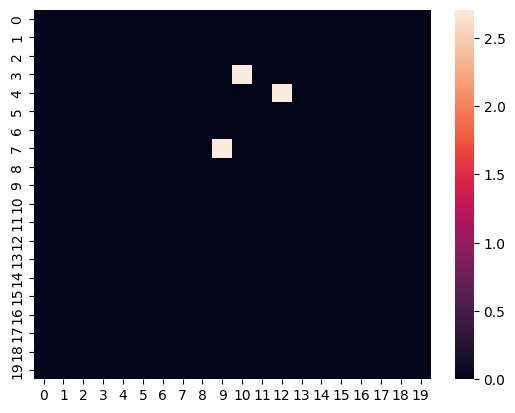

In [11]:
import numpy as np
import seaborn as sb
a = np.load('/disk3/wyb/mycode/GSNet-master/ck3.npy')
b = np.load('/disk3/wyb/mycode/GSNet-master/ckl_0.npy')
sb.heatmap(a)

